# Open AI Game Bot with Feedforword Neural Net

In [2]:
import gym # open AI environment
import numpy as np
import random
from keras.layers.core import Dense,Dropout
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam


#for displaying output
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

Using TensorFlow backend.


In [8]:
env = gym.make('CartPole-v0') #select environment 
env.reset()
frame_='frames.npy'
t_data = 'final_training_data.npy'
number_of_games = 10000  #episode
training_data = []
time_stamp = 720 #frames
score_threshold = 50 #minimum scores

In [46]:
#run  game with random action  for demonstration
score = []
def random_demo():
    #number game to be played
    for _ in range(5):
        s = 0
        #number of frame per game
        for _ in range(200): 
            #for visualizing game , we disable rendering for fast processing
            env.render()
            #generate random action i.e 1 or 0 for left right
            action = env.action_space.sample()
            #perform that action
            observation,reward,done,info = env.step(action)
            s+=reward
            #observation is changes in environment after performing action 
            #reward is score of our action
            #done is boolean value . True when game is over
            
            #when you fail . done is True .break the loop and start new game . and reset environment
            if done:break
        score.append(s)
        env.reset()
    print('Average score for random actions is {}'.format(np.mean(score)))
    env.render(close=True)
random_demo()           

Average score for random actions is 24.4


# we will perform n number of game with random action  and record our action and observation if our action give high reward.

In [47]:
def data_generation():
    accepted_scores = []
    for _ in range(number_of_games):
        obsv_action = []
        previous = []
        score = 0
        
        for _ in range(time_stamp):
            action = env.action_space.sample()
            observation,reward,done,info = env.step(action)
            score+=reward
            
            if len(previous) > 0:
                obsv_action.append([previous,action])
            
            previous = observation
            
            
            if done:
                break
        #if score is higher than minimum value 
        if score > score_threshold:
            accepted_scores.append(score)
            
            for data in obsv_action:
                if data[1] == 0:
                    output = [1,0]
                else:
                    output = [0,1]
                
                training_data.append([data[0],output])
        env.reset()
    training_data_ = np.array(training_data)
    np.save(t_data,training_data_)
    
    print('Average accepted score:',np.mean(accepted_scores))
    print("data generation done")
                
        

In [48]:
data_generation()

Average accepted score: 62.2140762463
data generation done


In [49]:
_training_data = np.load(t_data)

In [50]:
_training_data.shape

(20874, 2)

# Once Data generation is done . we can train on data. this is simple feedforward network for classification . we observ and perform sutiable action  

In [51]:
#create network to train 
def Model(shape):
    
    model = Sequential()
    
    model.add(Dense(1024,input_shape=shape,activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    
    
    model.add(Dense(256,activation='relu'))
    Dropout(0.2)
    
    model.add(Dense(256,activation='relu'))
    Dropout(0.2)
    
    model.add(Dense(128,activation='relu'))
    Dropout(0.2)
    
    model.add(Dense(2,activation='softmax'))
    
    model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [52]:
def train(training_data,model=False):
    
    X = np.array([i[0] for i in training_data]).reshape(-1,len(training_data[0][0]))
    Y= [i[1] for i in training_data]
    
    
    if not model:
        model = Model([len(X[0])])
    print(model.summary())
    
    model.fit(X,Y,batch_size=32, nb_epoch=3, verbose=1)
    return model
    
model = train(_training_data)    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_26 (Dense)                 (None, 1024)          5120        dense_input_6[0][0]              
____________________________________________________________________________________________________
batchnormalization_7 (BatchNorma (None, 1024)          4096        dense_26[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 512)           524800      batchnormalization_7[0][0]       
____________________________________________________________________________________________________
batchnormalization_8 (BatchNorma (None, 512)           2048        dense_27[0][0]                   
___________________________________________________________________________________________

In [53]:
#once trainin is done we will play our game 
scores=[]
frames=[]
for i in range(10):
        score = 0
        scores=[]
        observ = env.reset()
        
        for _ in range(time_stamp):
            frames.append(env.render(mode='rgb_array'))
            
            obs =  np.array(observ).reshape(-1,len(observ))
            
            action = np.argmax(model.predict(obs))
            observation,reward,done,info = env.step(action)
            score+=reward
            
            observ = observation
            if done:
                break
        
        print('-------- episode {} scored {}---------'.format(i+1,score))
        scores.append(score)
env.render(close=True)
print('Average Score: ',sum(scores)/len(scores))

-------- episode 1 scored 173.0---------
-------- episode 2 scored 200.0---------
-------- episode 3 scored 157.0---------
-------- episode 4 scored 199.0---------
-------- episode 5 scored 178.0---------
-------- episode 6 scored 191.0---------
-------- episode 7 scored 88.0---------
-------- episode 8 scored 200.0---------
-------- episode 9 scored 181.0---------
-------- episode 10 scored 189.0---------
Average Score:  189.0


# We have increase Average(10 games) by 127 points with just simple feedforward network
# Average(10000 games) for random action 62.2 points 

In [9]:
np.save(frame_,np.array(frames))


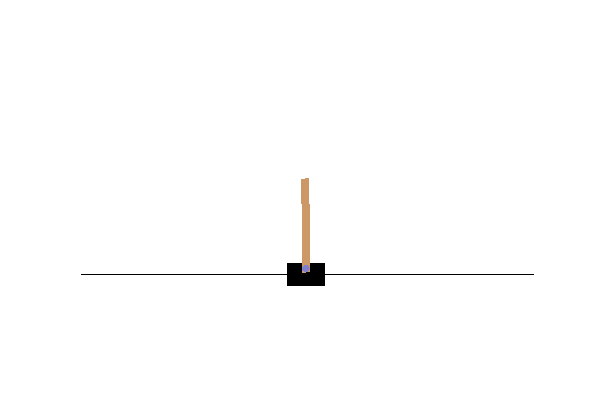
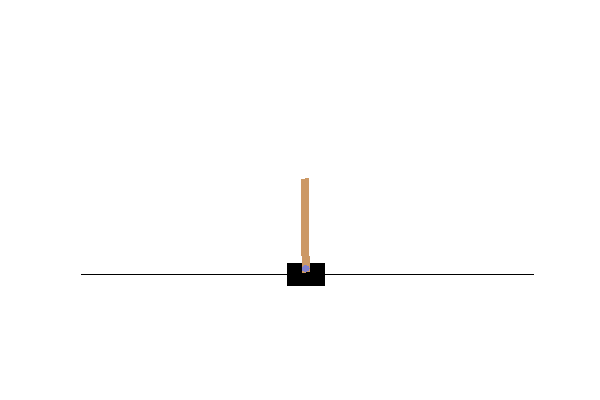
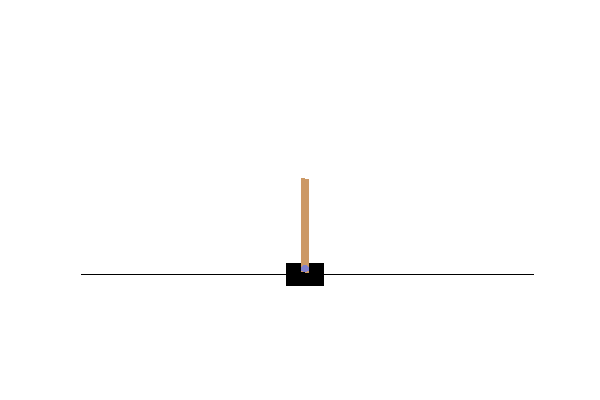
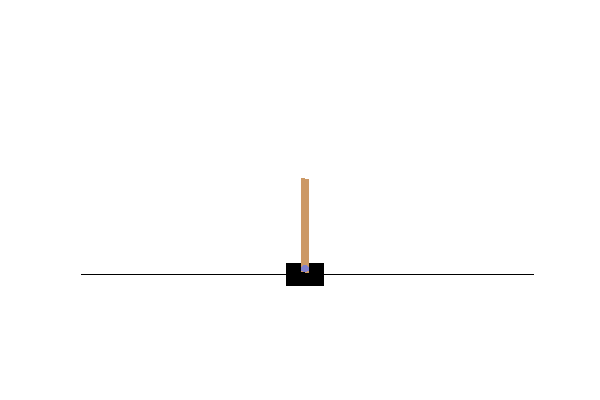
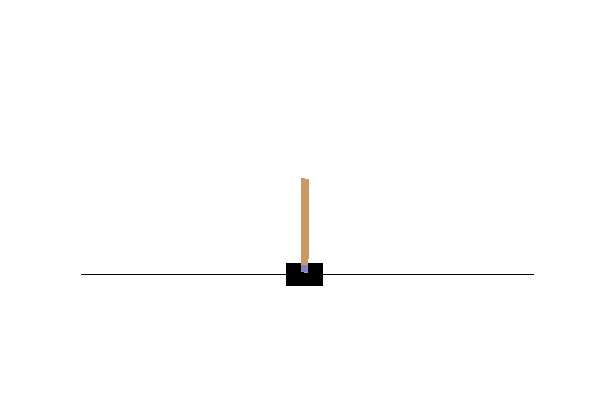
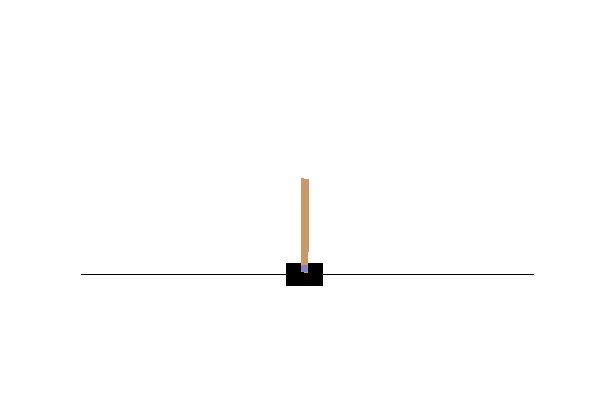
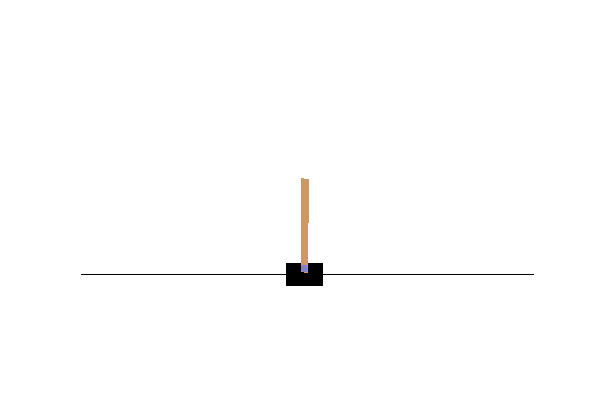
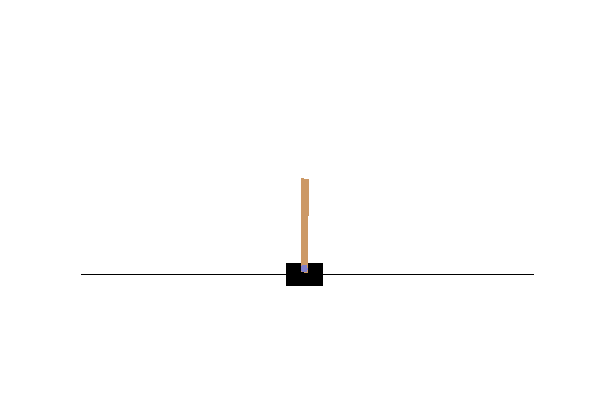
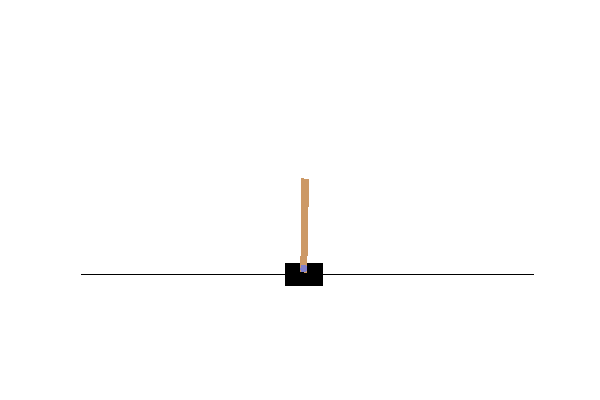
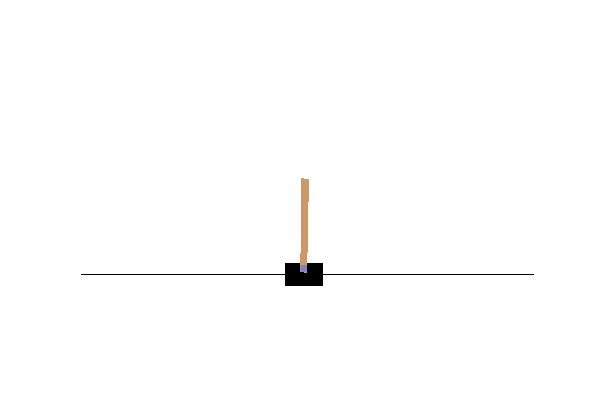
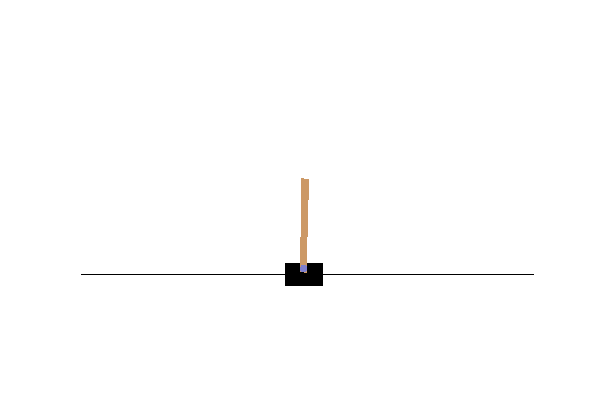
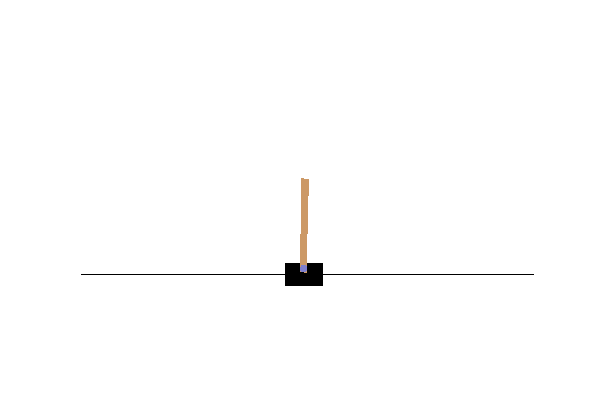
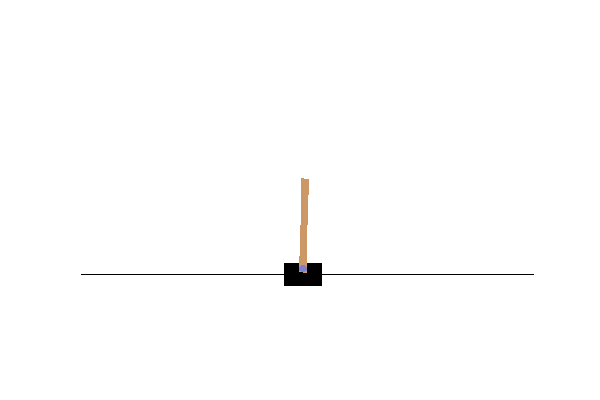
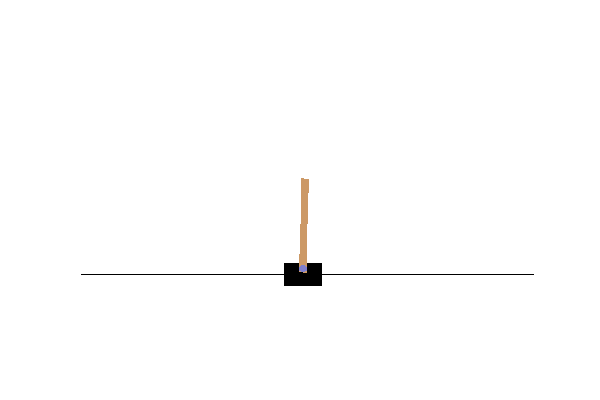
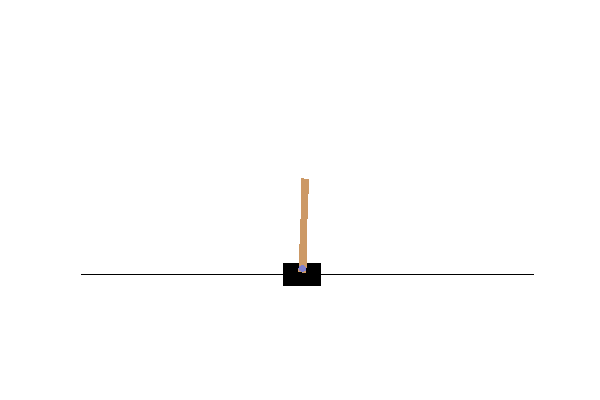
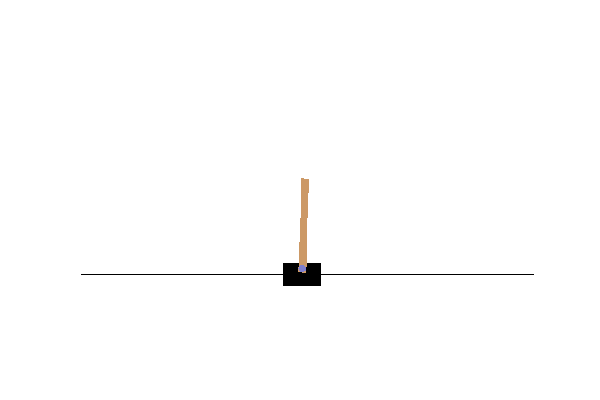
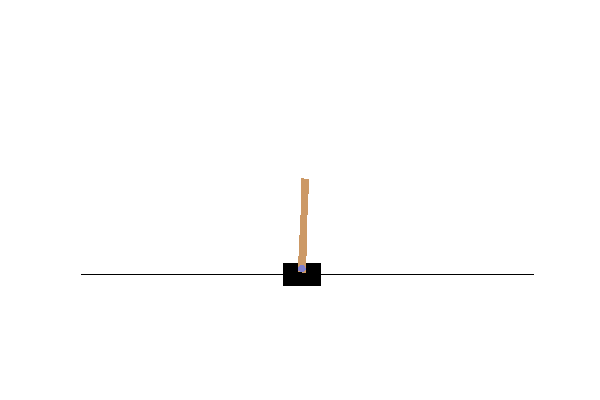
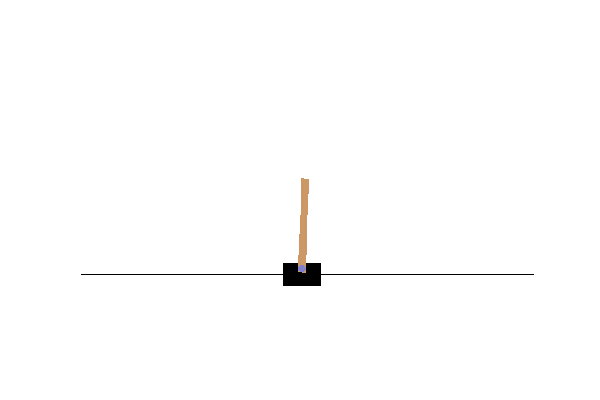
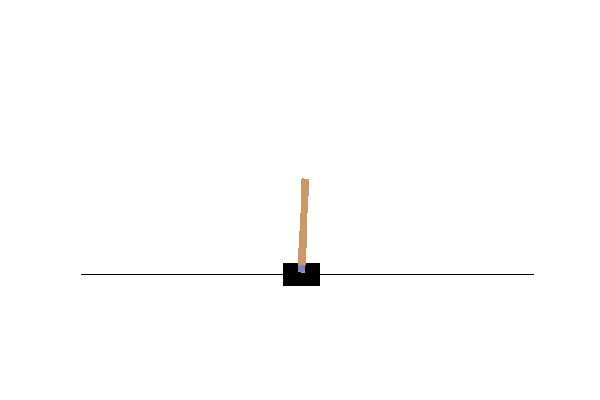
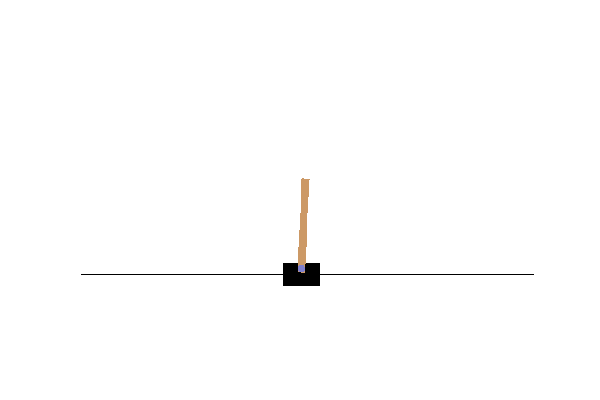
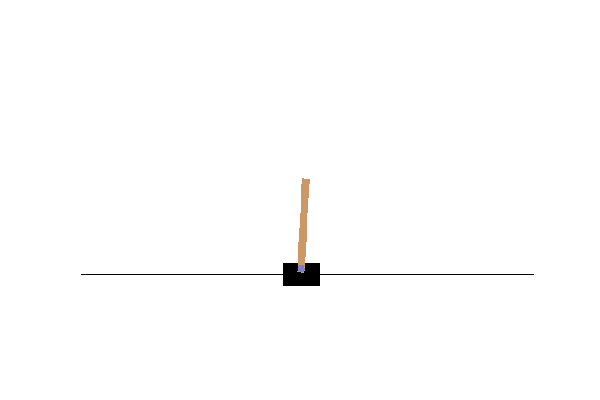
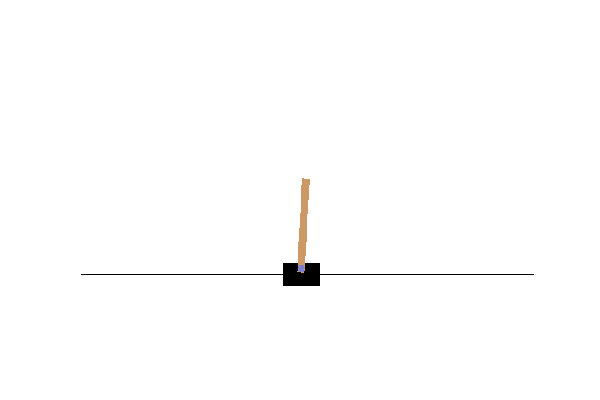
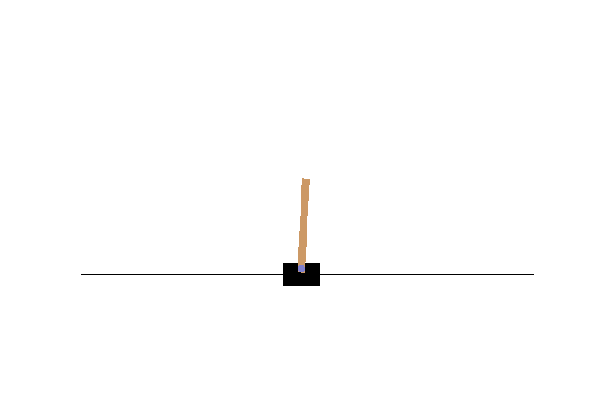
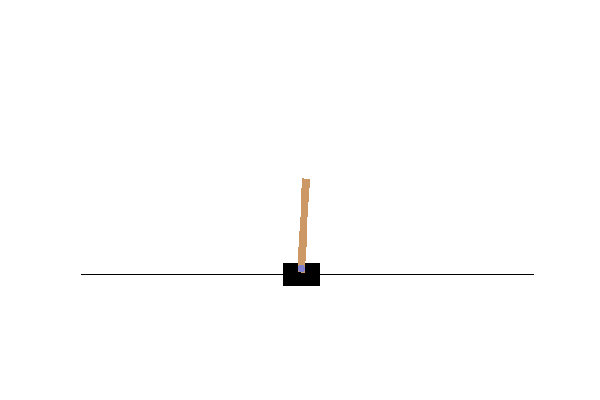
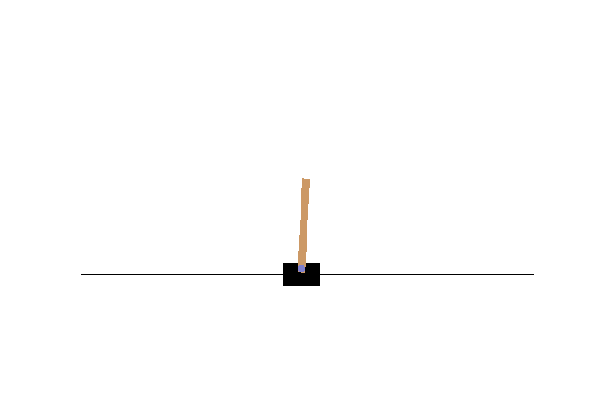
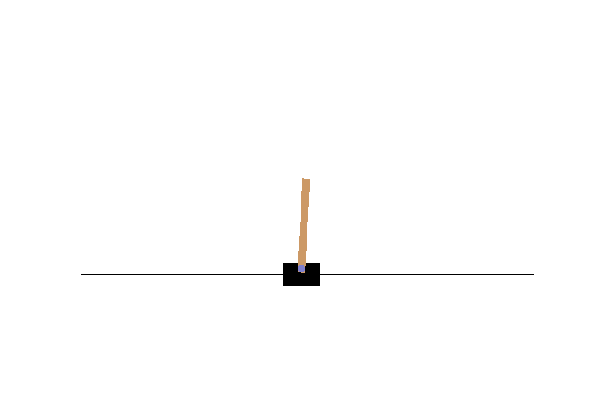
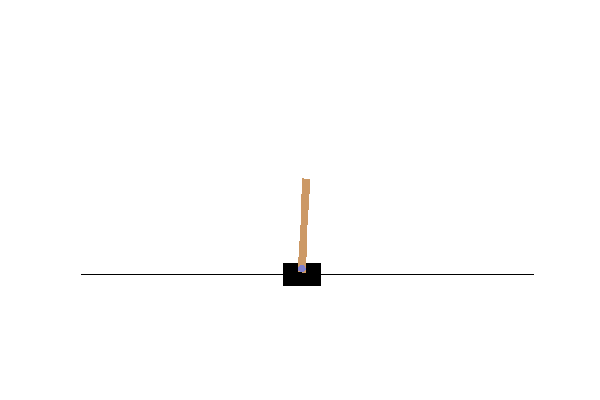
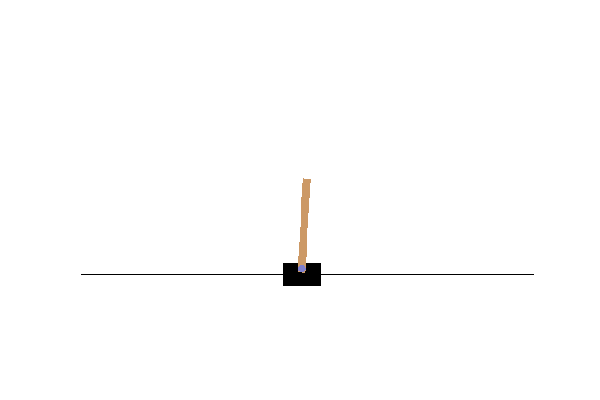
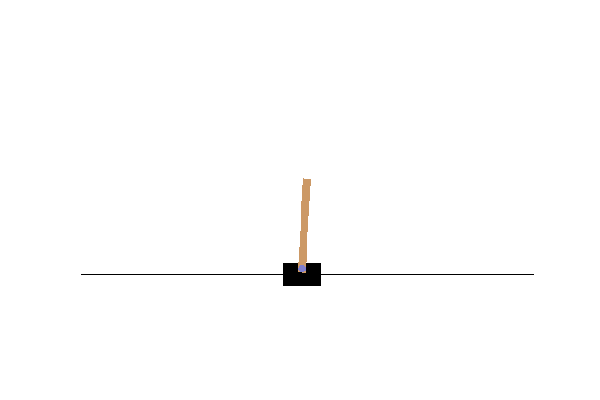
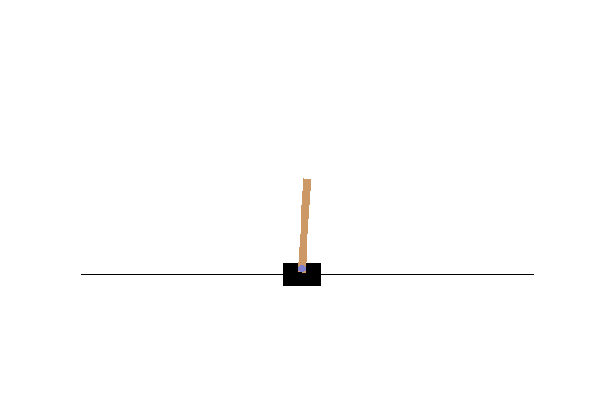
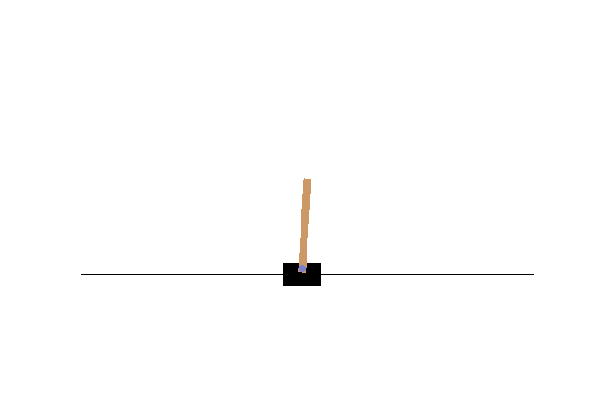
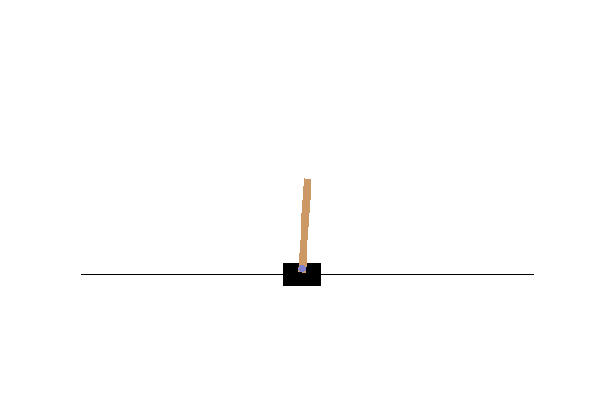
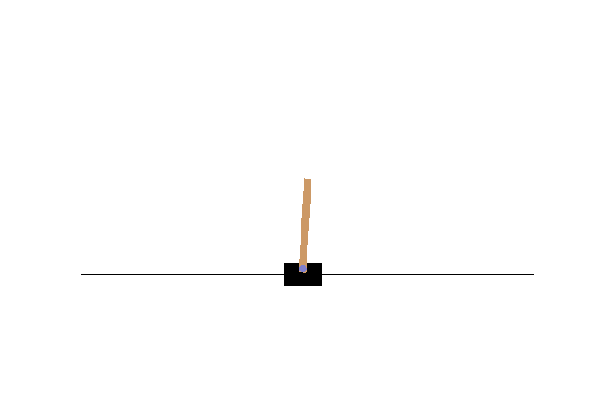
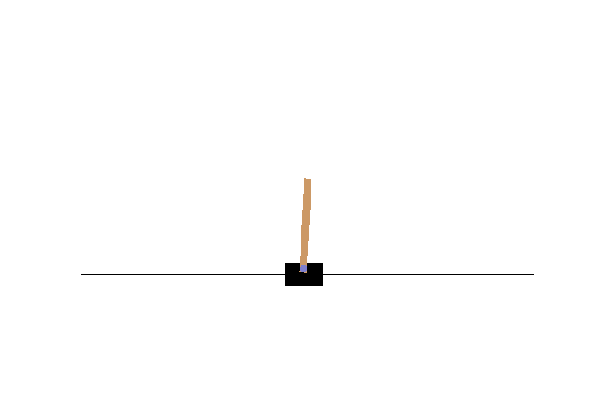
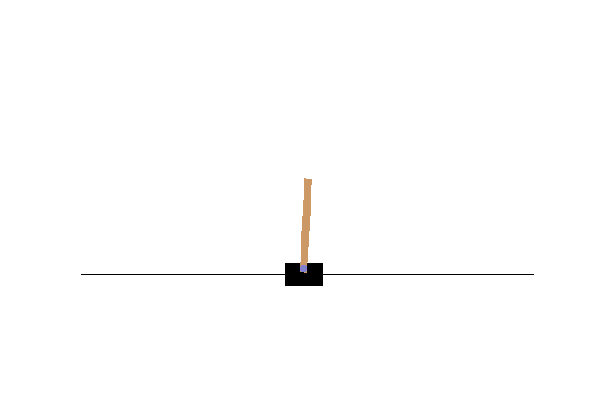
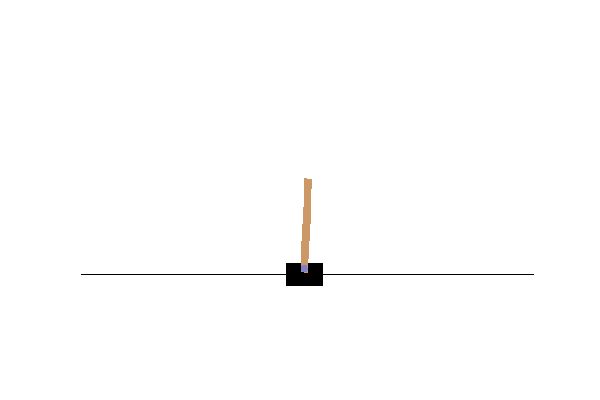
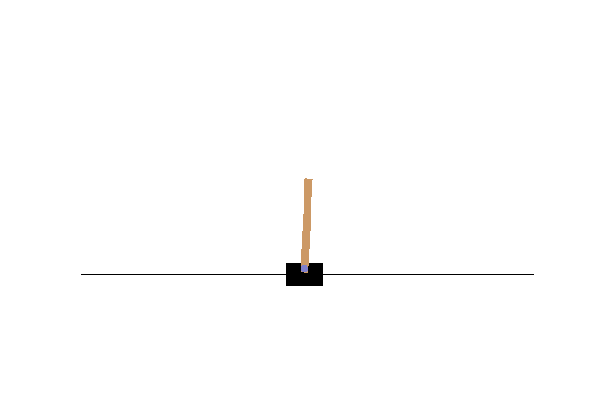
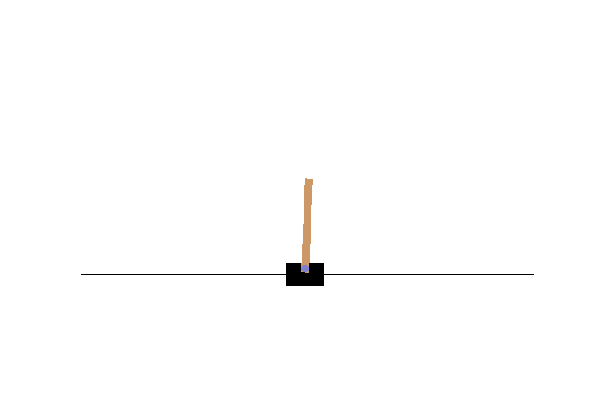
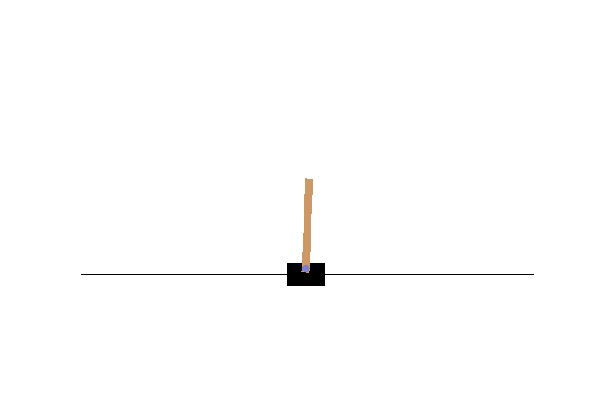
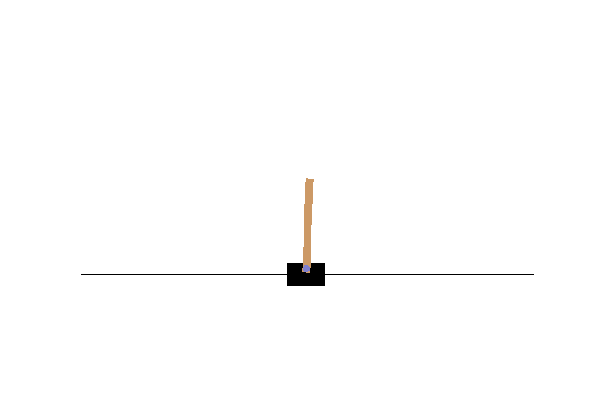
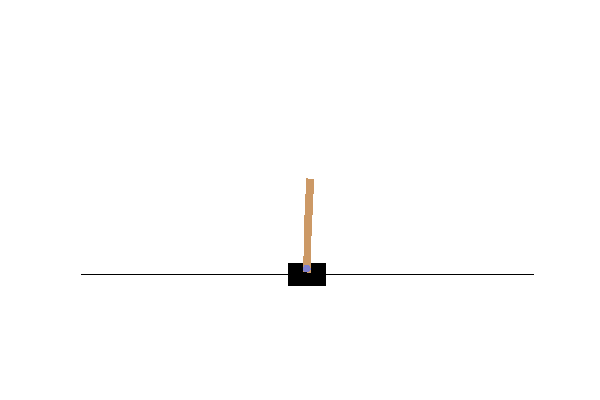
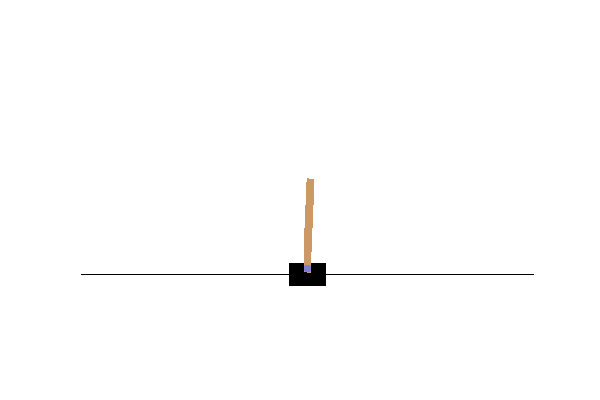
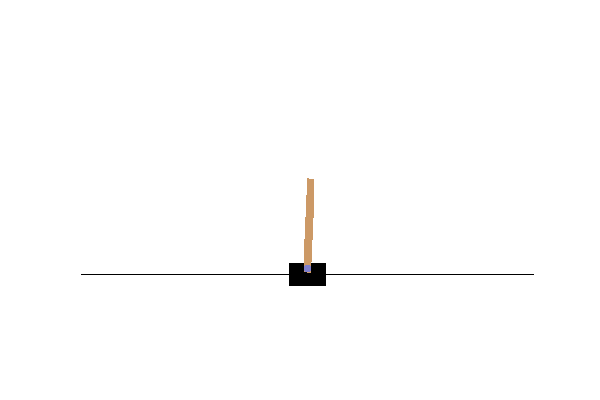
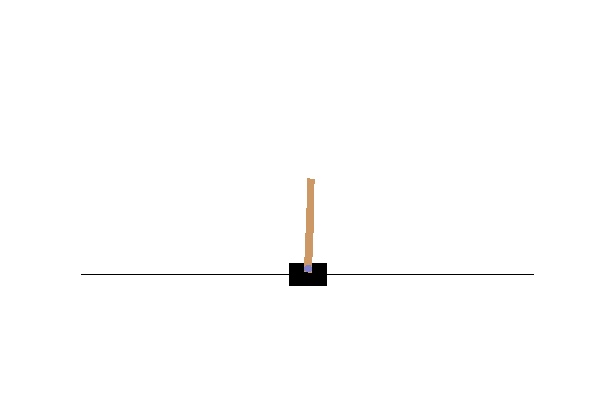
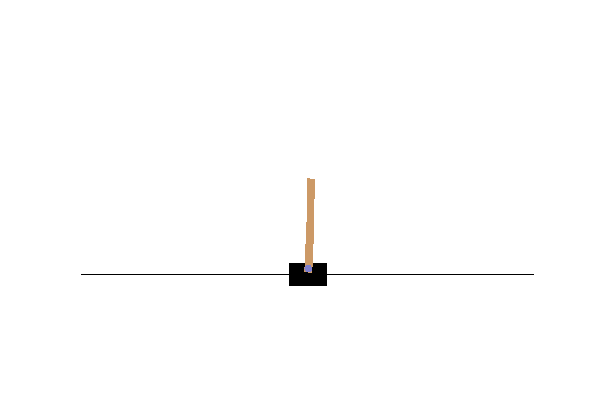
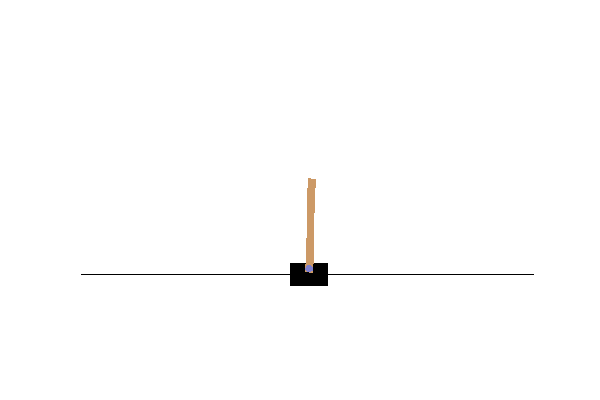
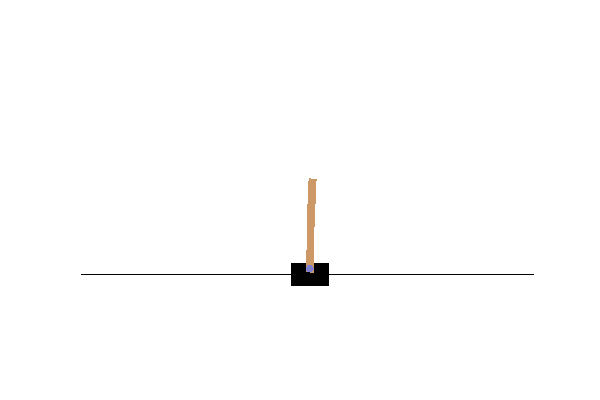
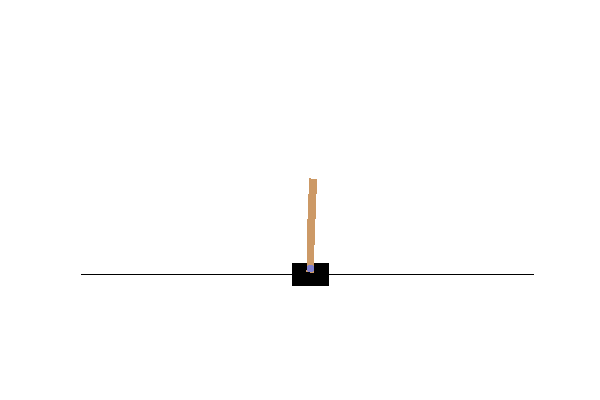
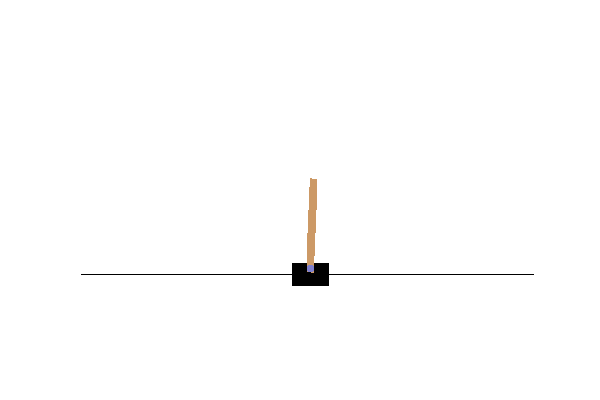
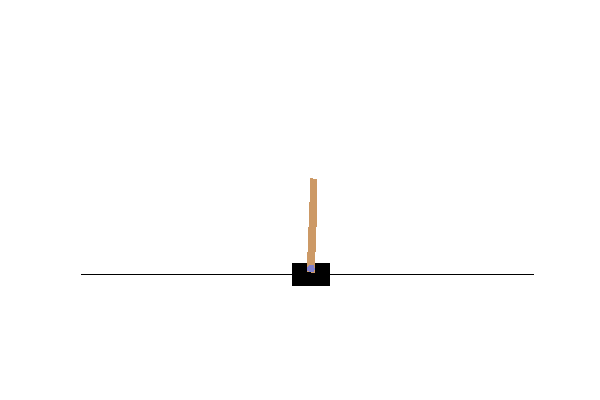
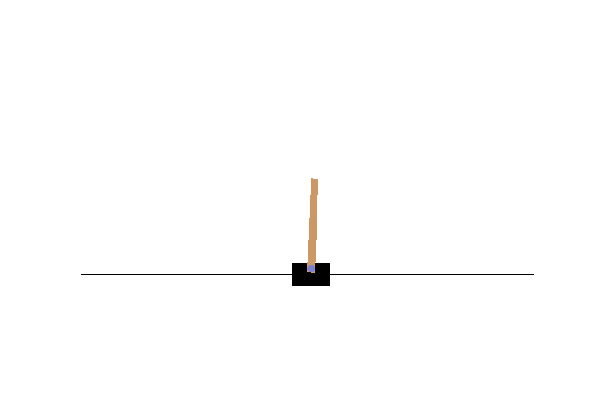
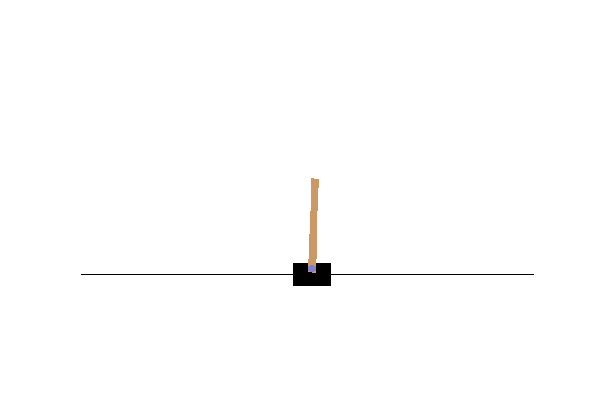
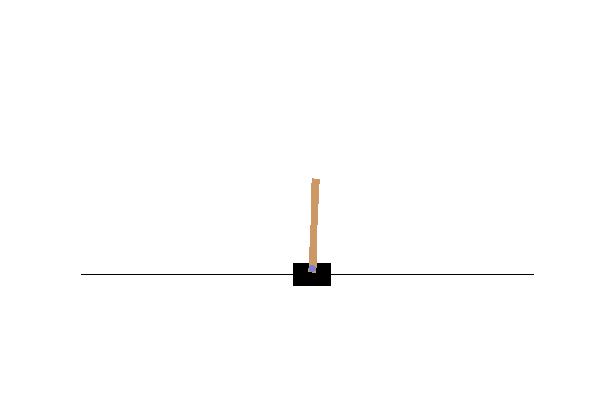
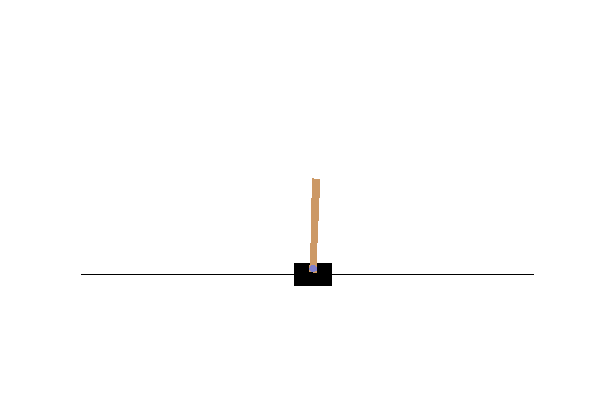
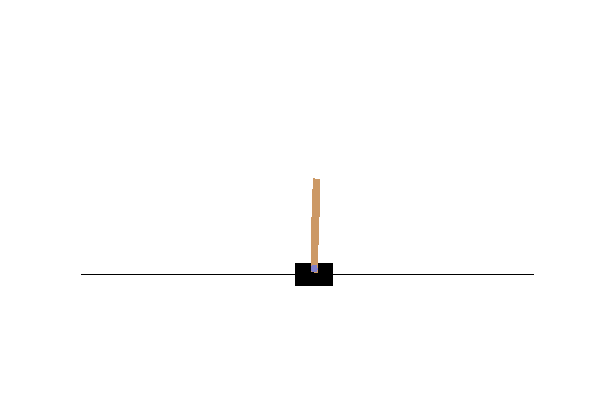
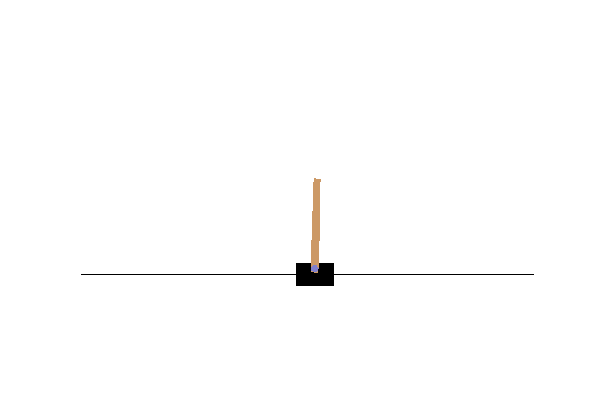
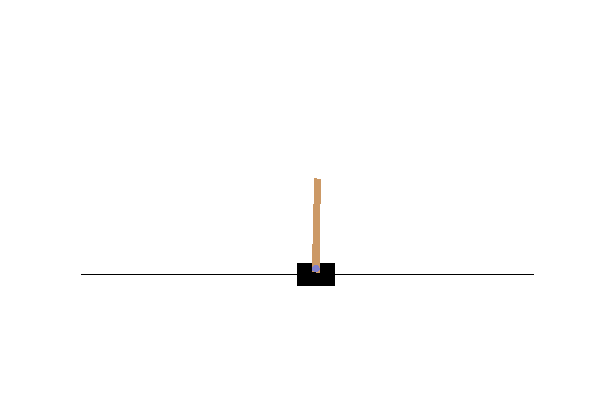
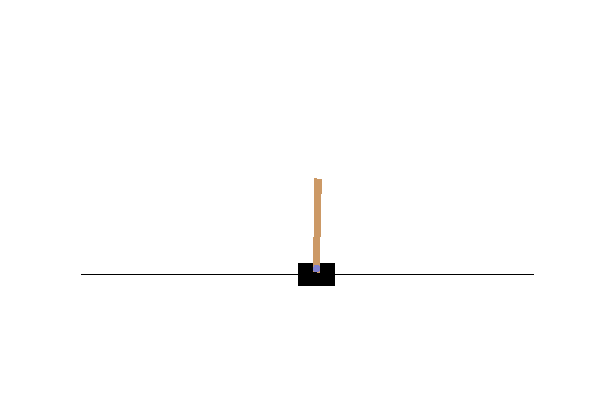
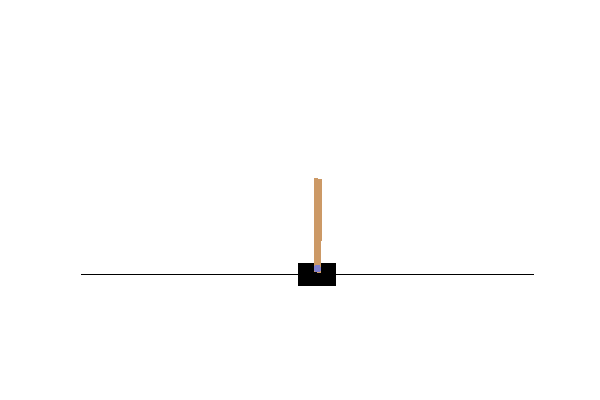
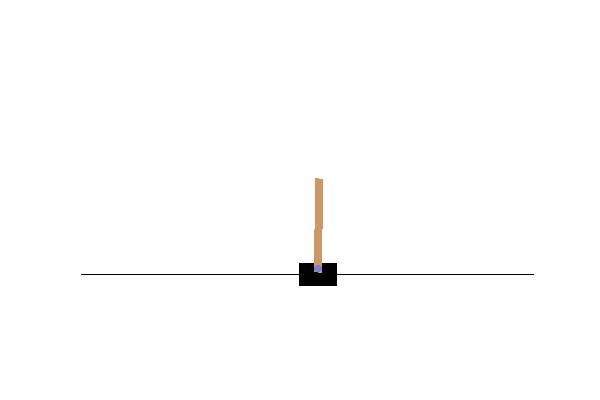
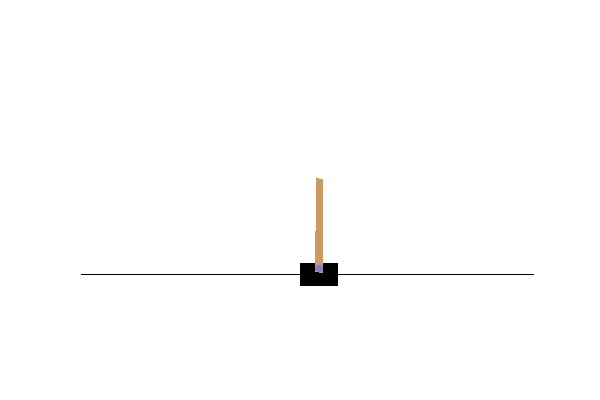
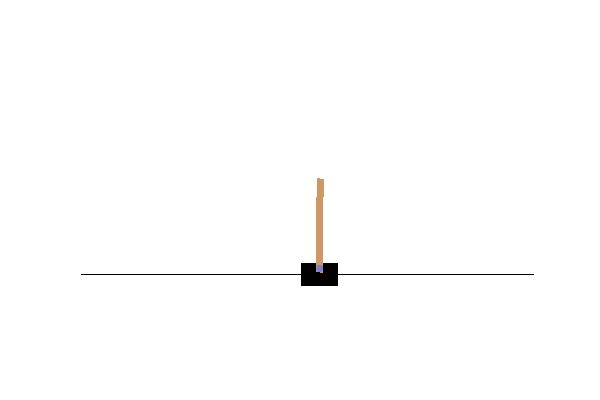
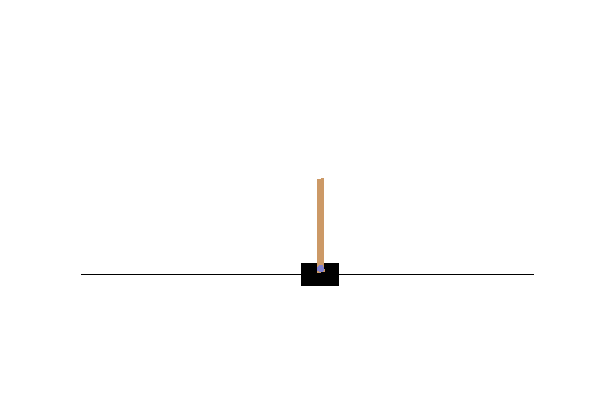
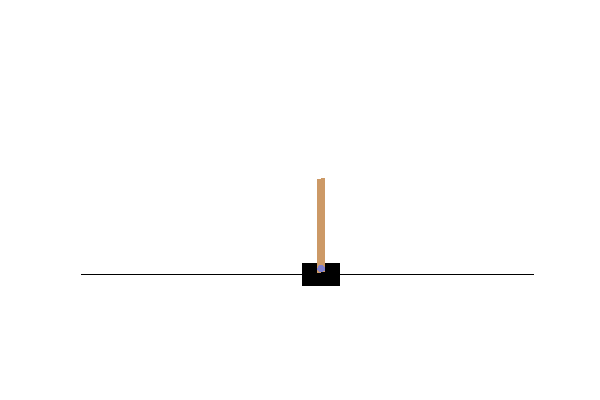
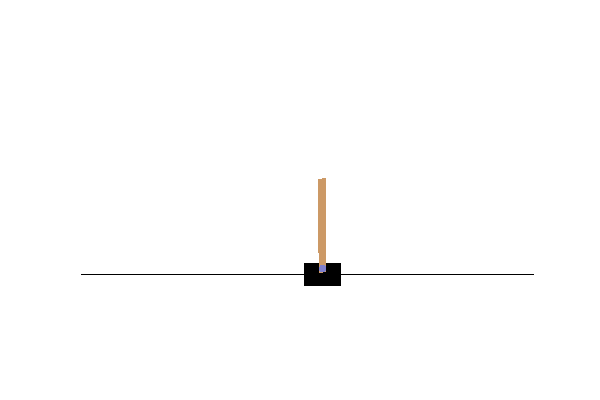
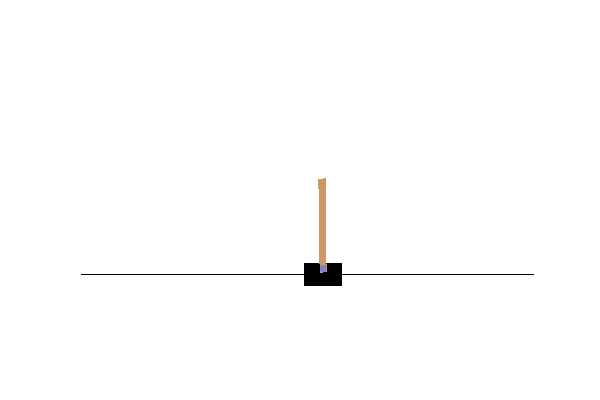
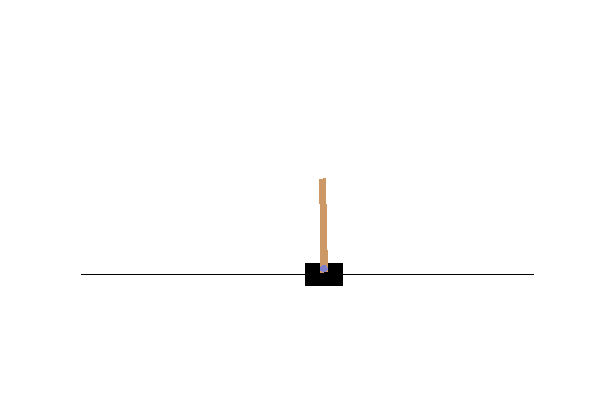
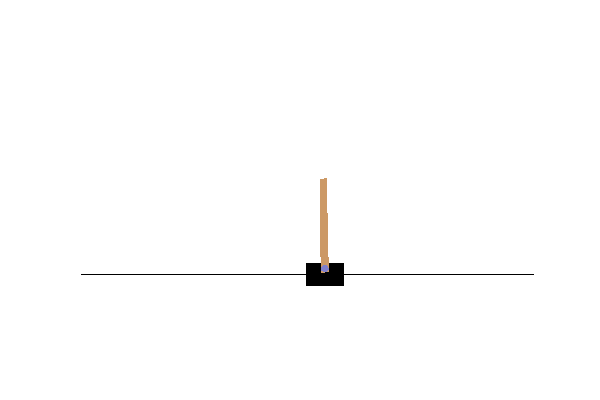
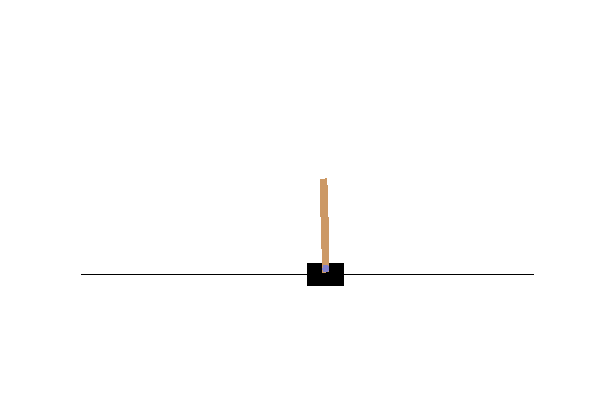
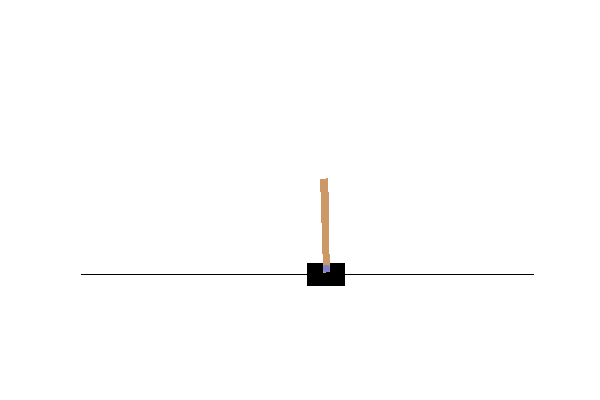
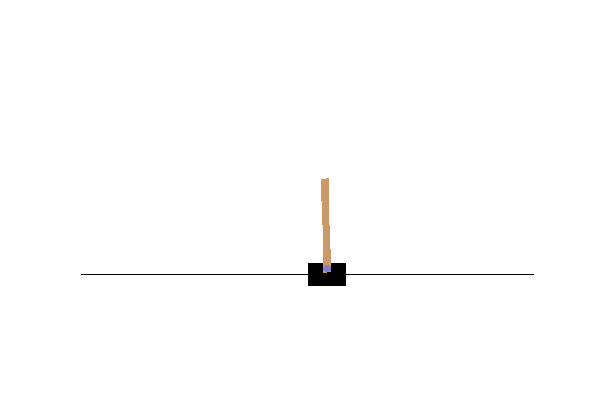
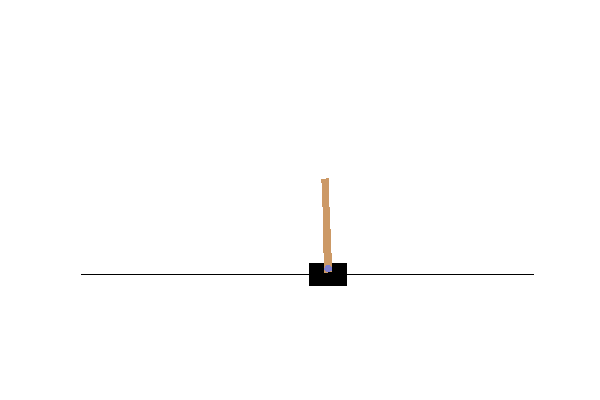
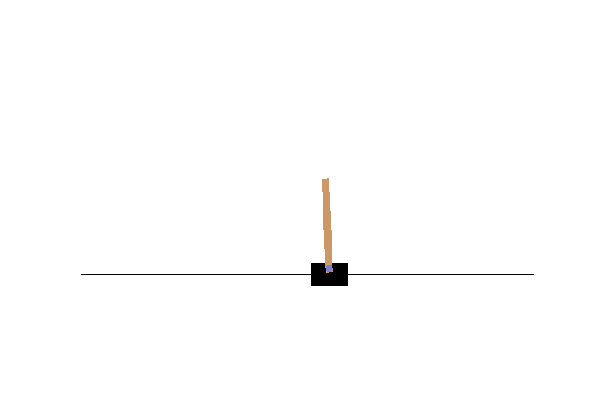
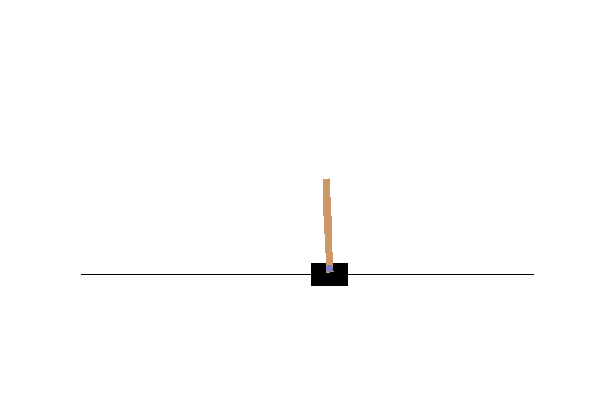
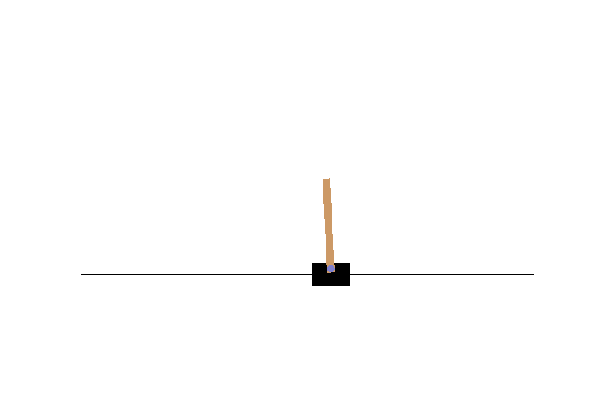
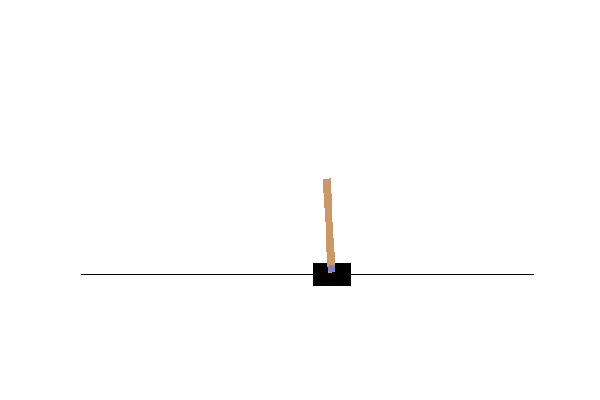
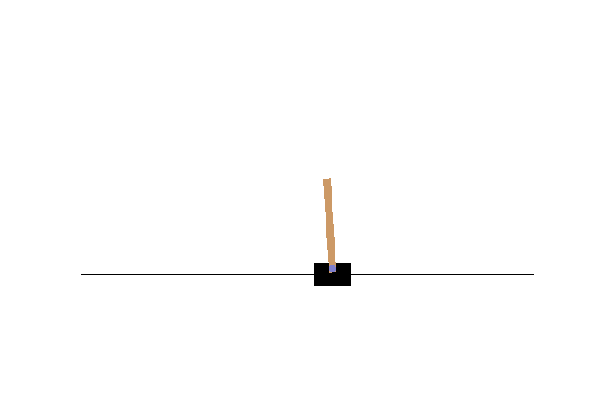
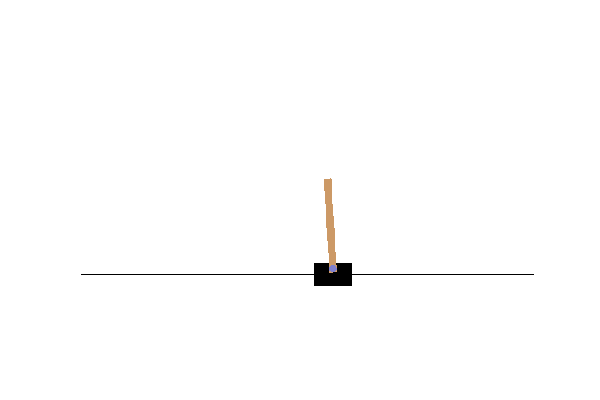
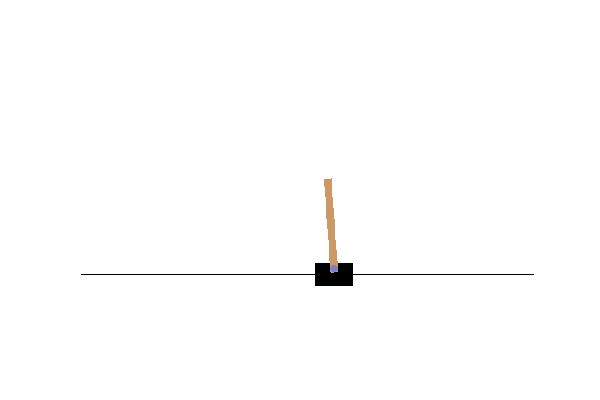
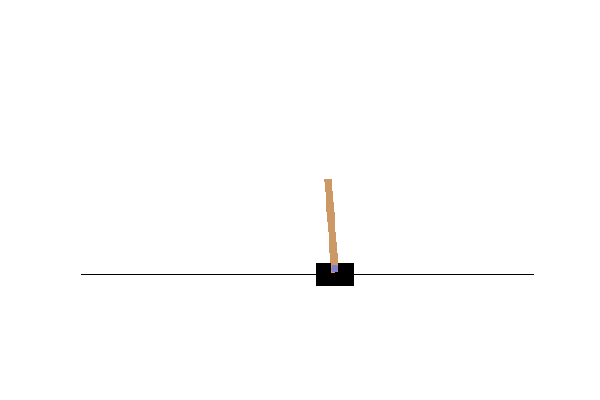
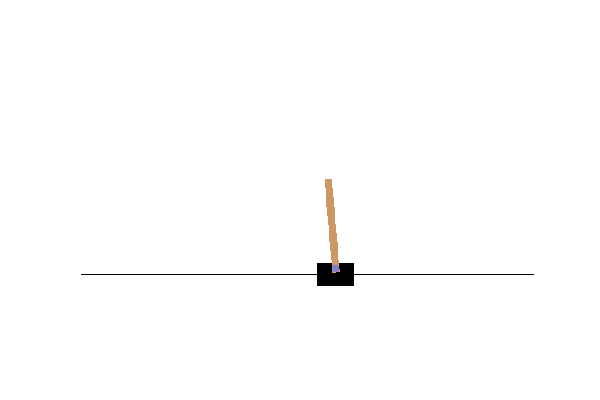
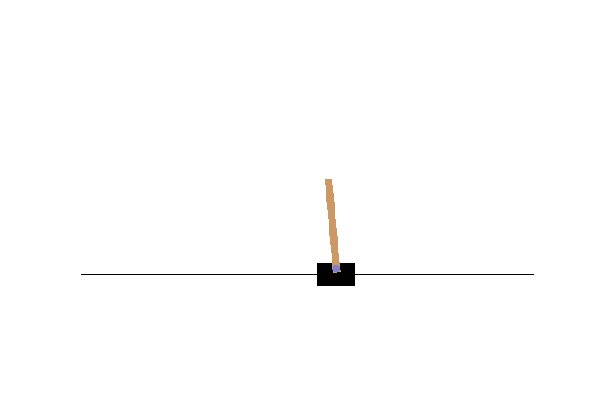
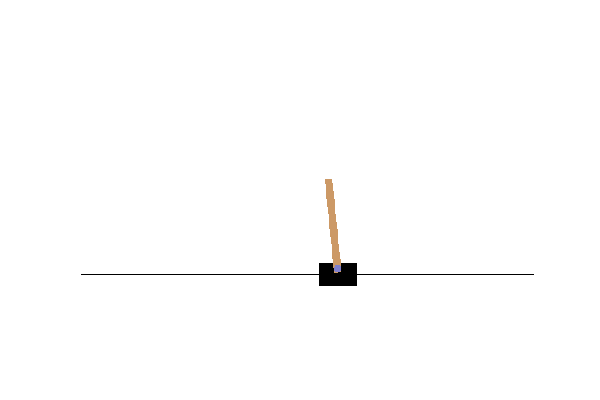
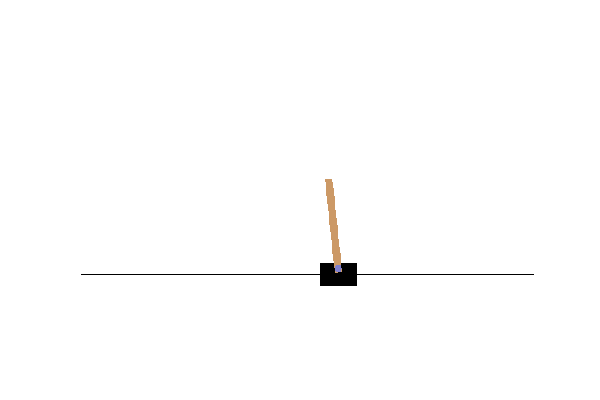
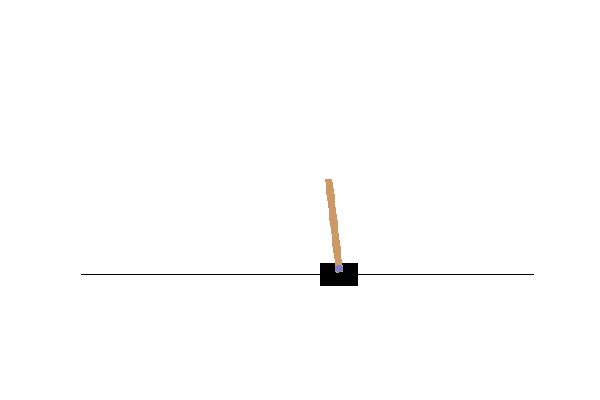
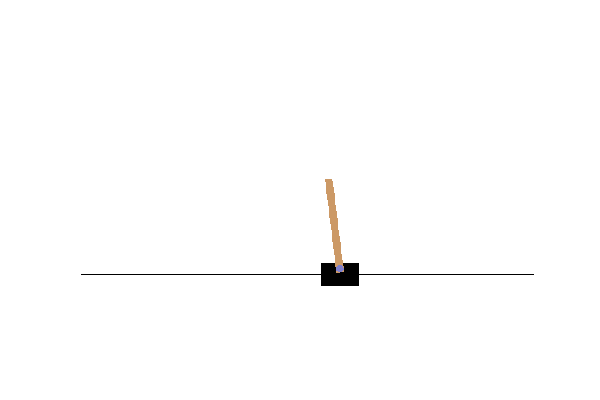
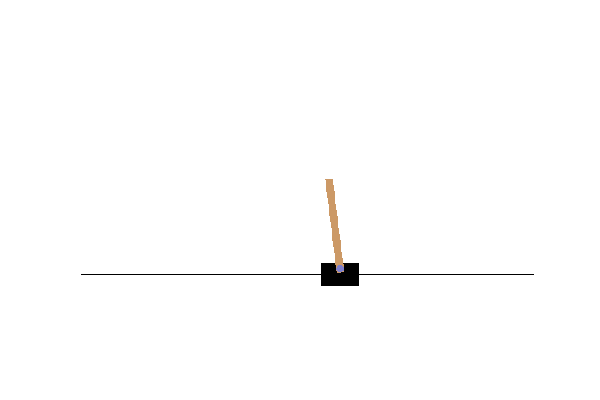
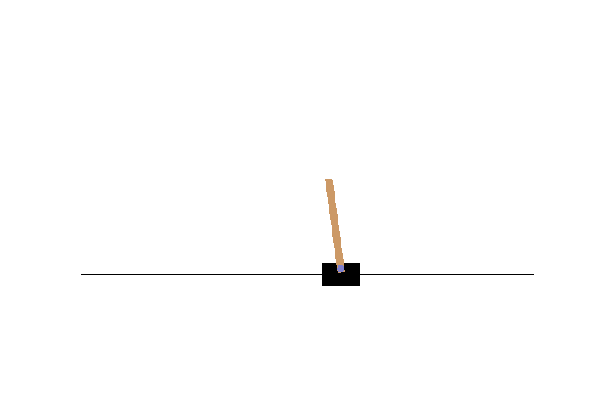
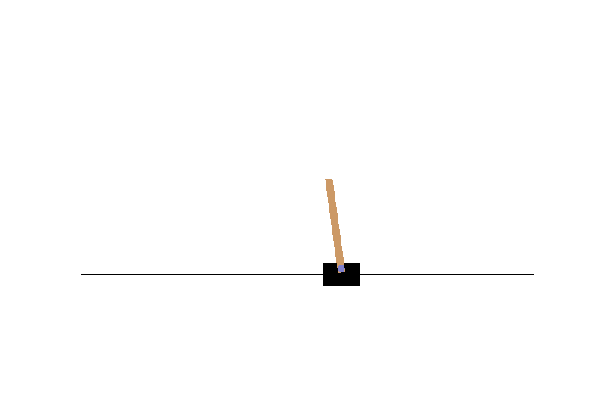
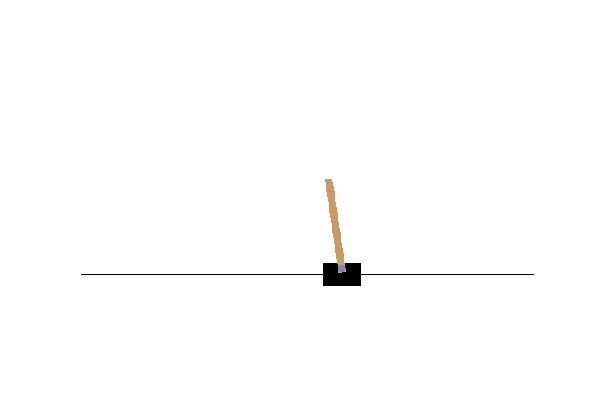
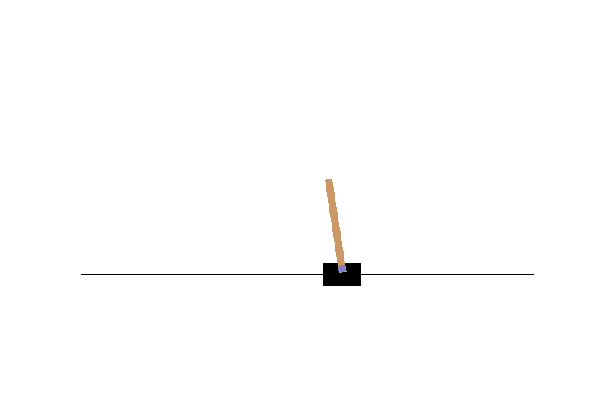
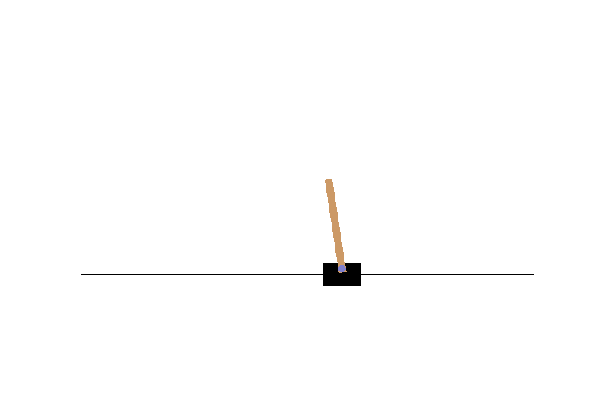
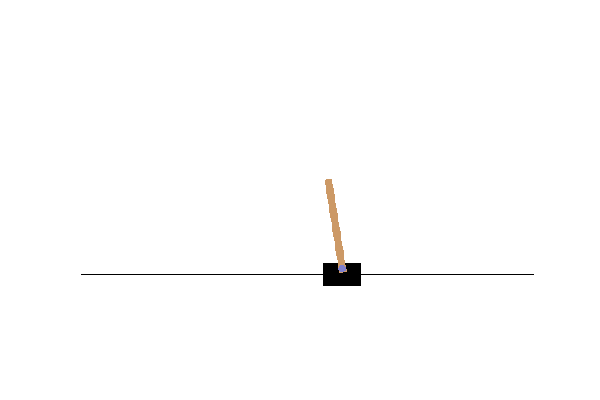
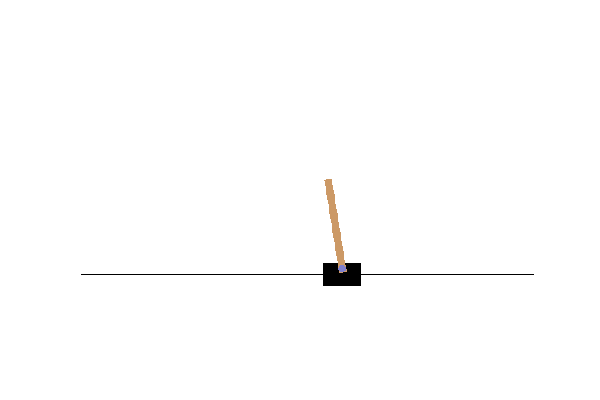
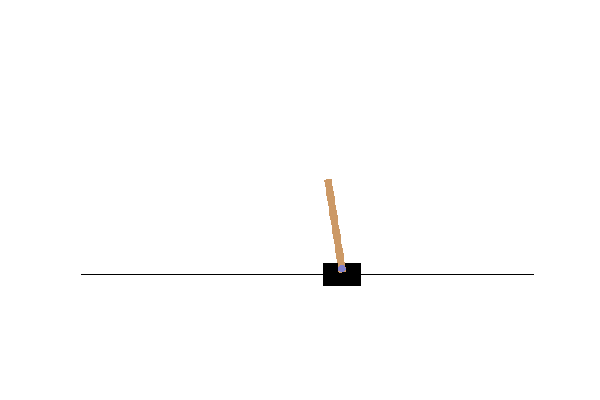
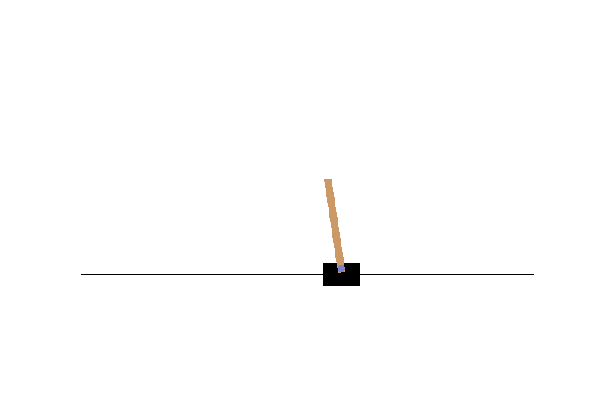
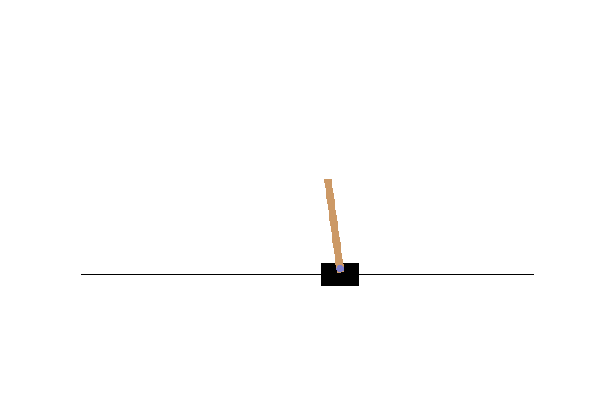
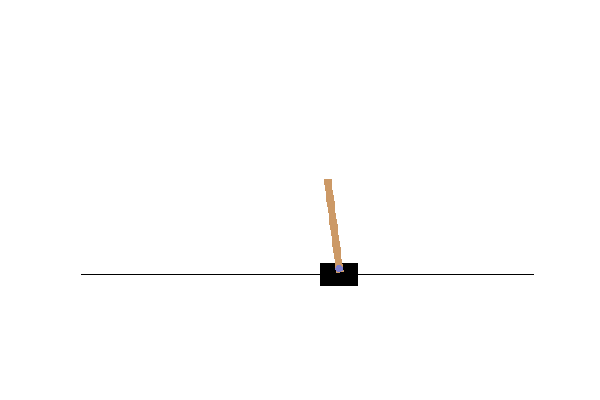
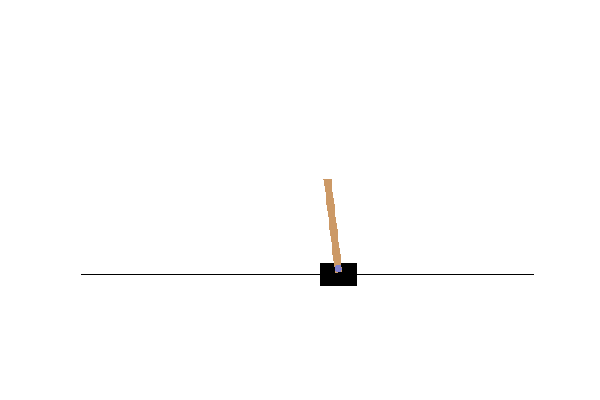
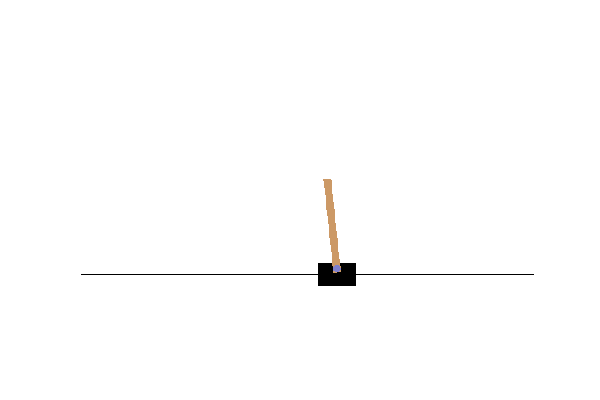
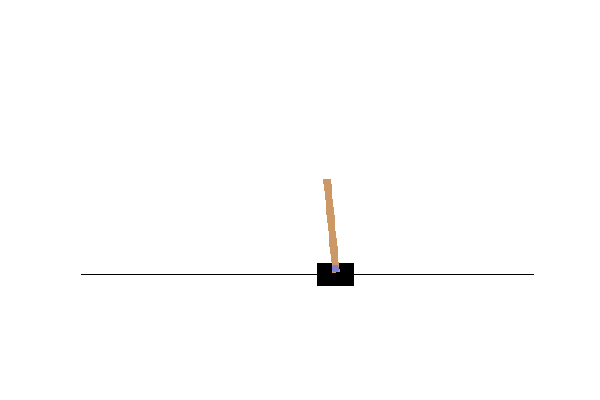
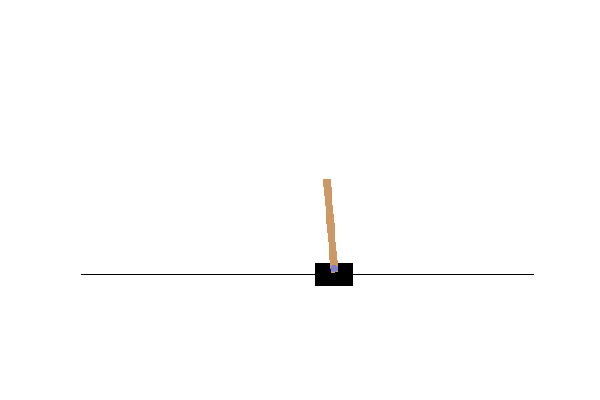
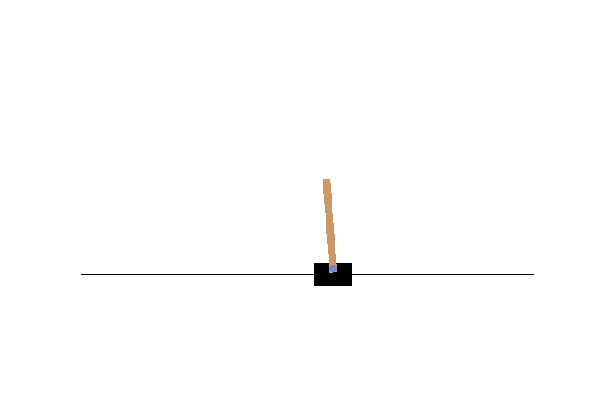
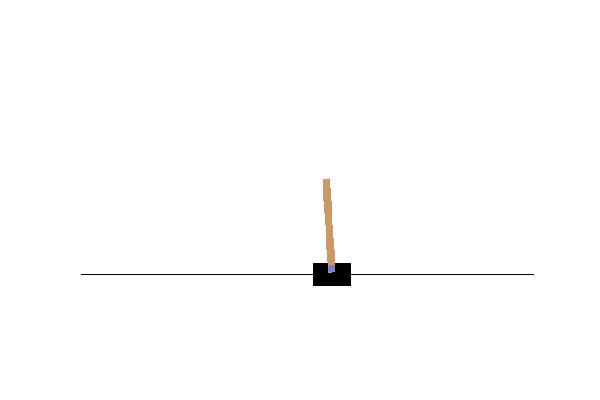
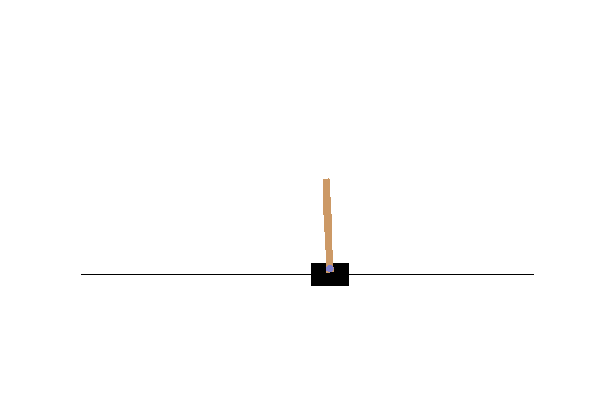
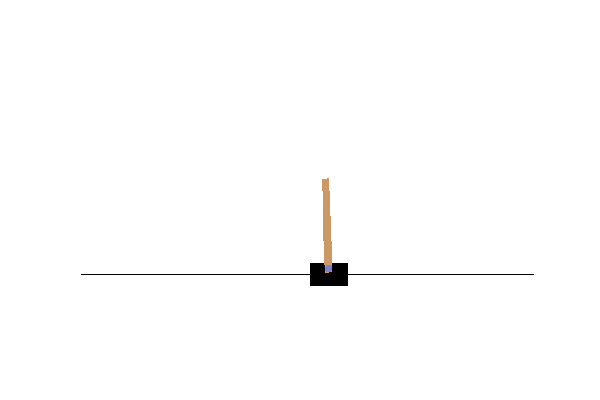
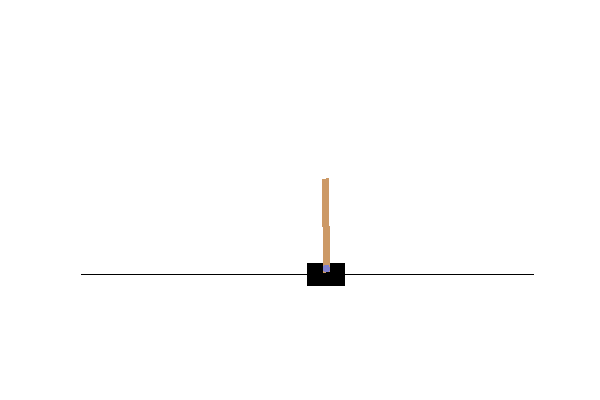
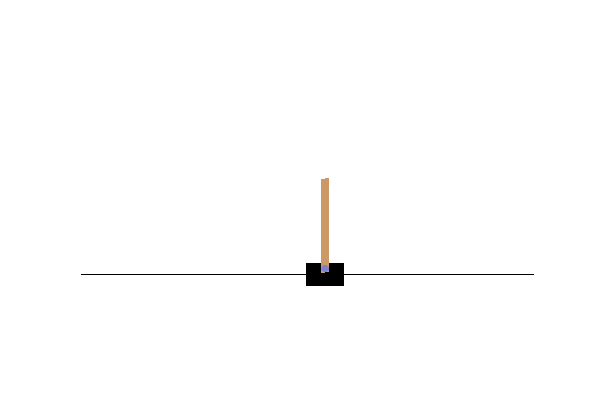
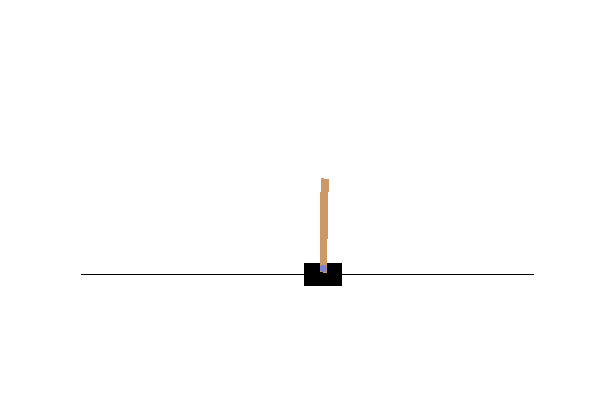
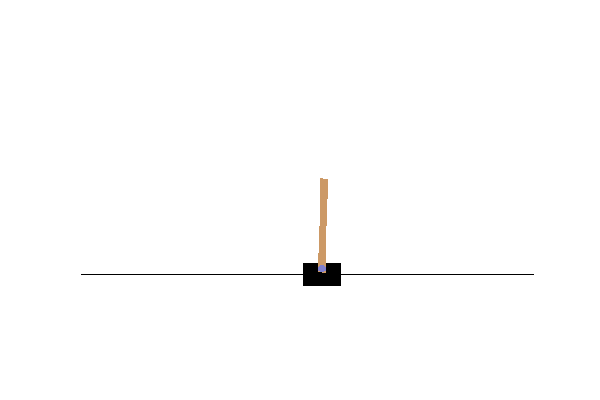
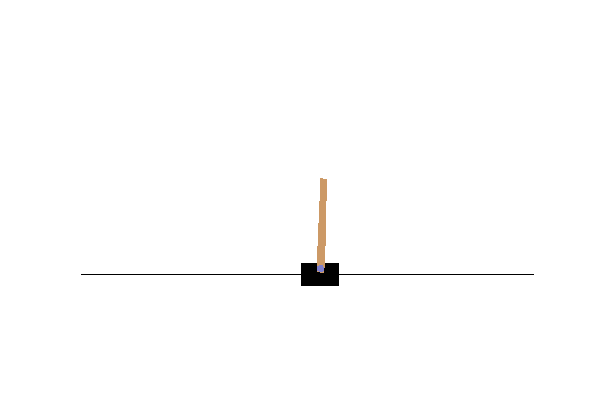
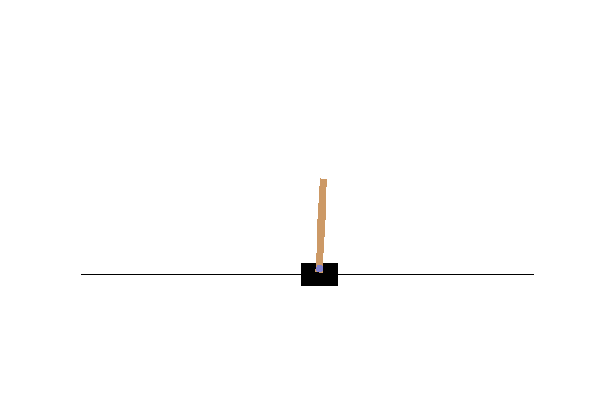
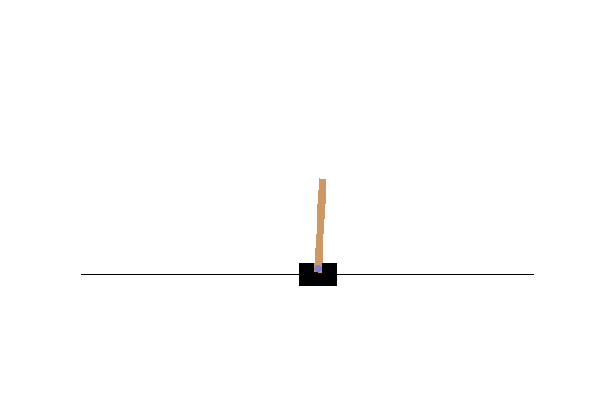
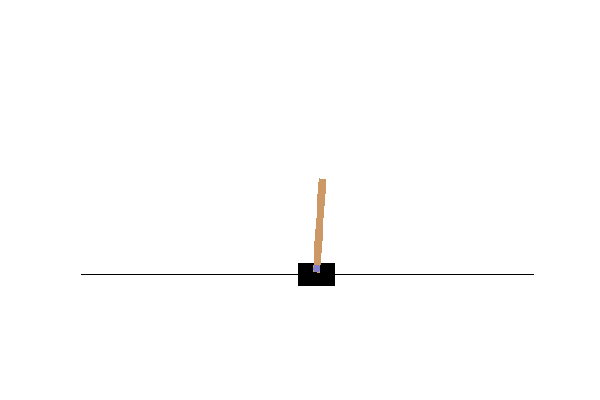
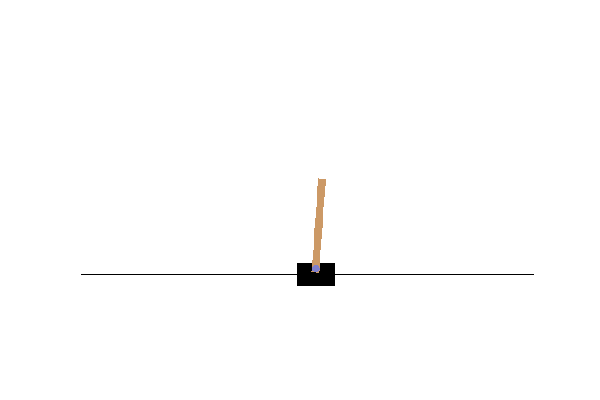
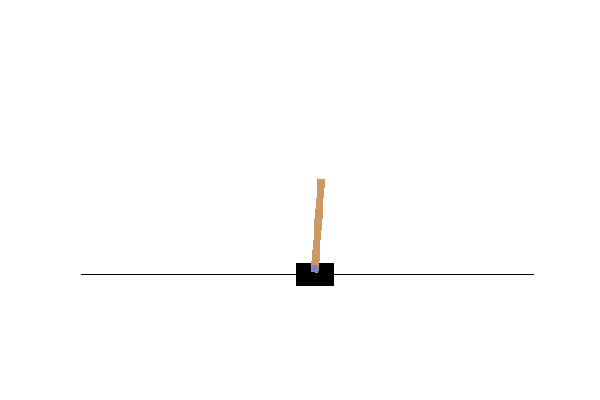
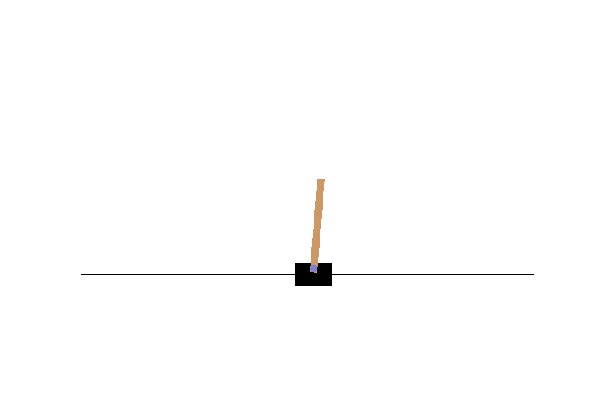
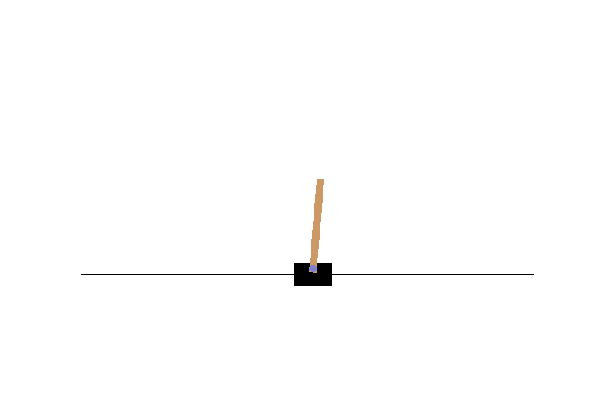
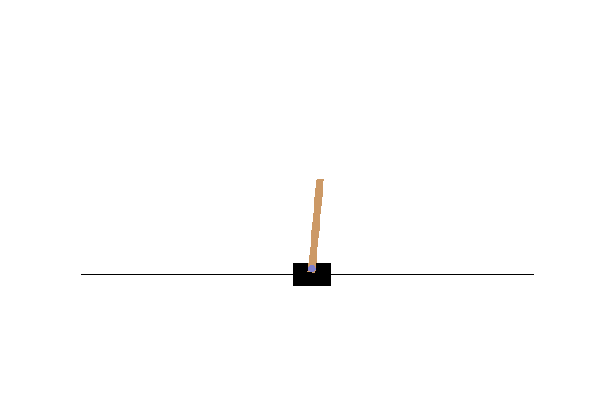
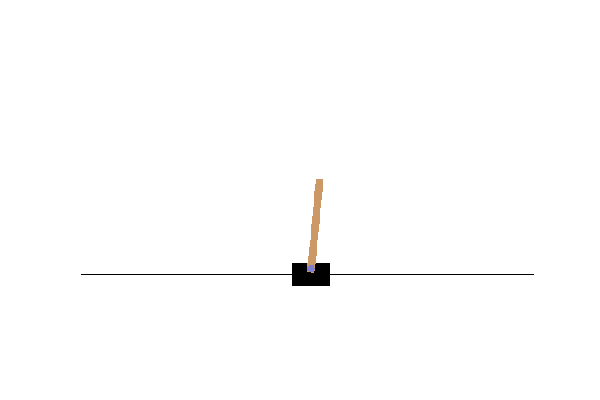
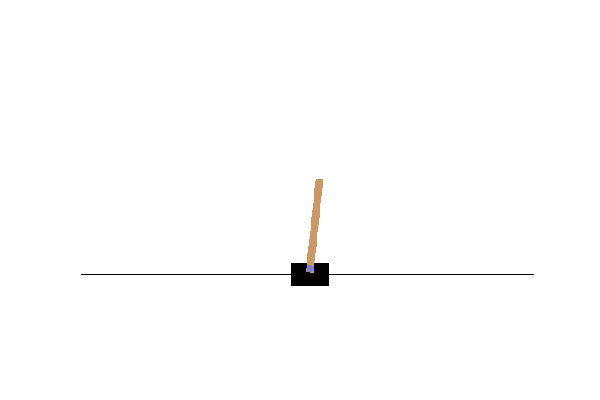
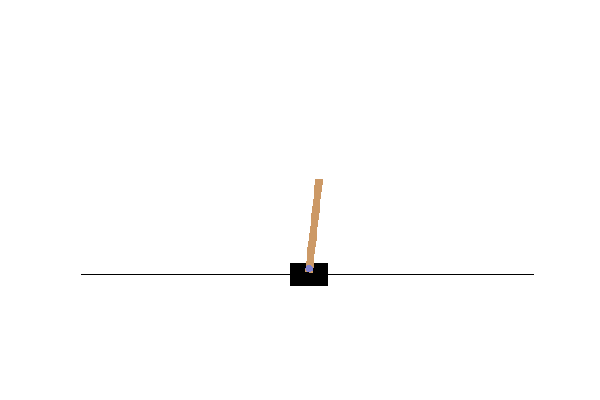
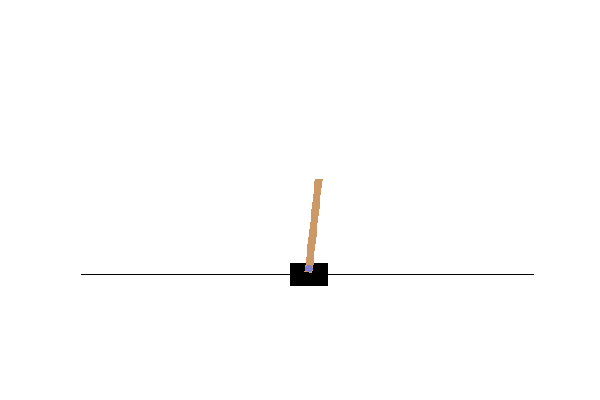
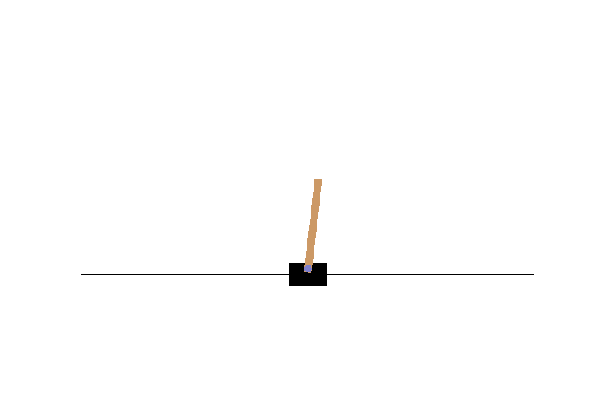
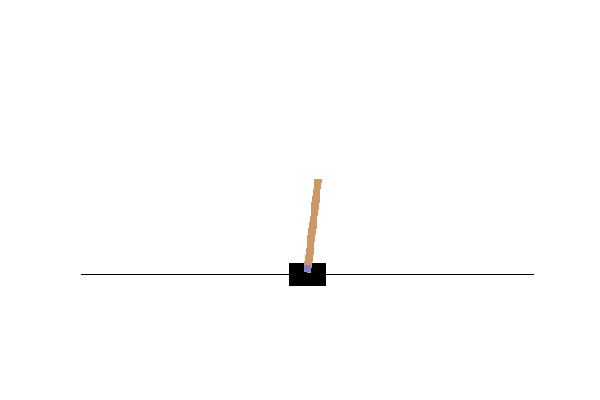
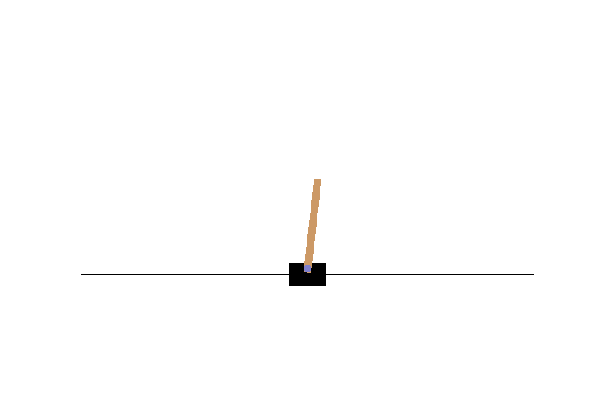
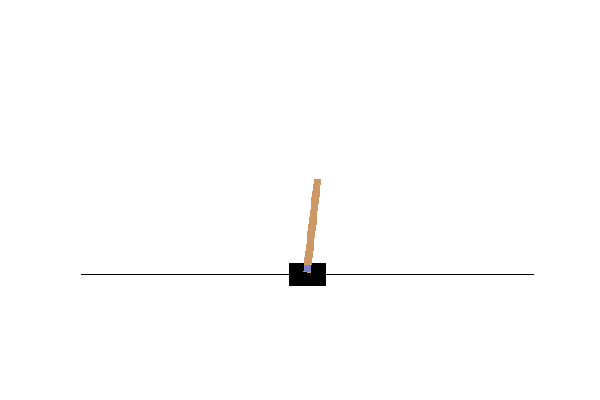
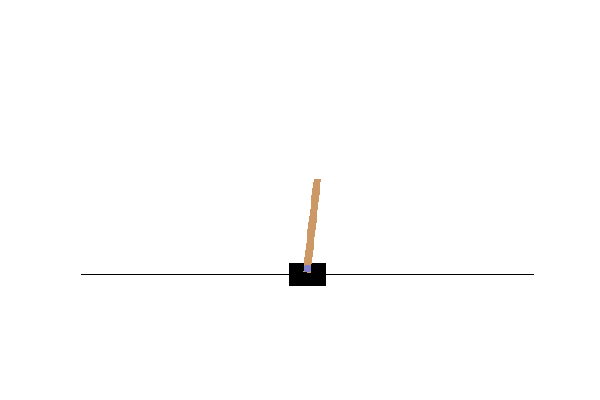
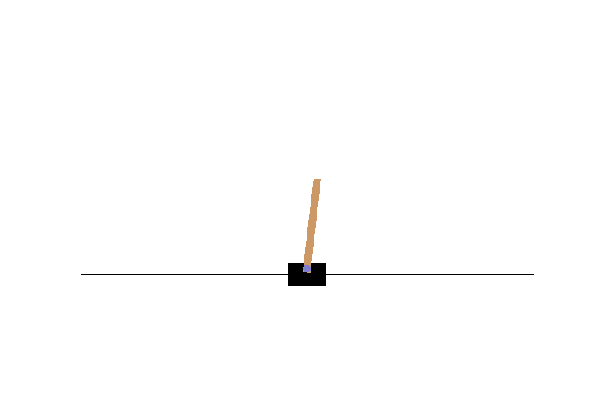
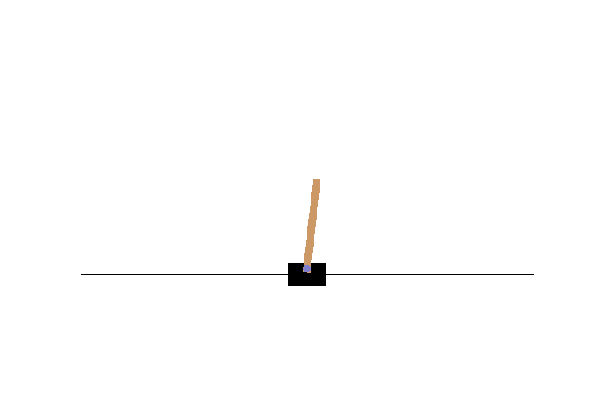
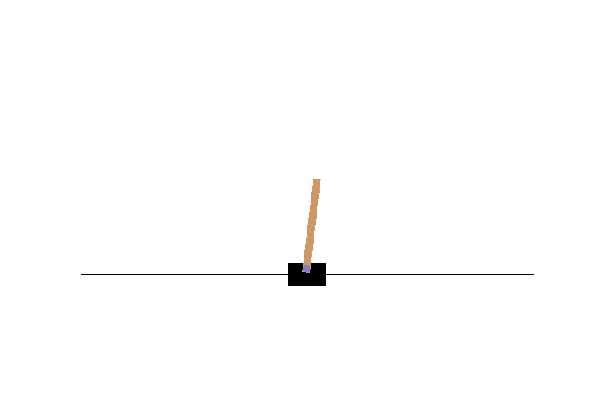
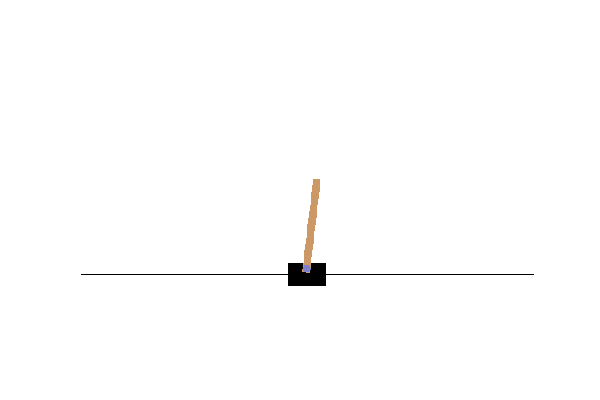
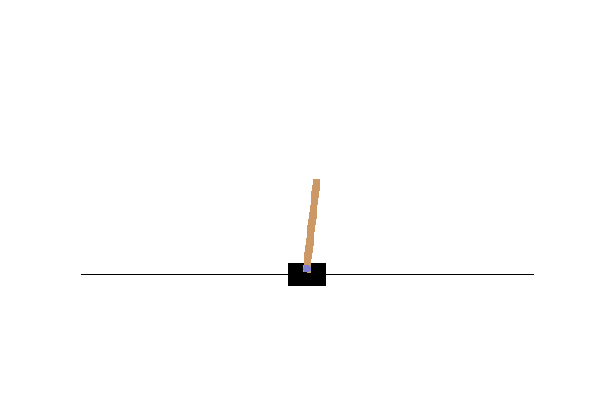
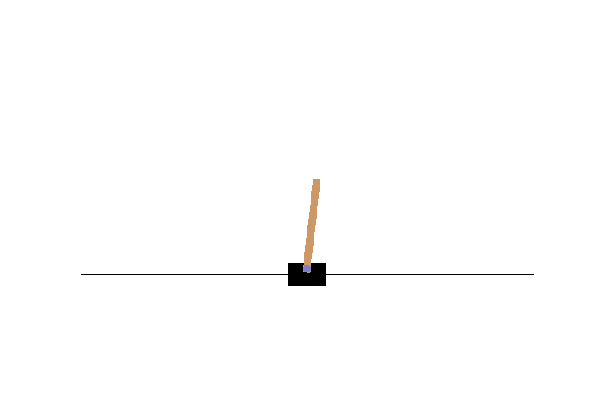
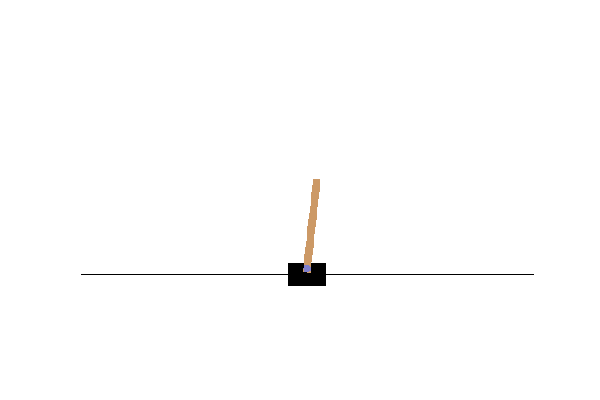
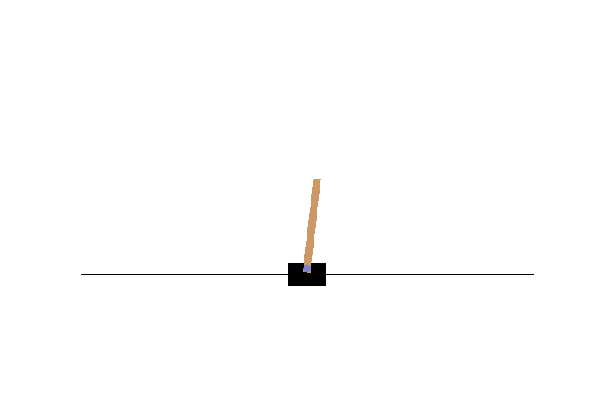
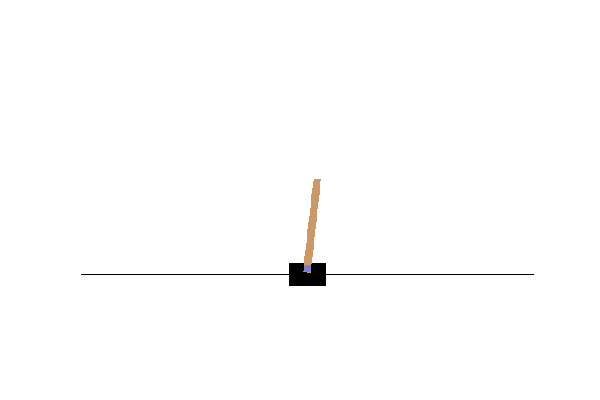
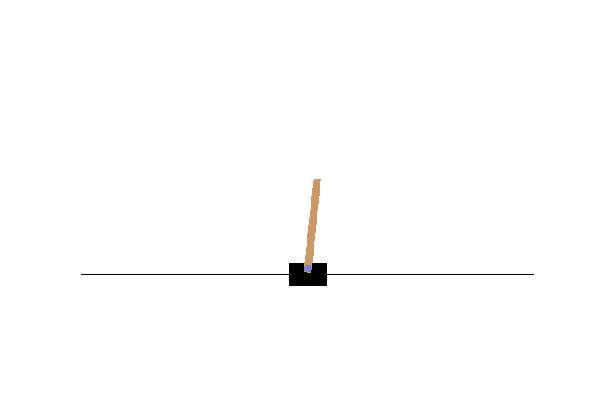
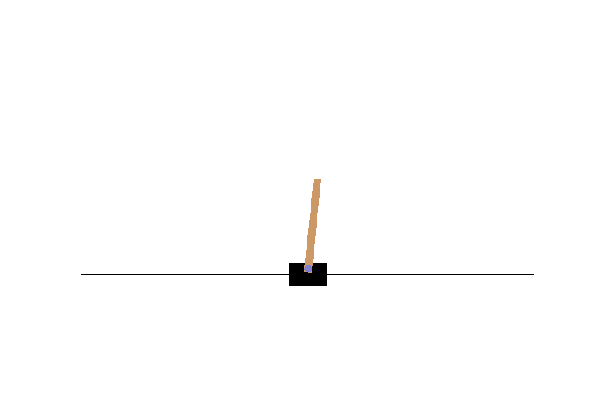
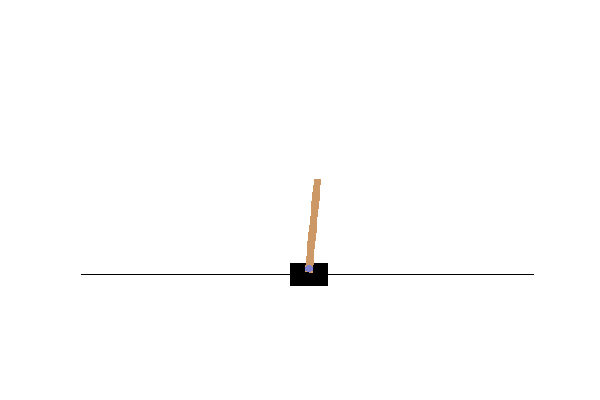
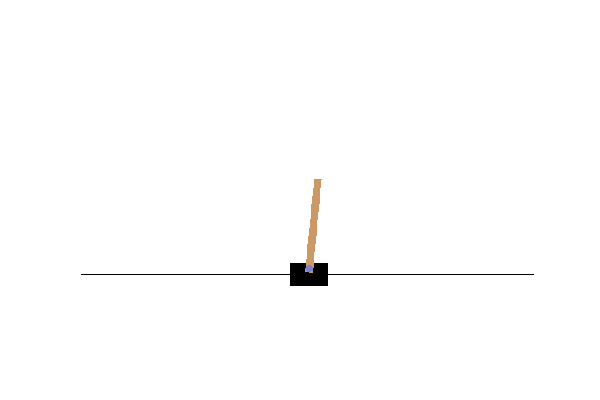
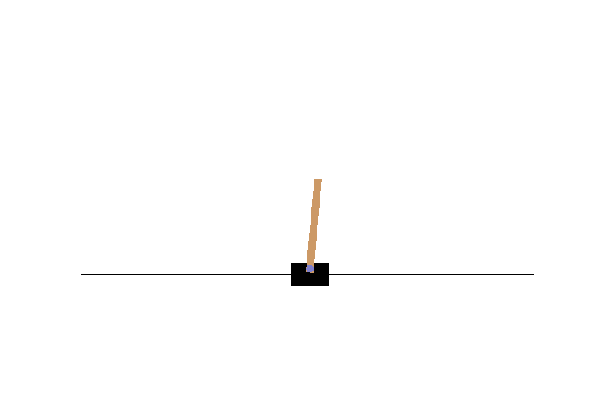
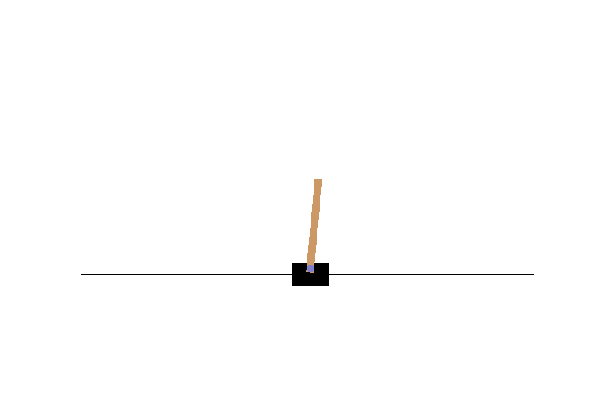
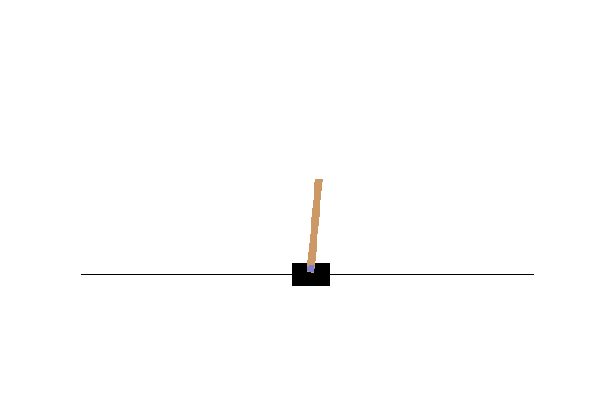
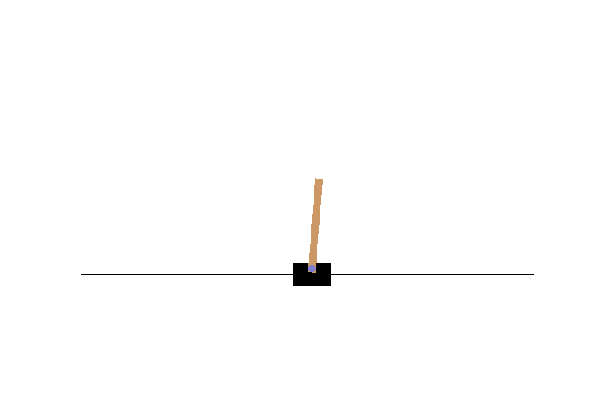
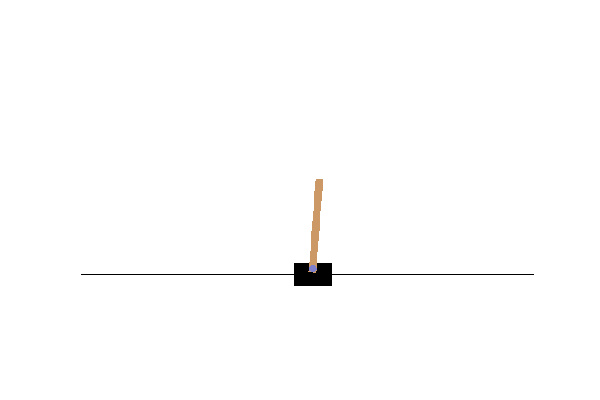
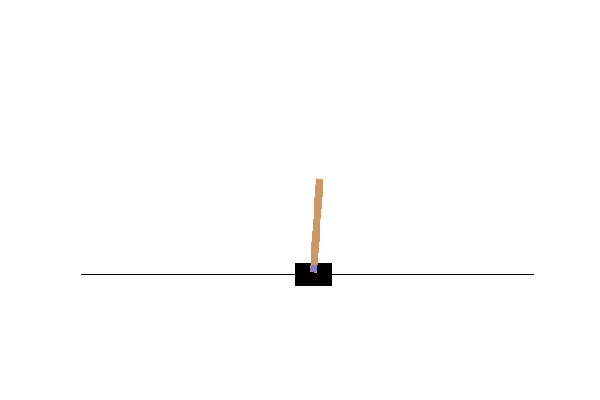
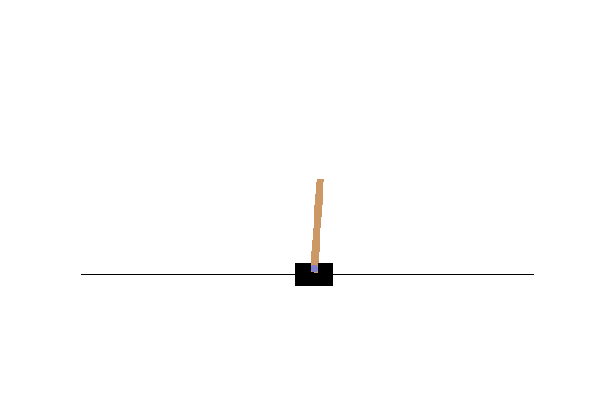
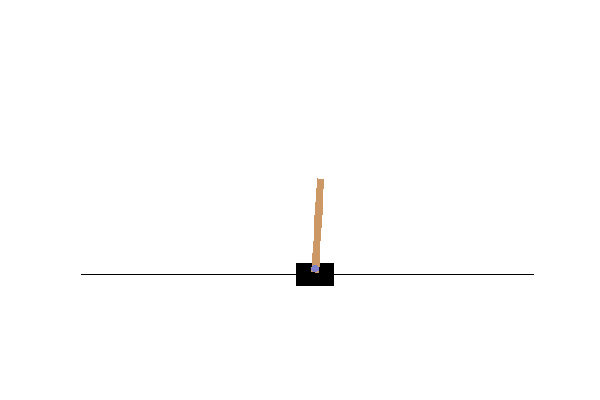
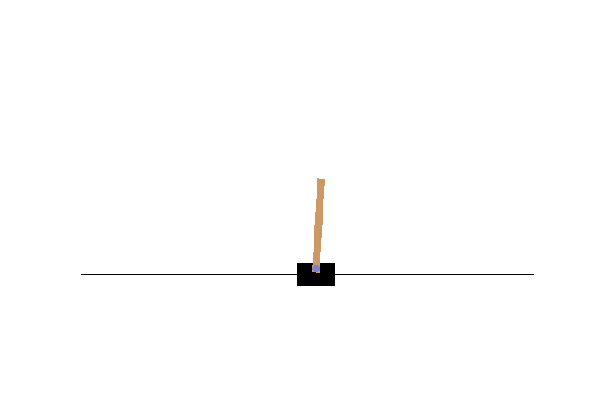
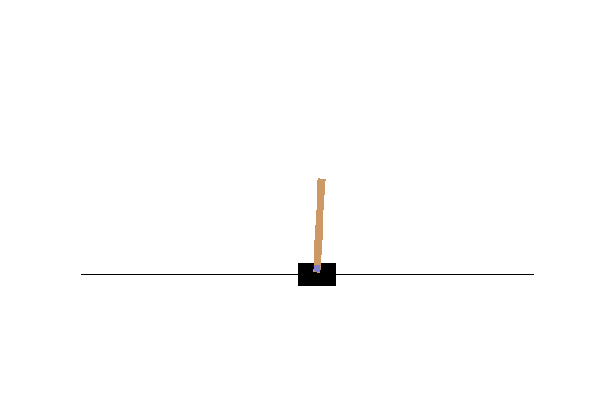
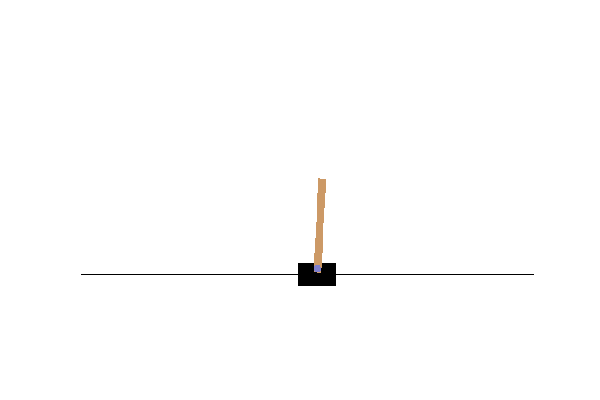
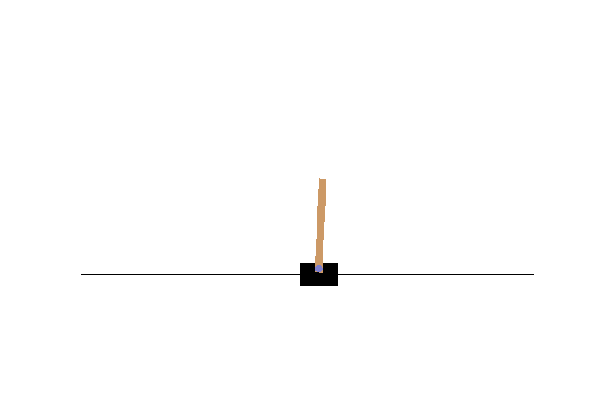
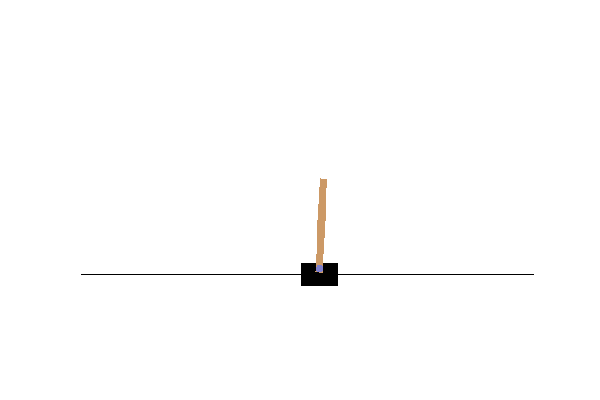
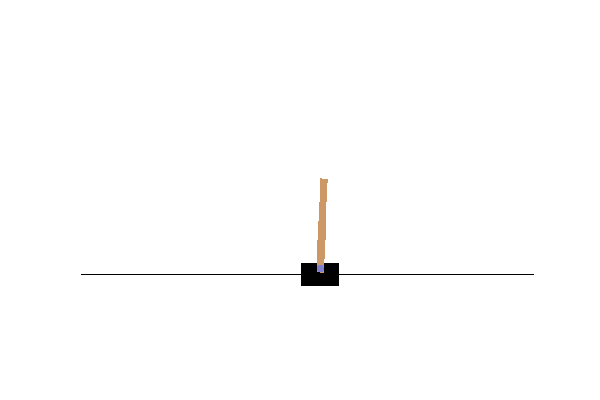
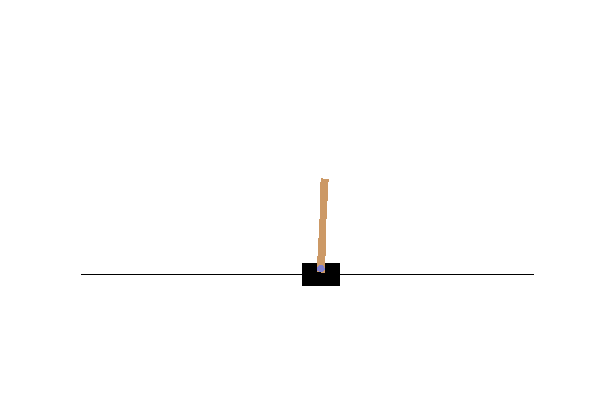
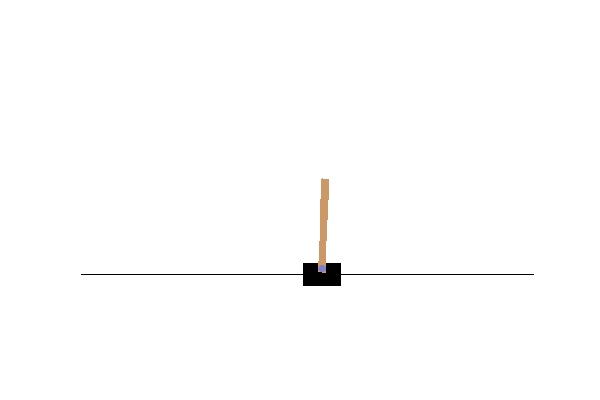
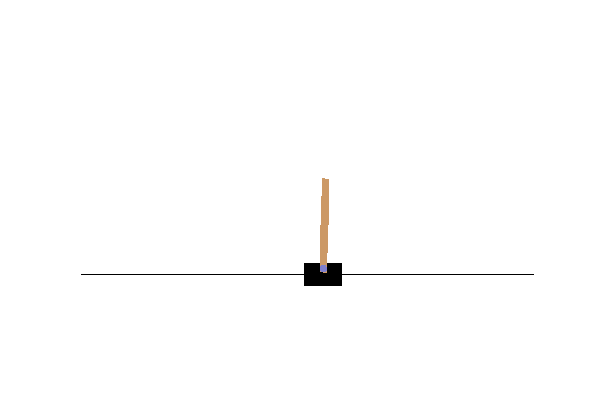
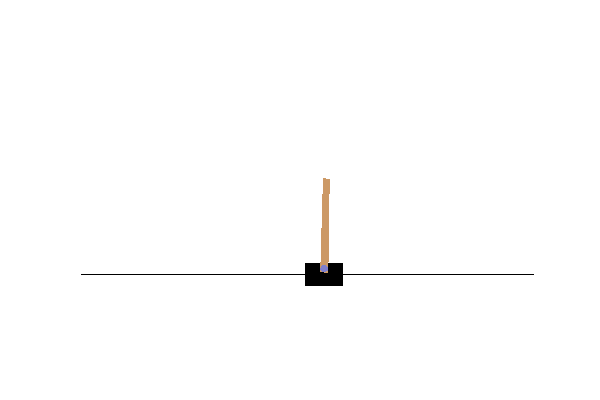
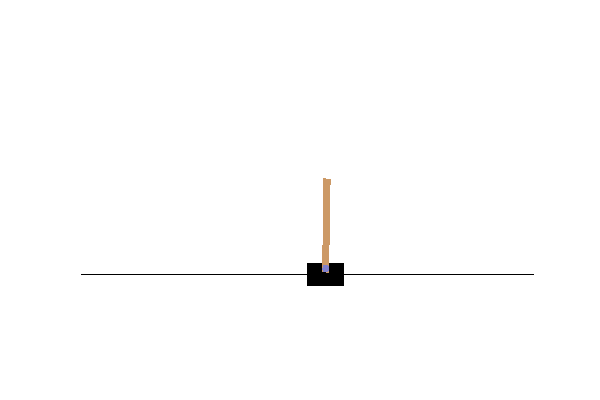
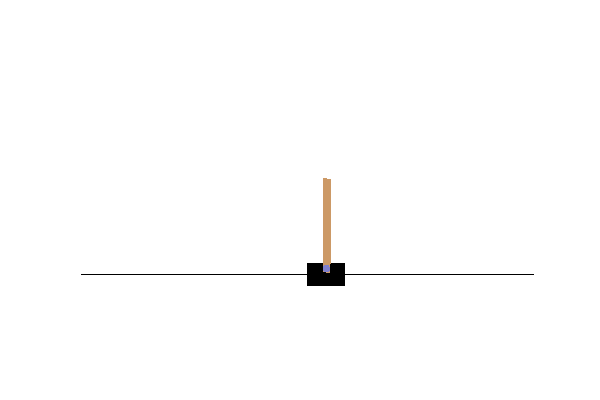
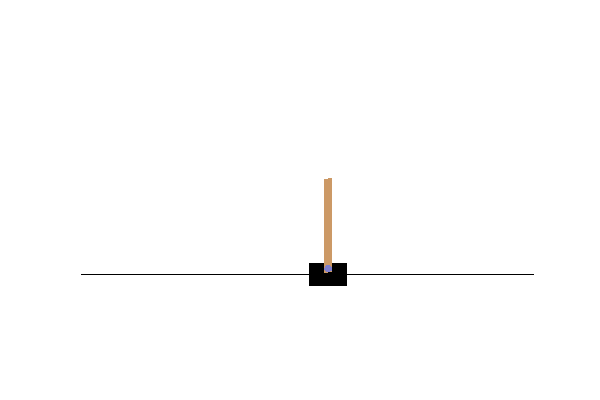
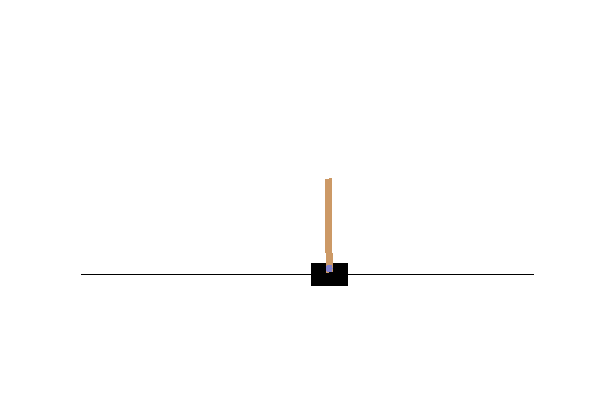
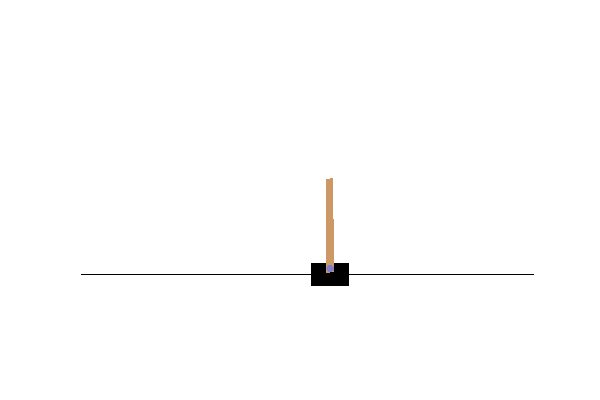
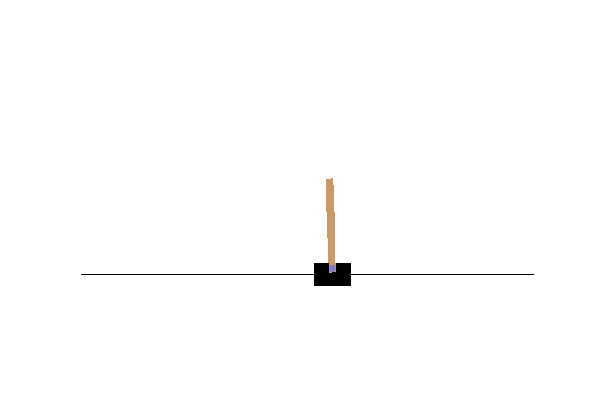
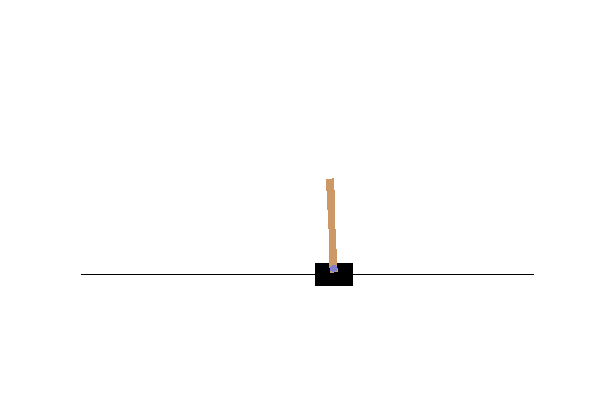
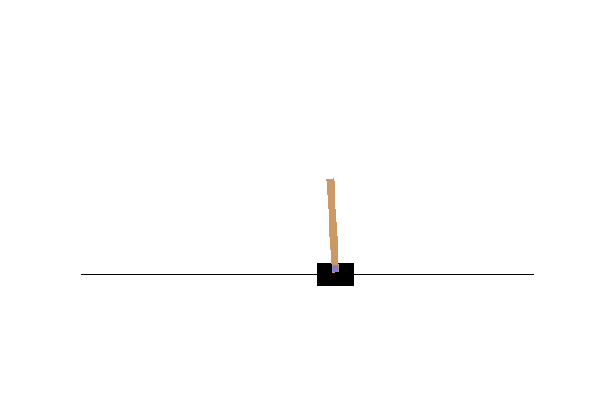
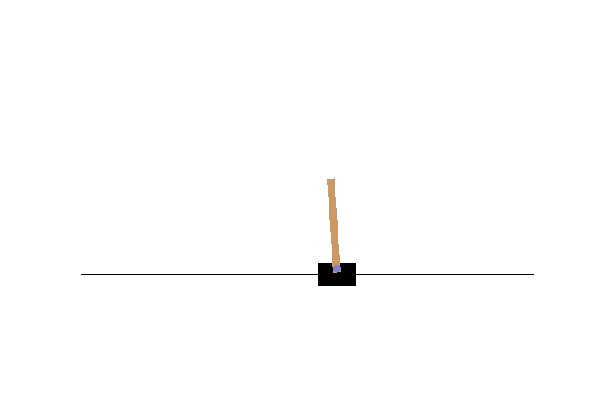
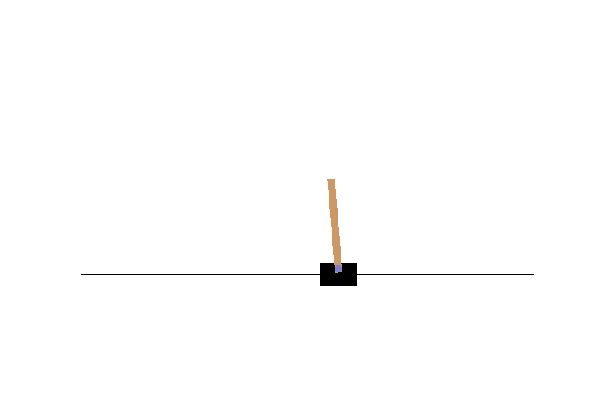
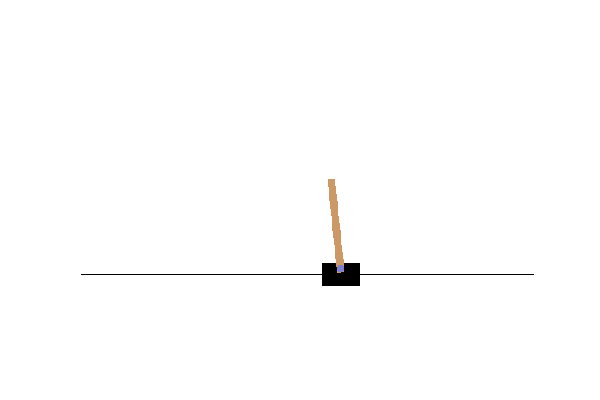
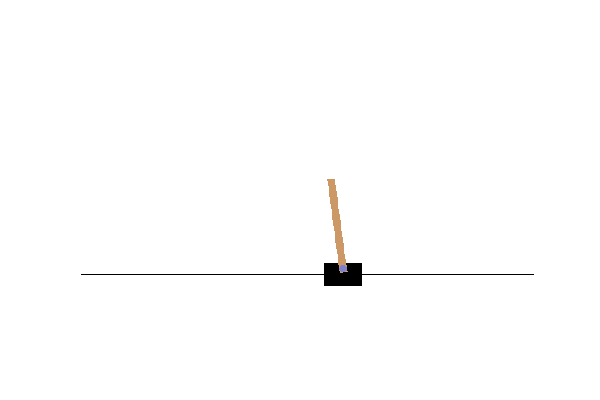
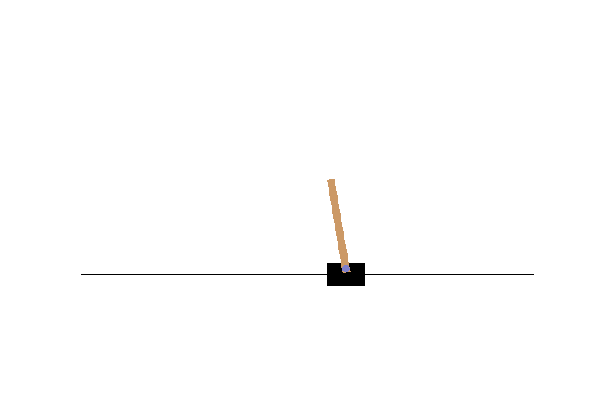
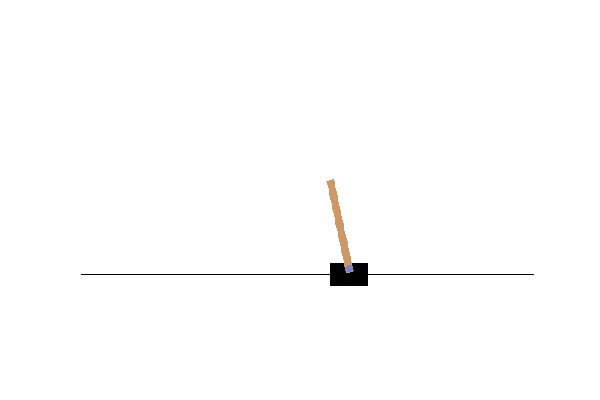
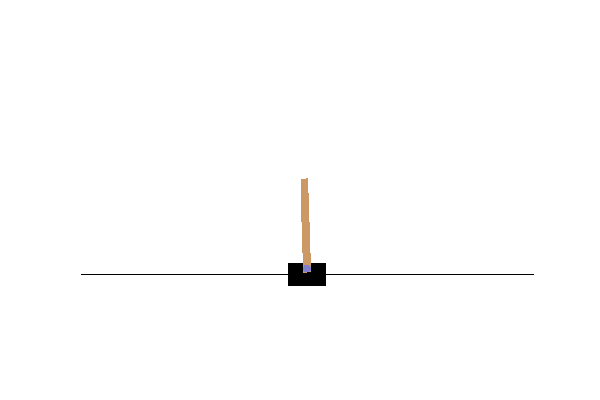
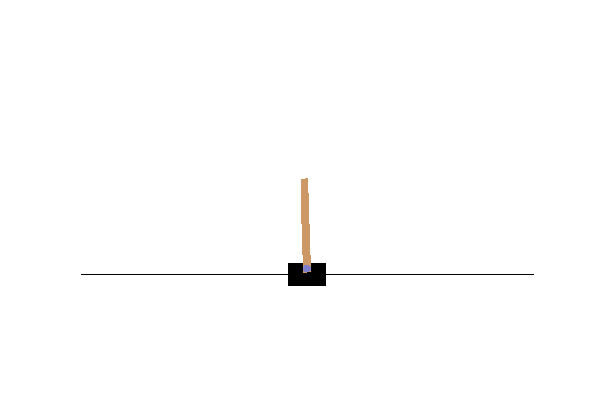
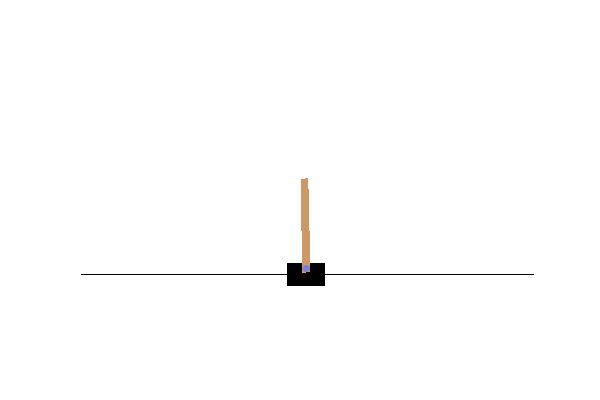
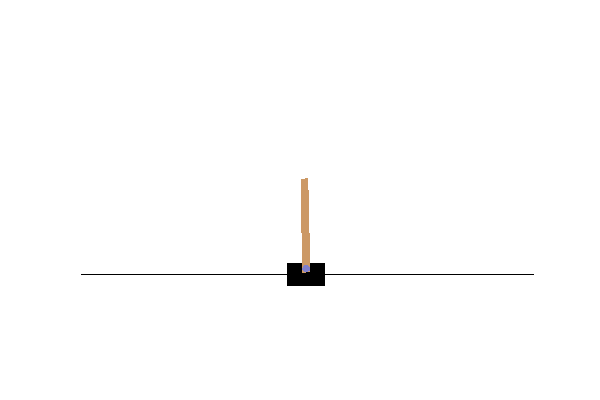
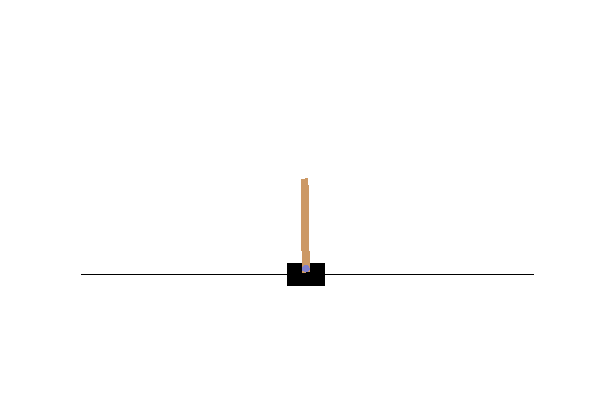
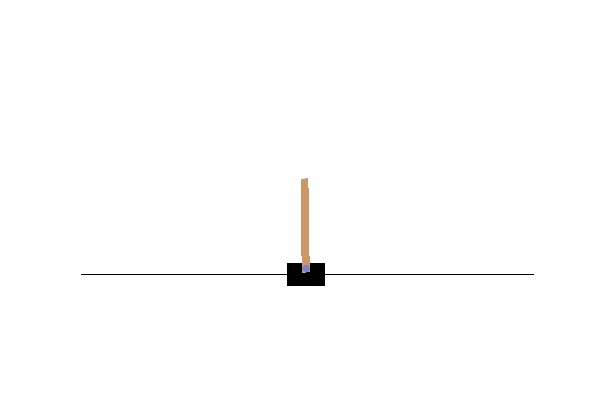
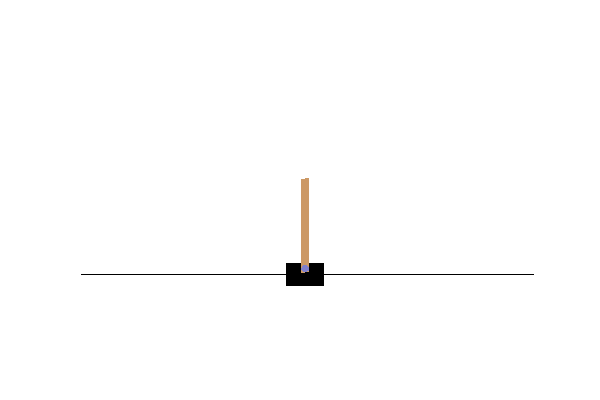
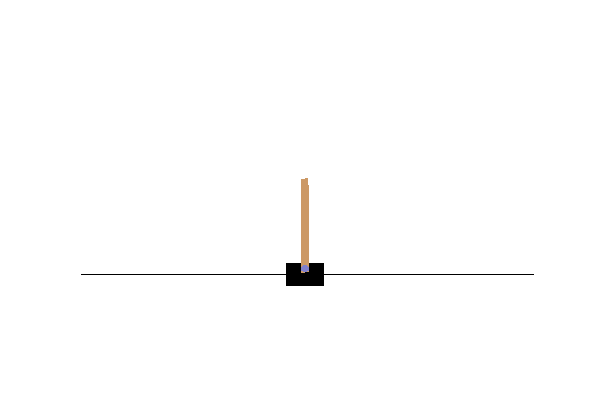
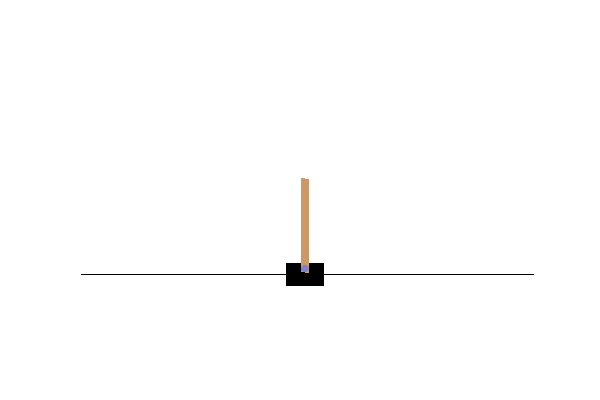
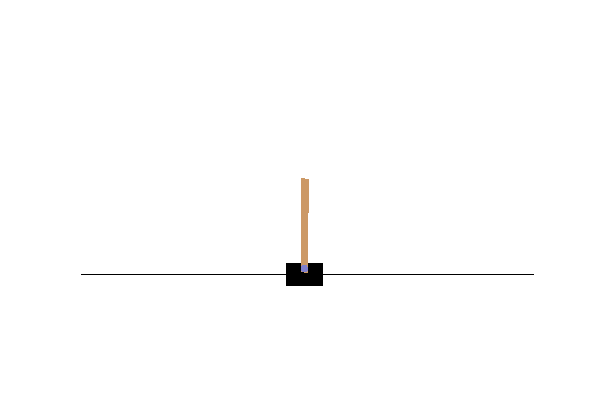
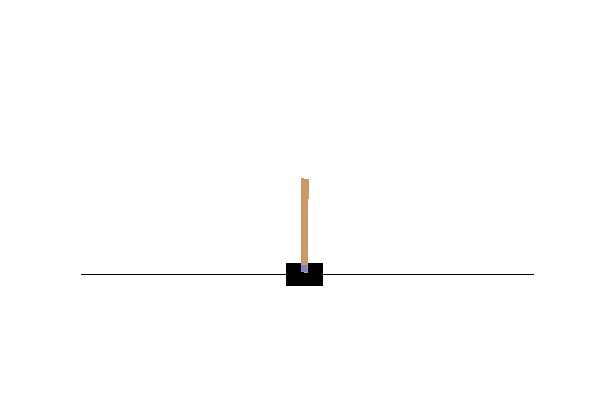
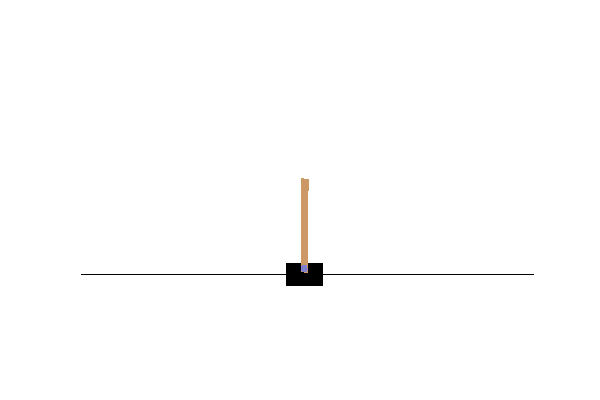
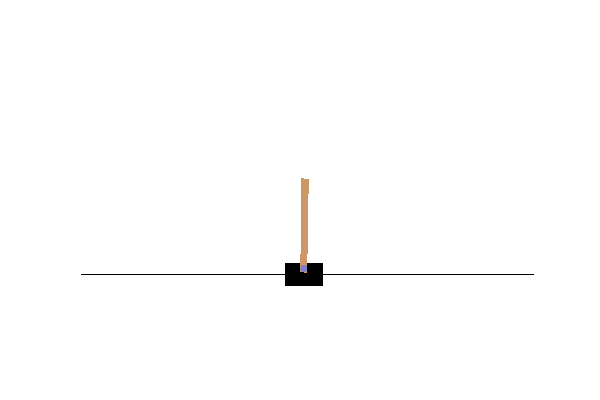
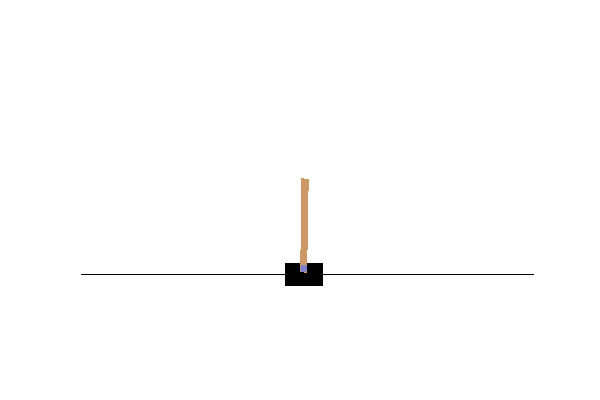
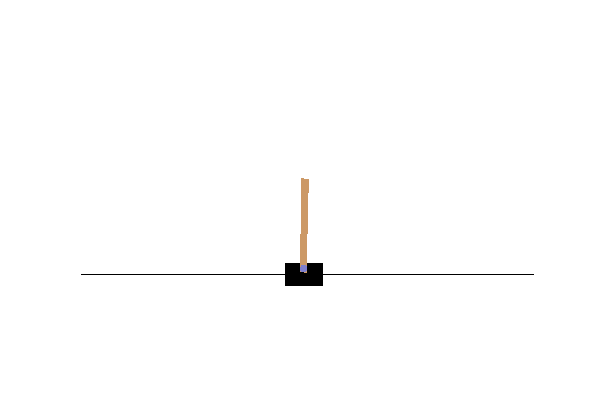
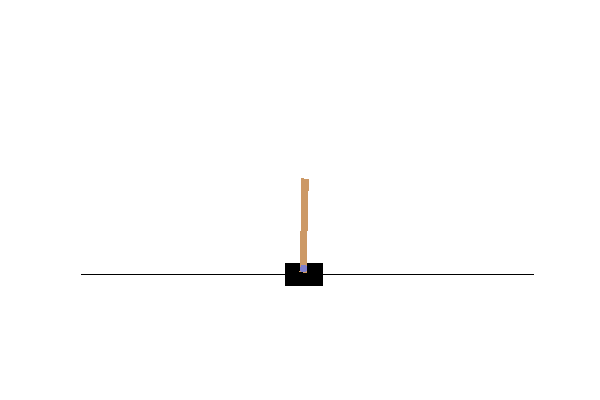
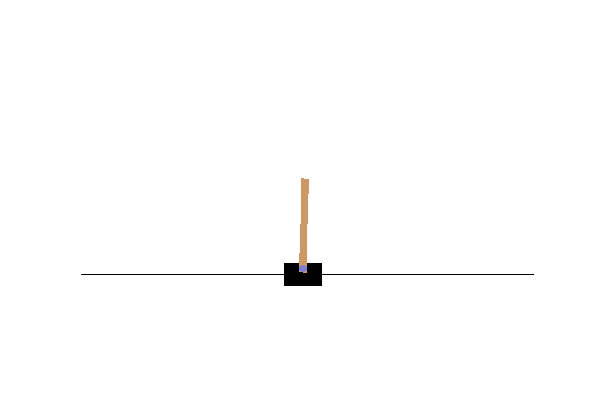
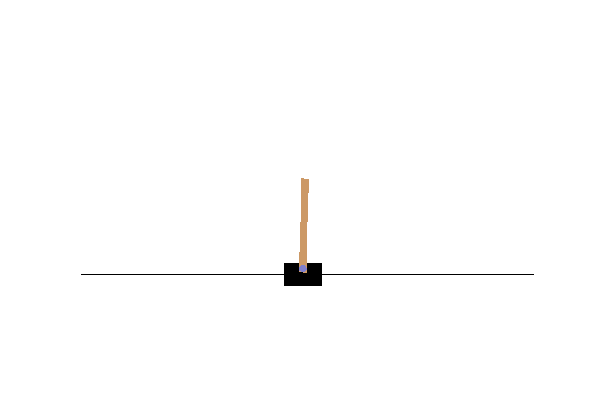
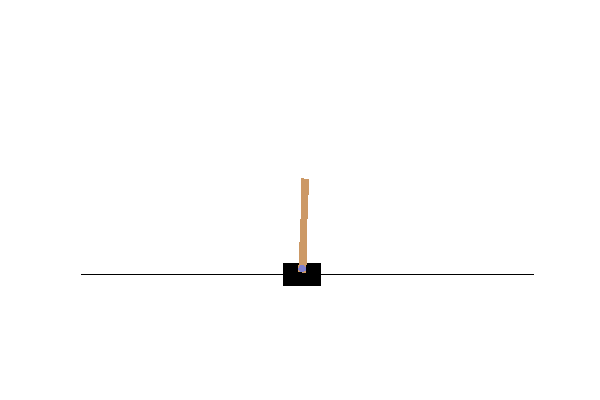
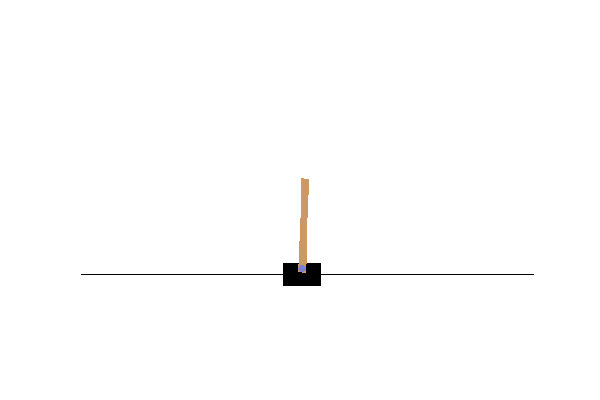
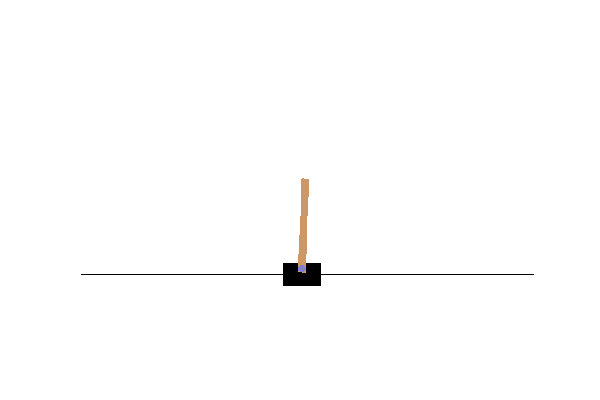
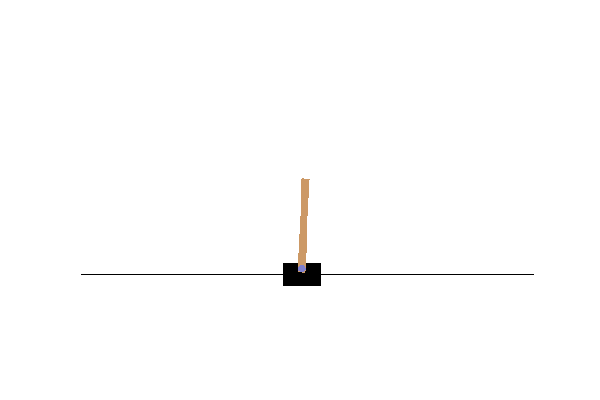
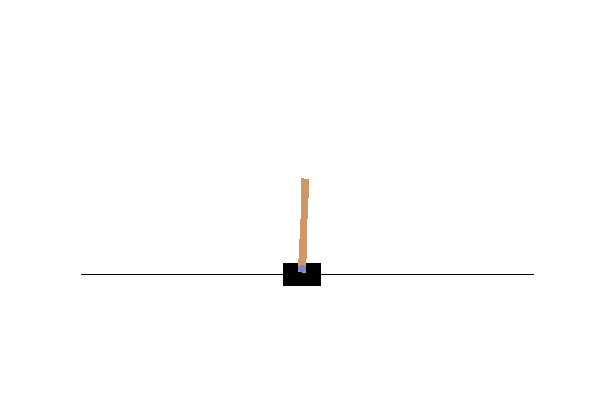
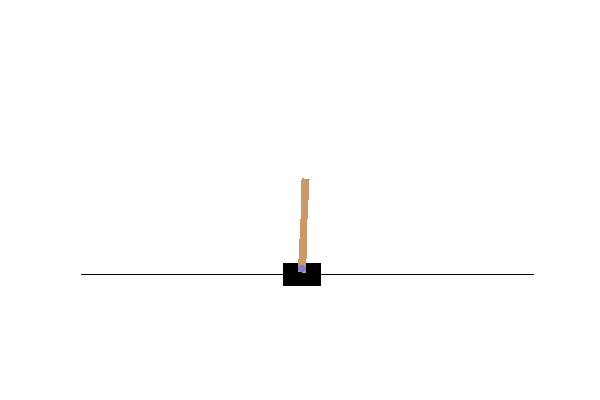
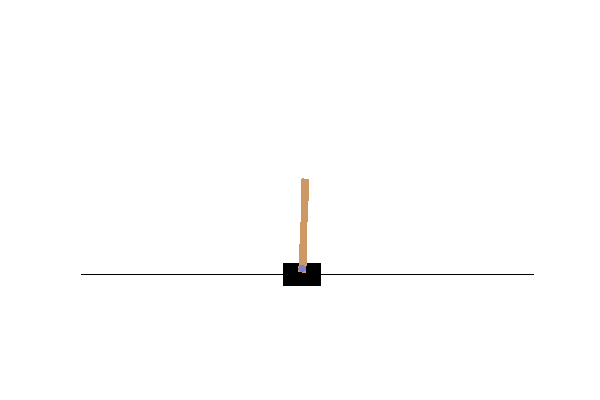
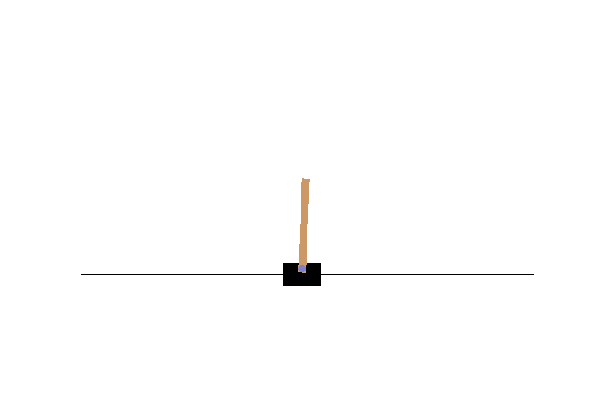
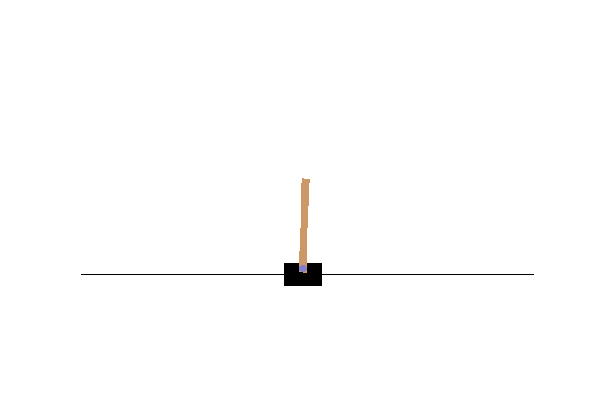
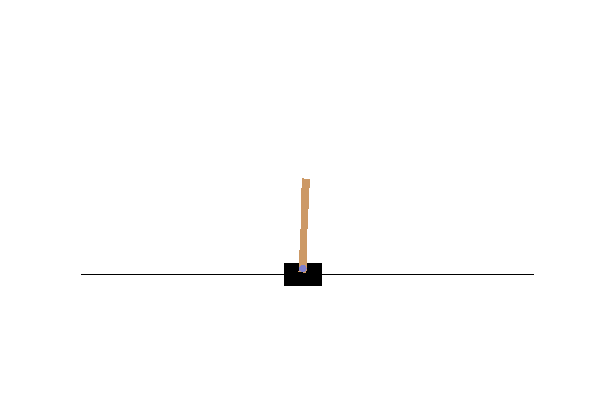
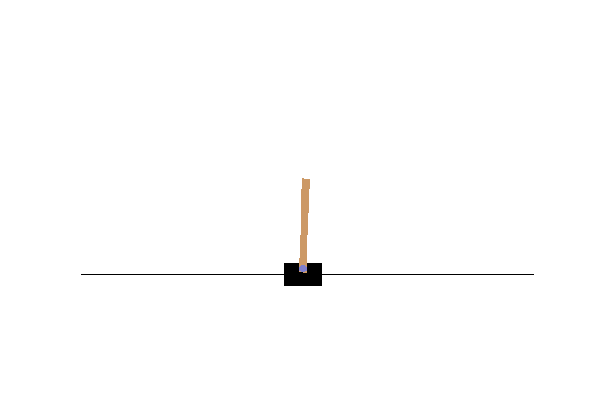
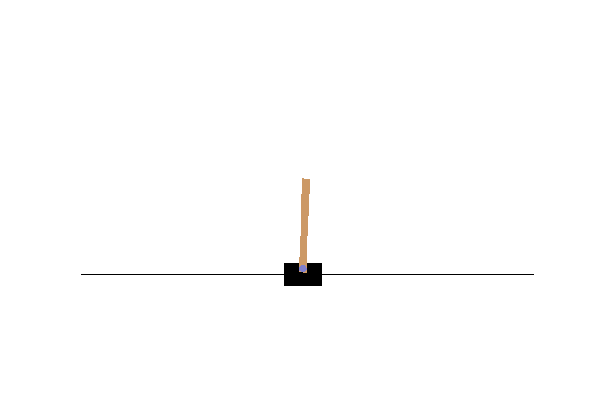
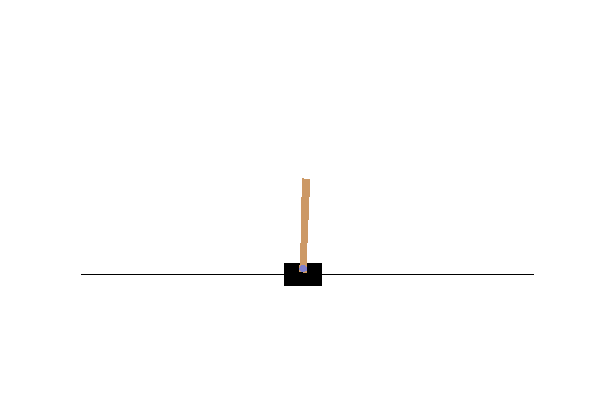
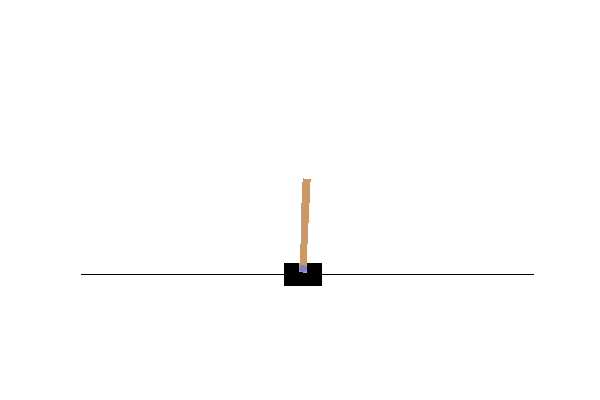
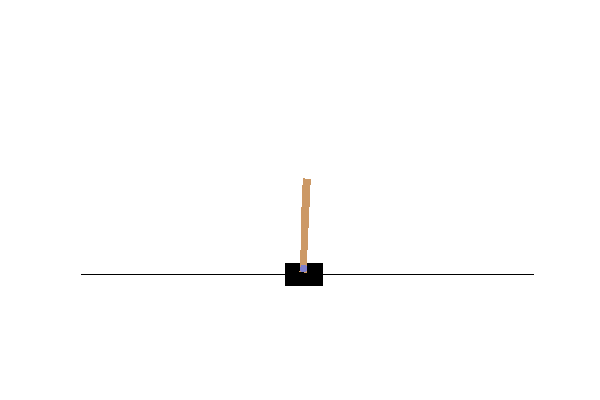
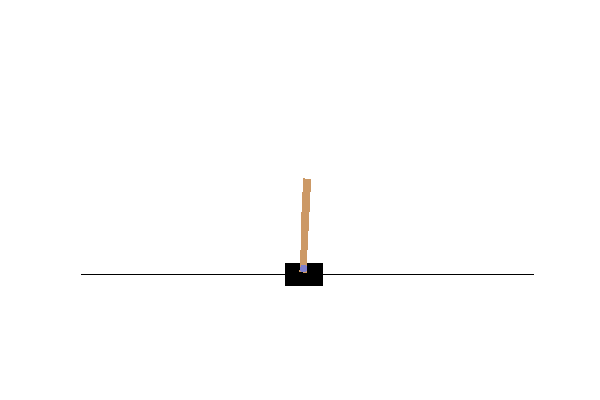
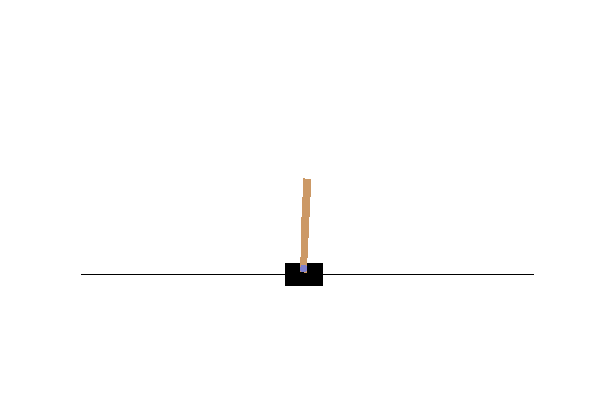
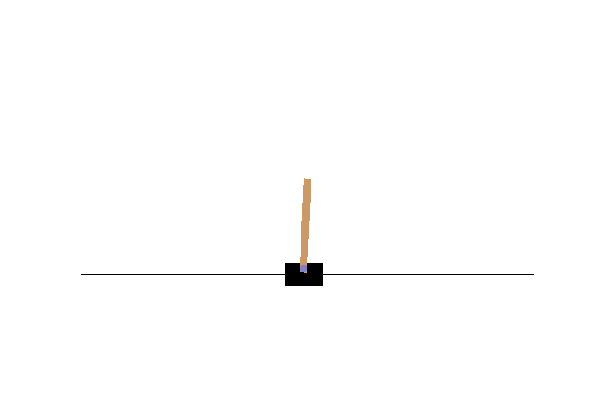
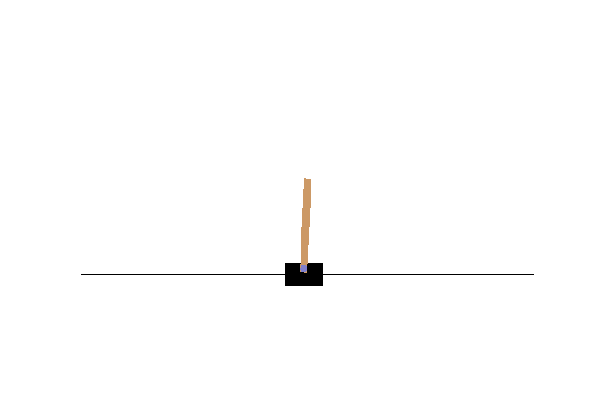
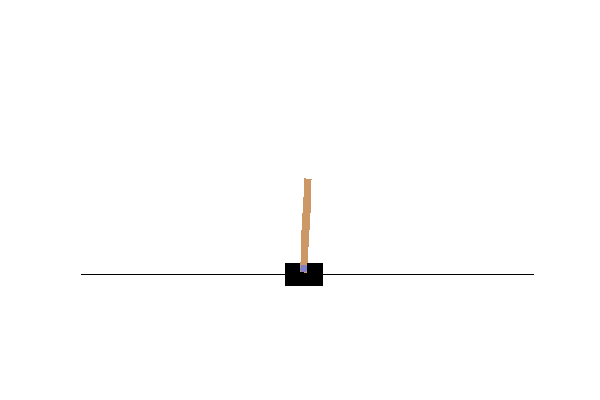
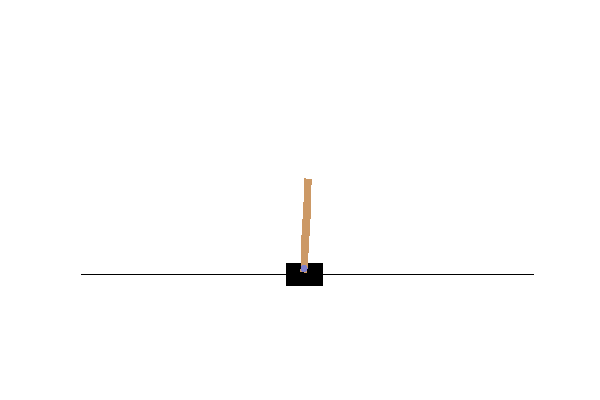
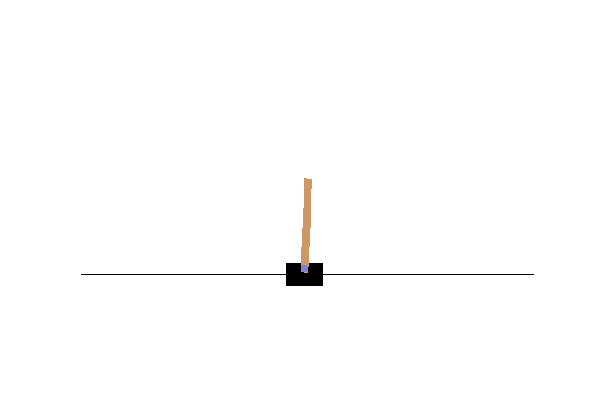
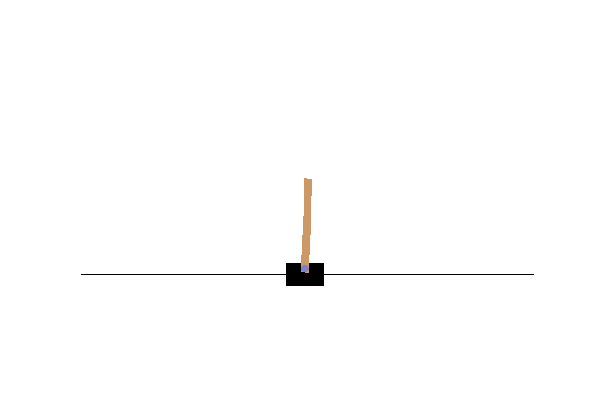
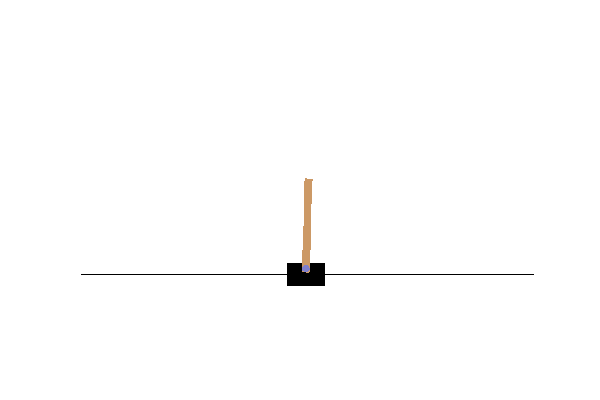
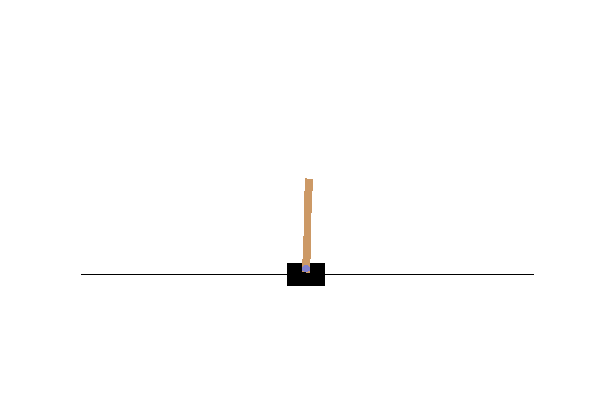
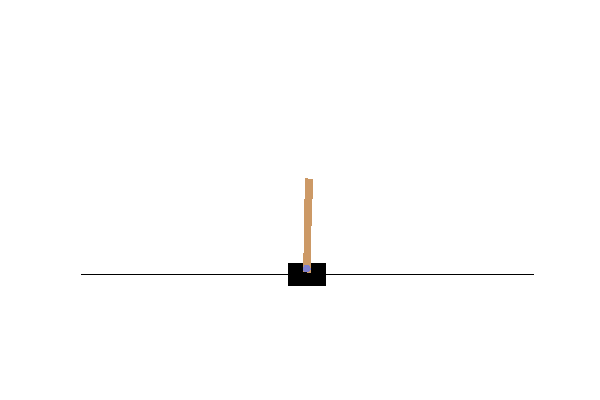
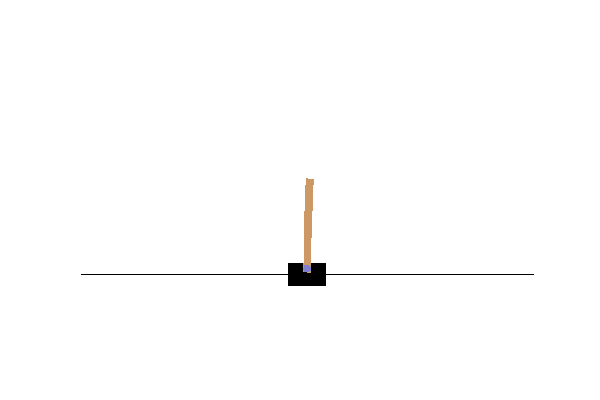
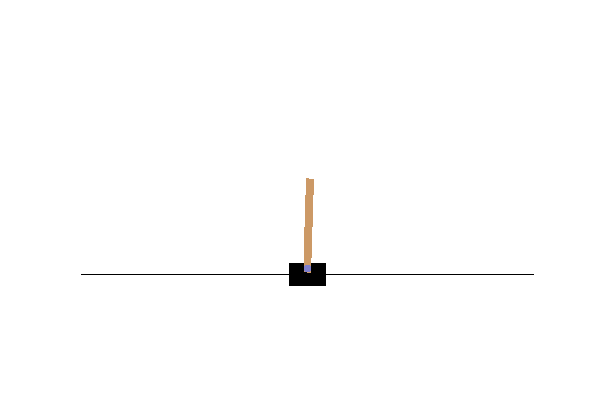
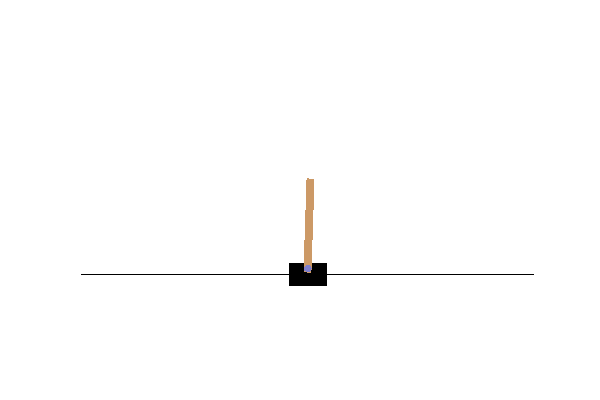
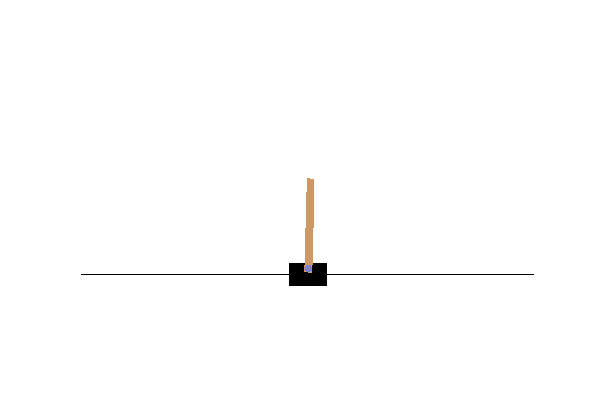
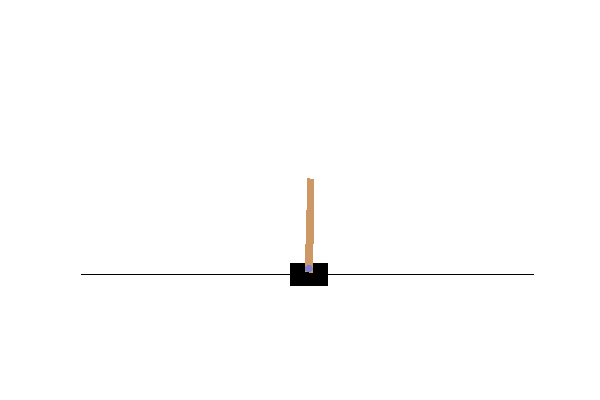
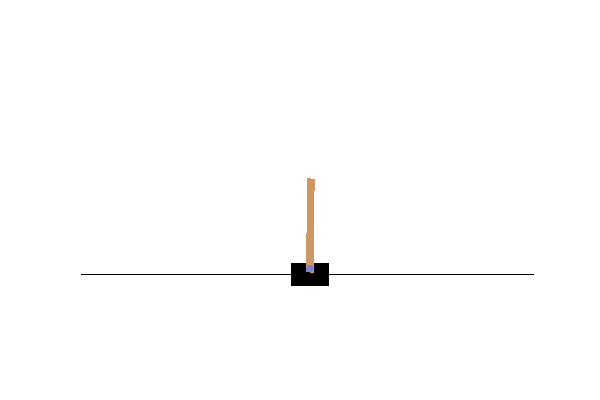
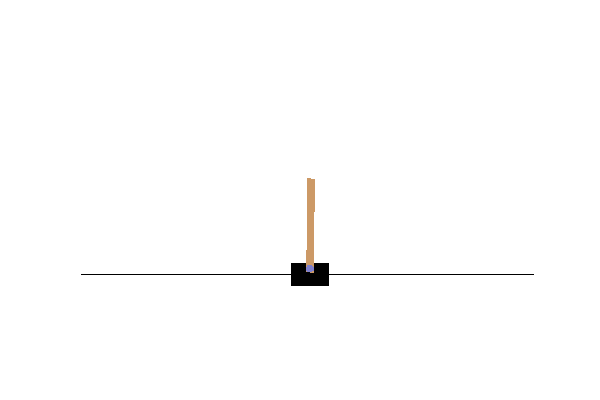
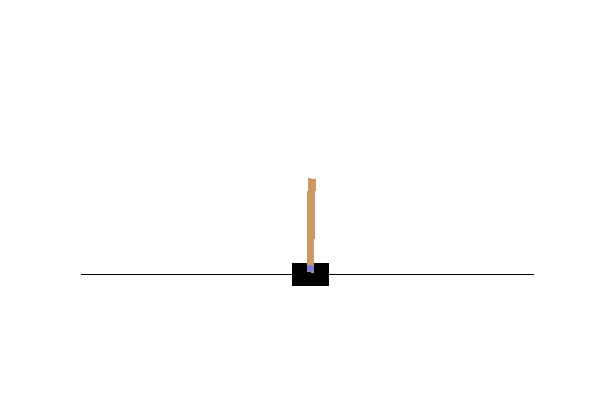
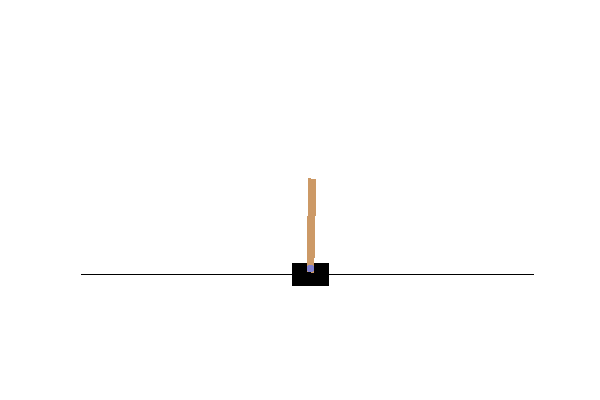
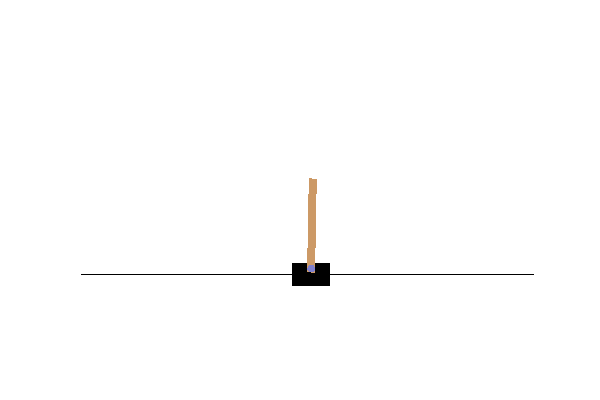
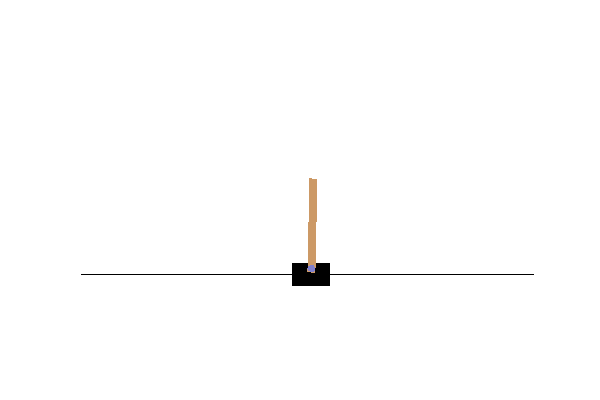
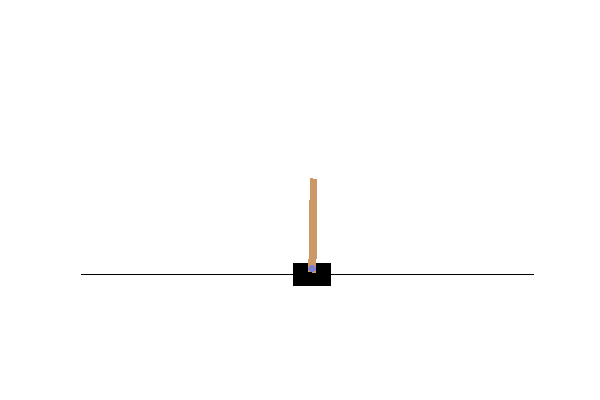
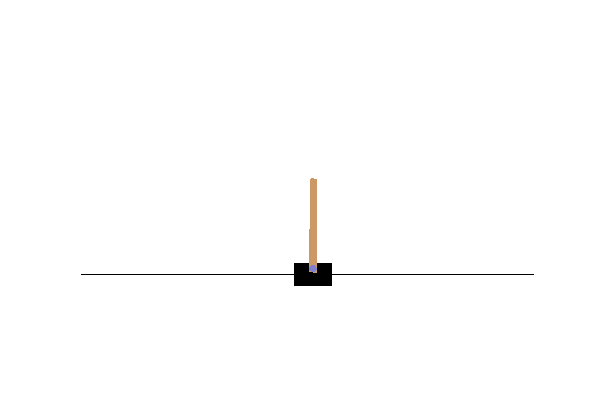
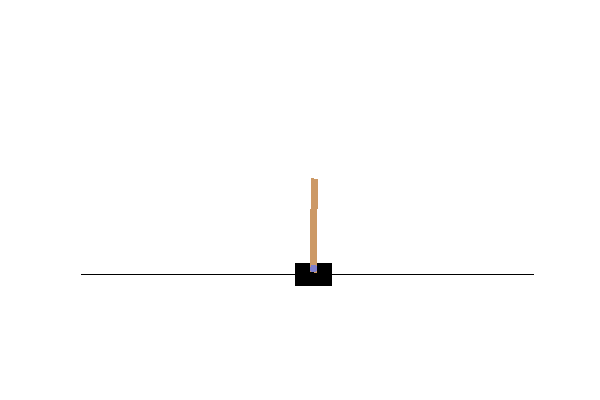
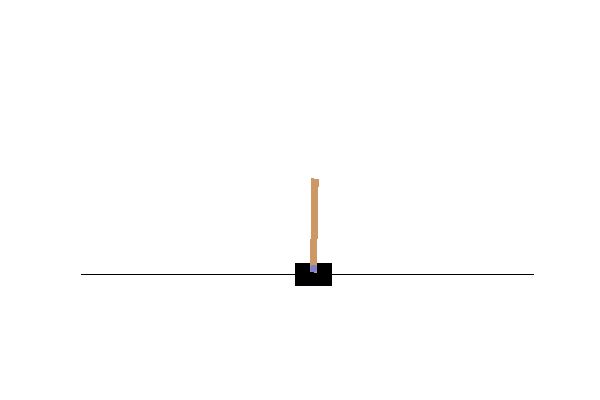
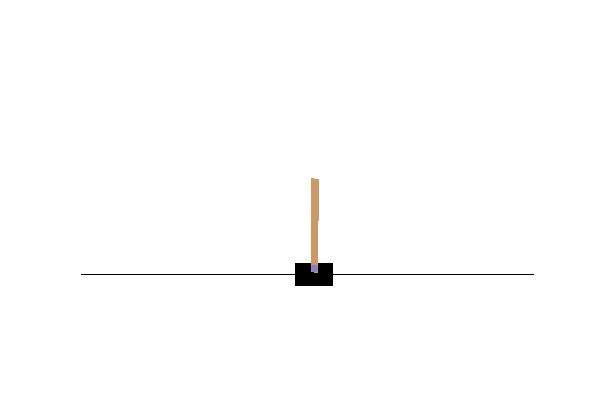
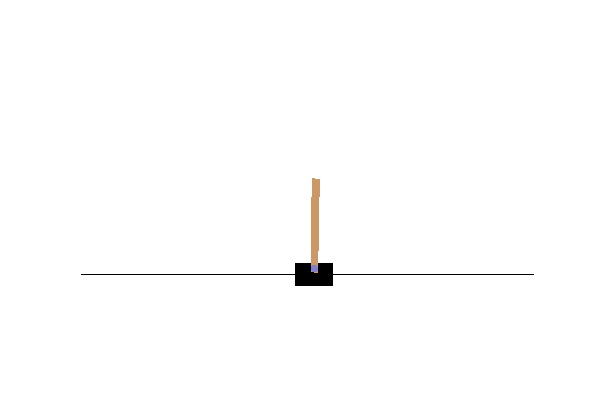
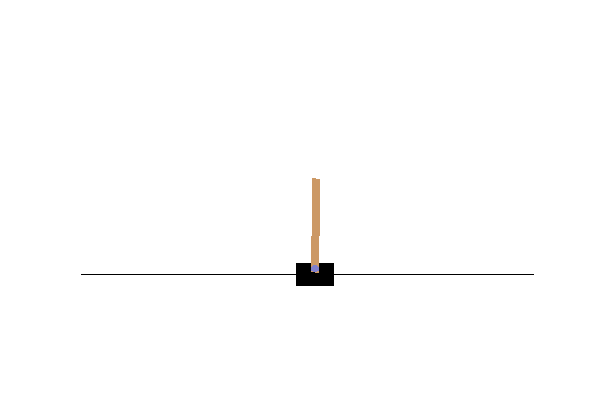
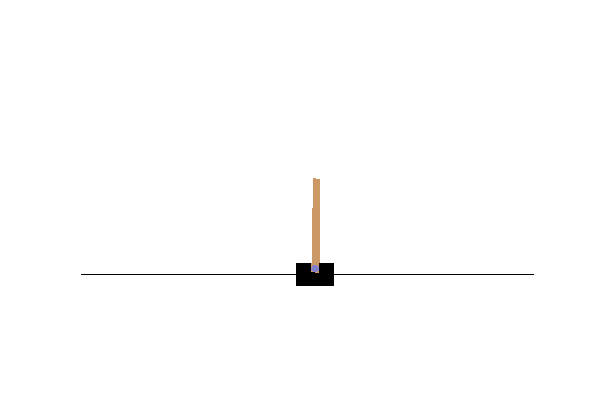
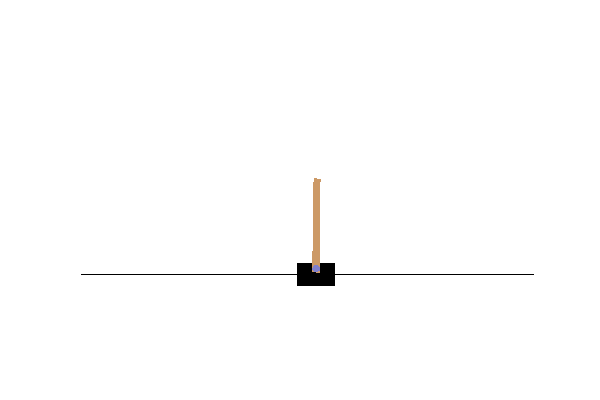
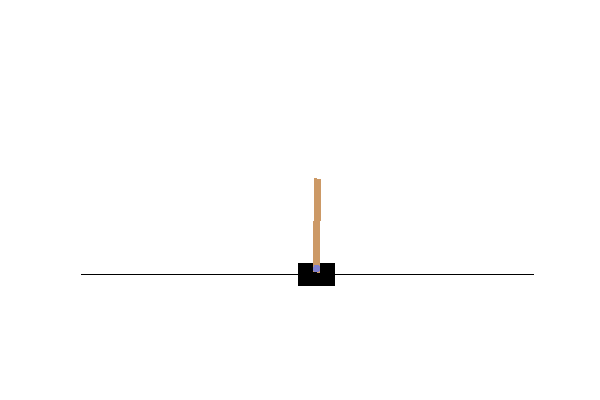
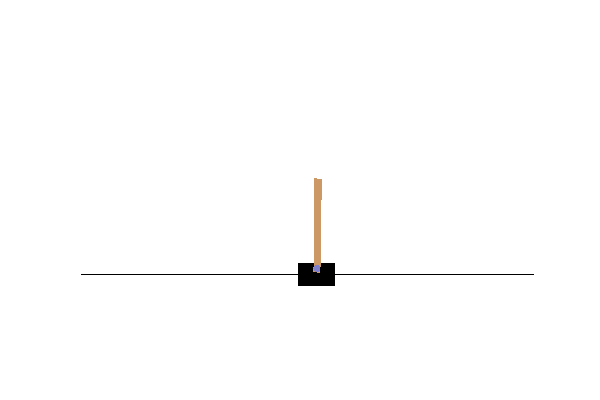
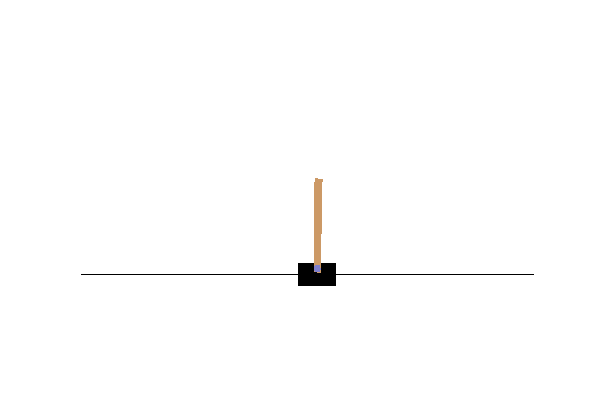
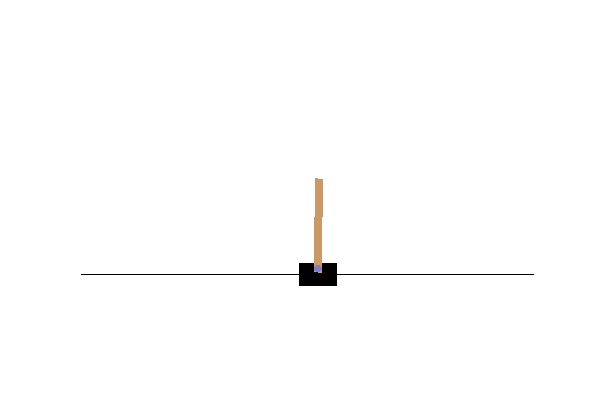
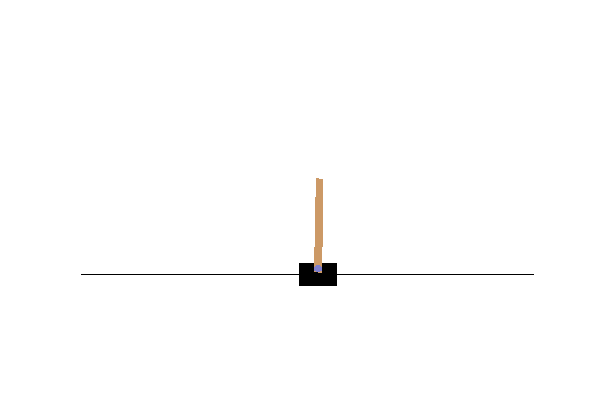
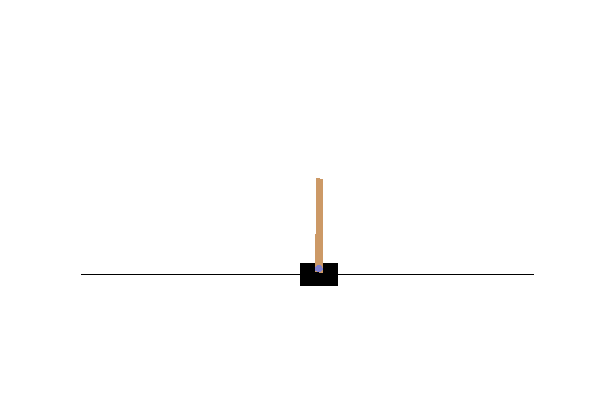
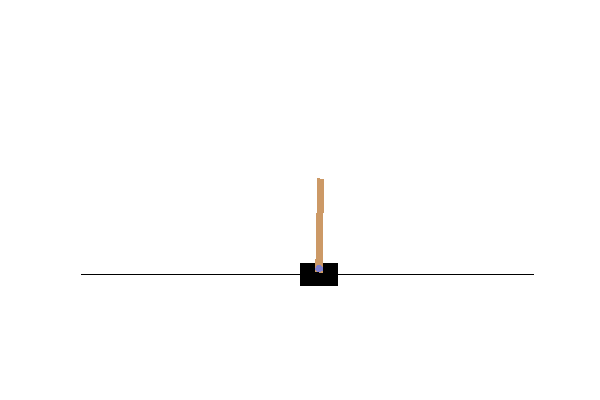
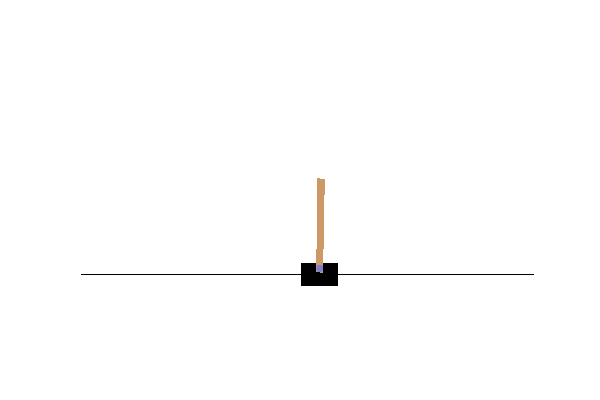
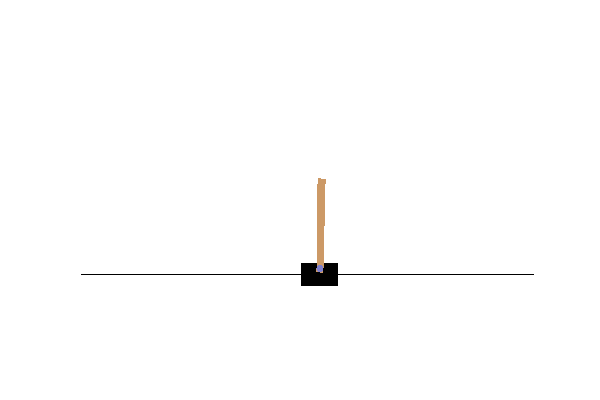
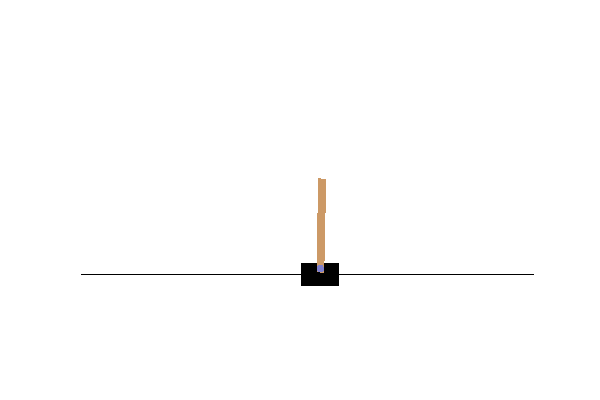
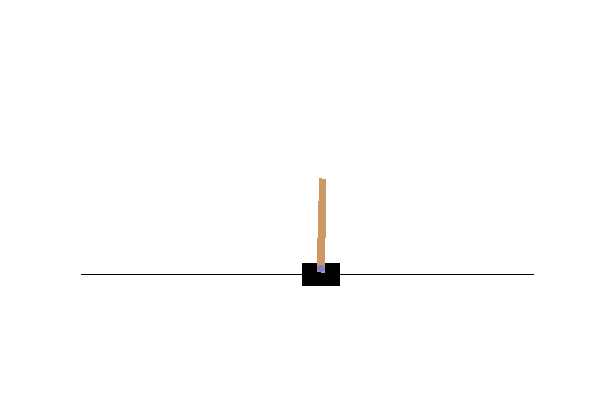
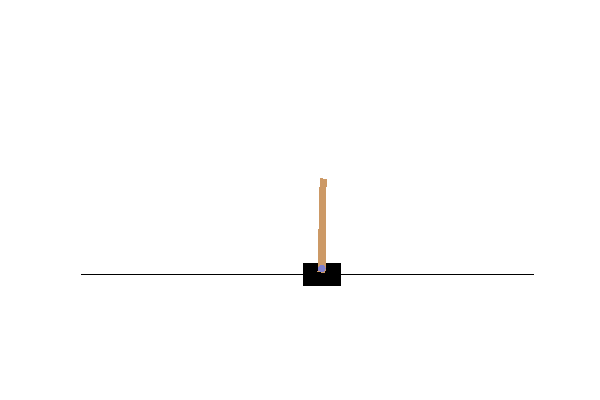
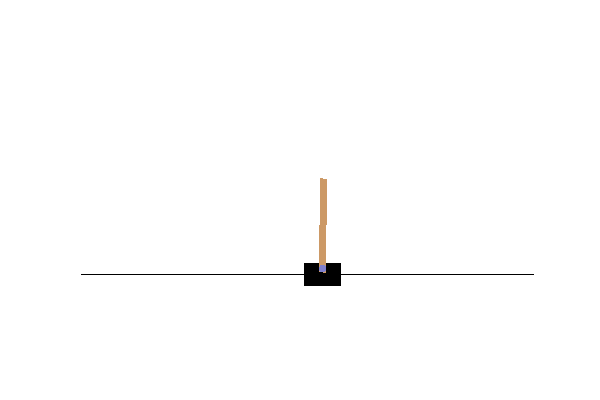
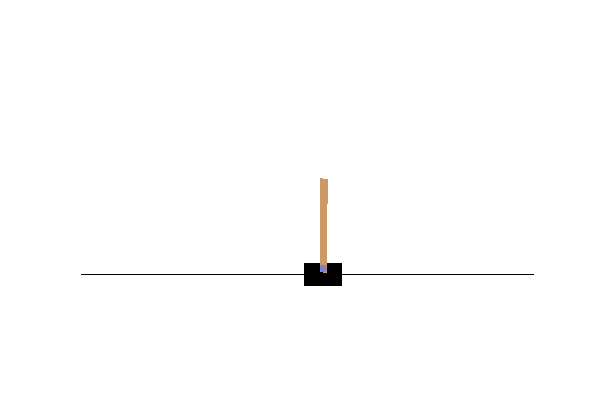
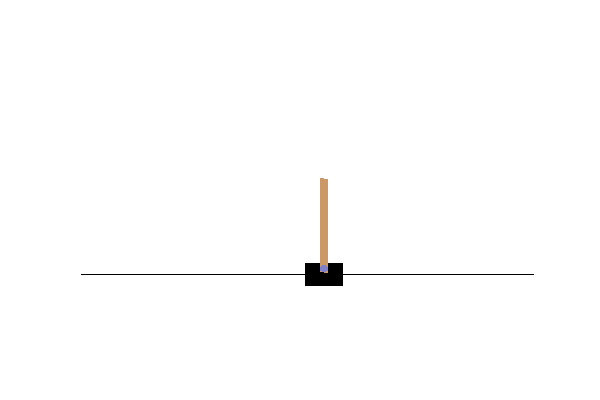
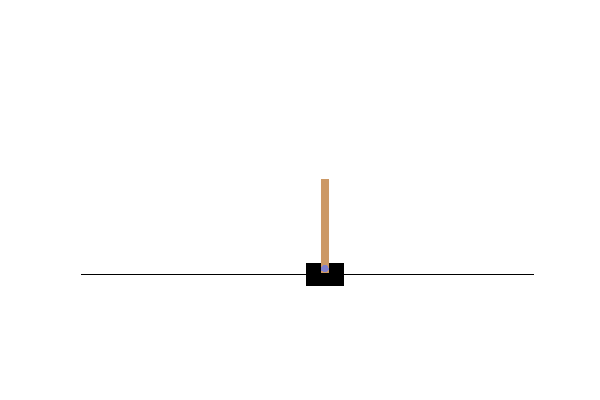
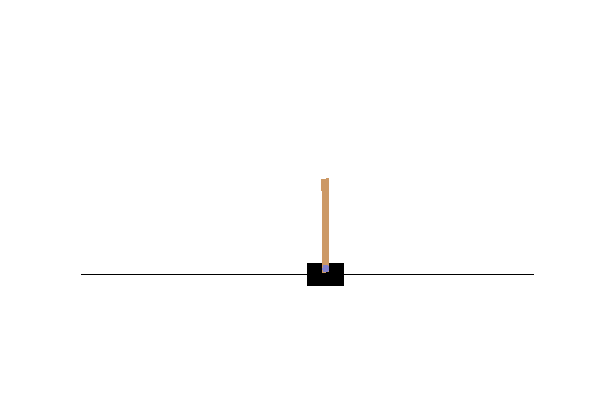
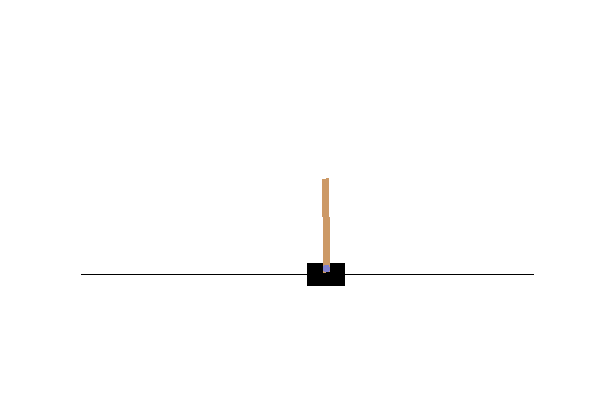
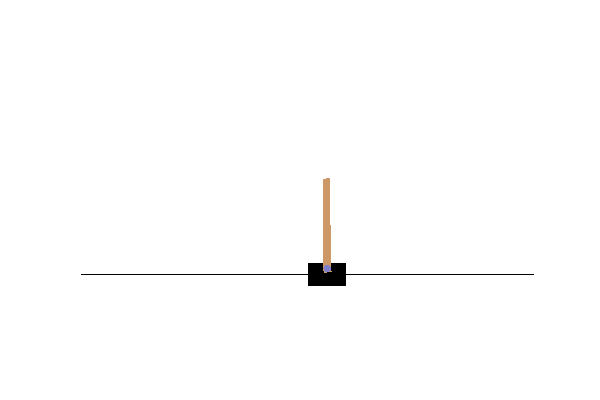
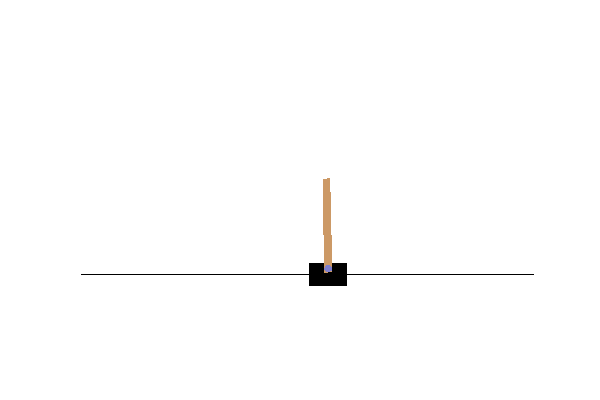
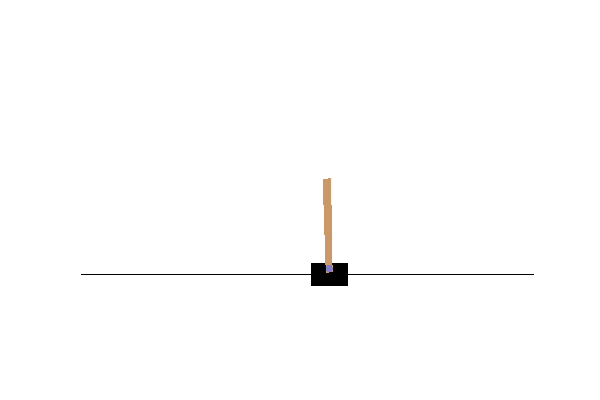
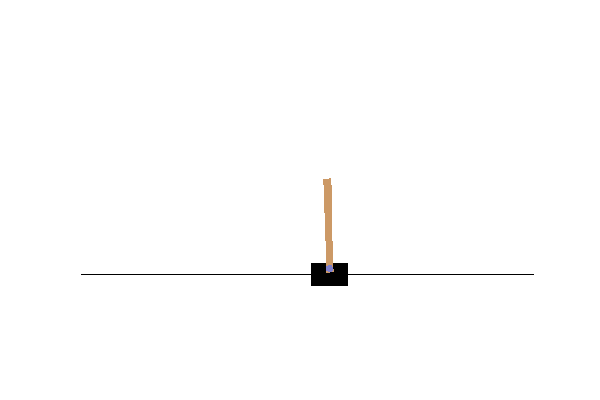
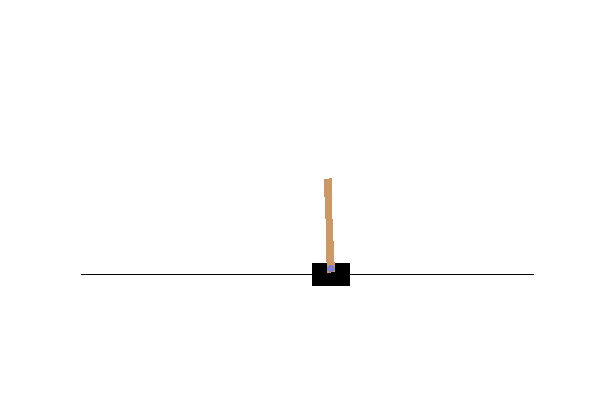
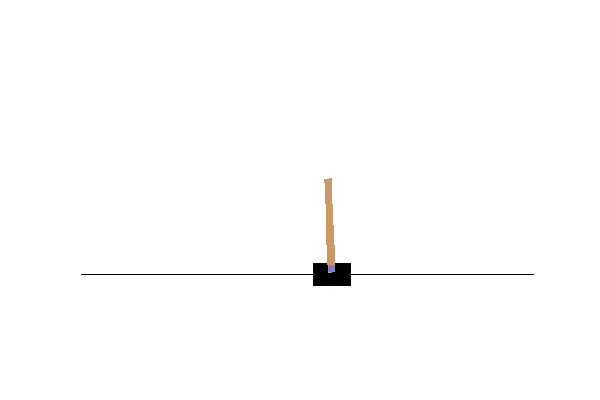
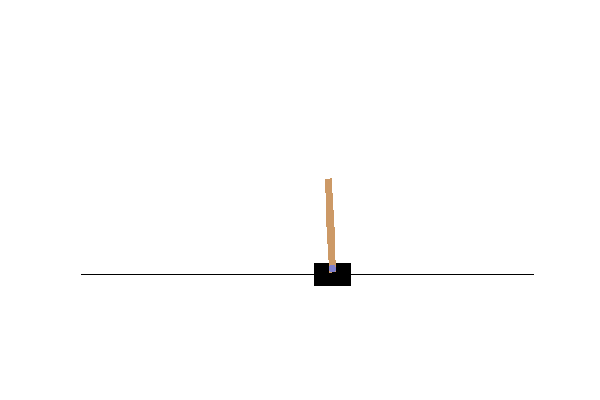
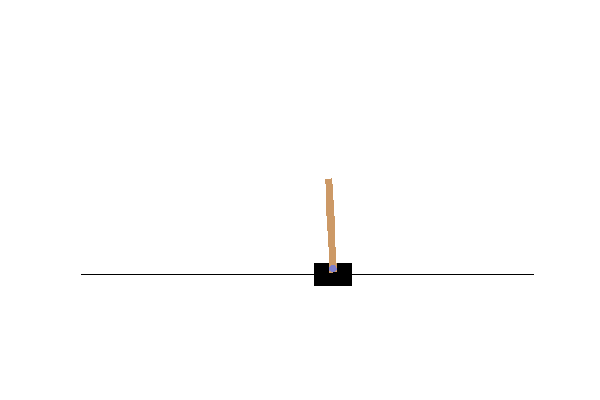
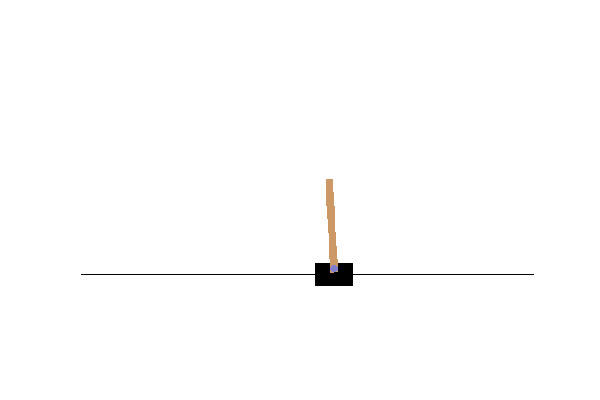
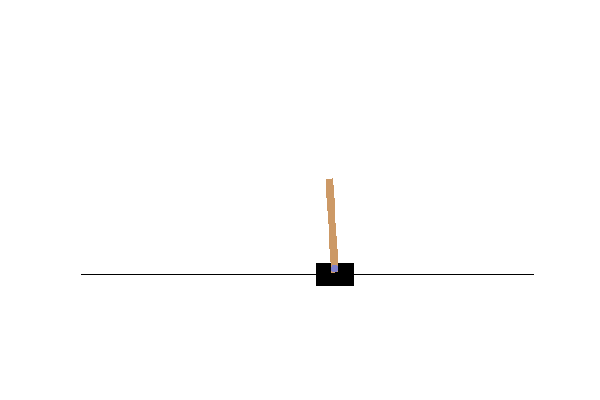
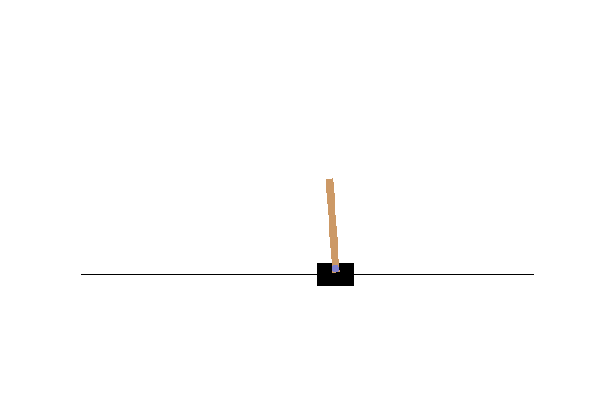
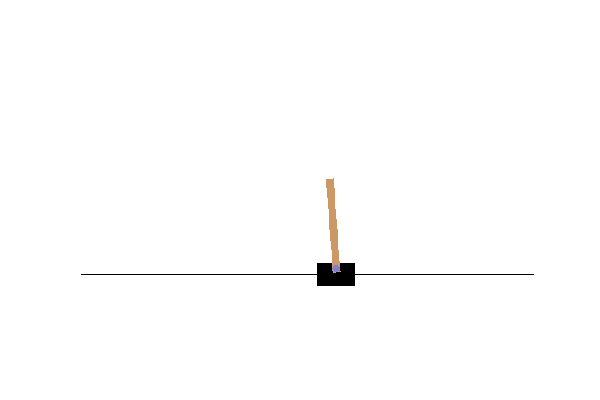
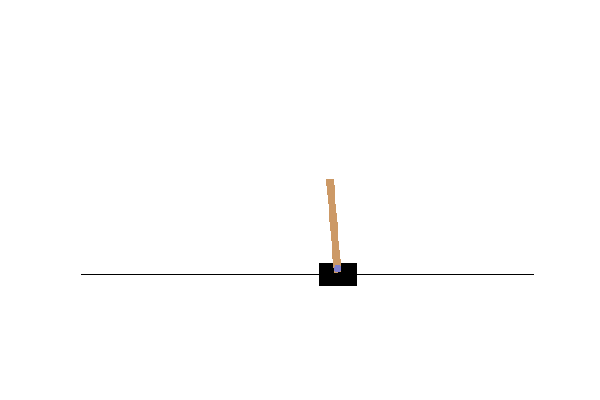
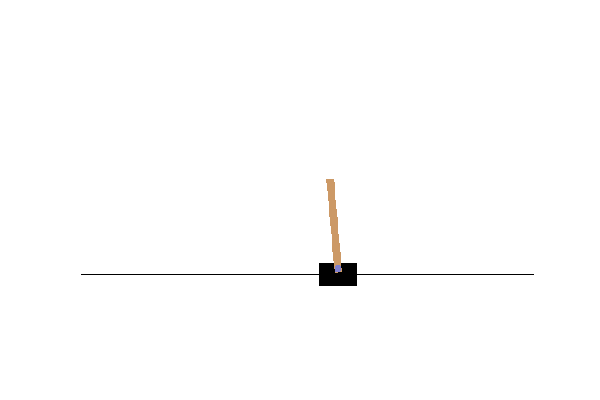
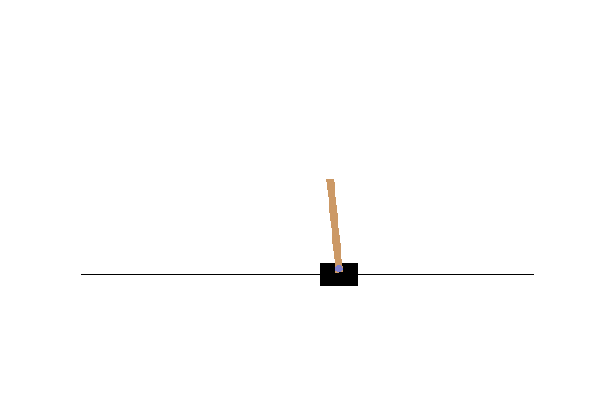
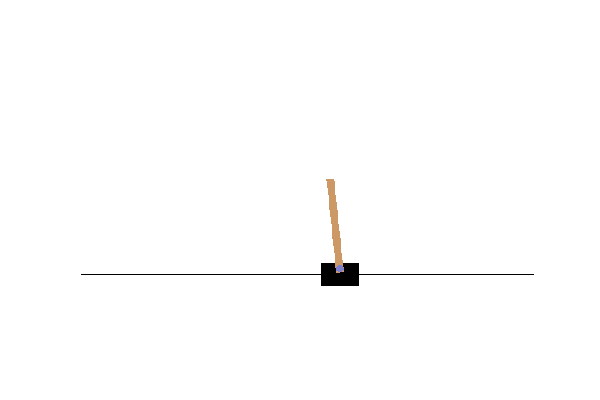
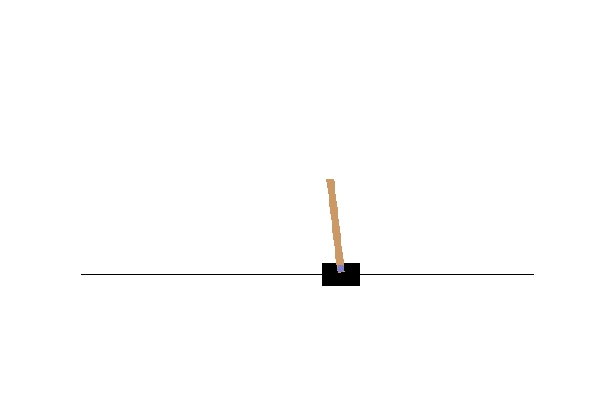
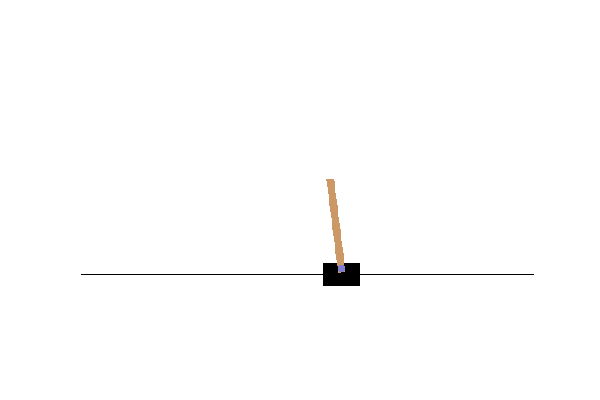
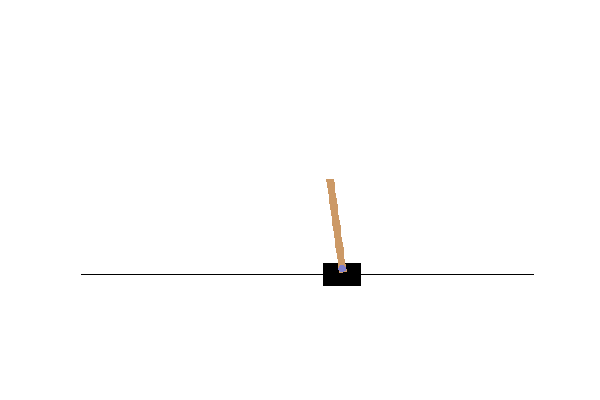
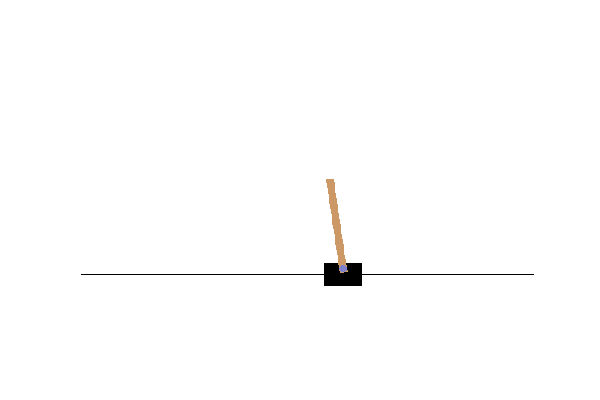
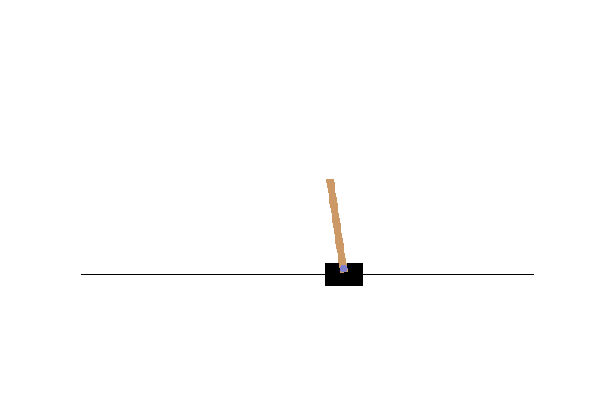
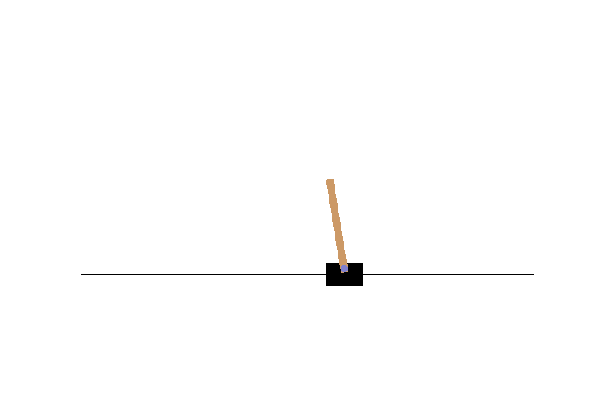
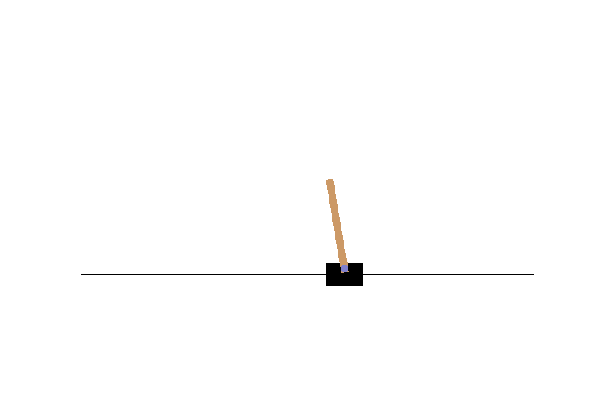
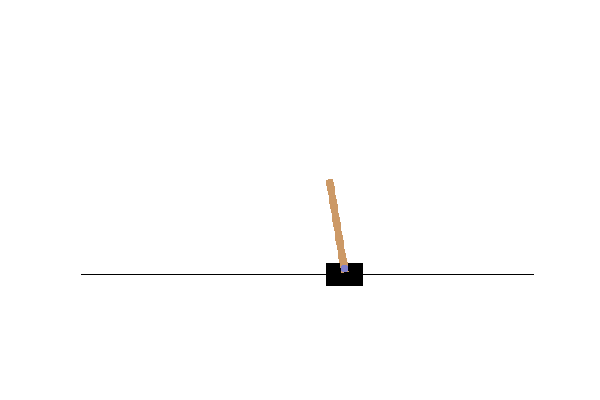
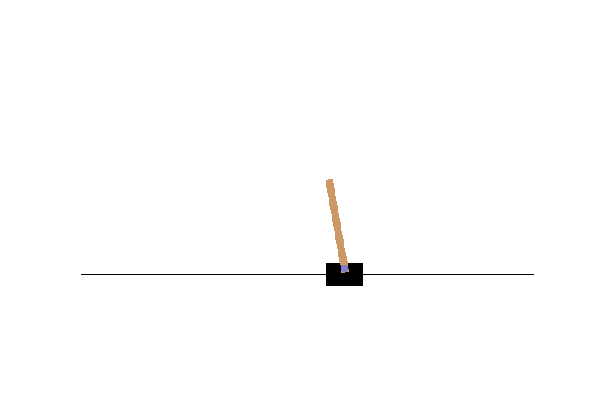
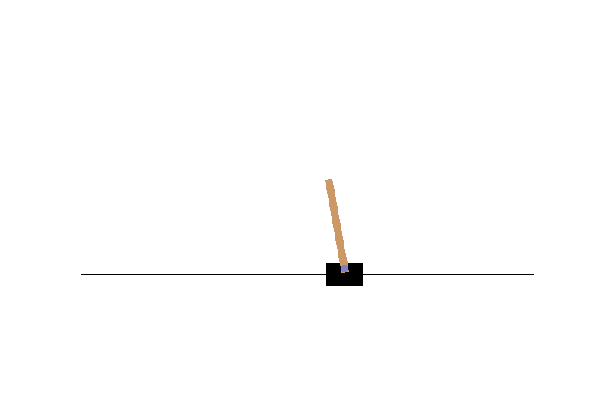
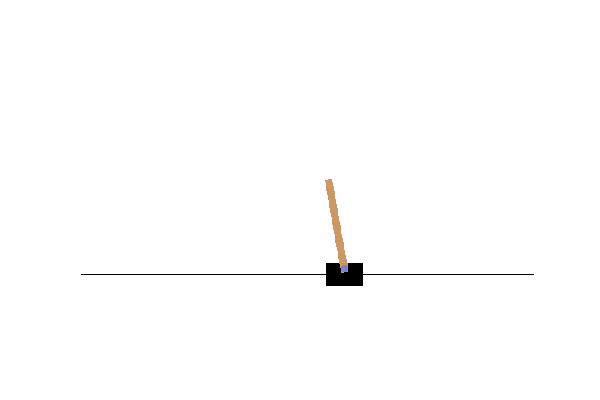
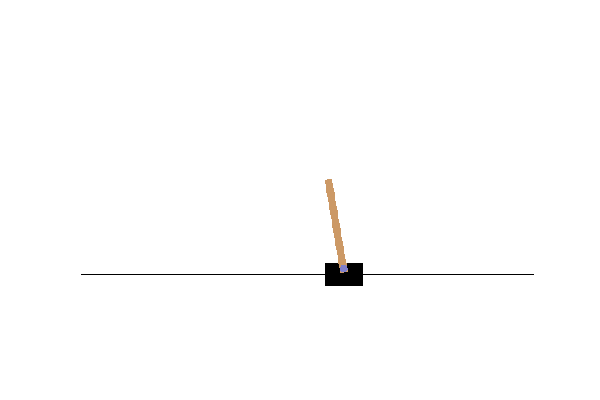
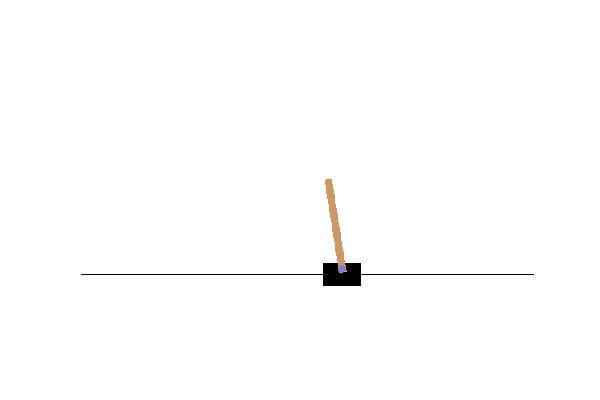
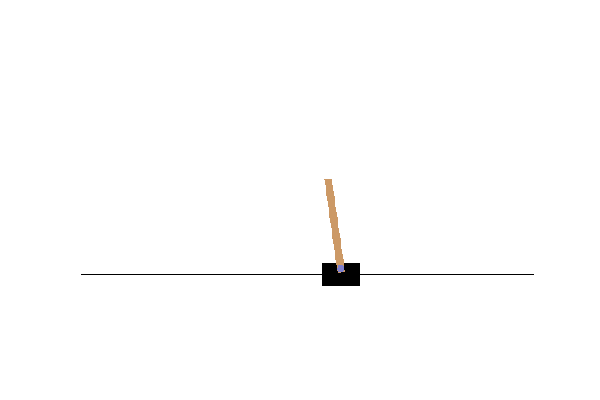
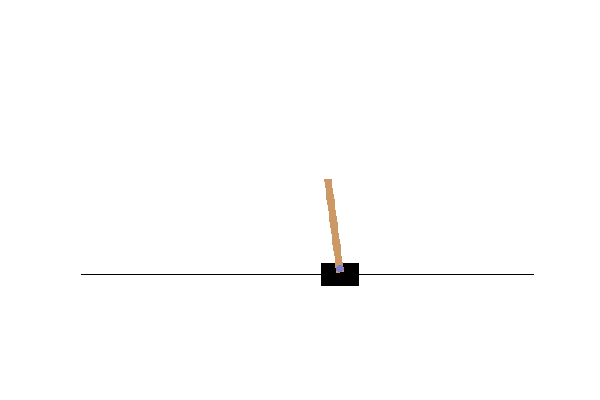
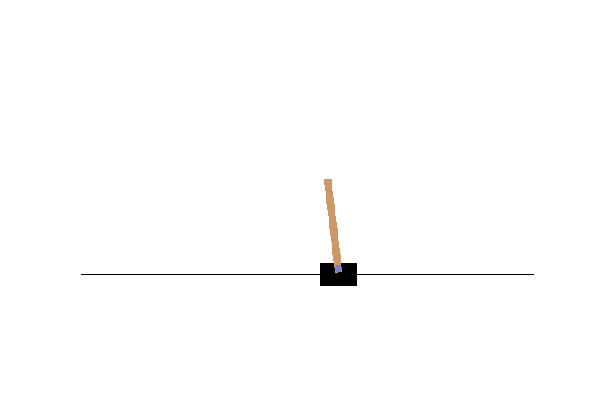
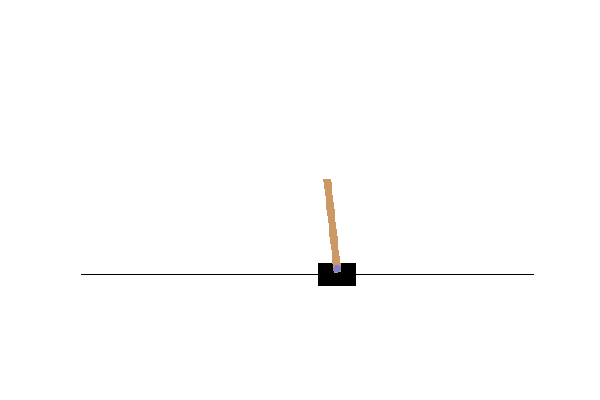
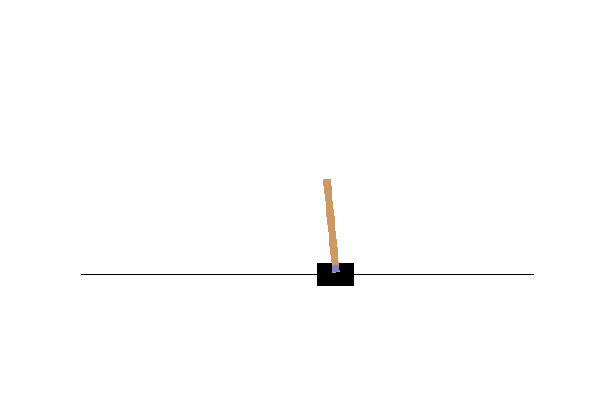
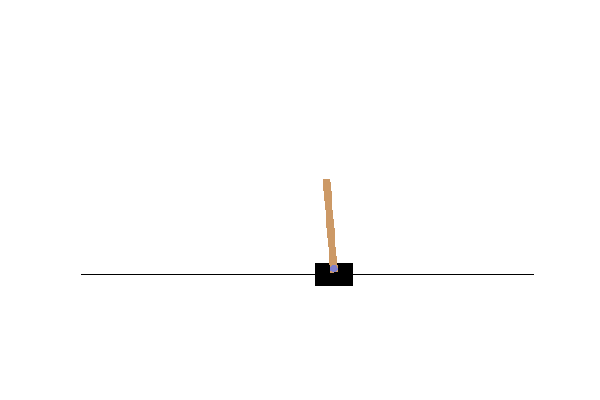
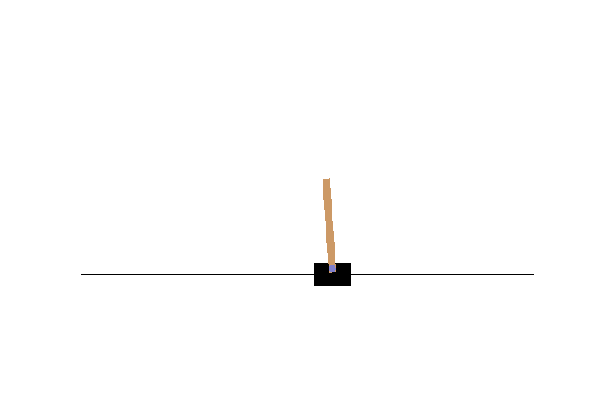
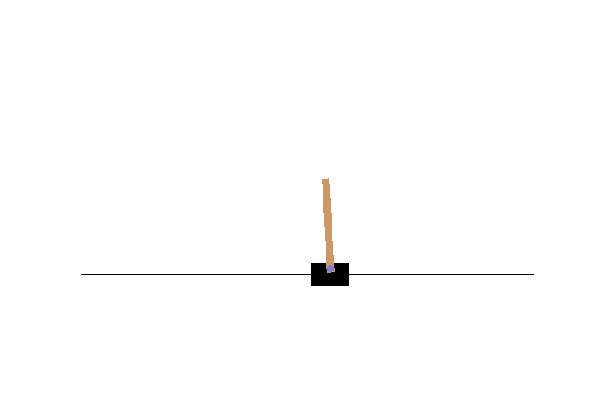
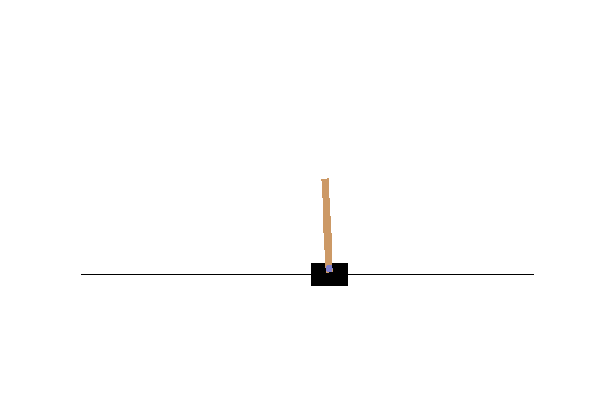
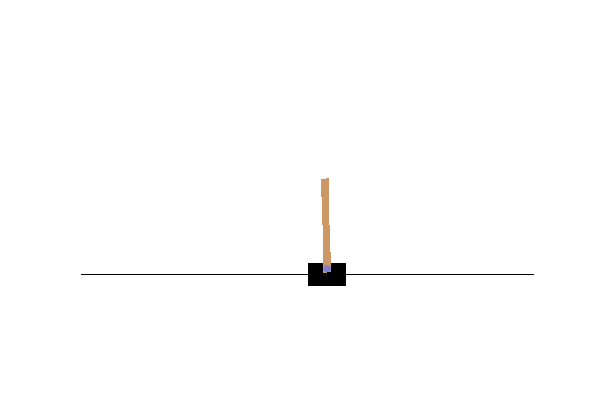
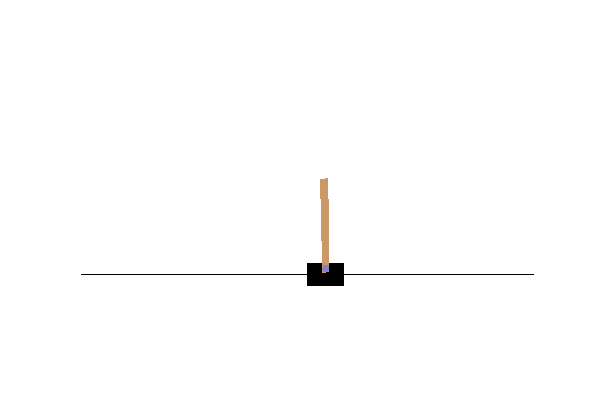
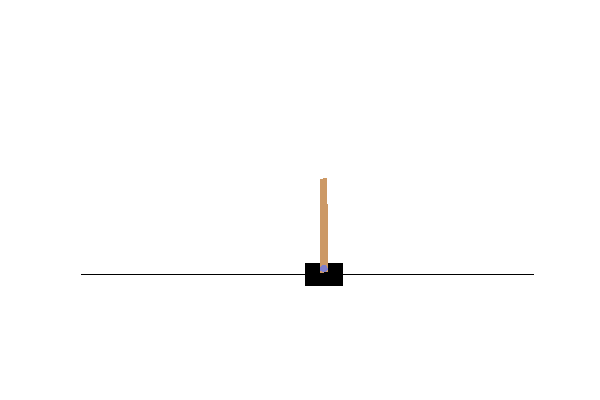
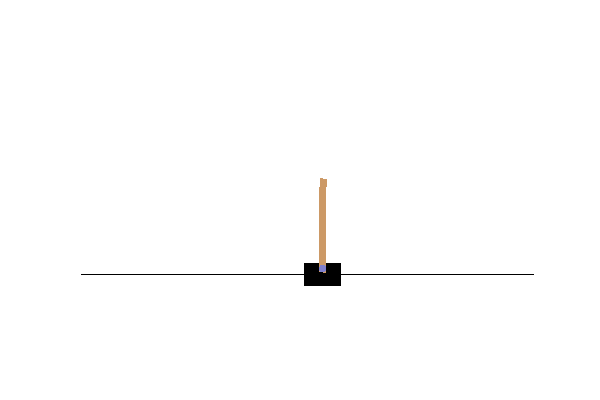
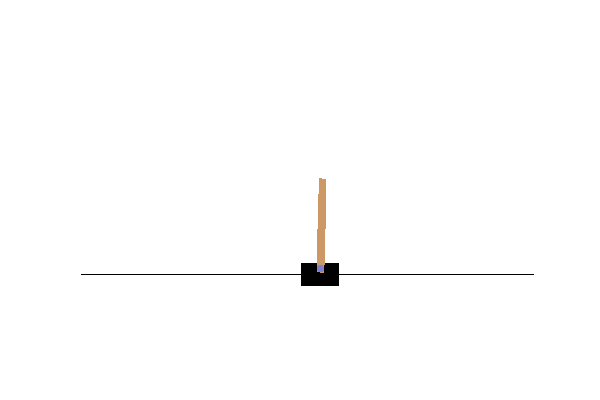
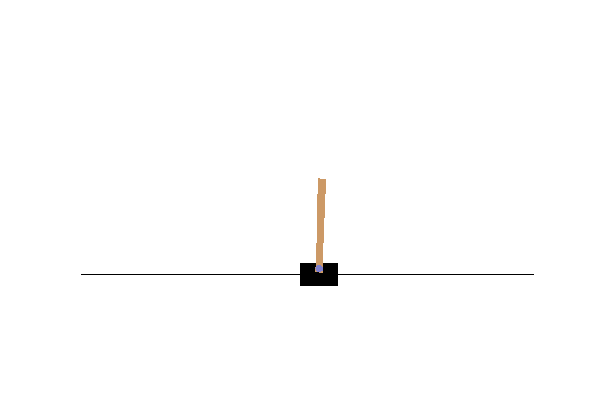
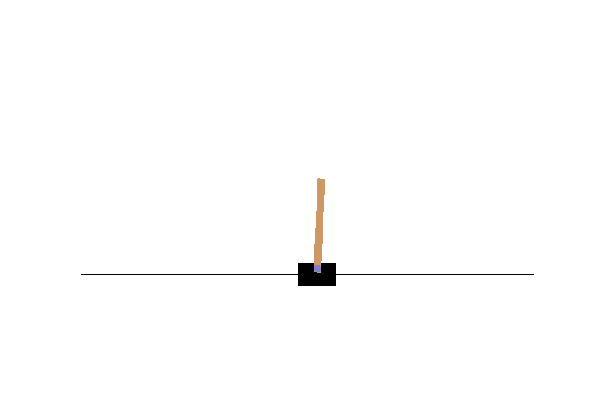
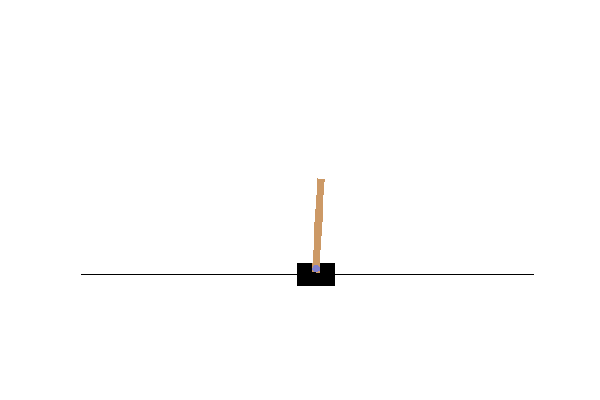
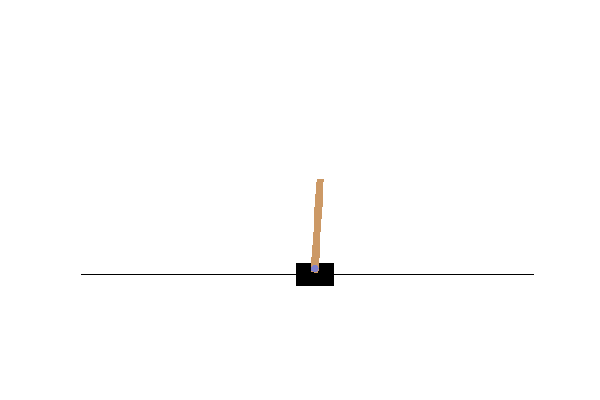
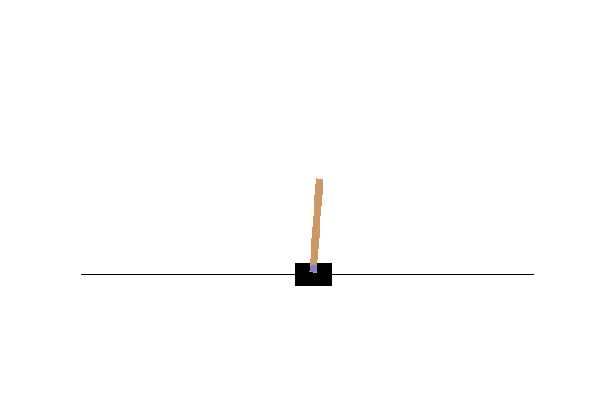
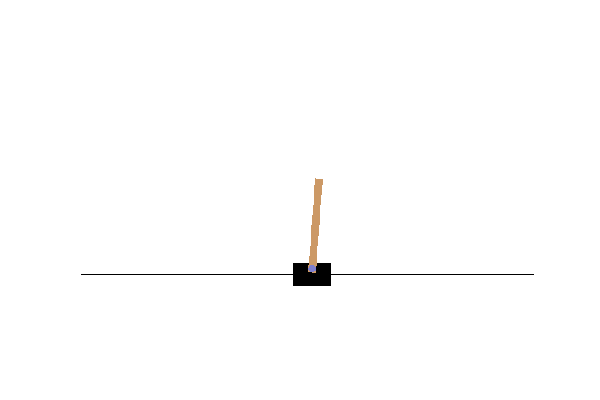
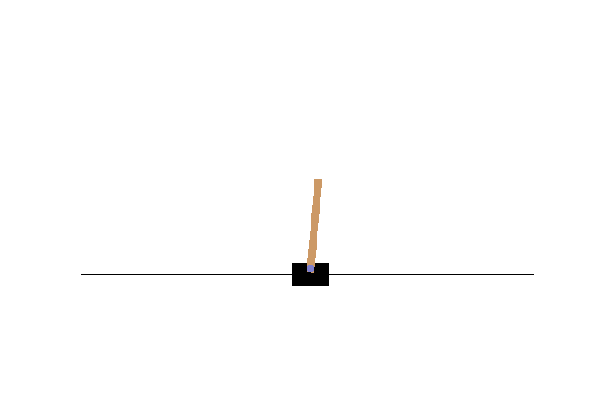
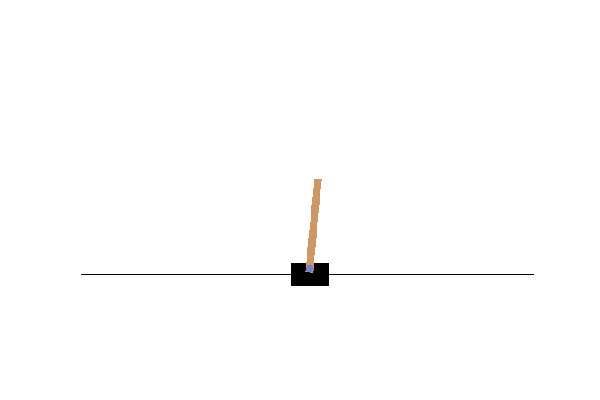
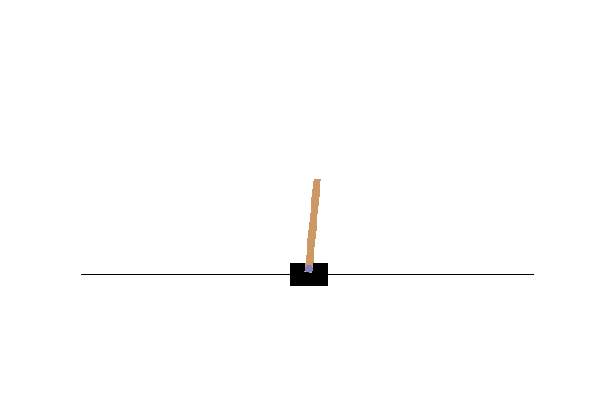
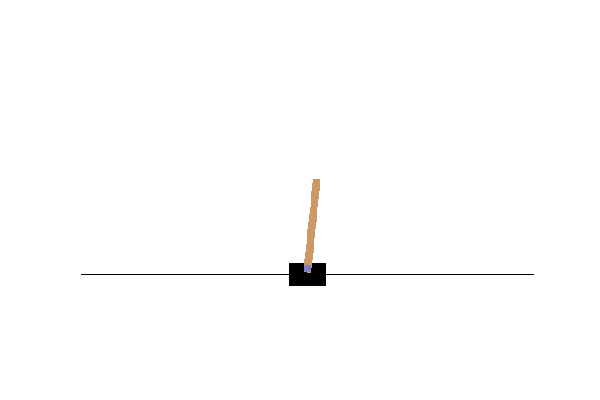
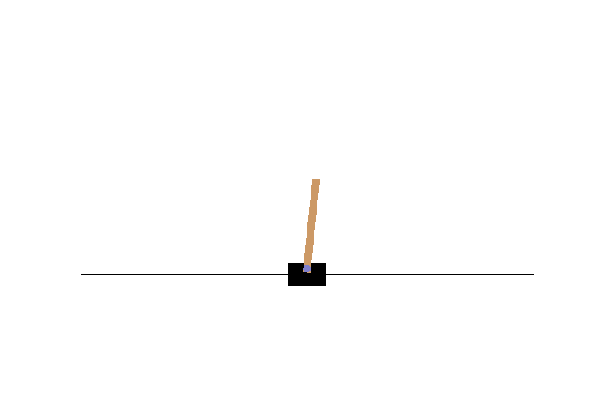
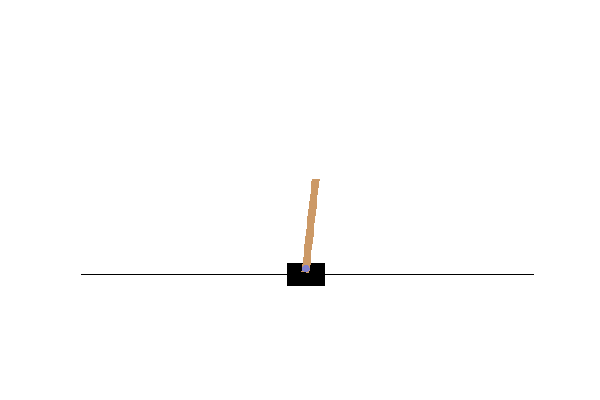
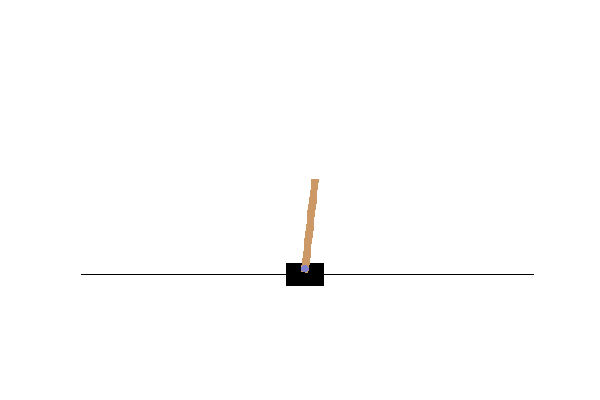
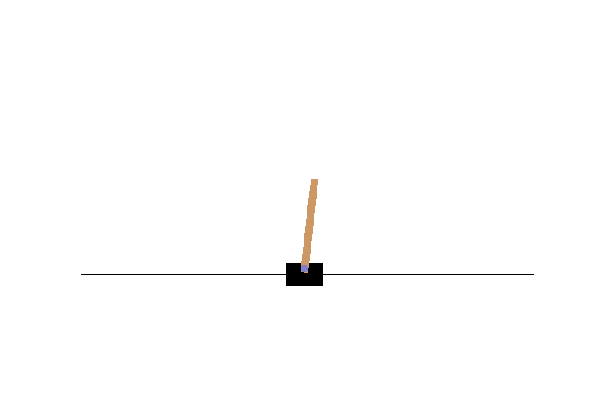
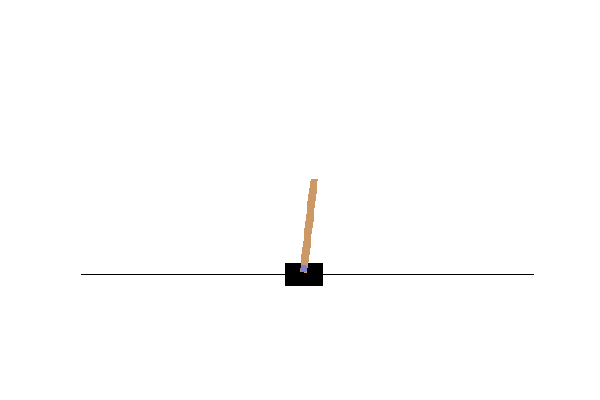
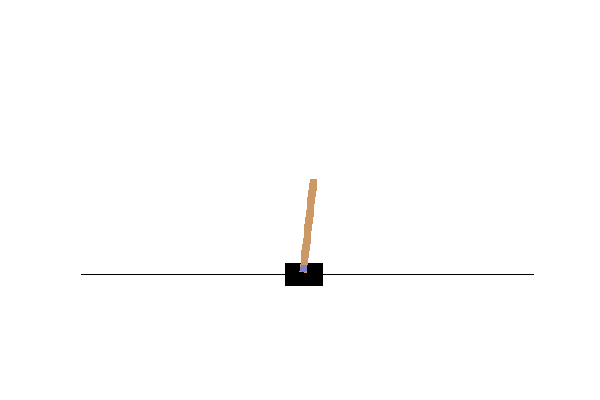
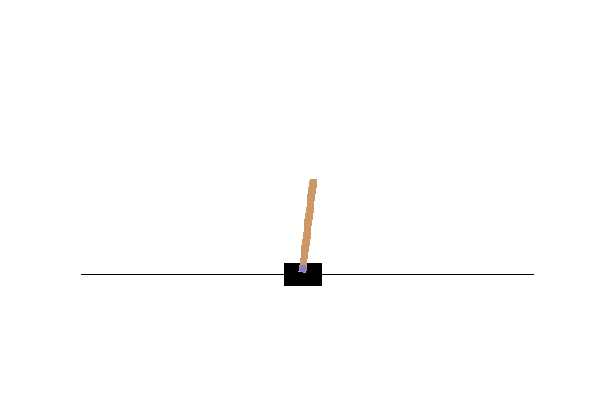
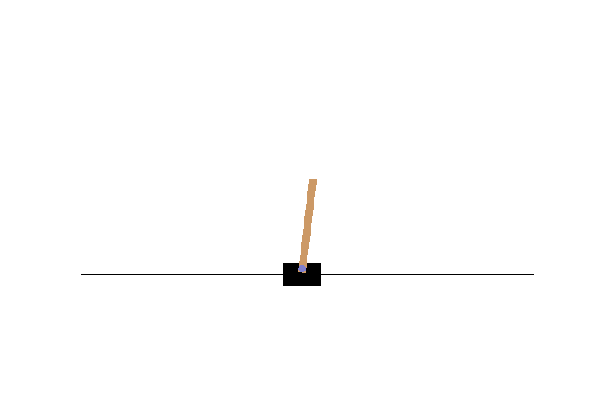
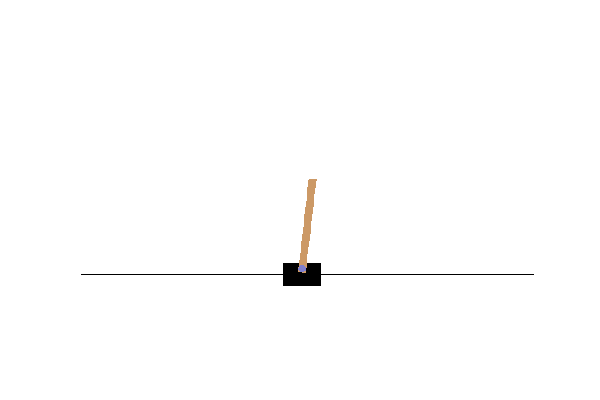
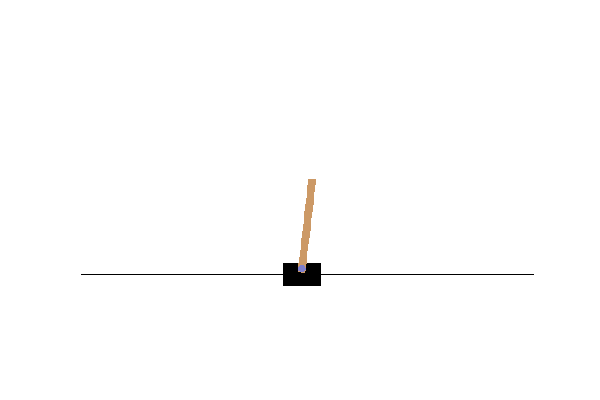
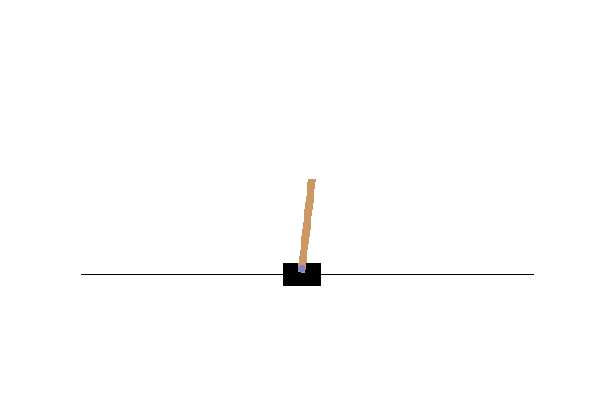
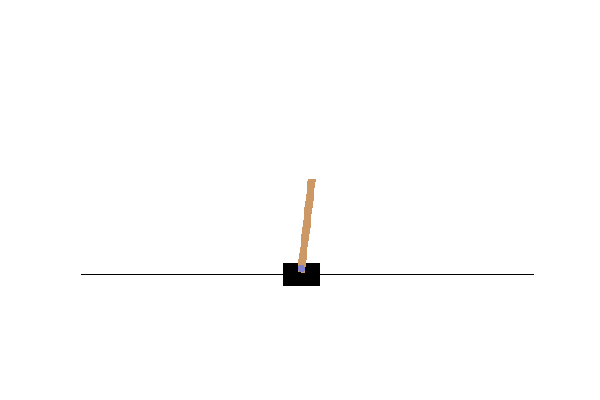
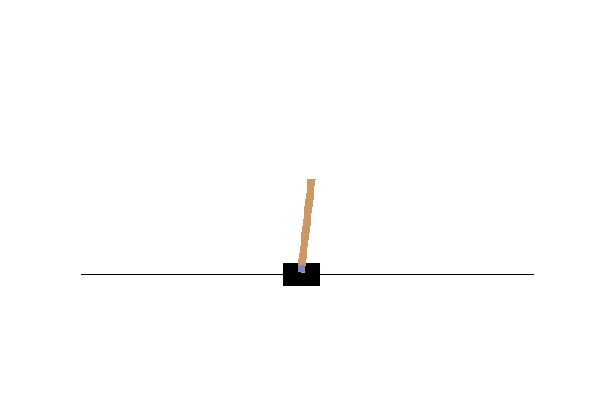
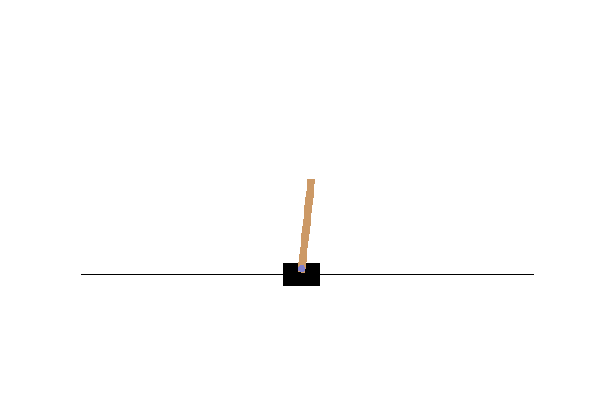
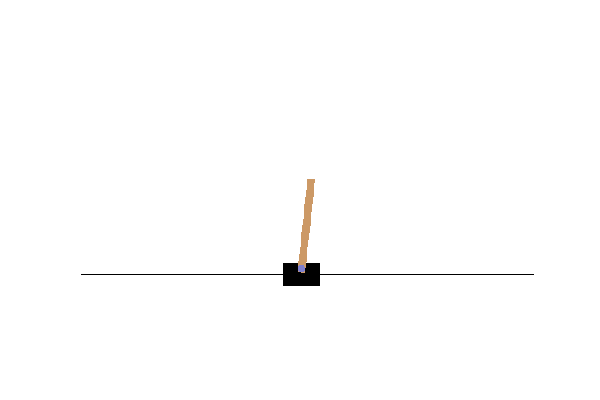
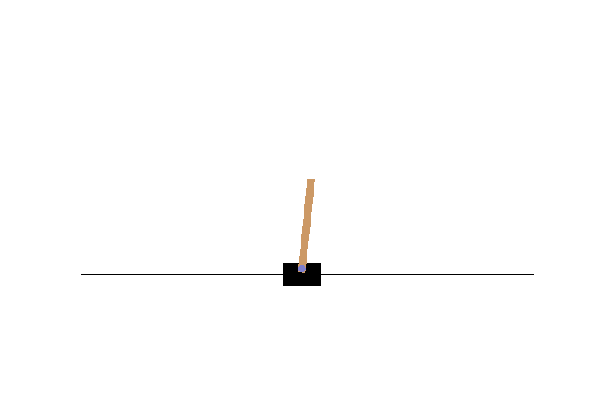
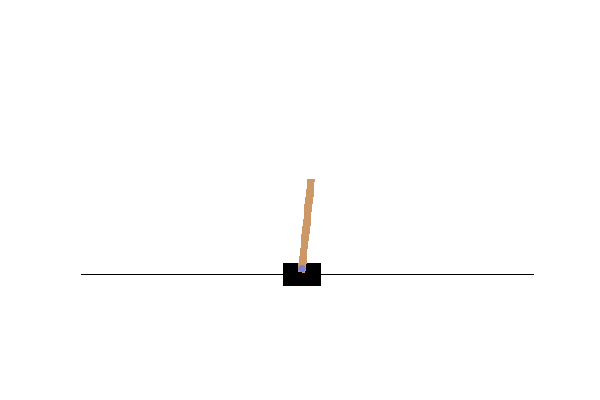
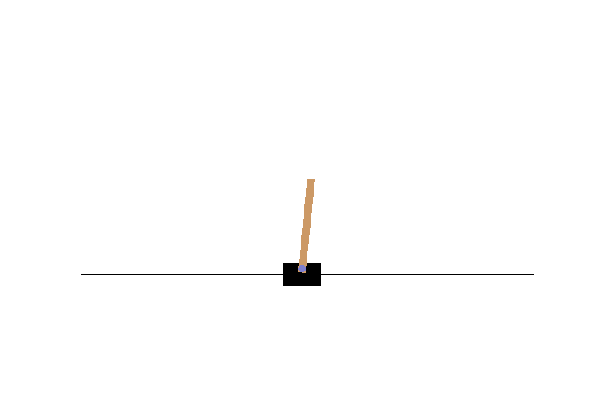
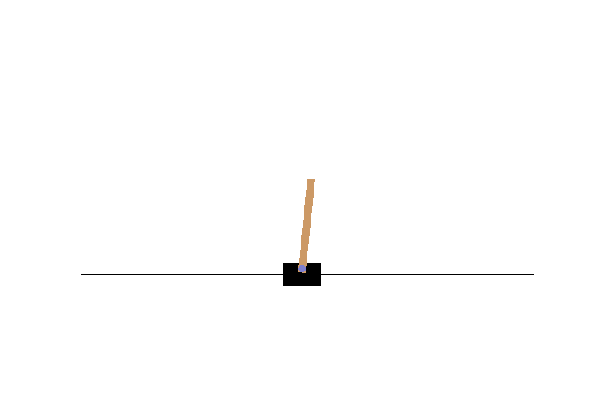
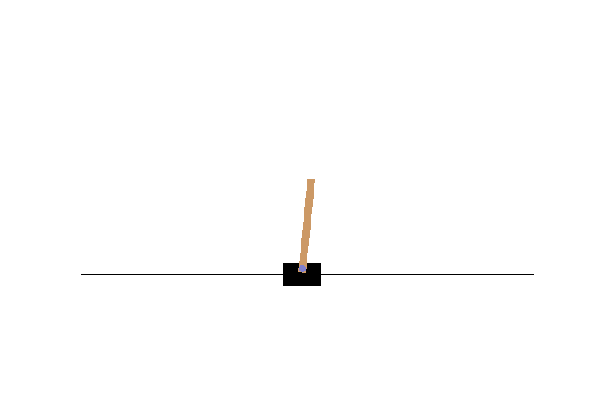
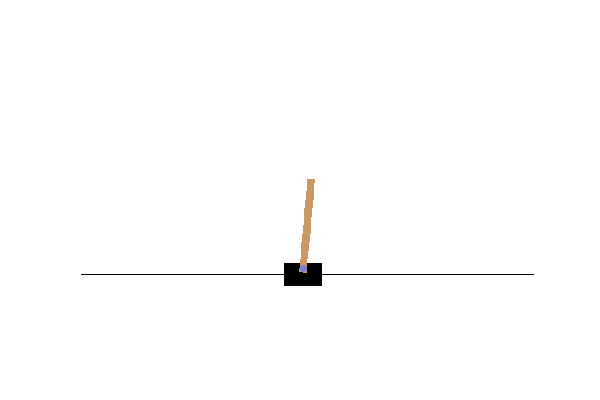
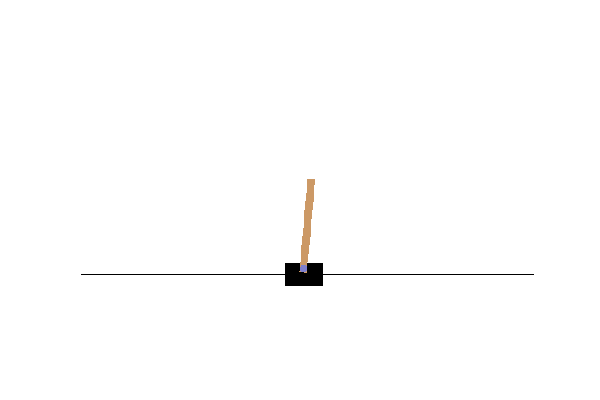
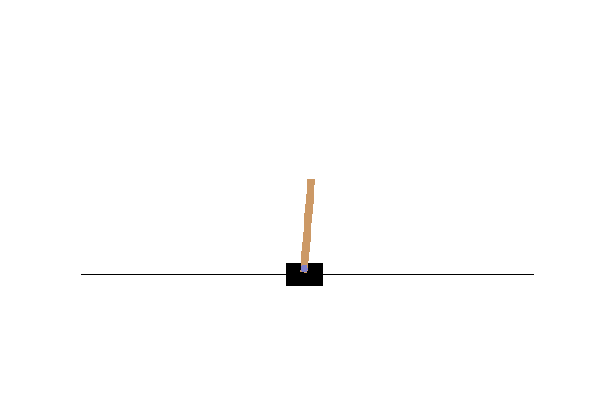
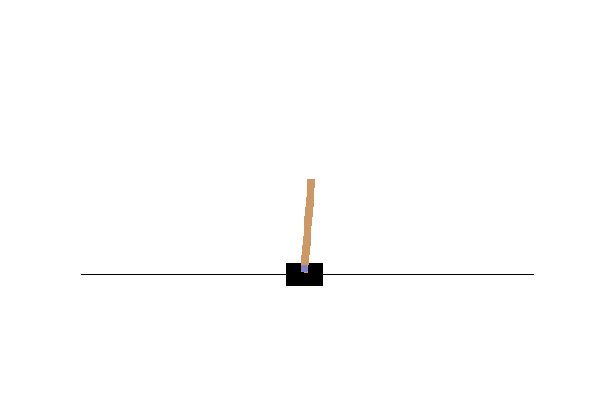
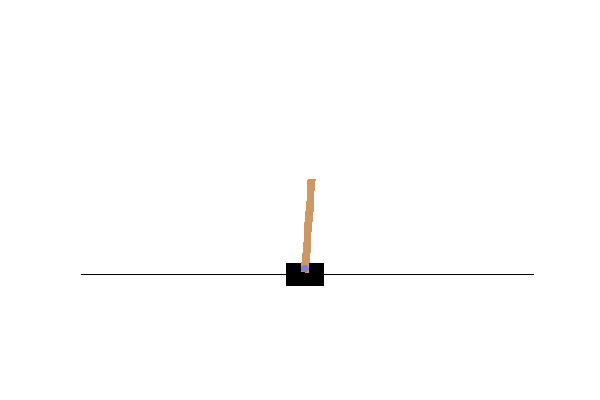
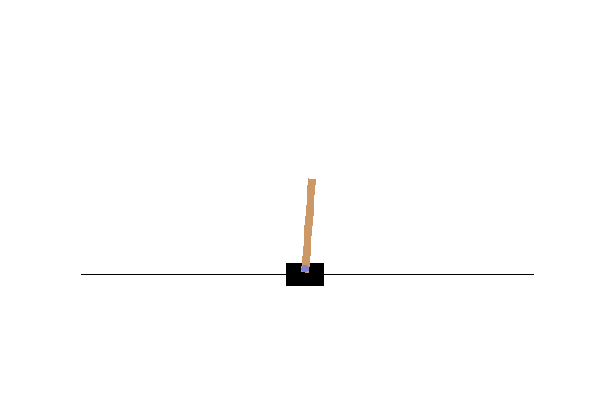
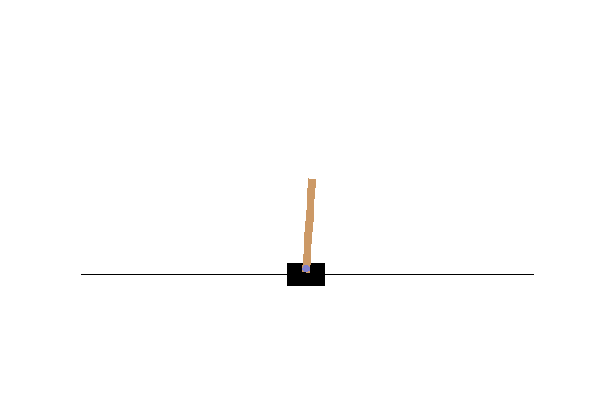
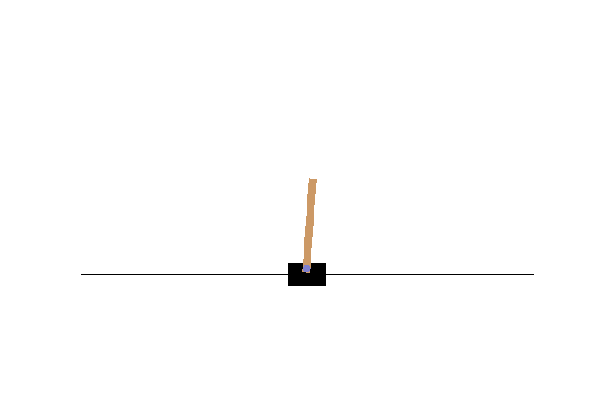
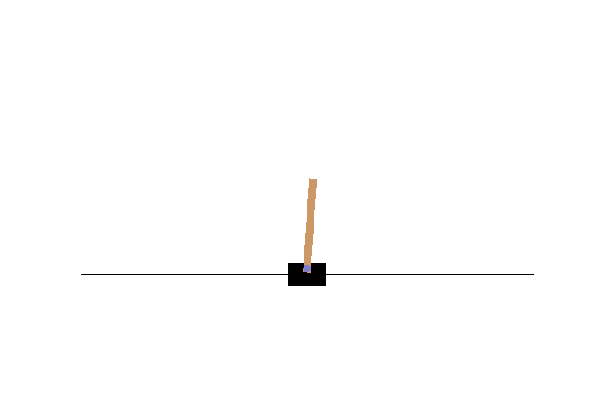
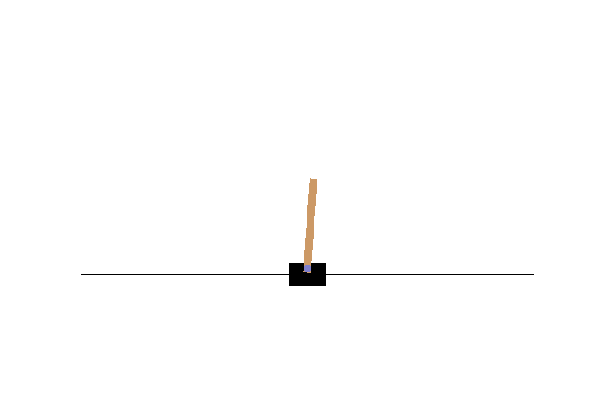
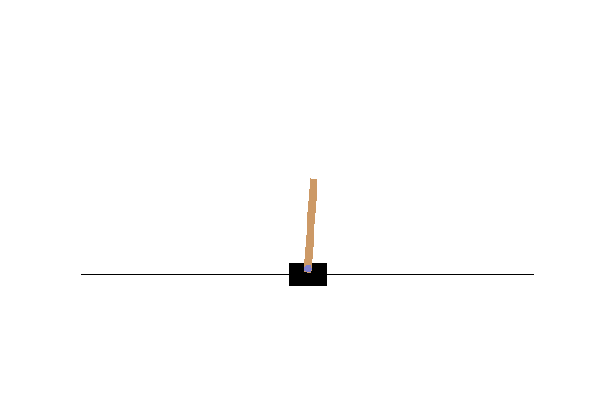
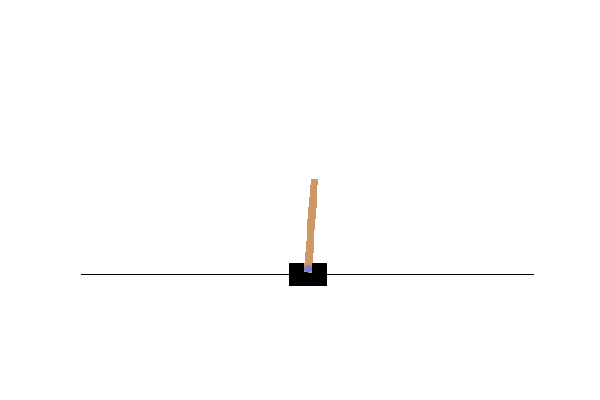
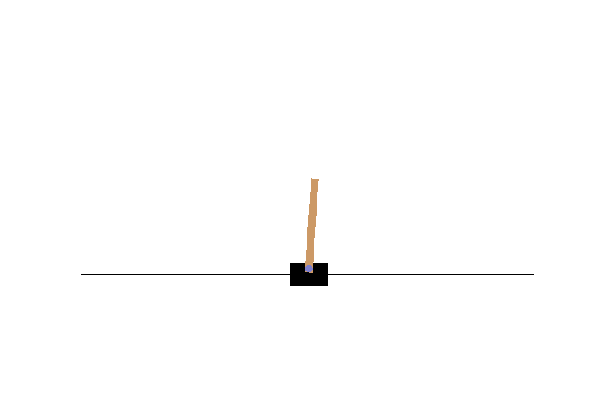
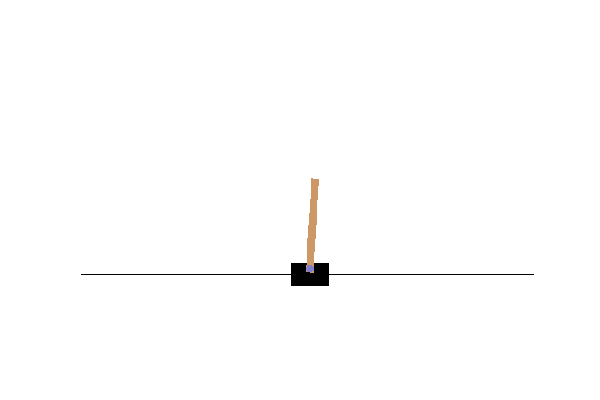
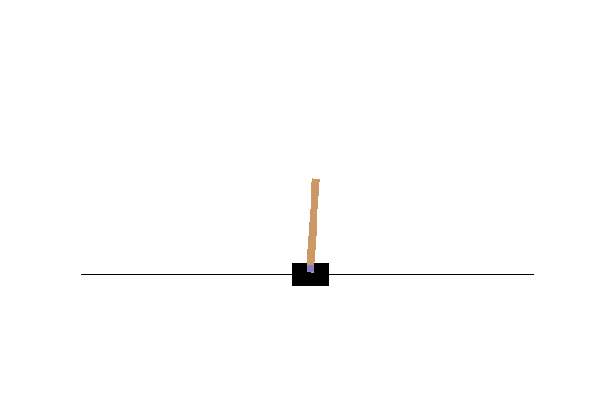
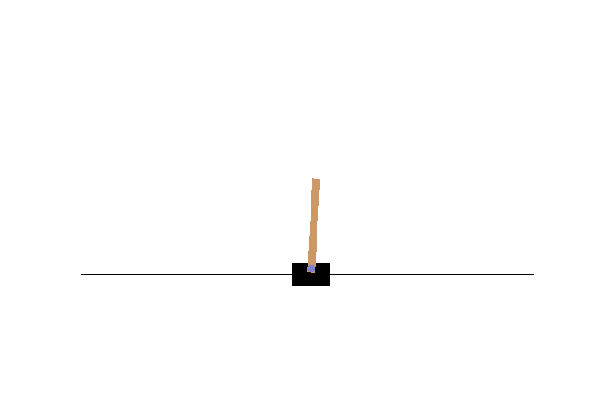
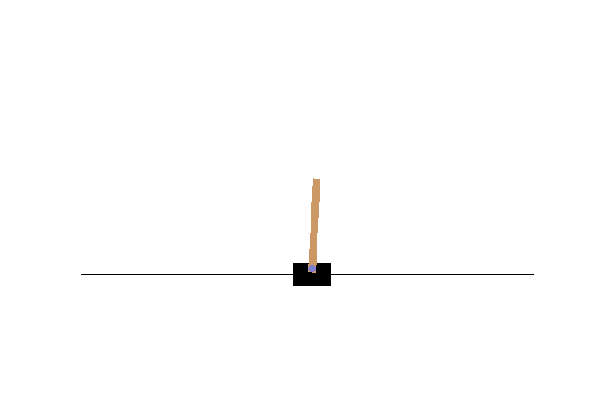
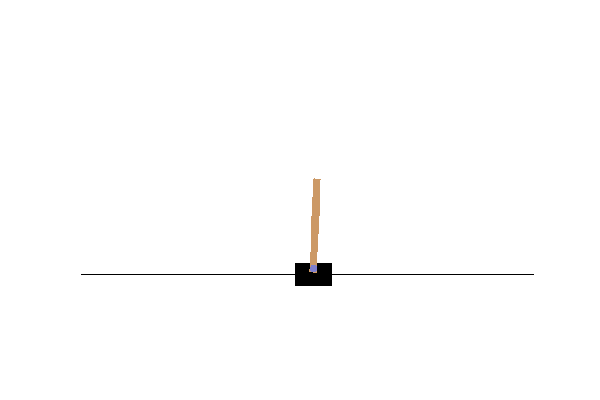
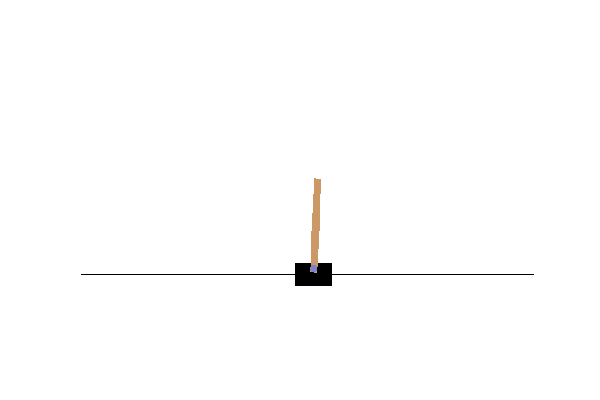
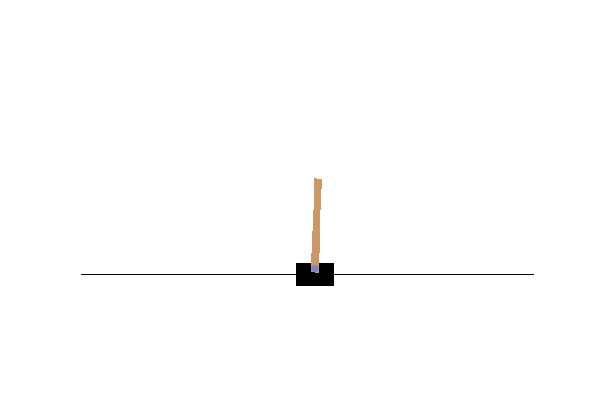
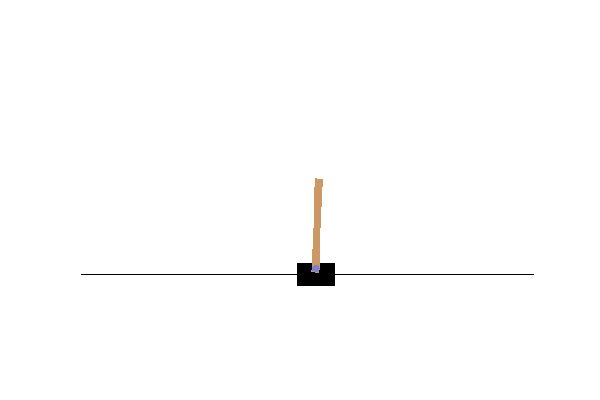
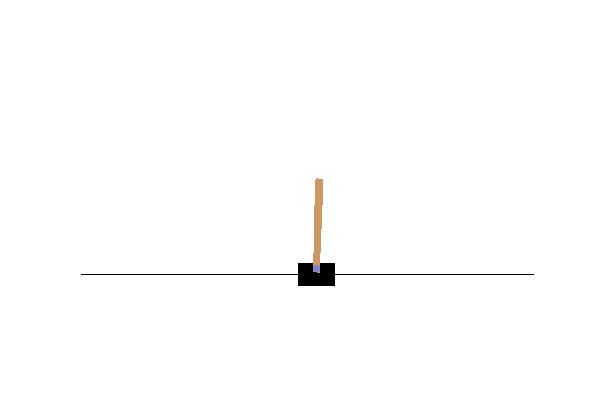
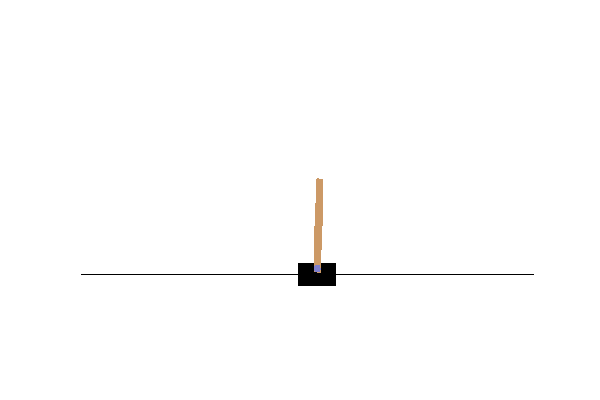
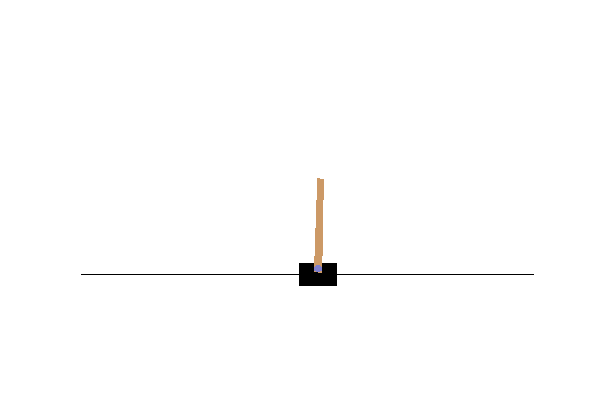
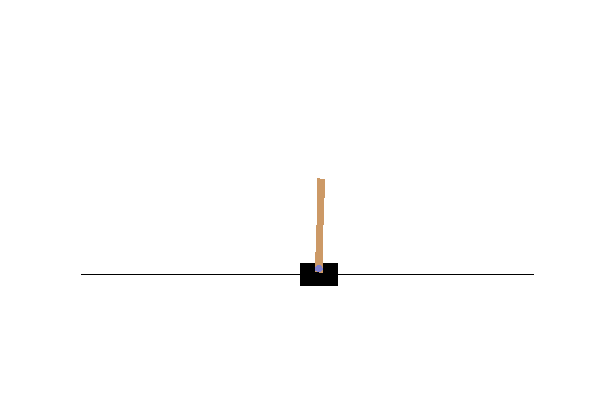
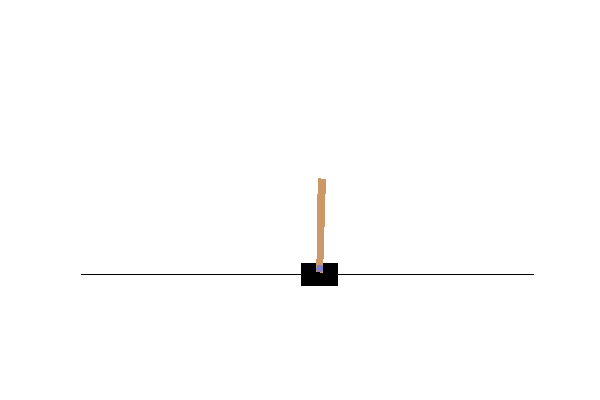
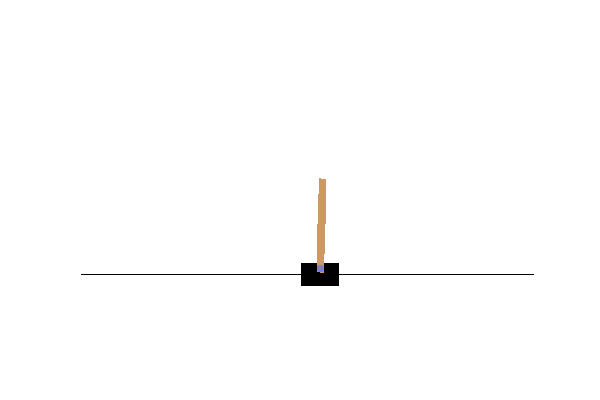
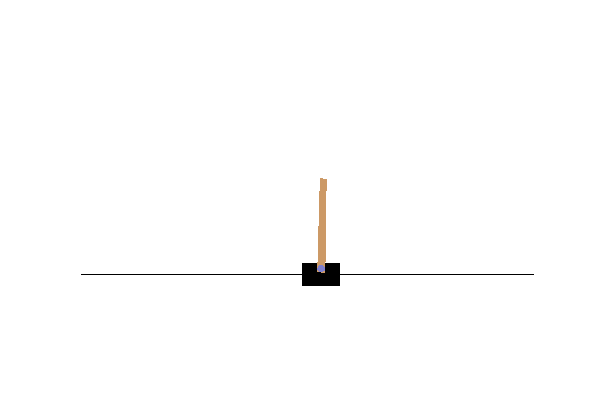
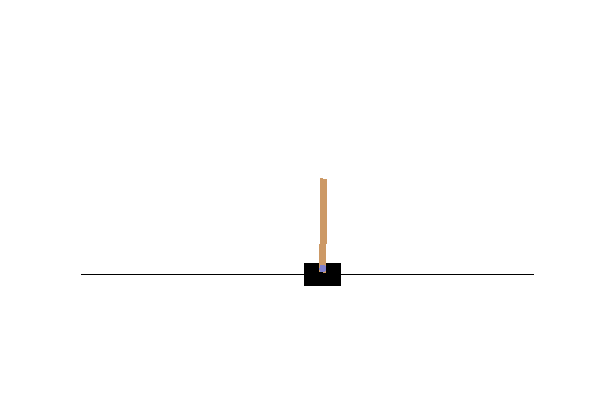
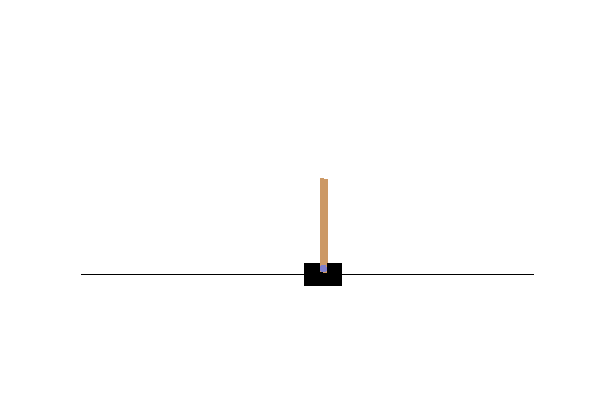
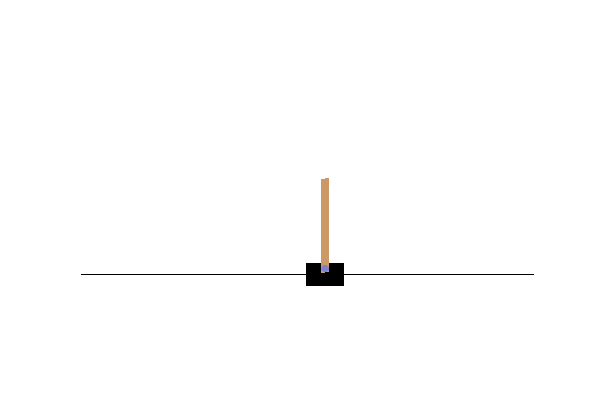
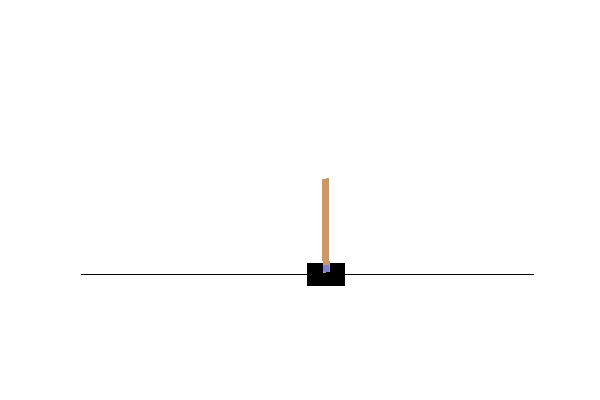
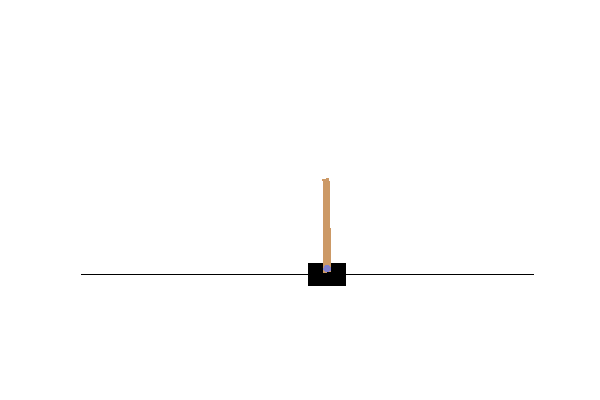
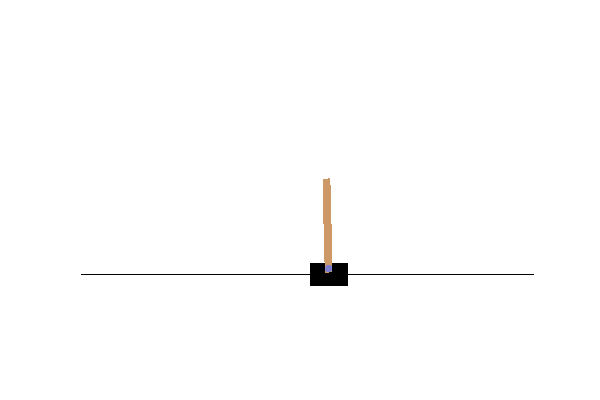
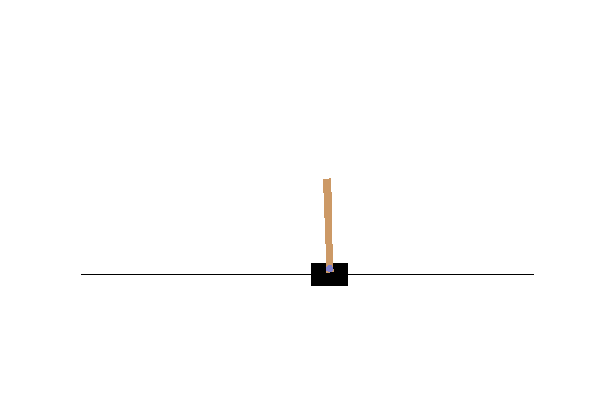
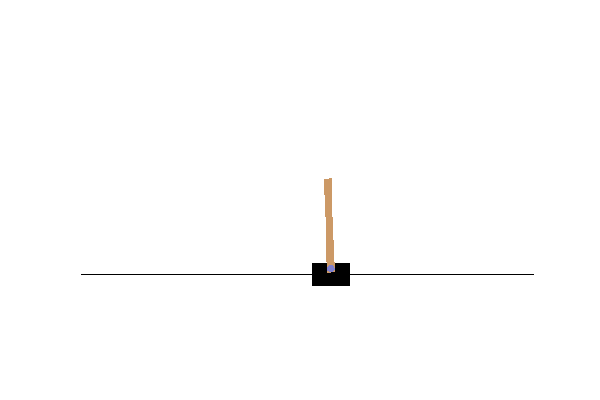
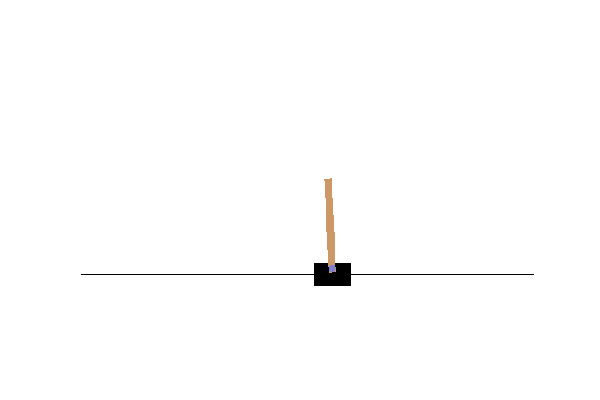
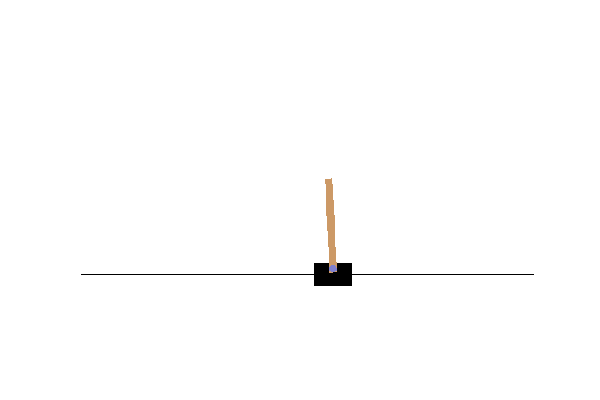
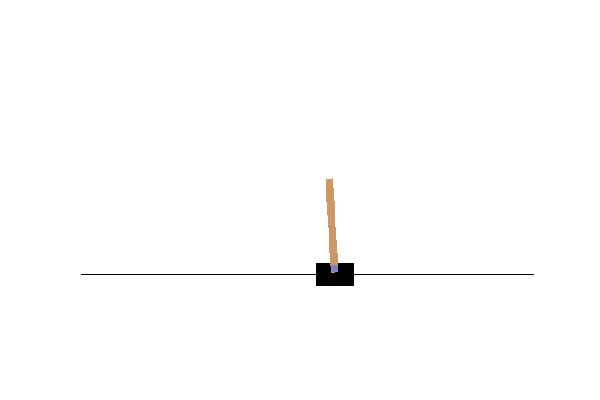
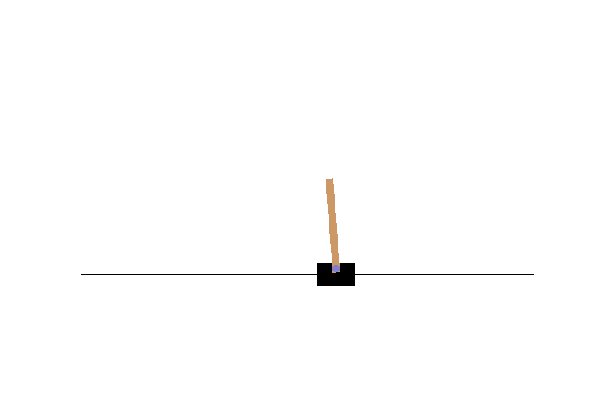
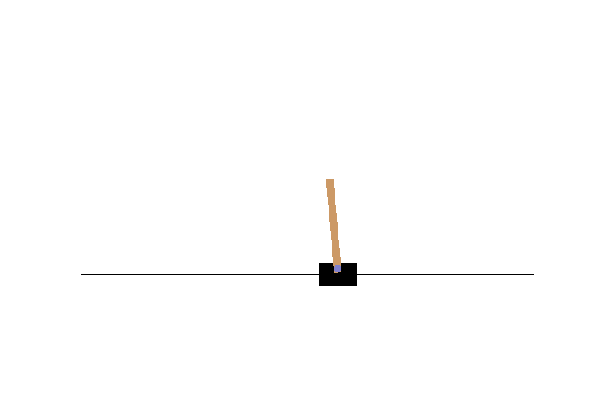
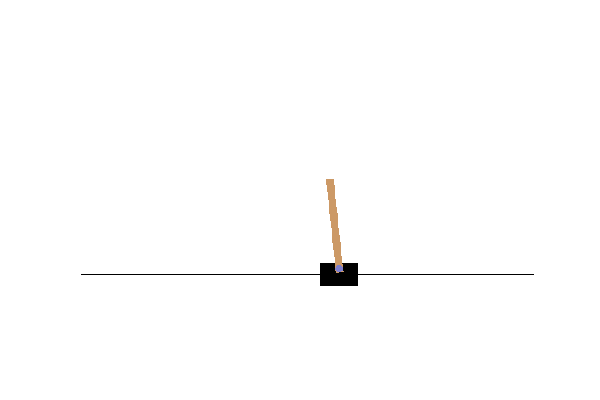
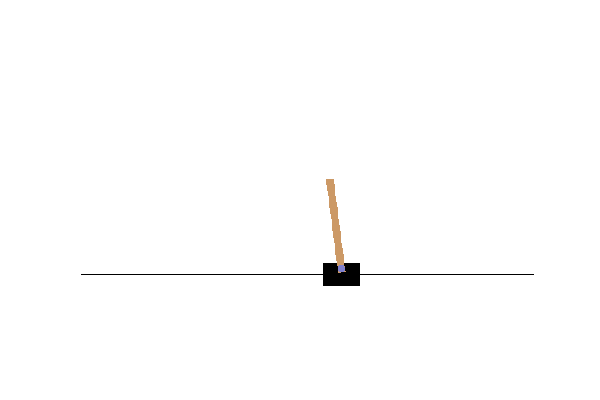
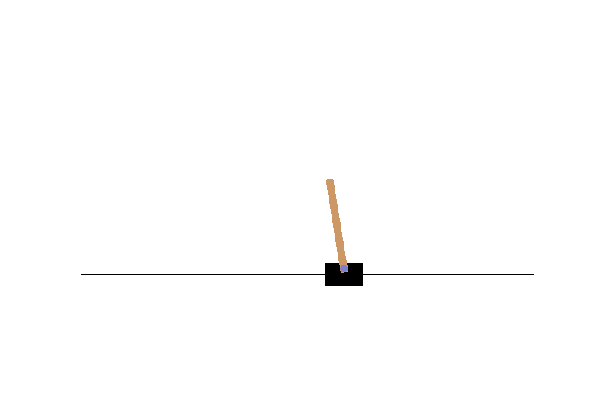
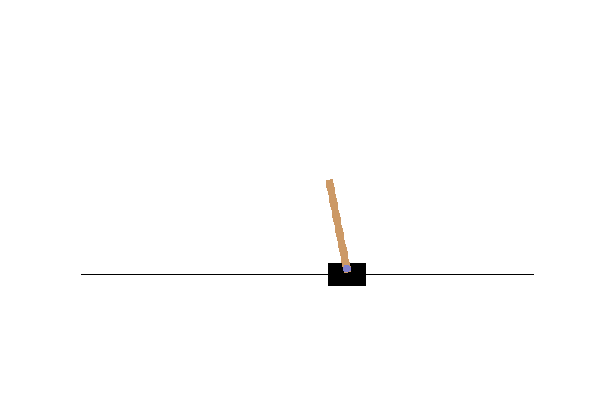
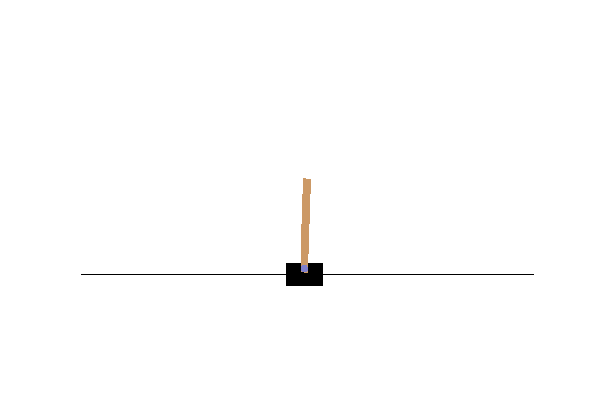
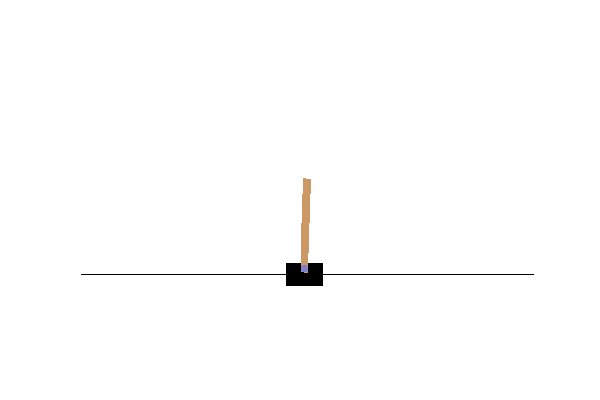
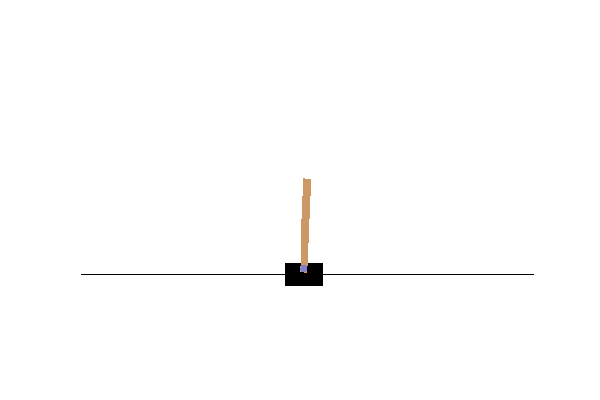
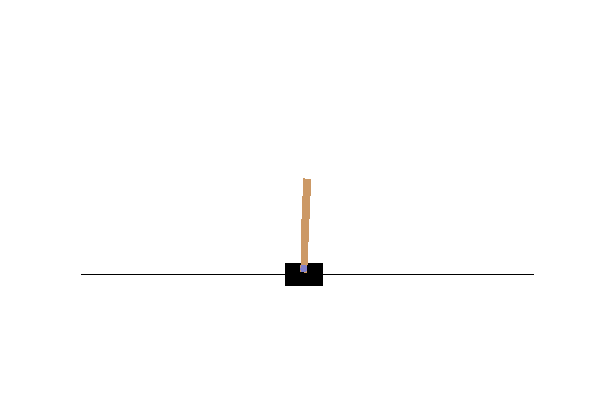
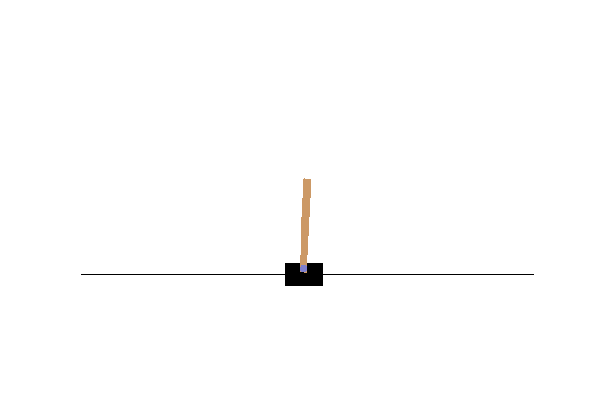
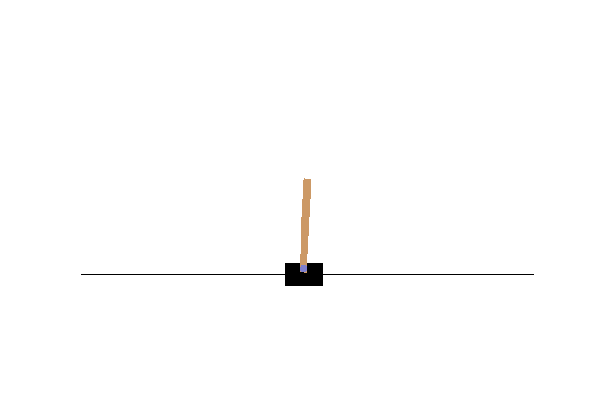
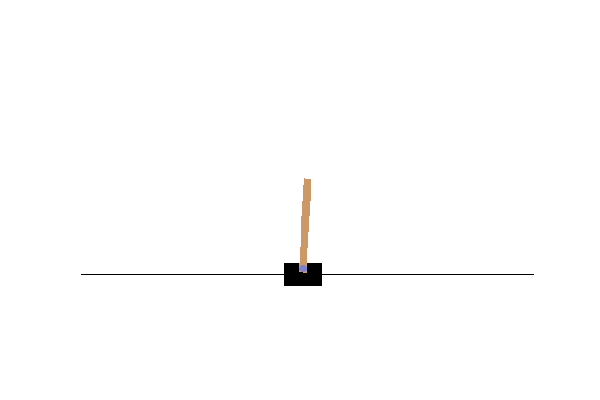
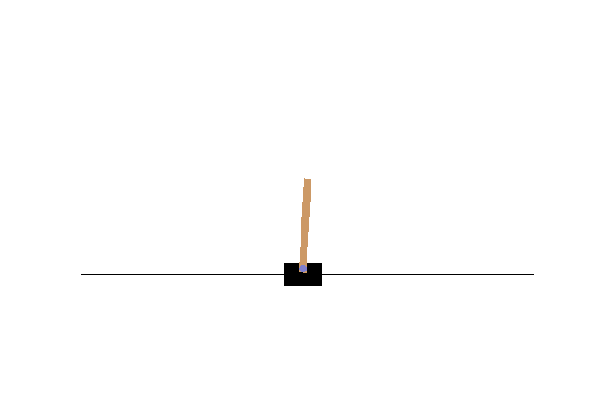
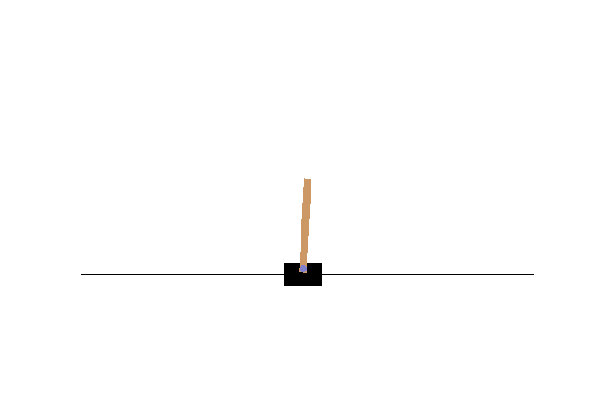
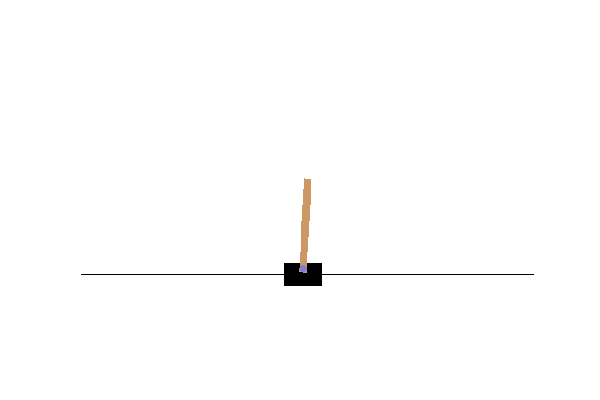
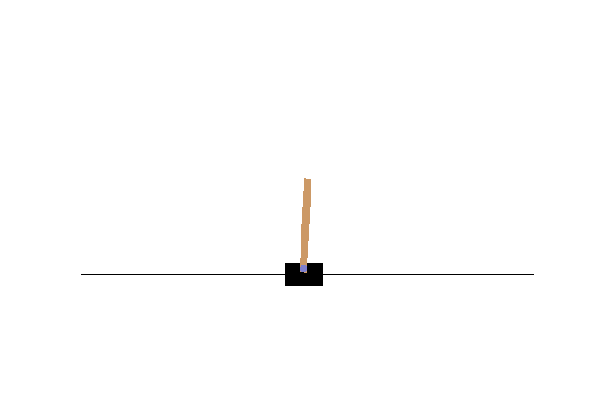
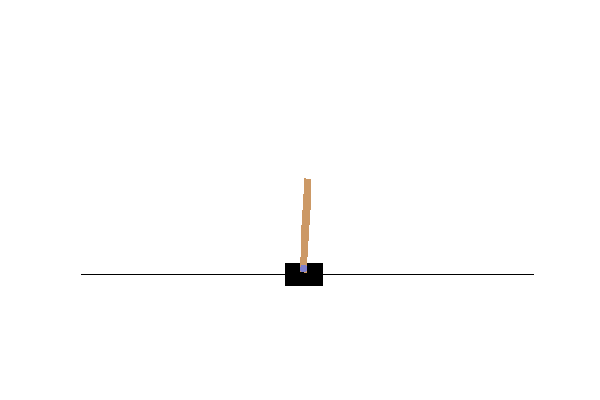
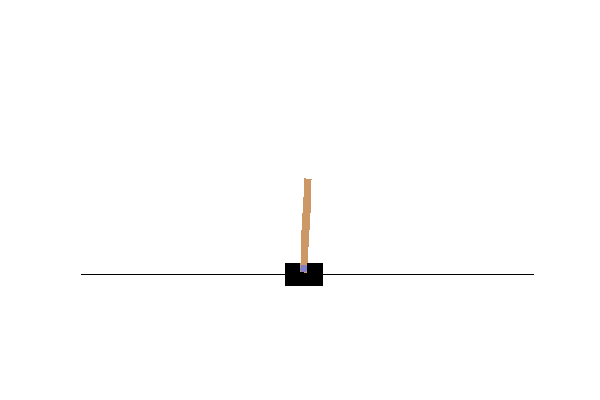
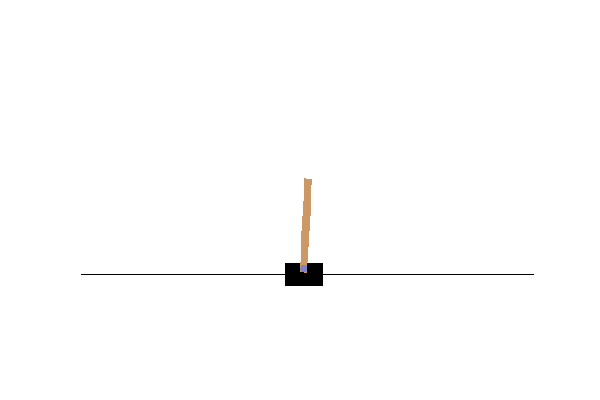
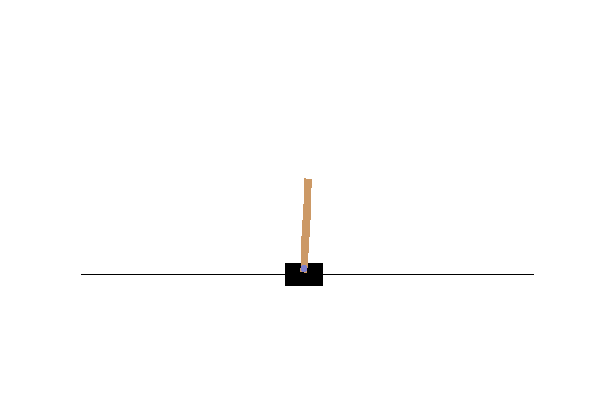
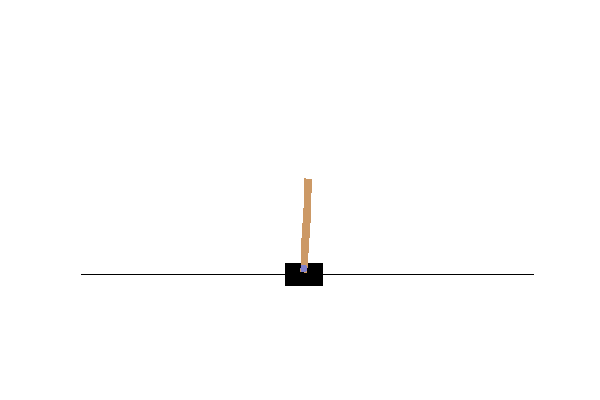
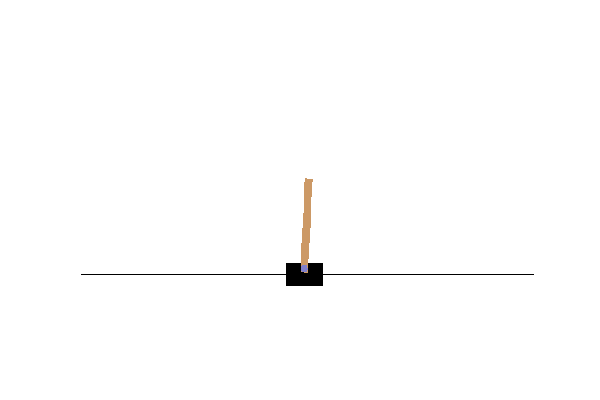
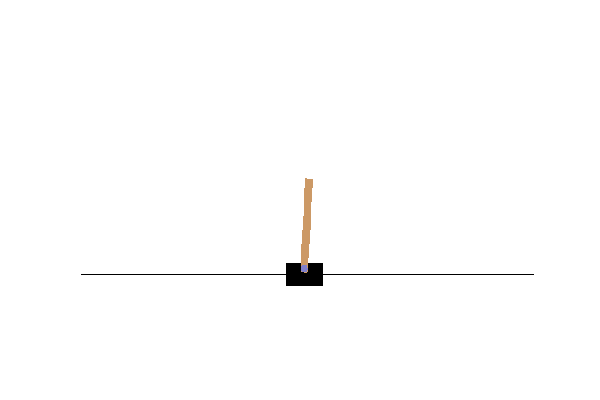
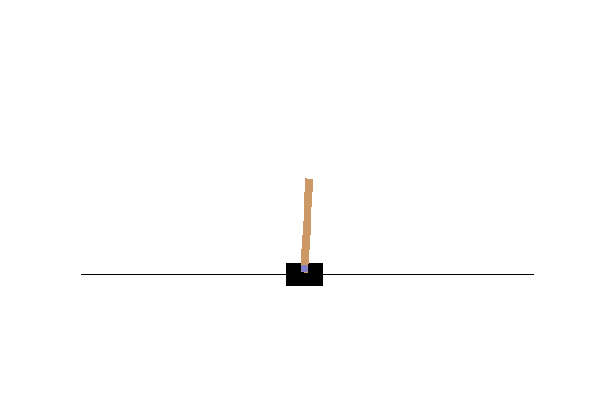
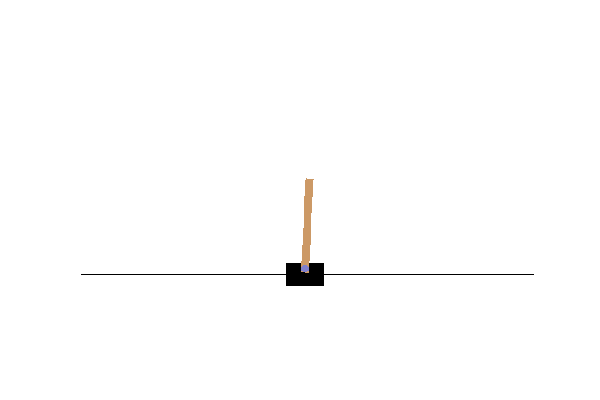
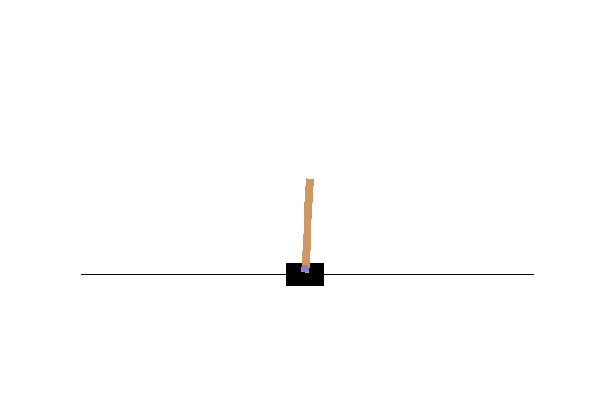
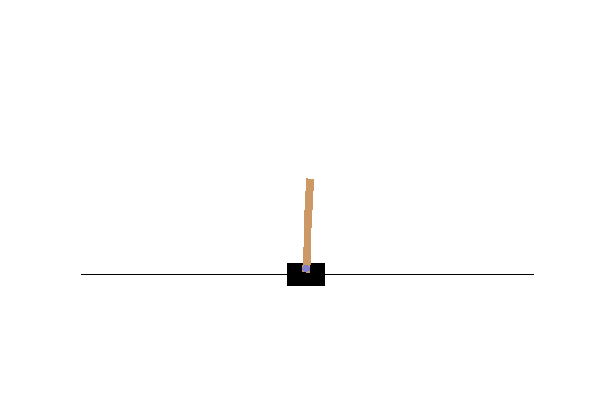
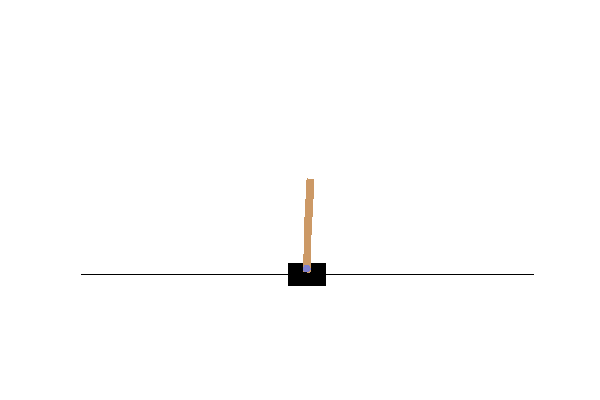
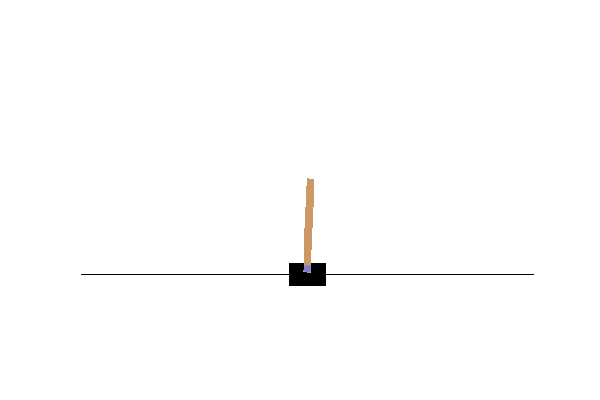
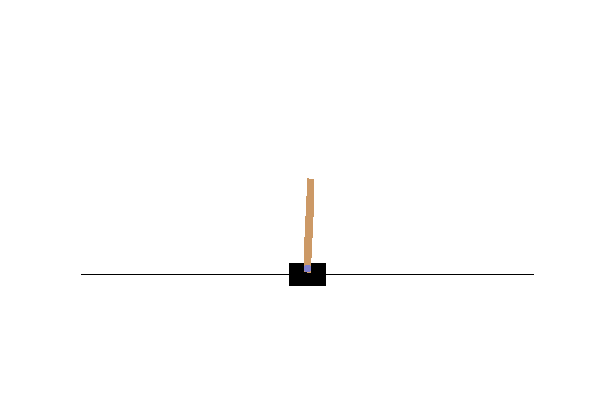
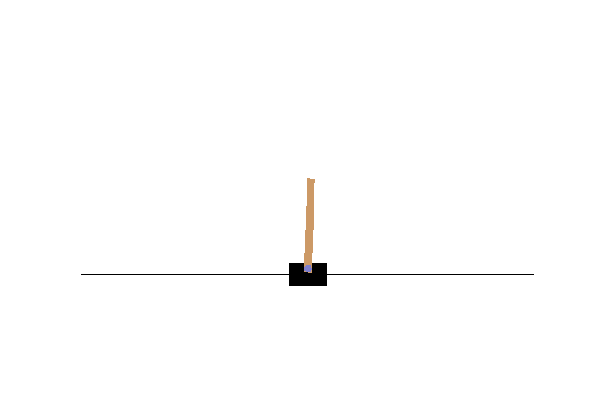
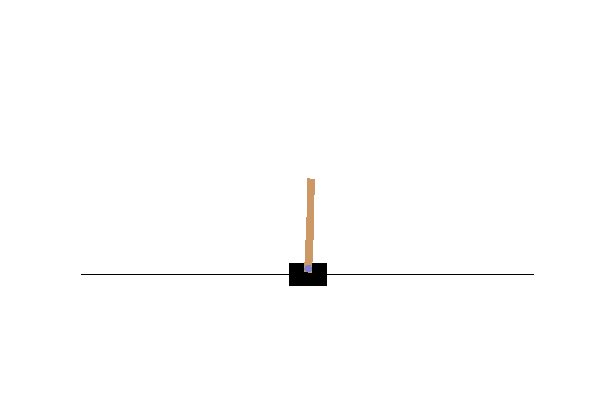
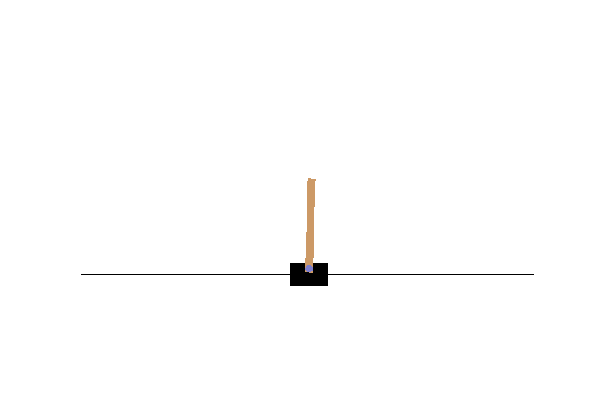
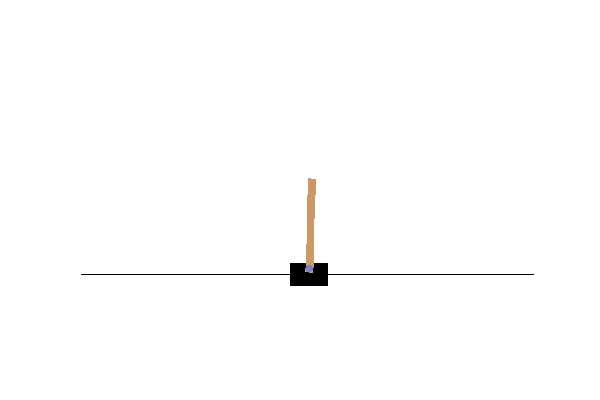
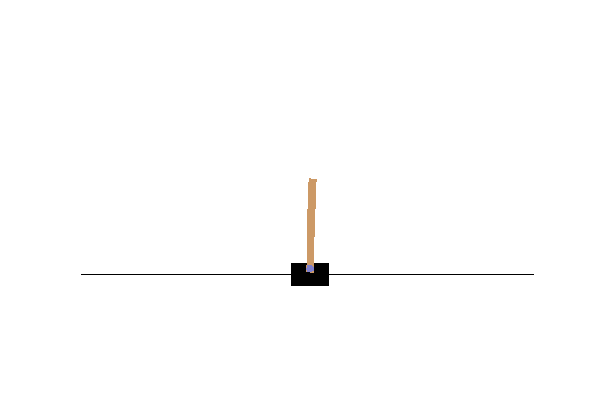
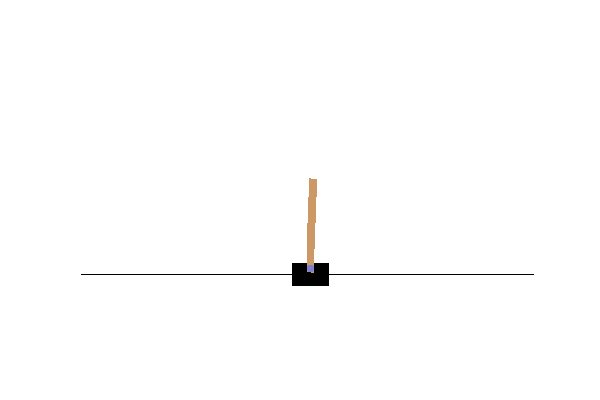
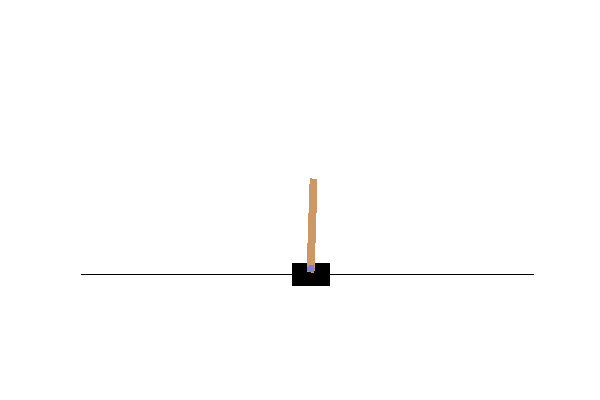
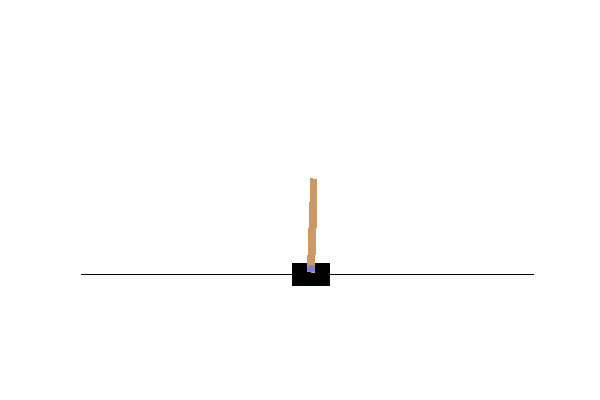
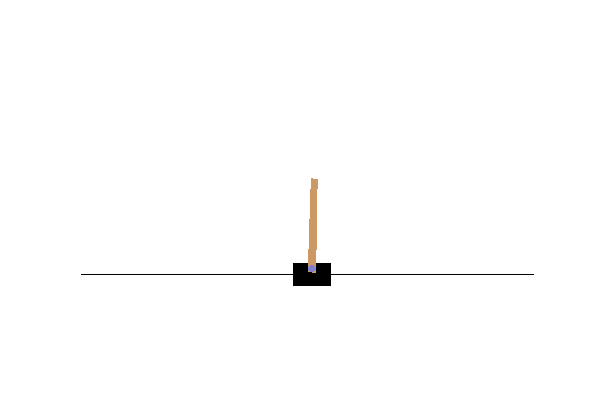
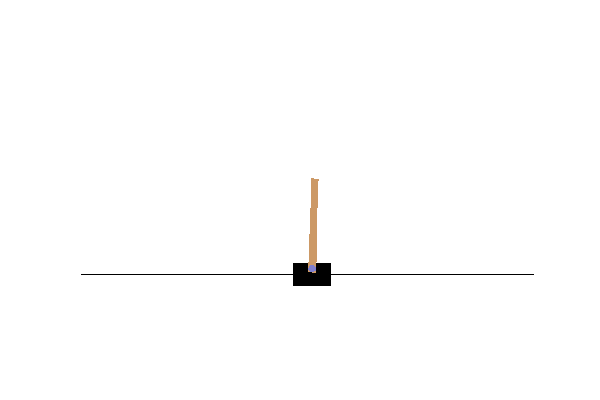
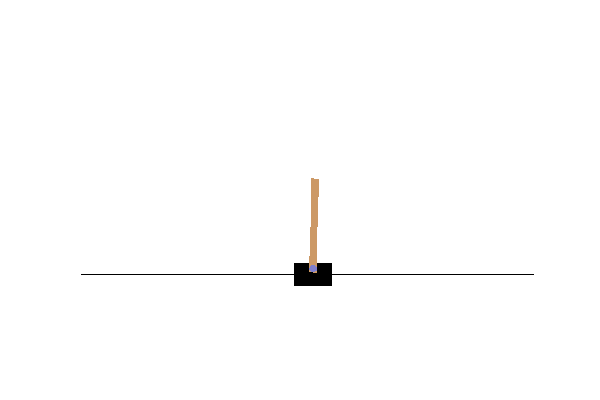
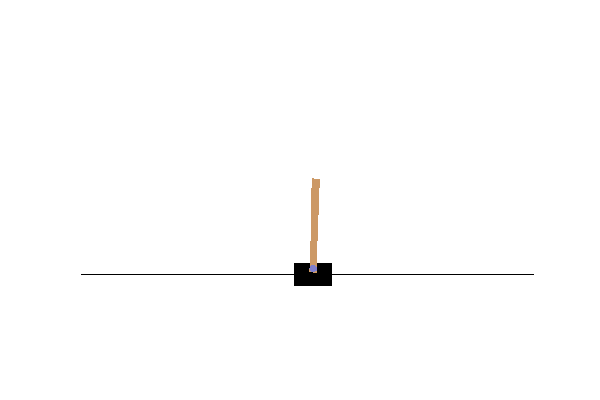
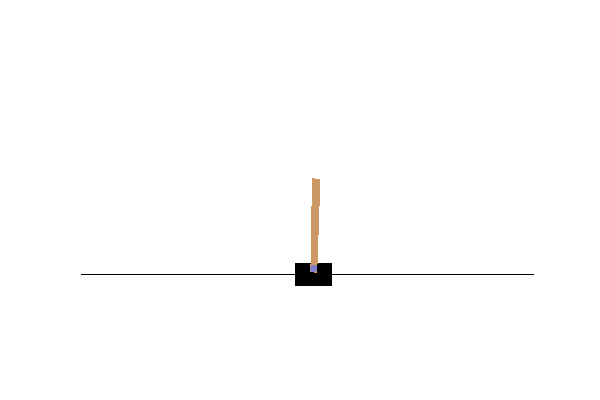
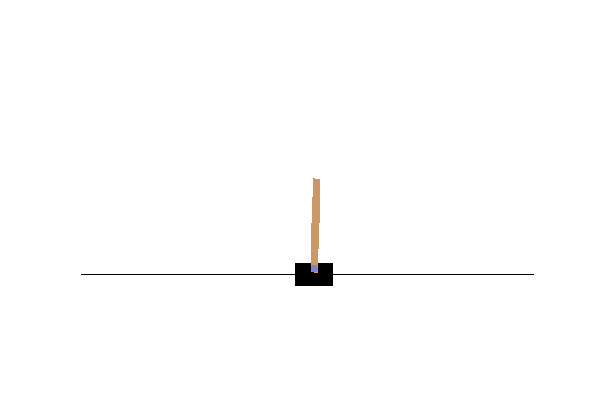
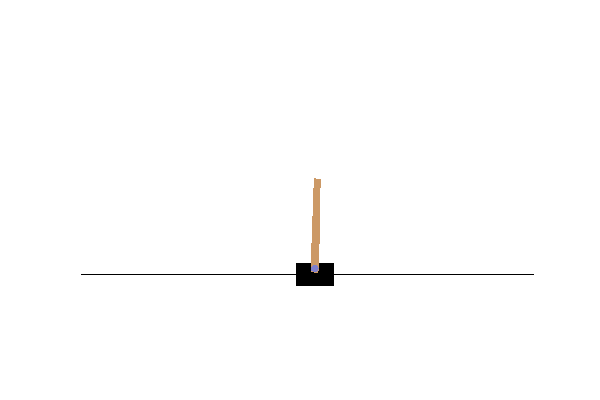
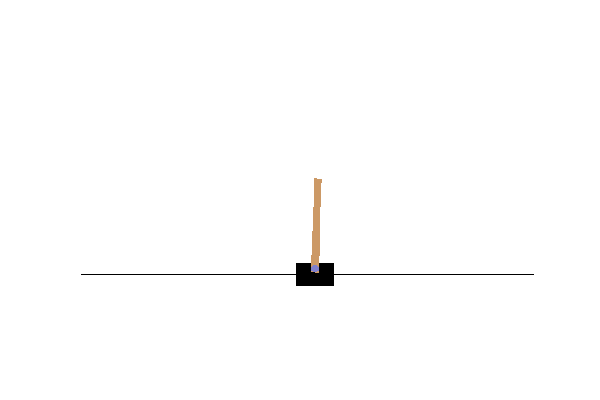
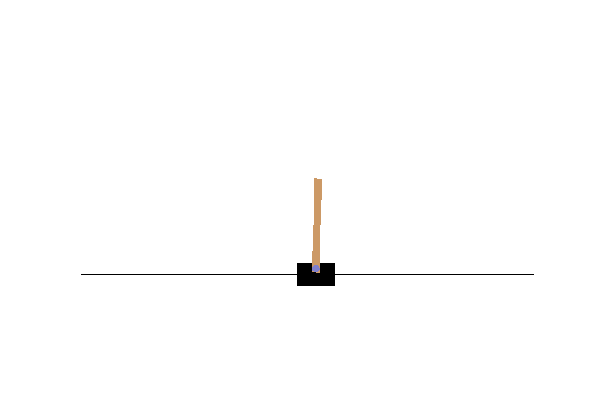
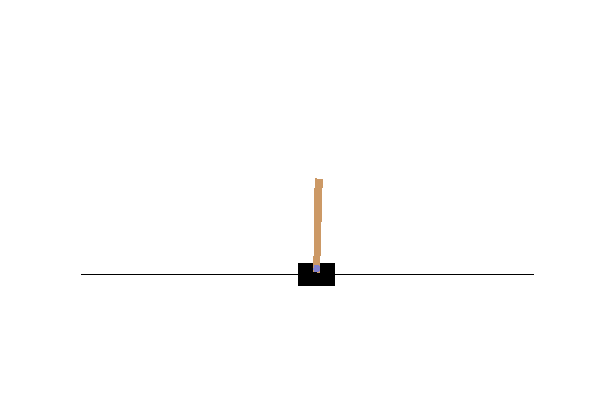
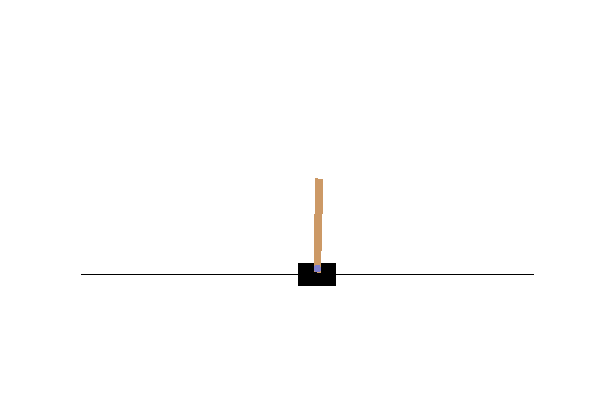
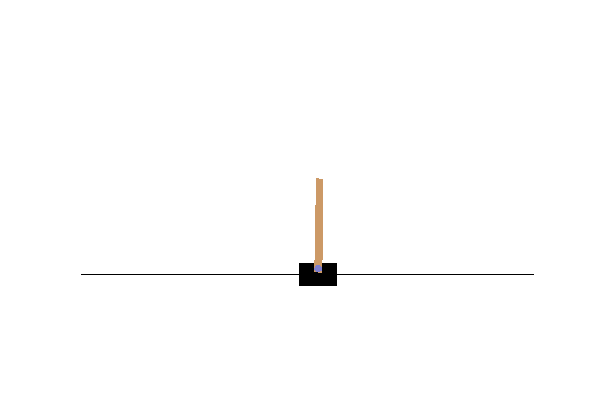
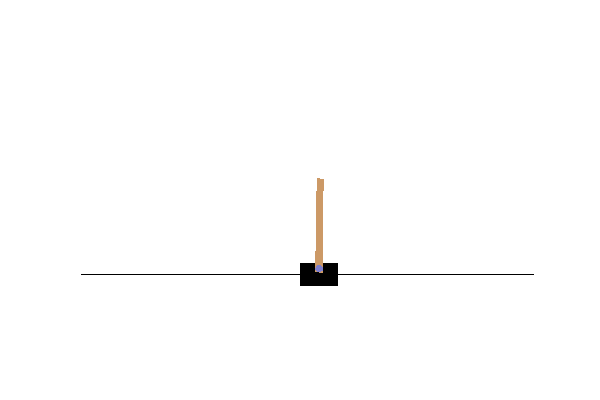
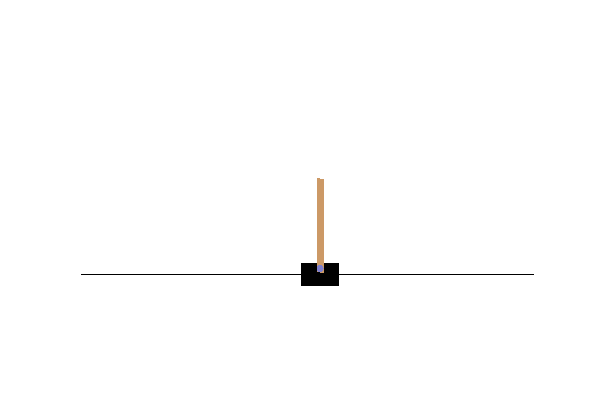
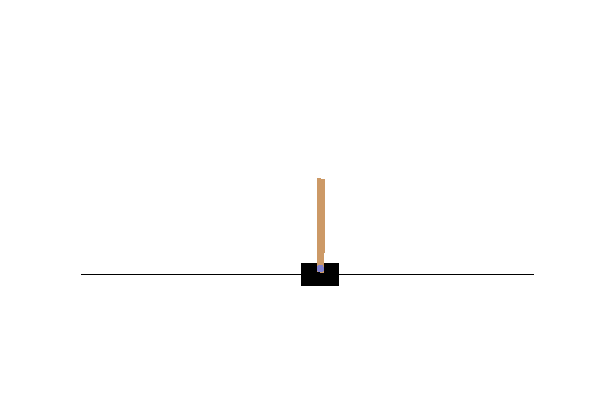
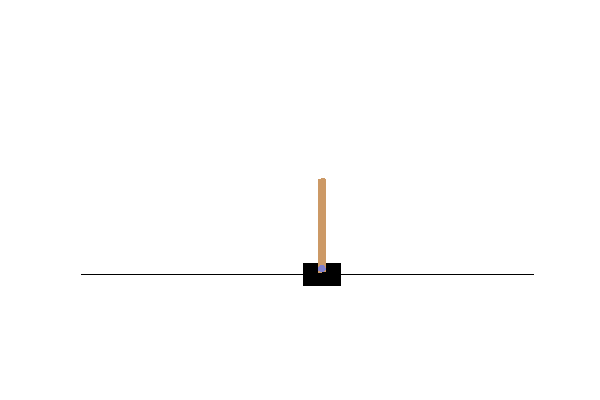
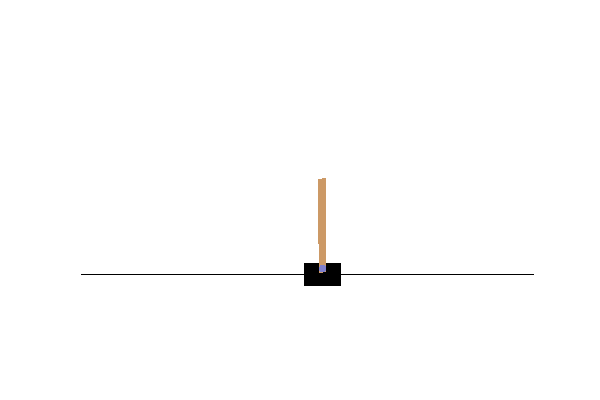
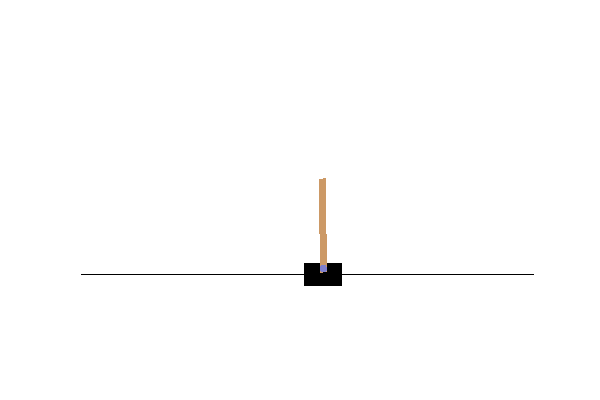
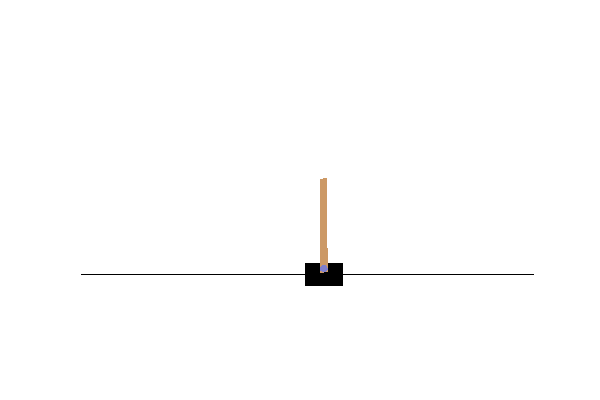
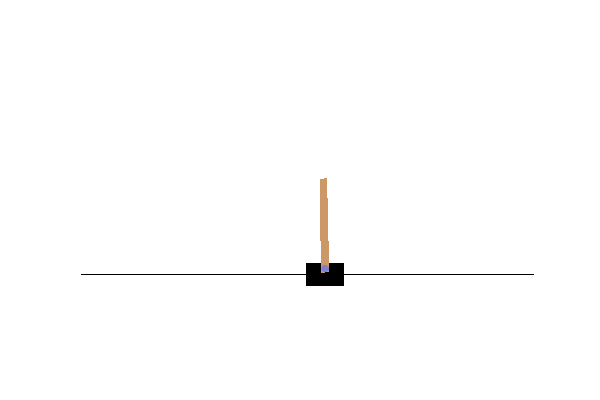
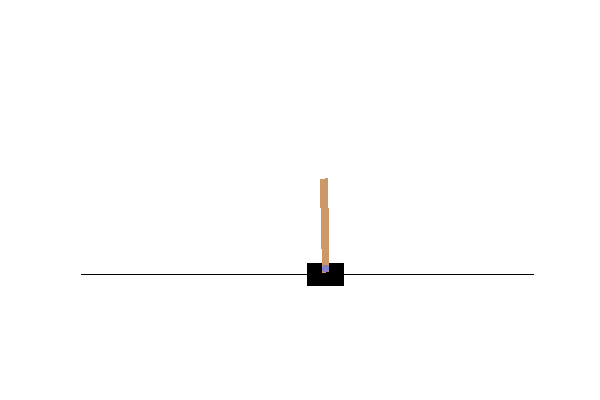
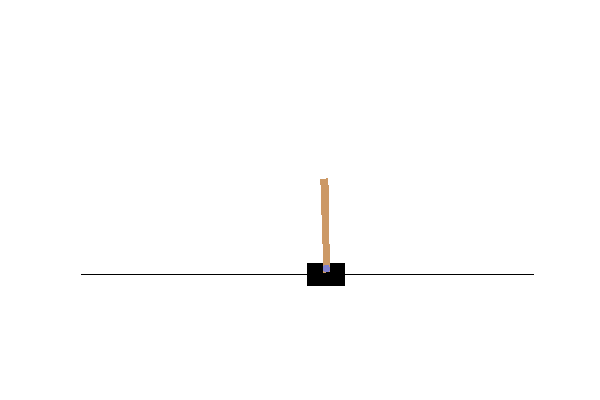
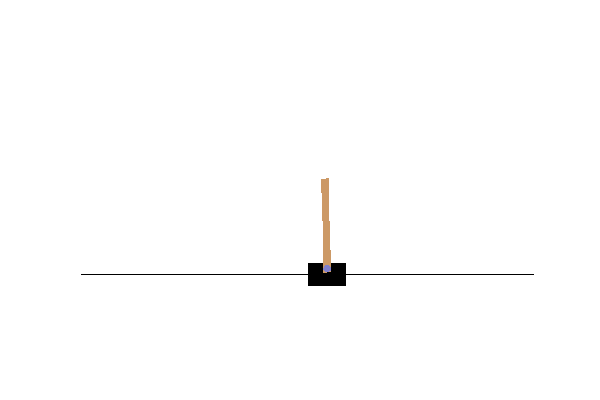
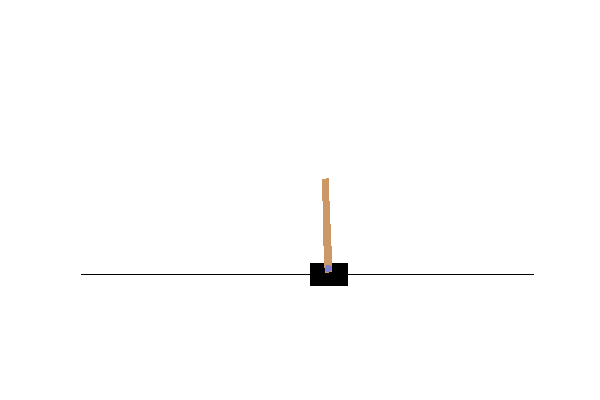
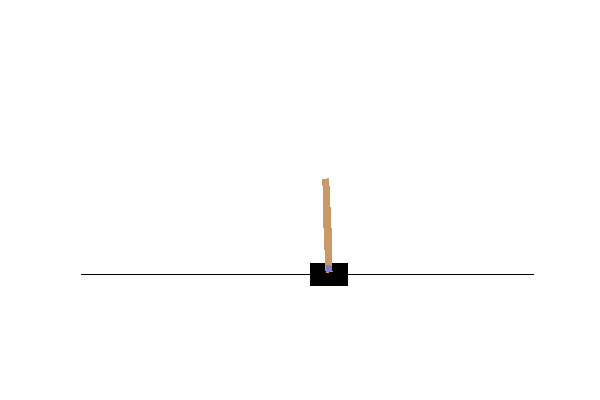
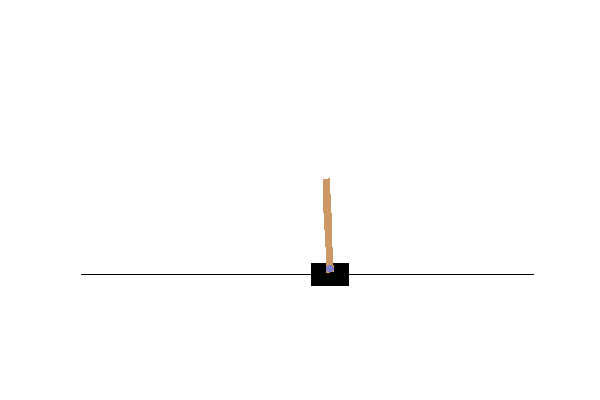
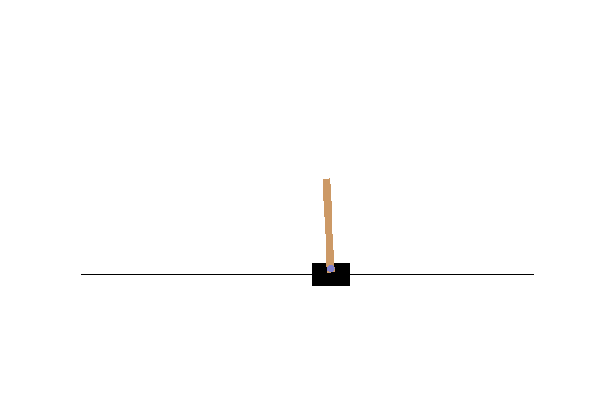
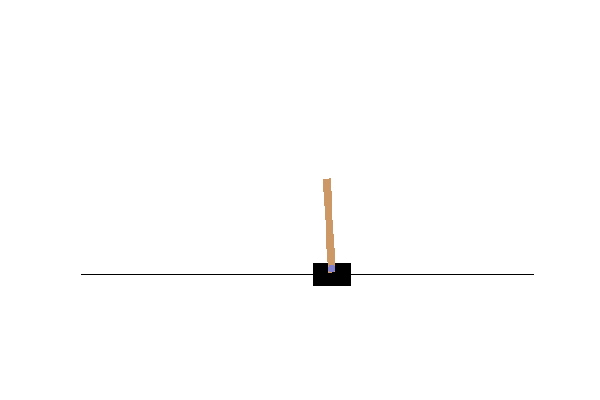
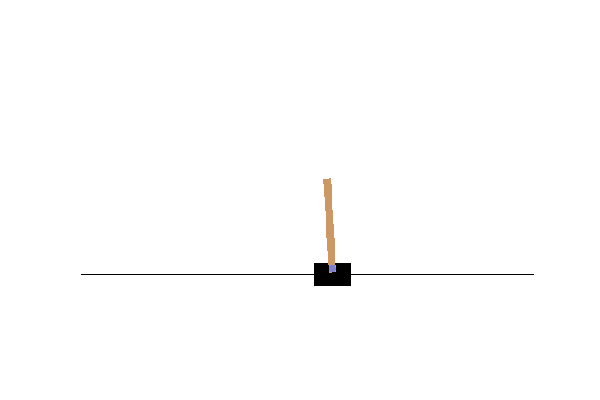
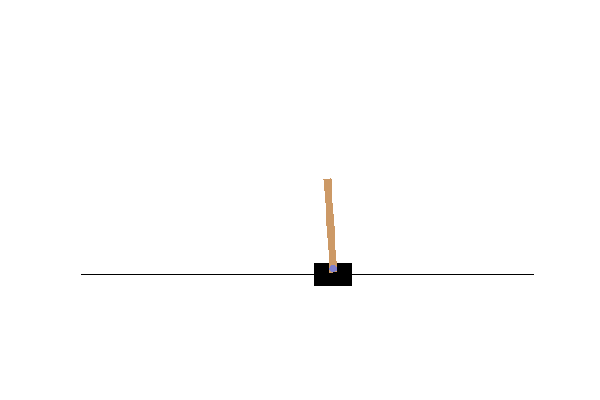
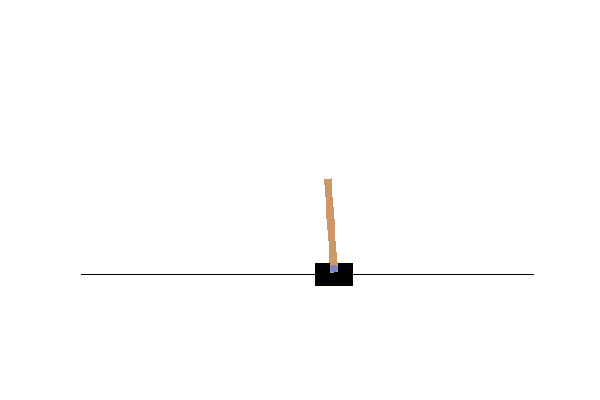
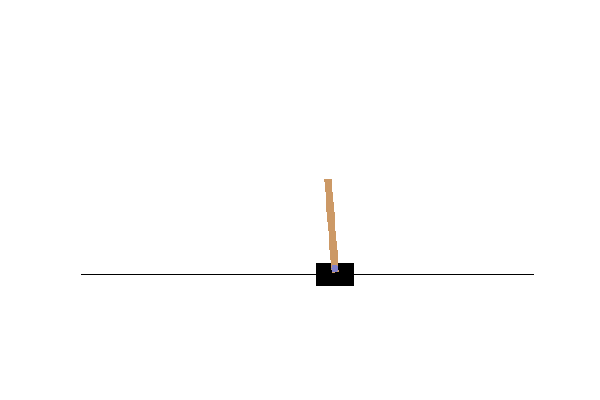
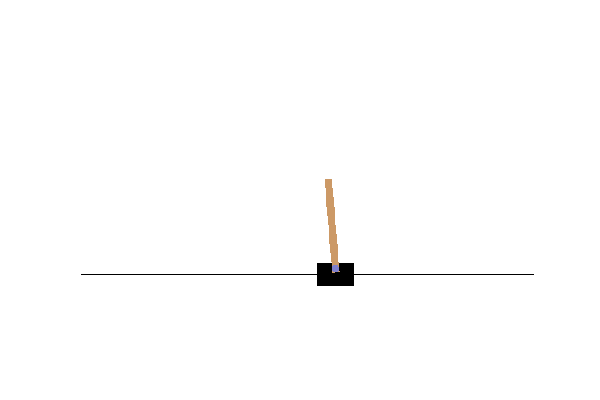
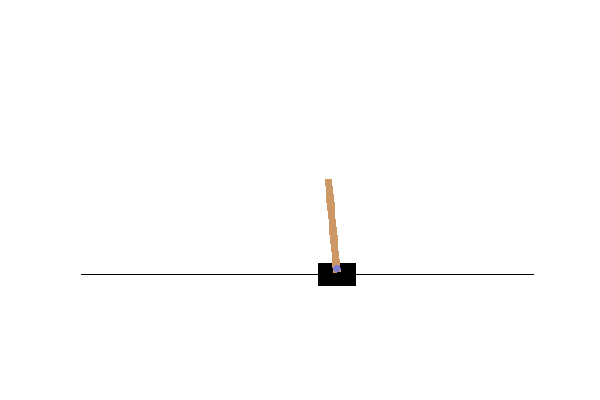
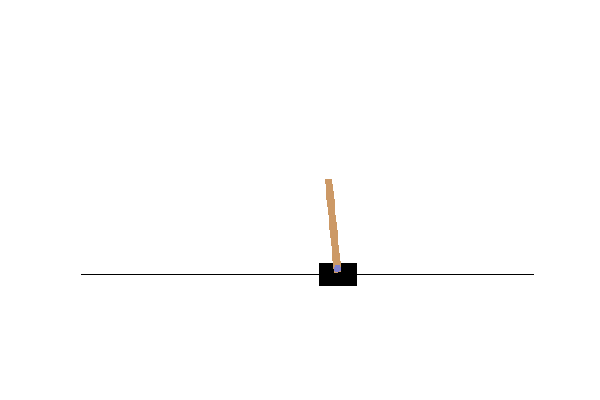
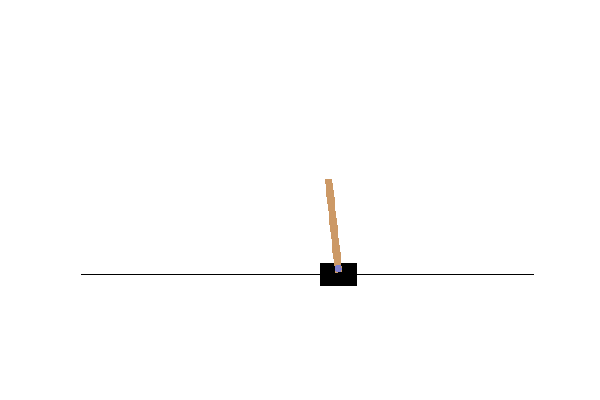
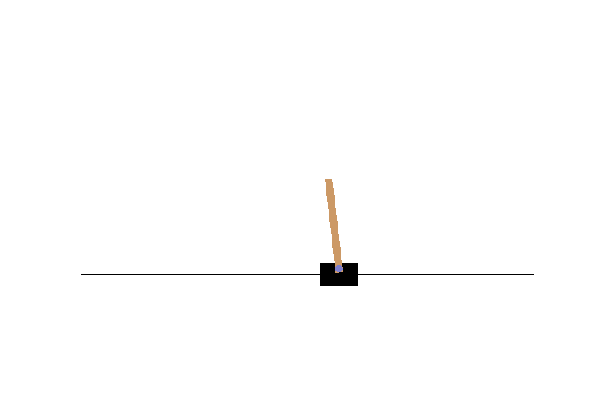
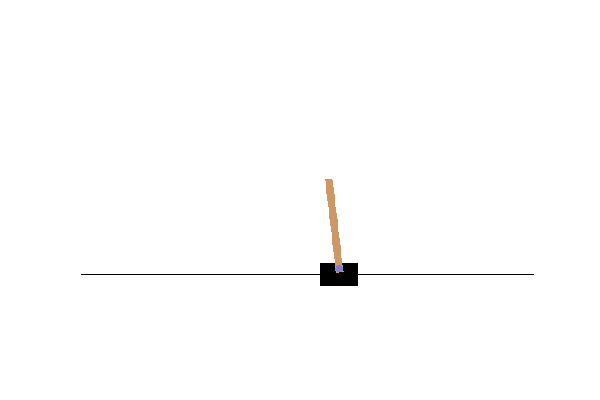
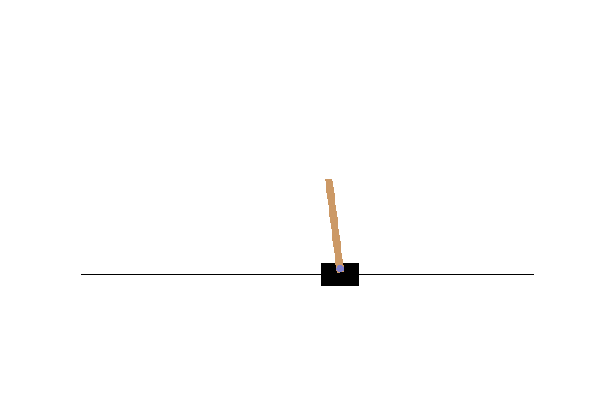
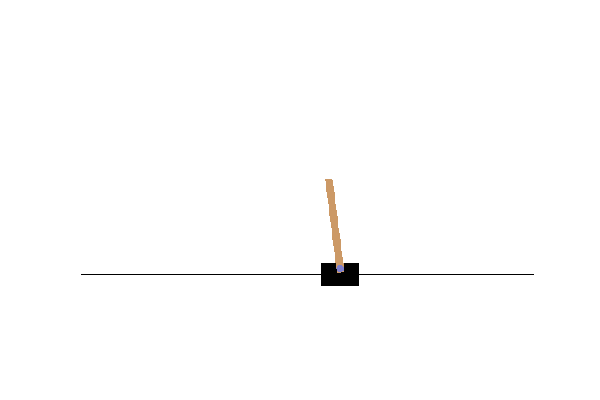
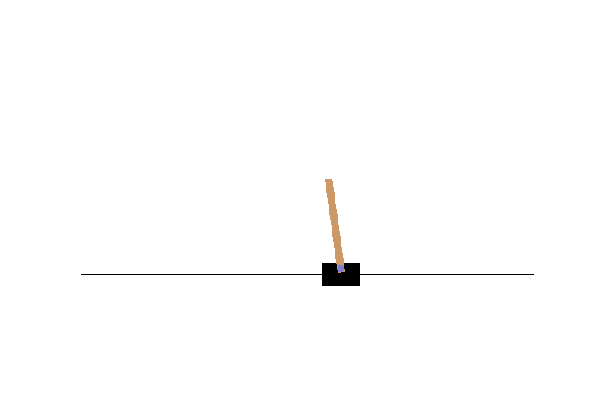
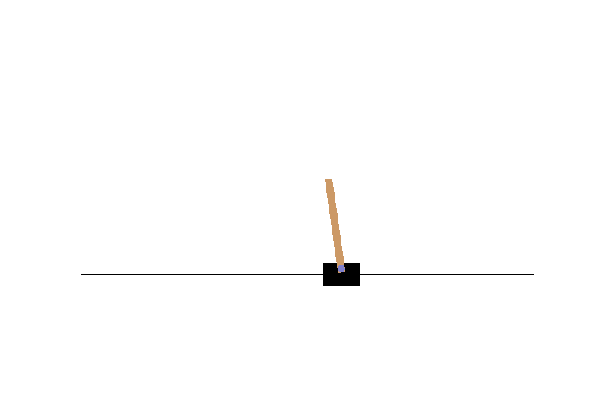
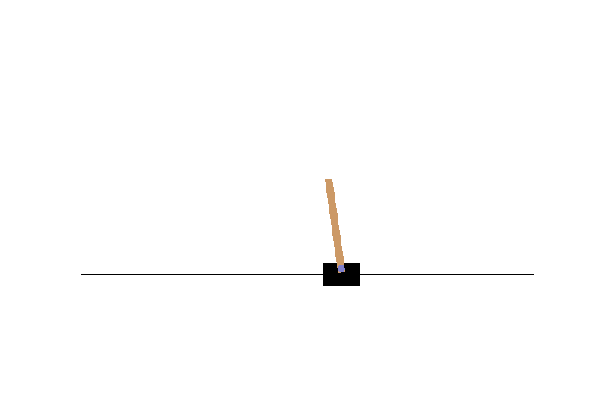
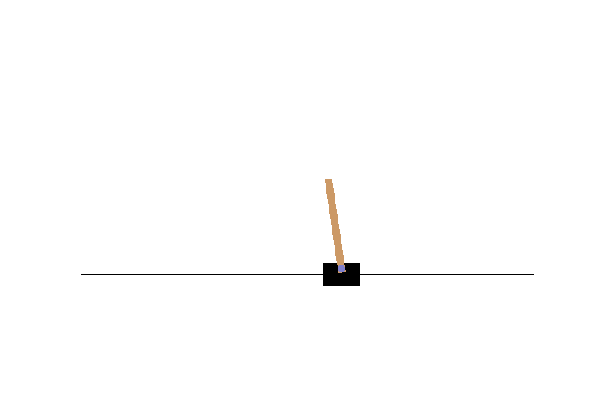
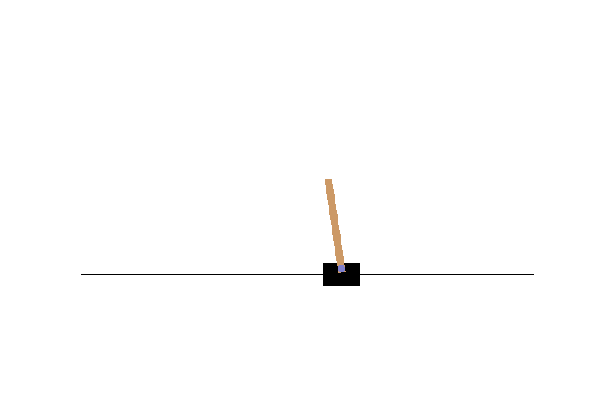
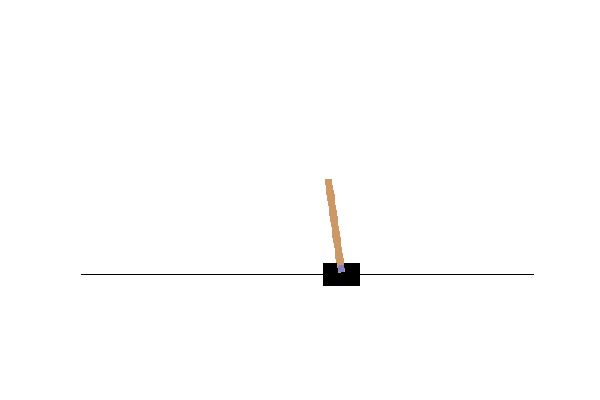
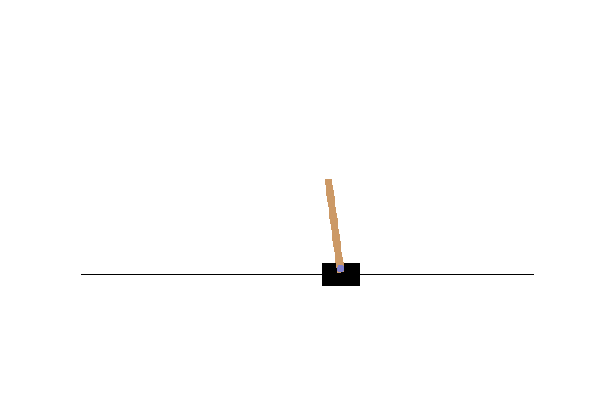
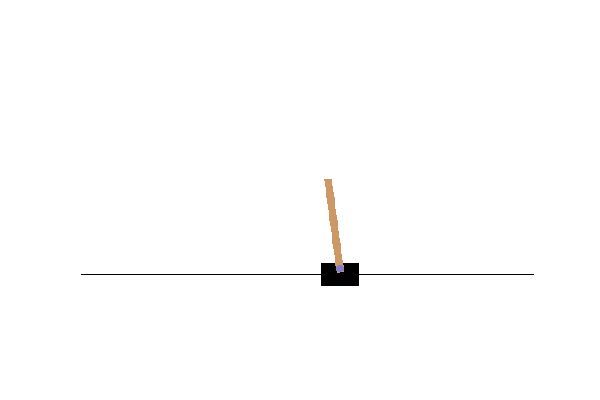
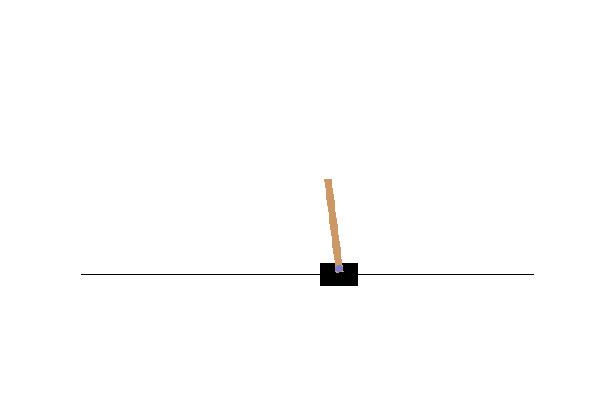
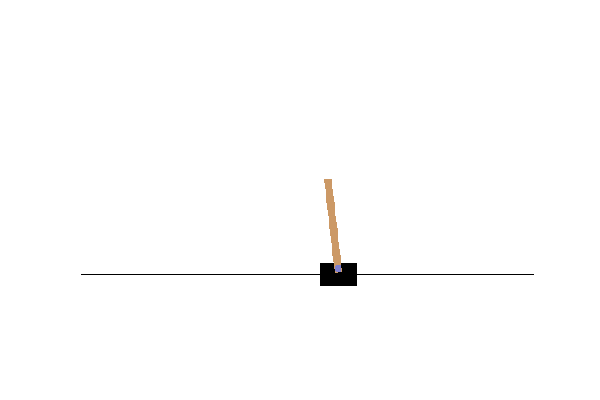
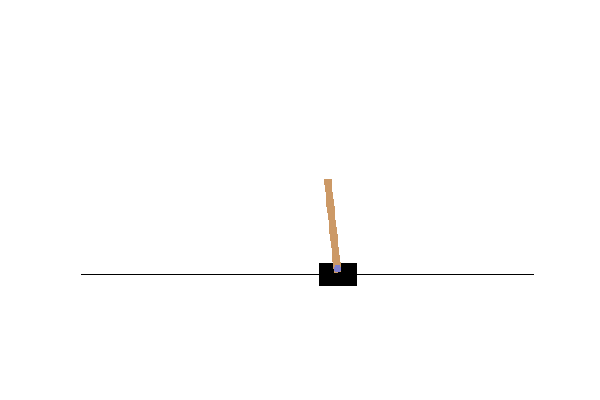
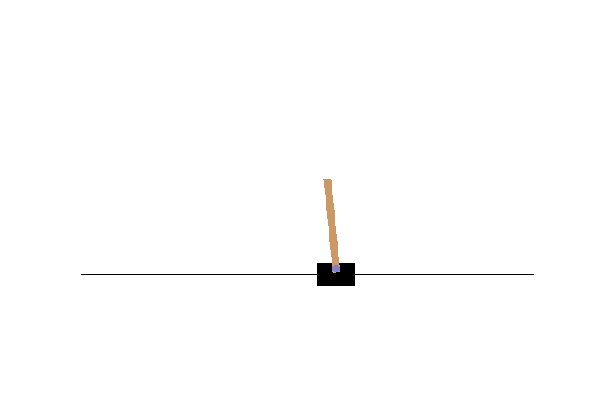
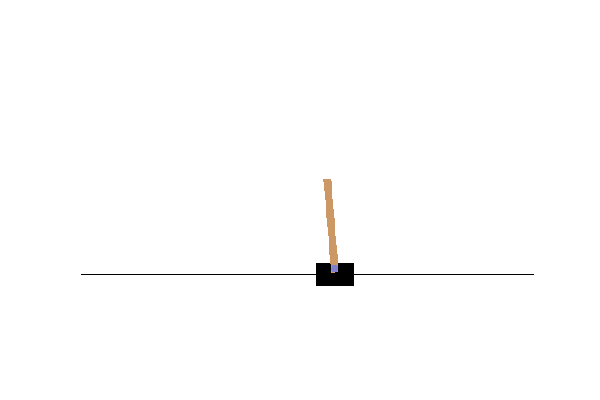
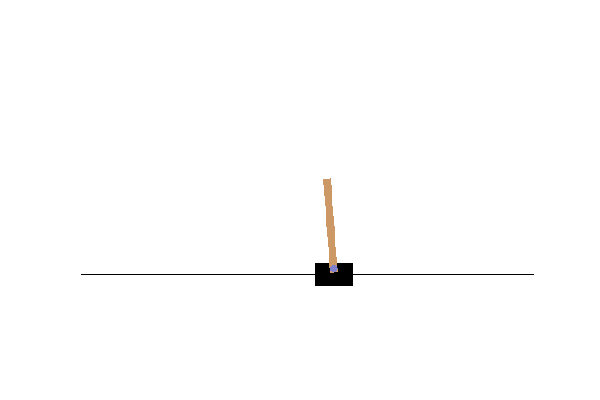
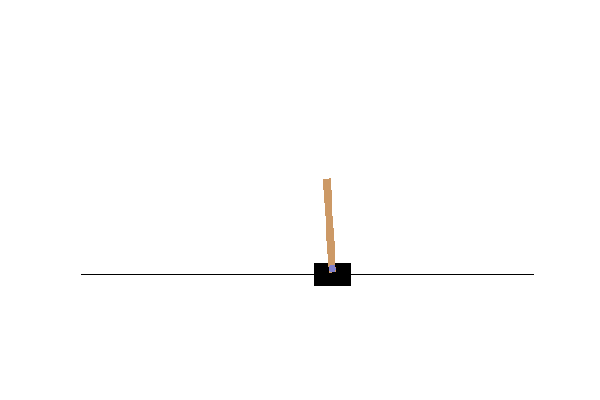
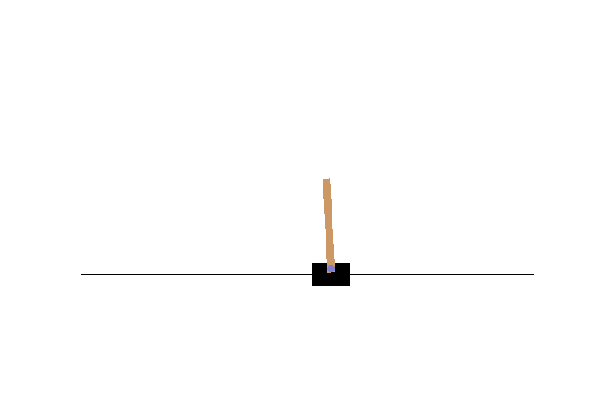
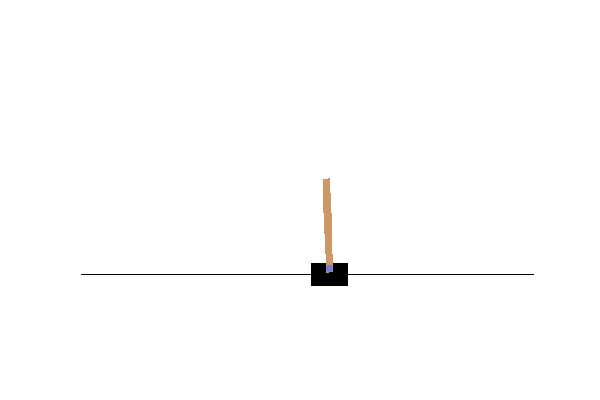
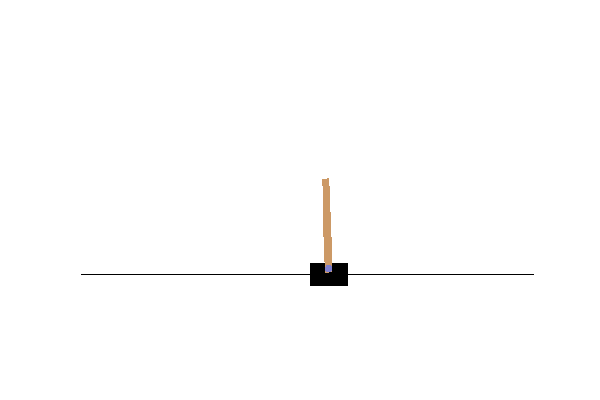
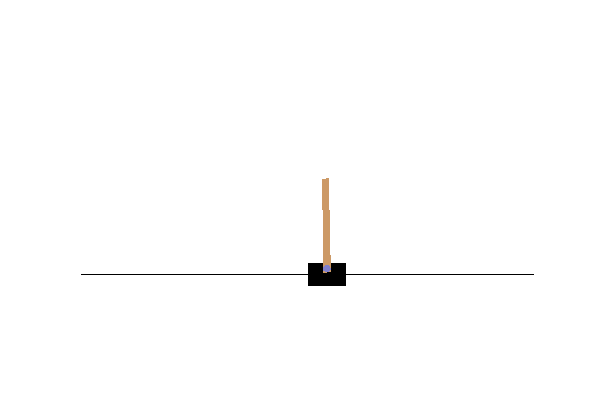
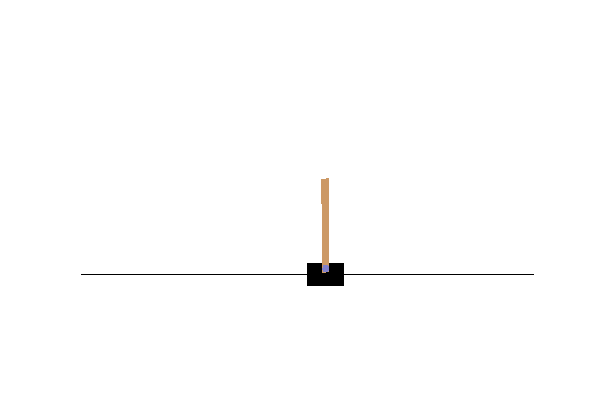
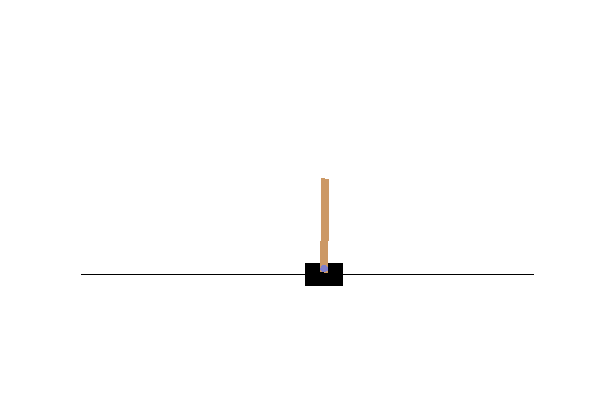
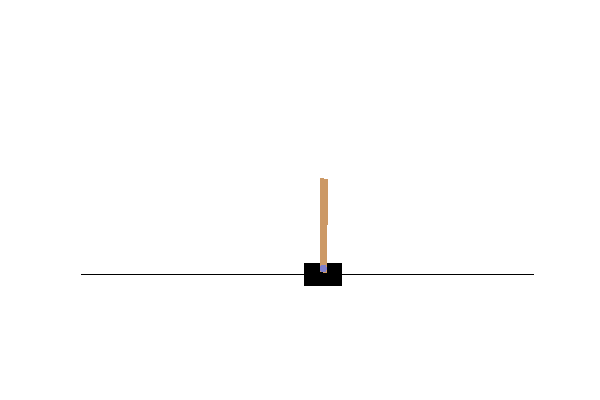
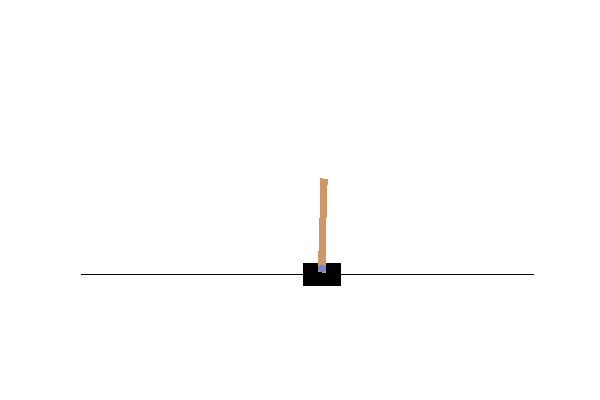
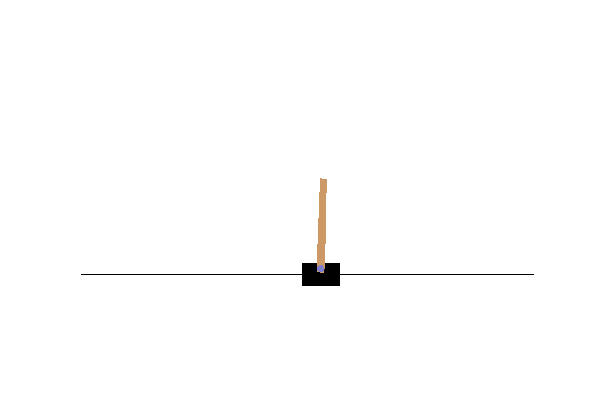
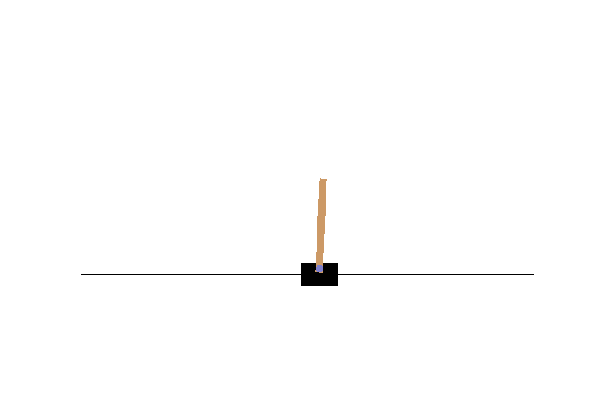
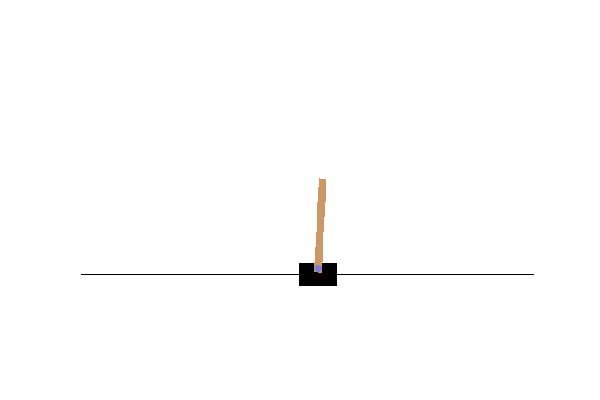
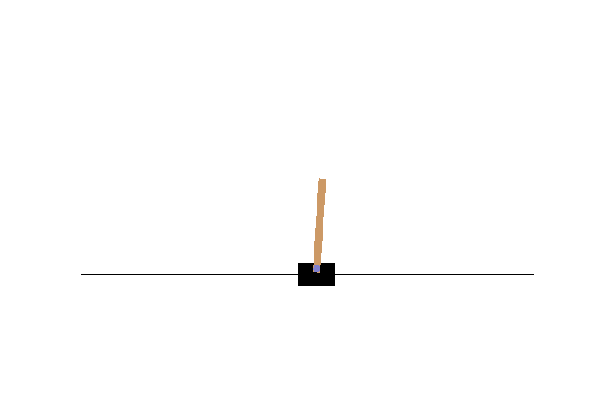
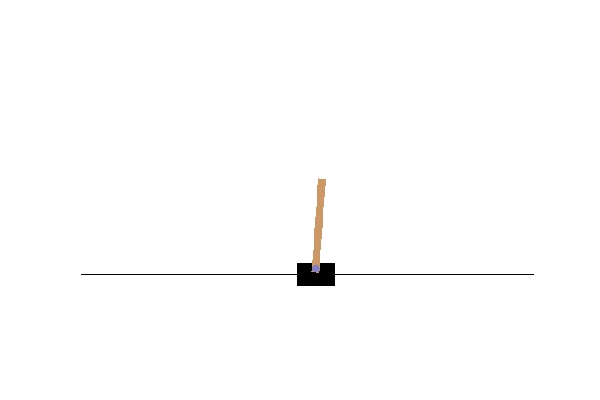
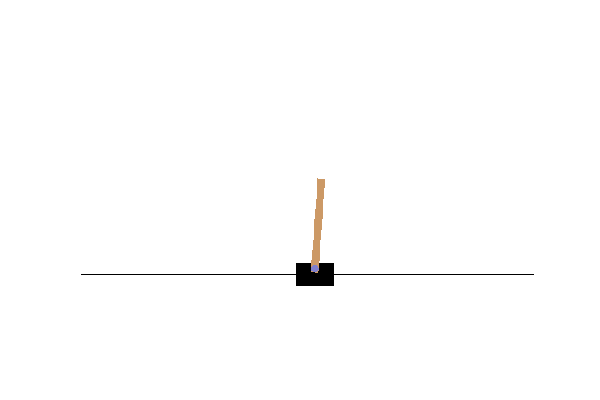
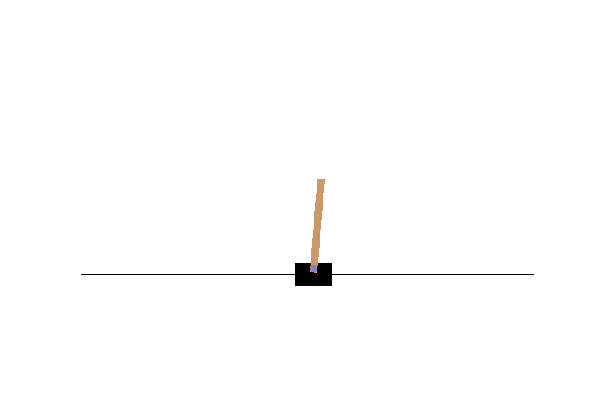
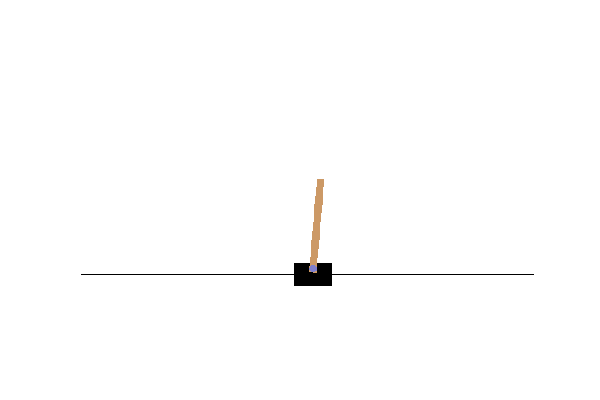
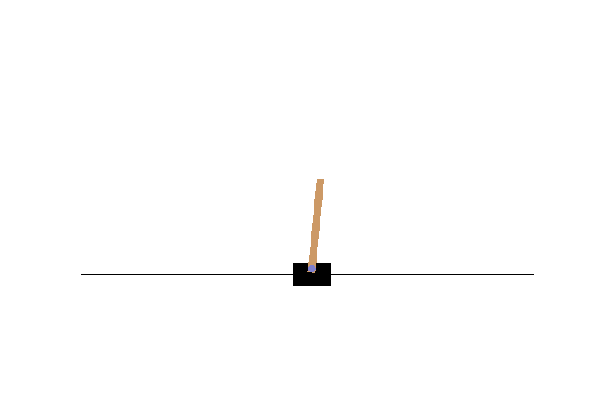
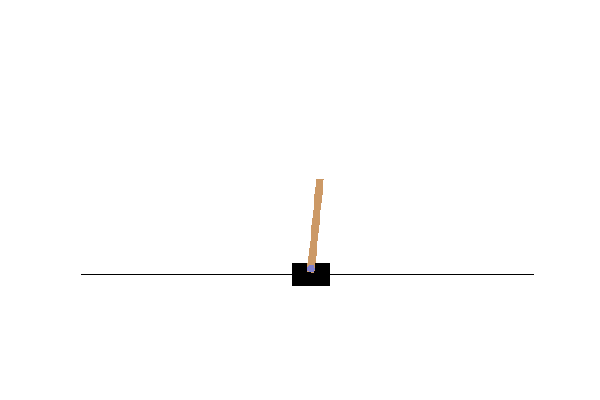
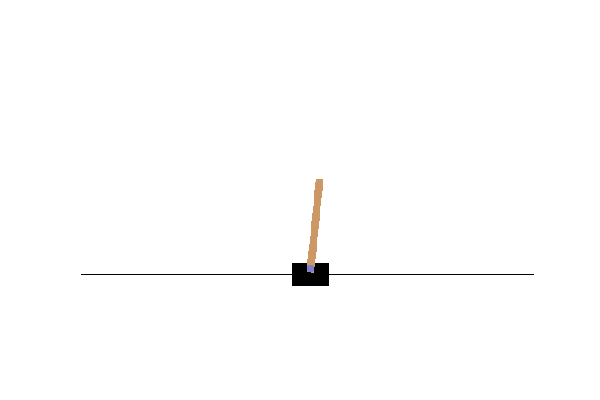
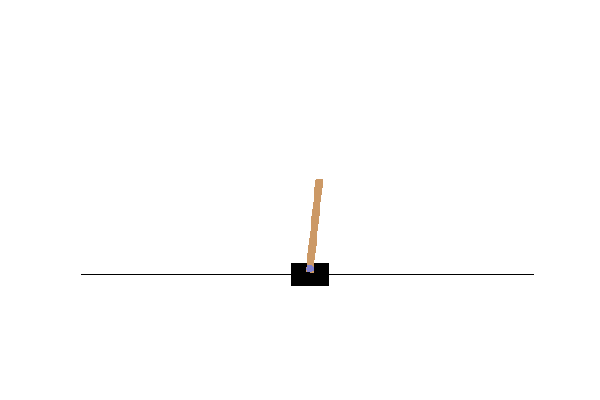
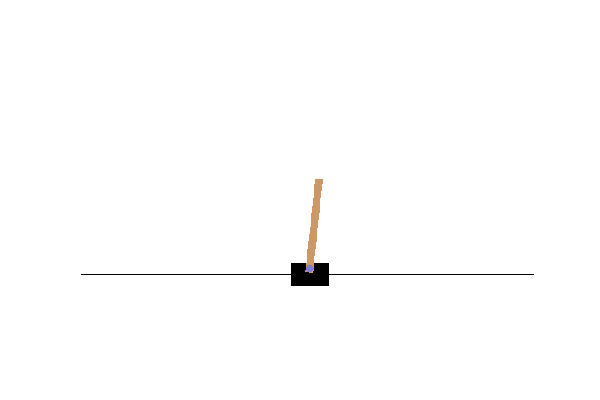
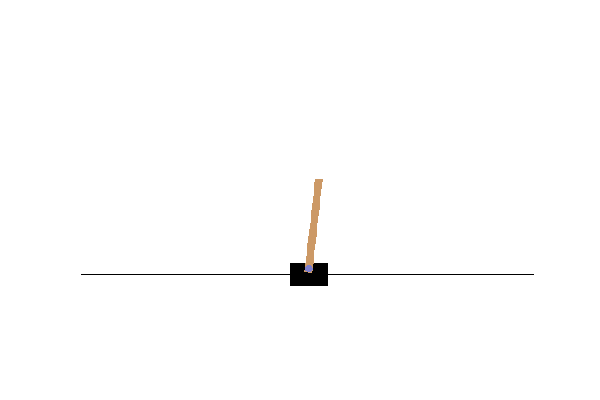
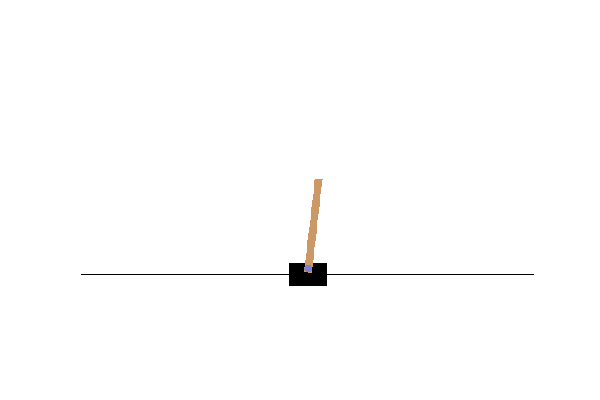
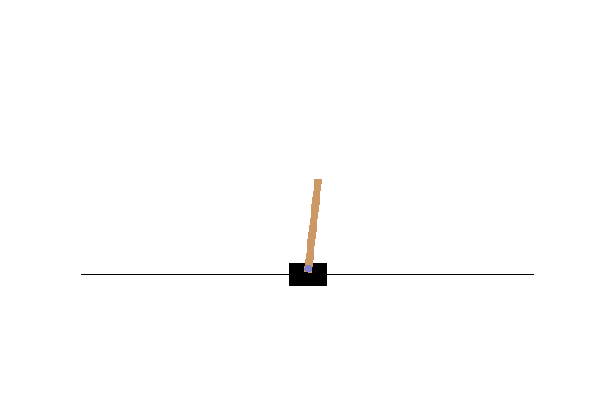
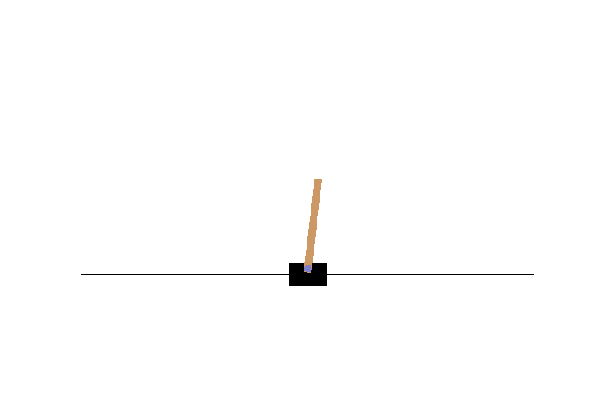
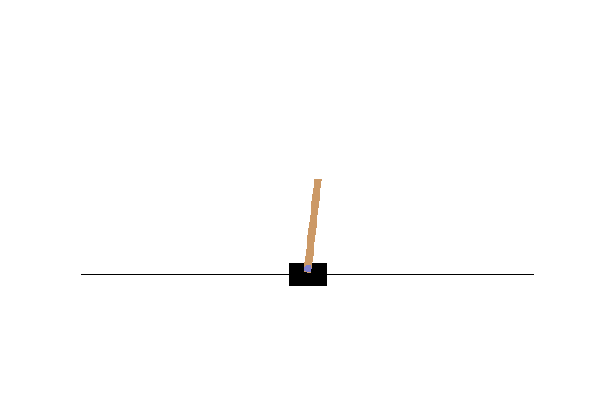
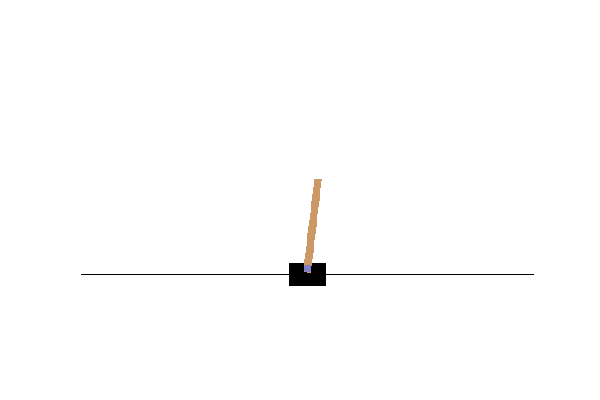
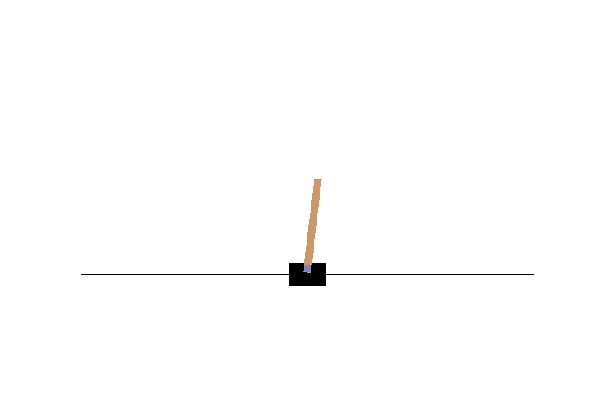
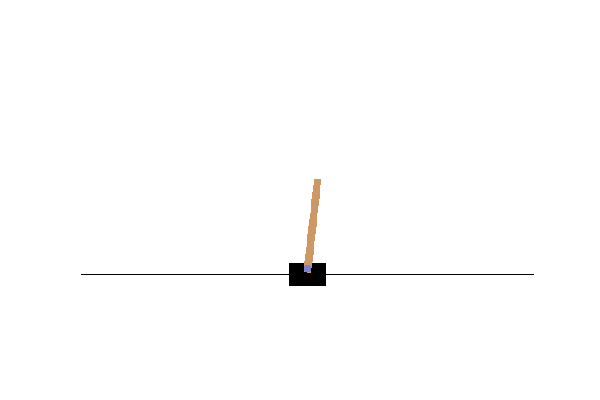
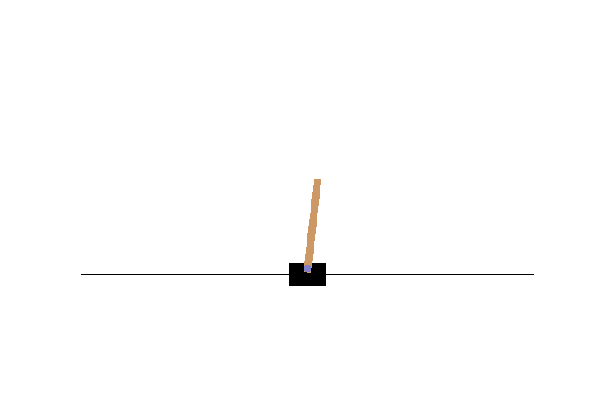
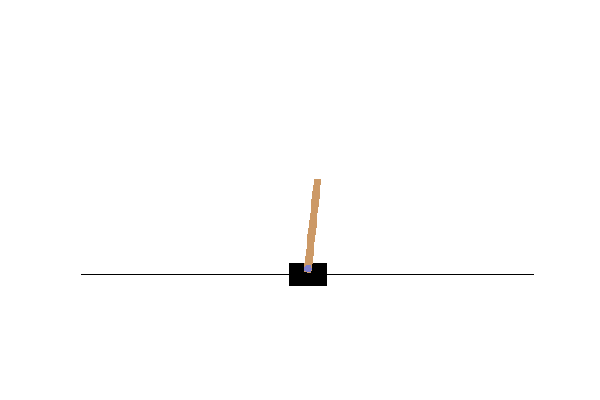
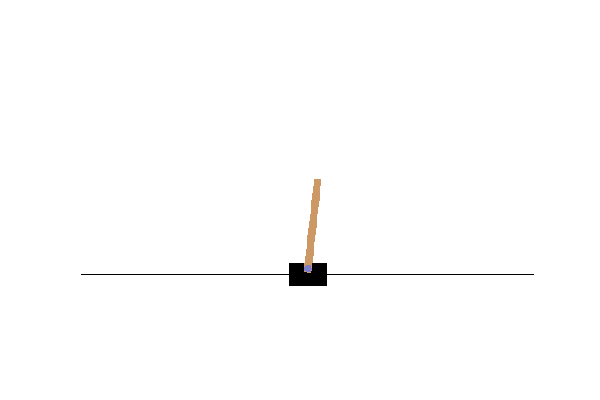
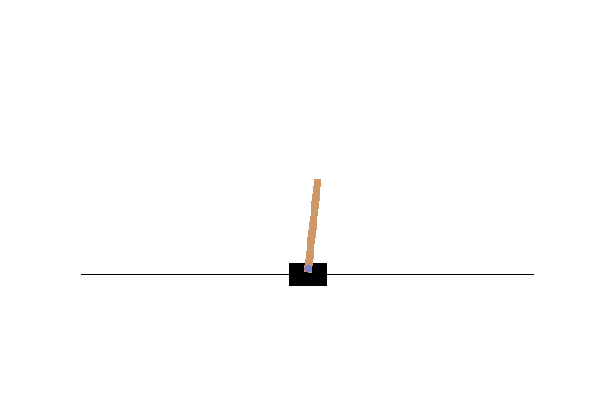
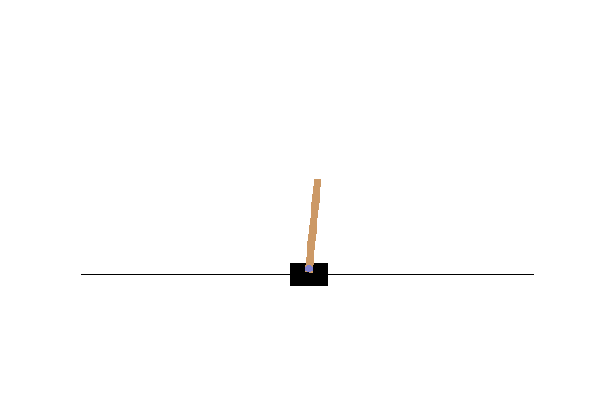
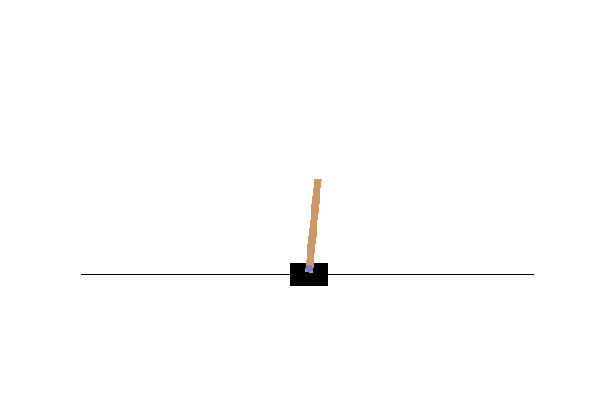
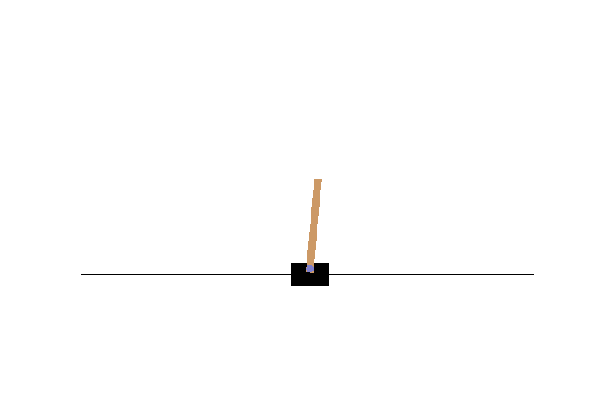
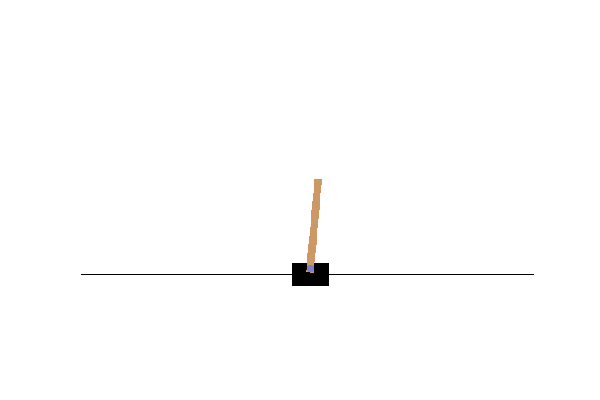
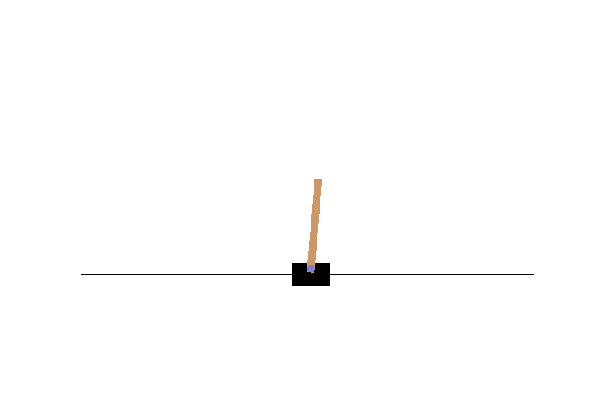
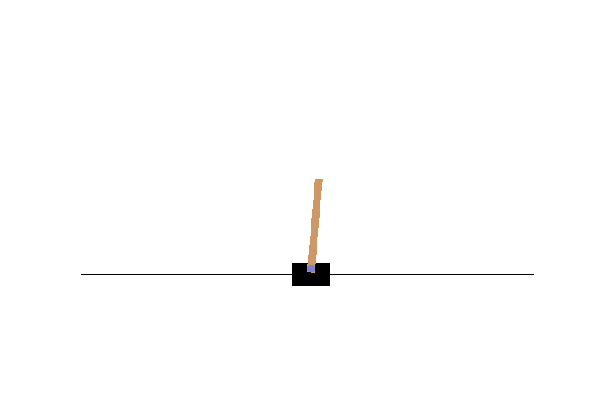
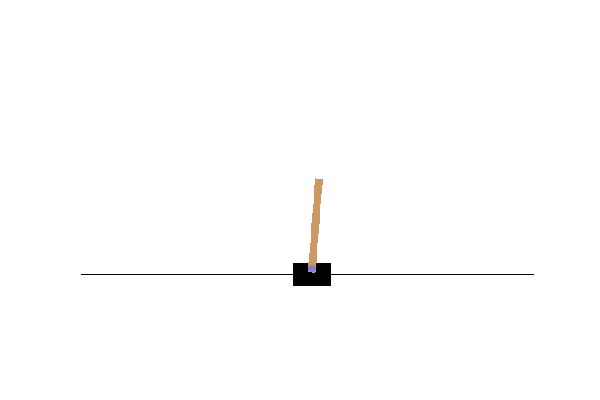
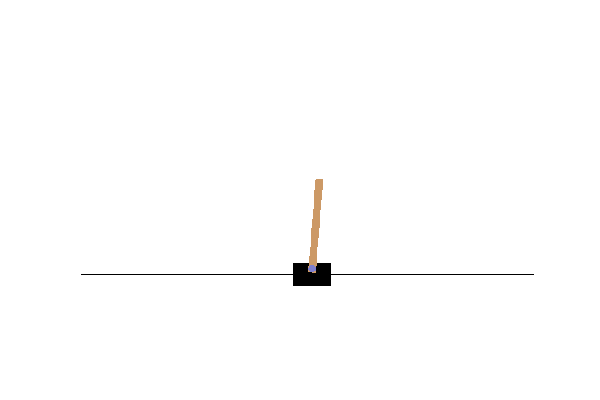
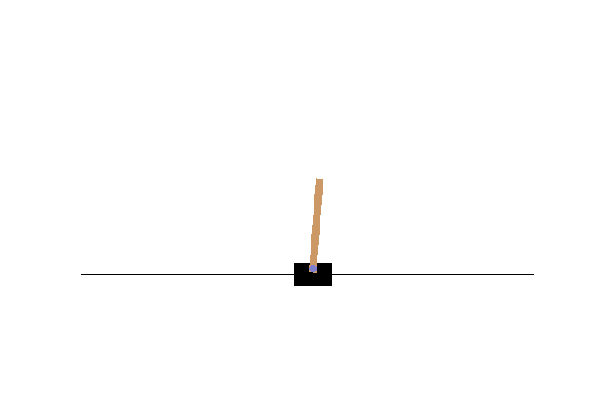
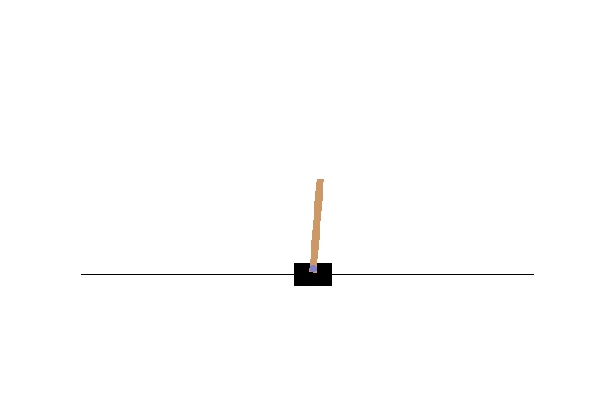
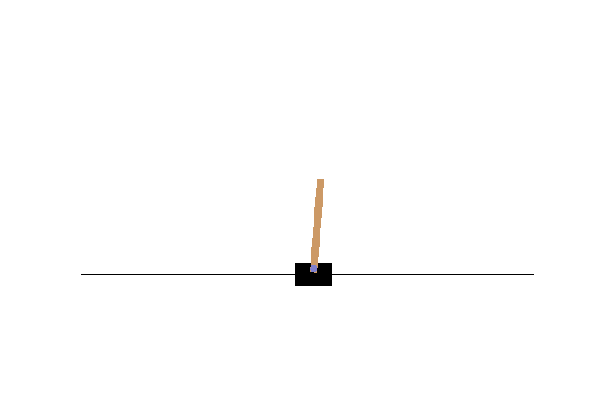
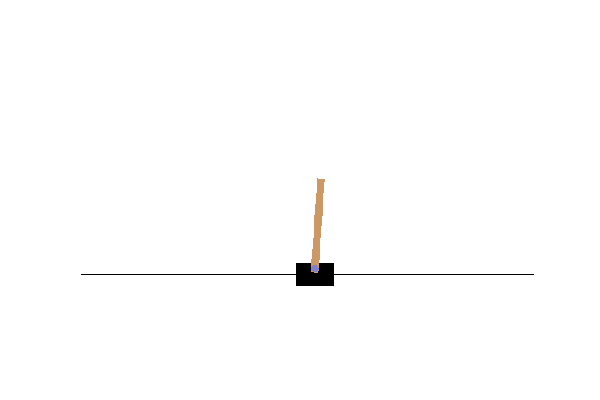
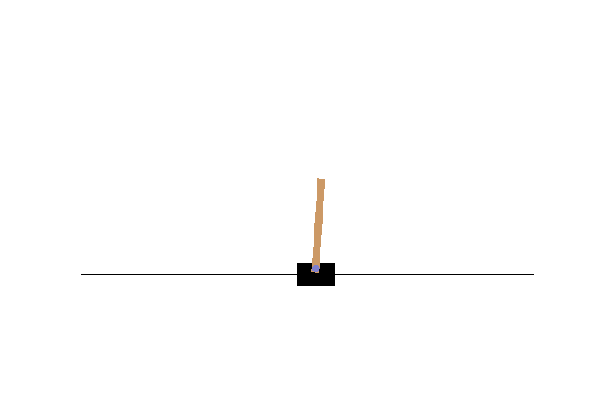
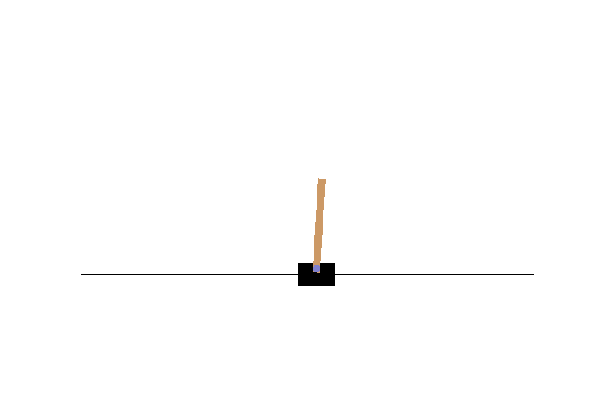
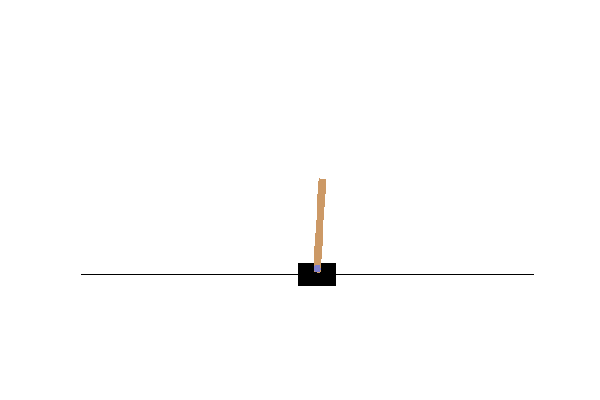
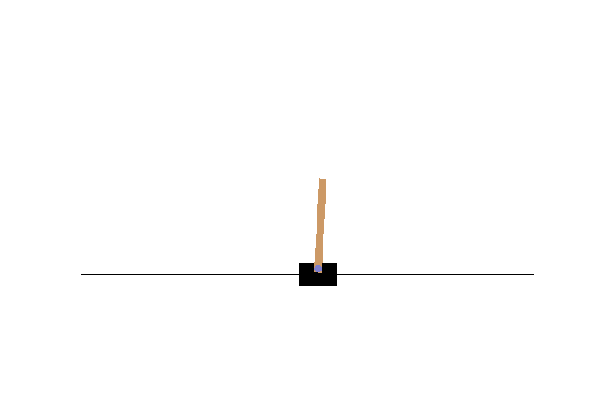
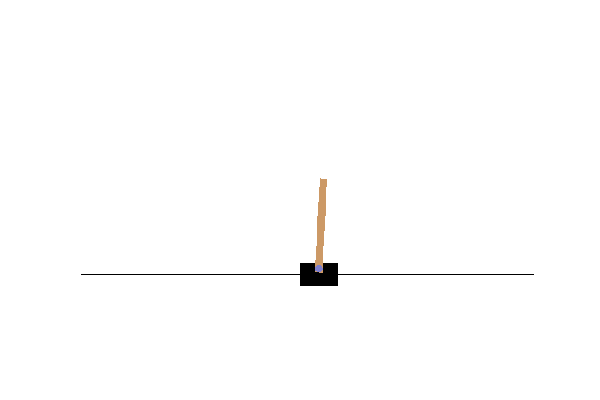
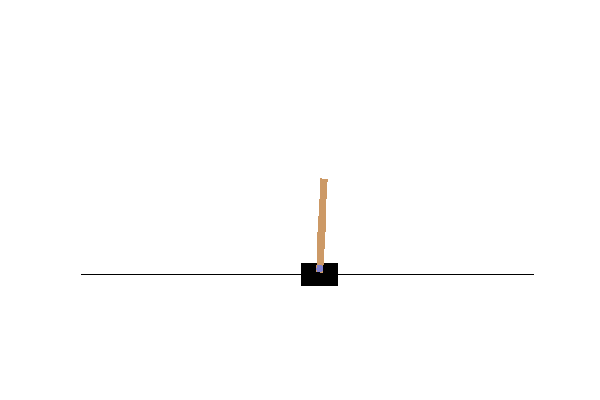
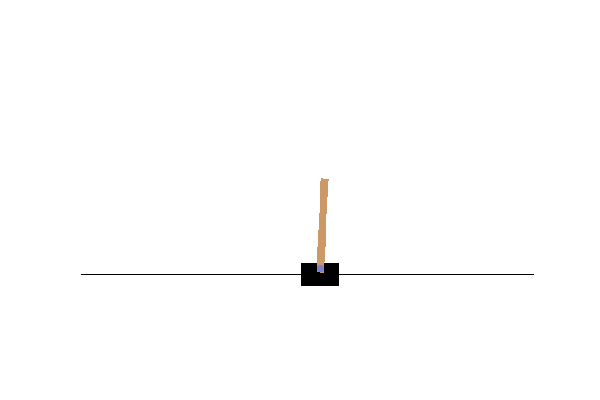
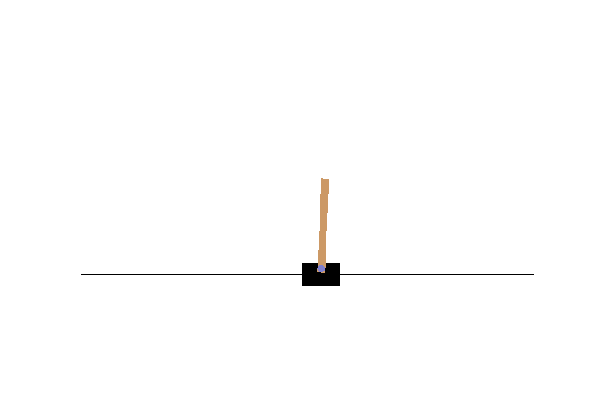
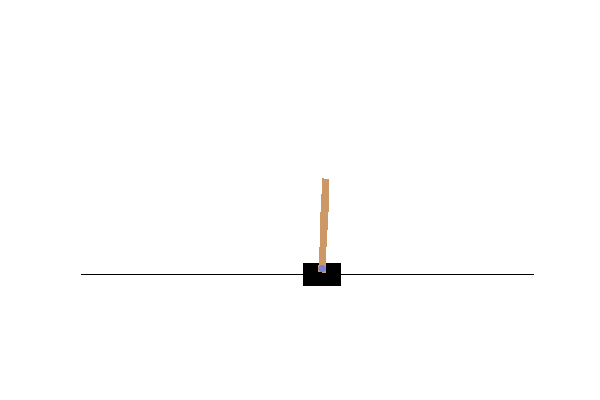
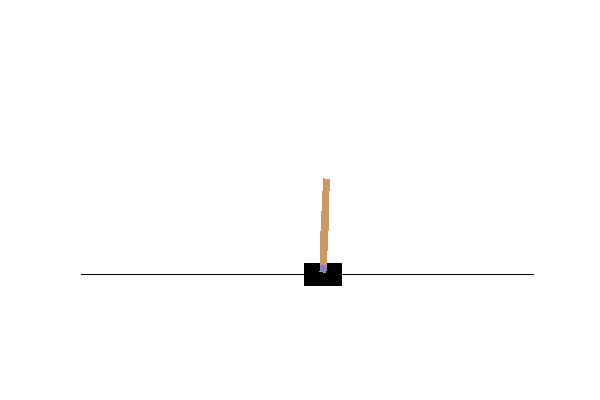
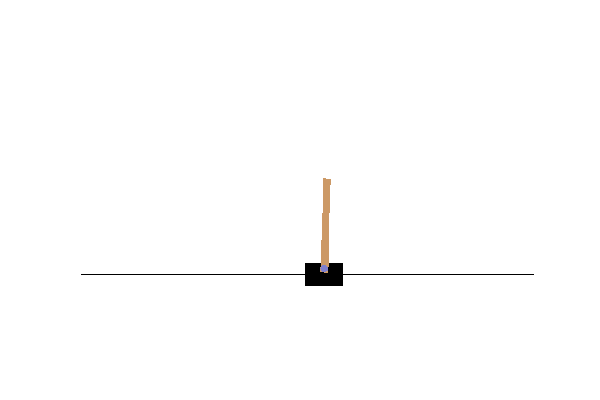
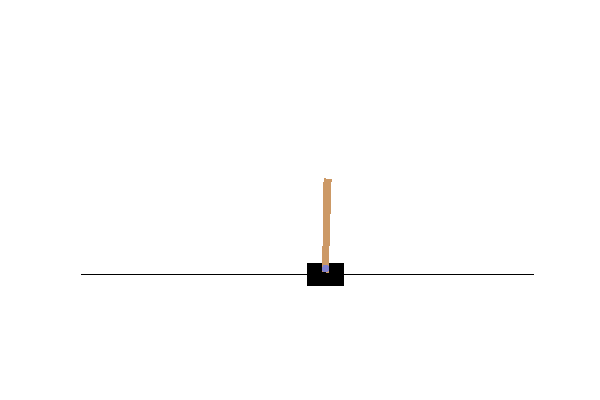
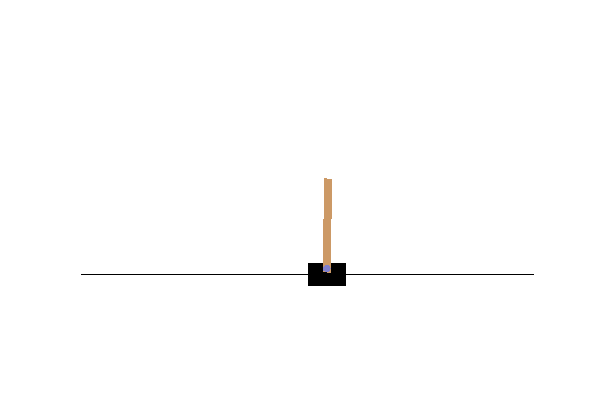
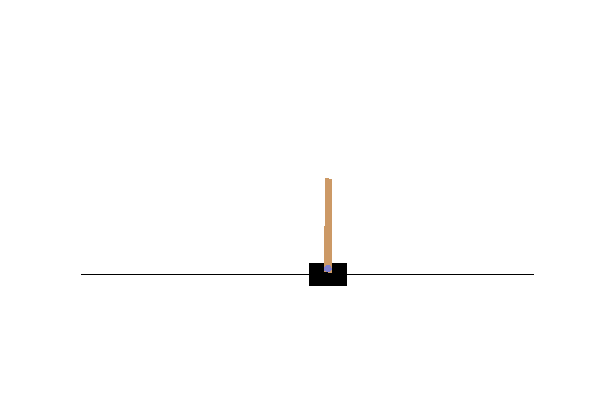
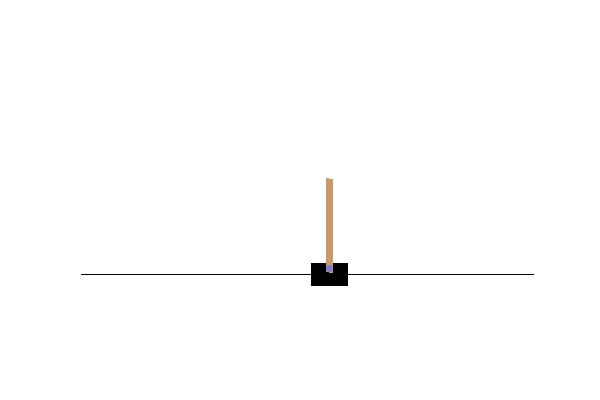
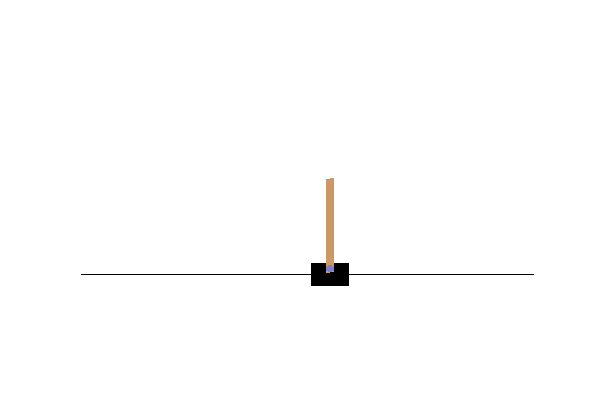
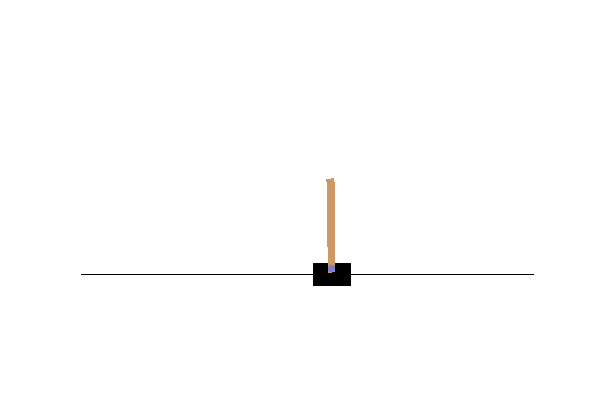
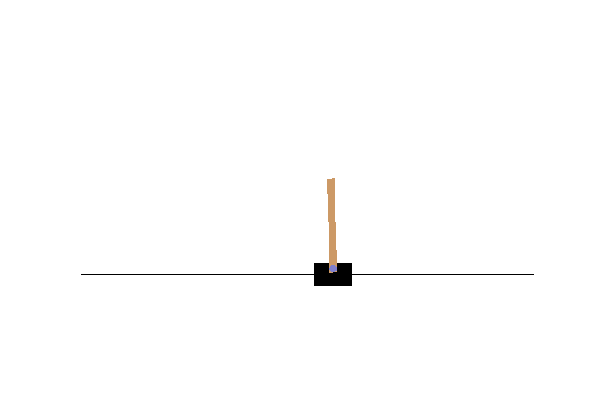
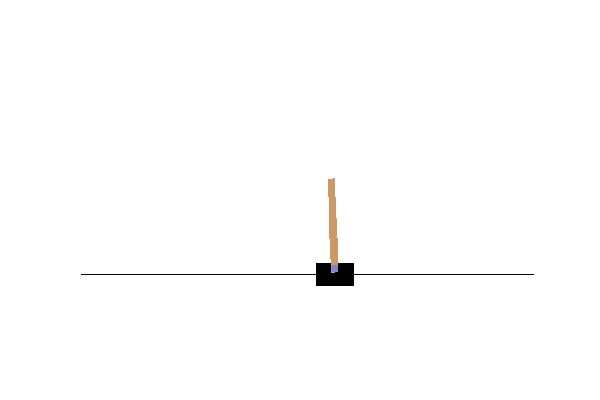
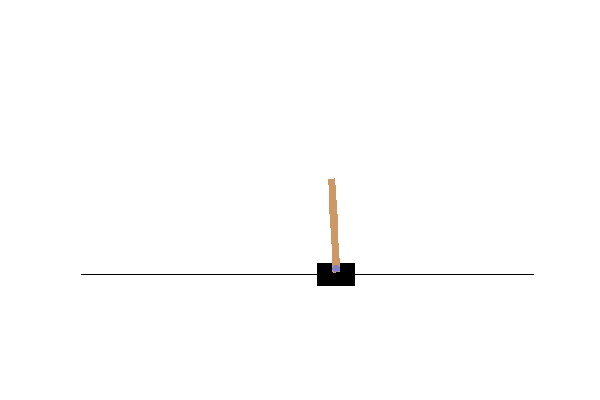
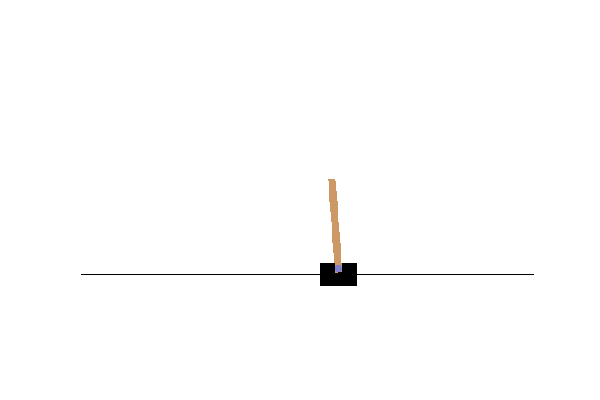
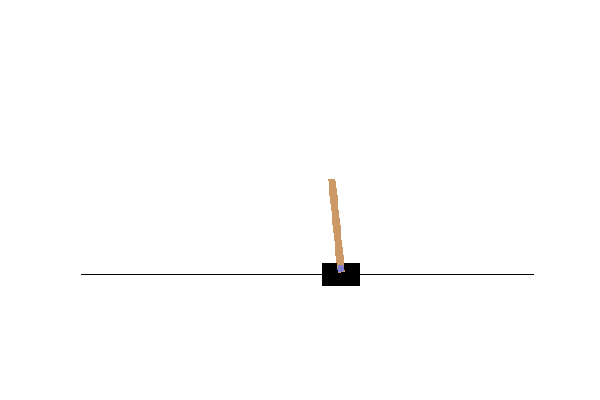
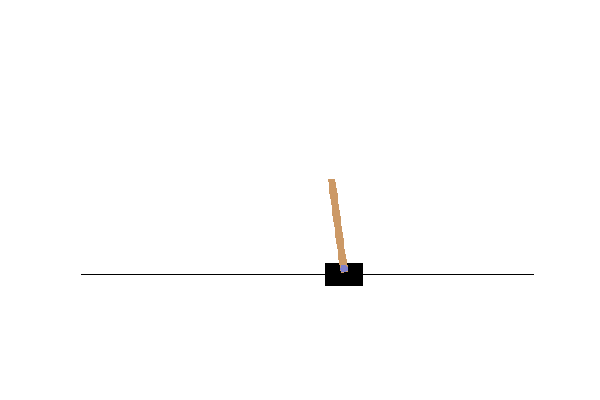
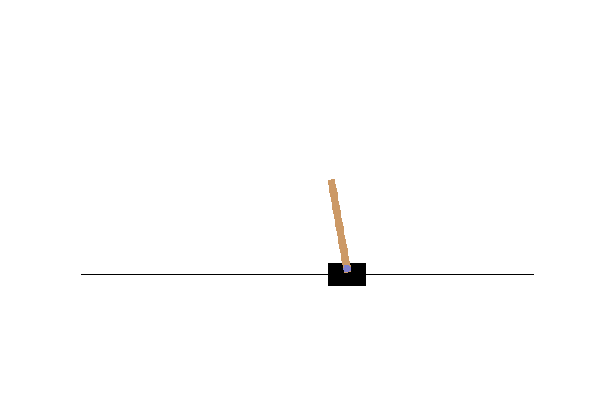
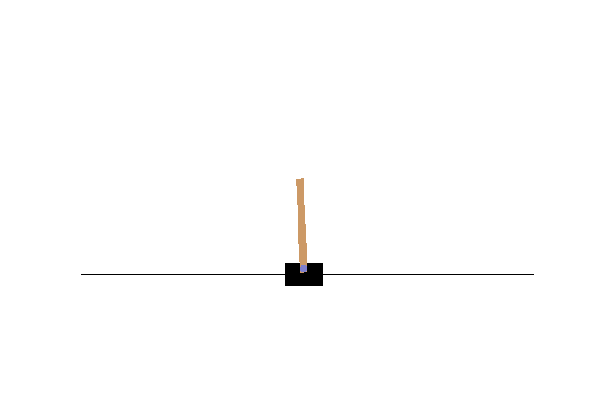
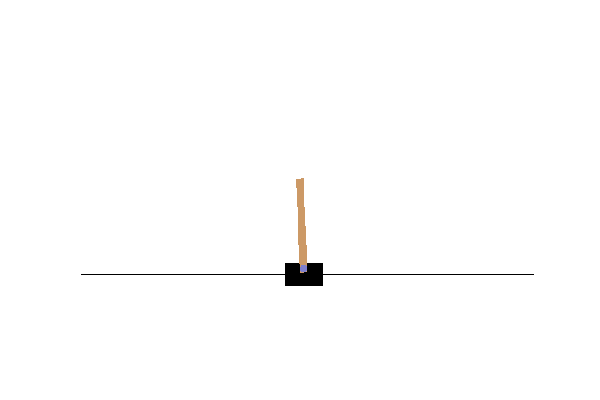
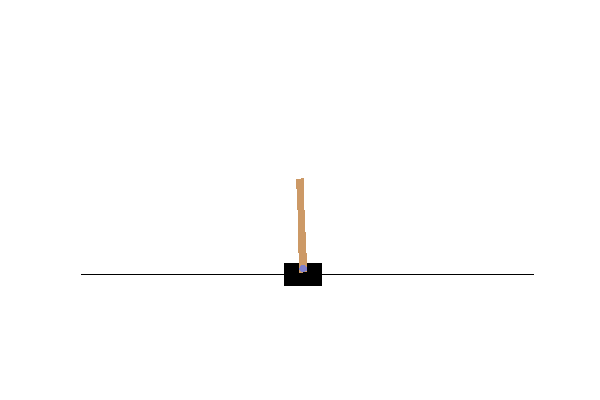
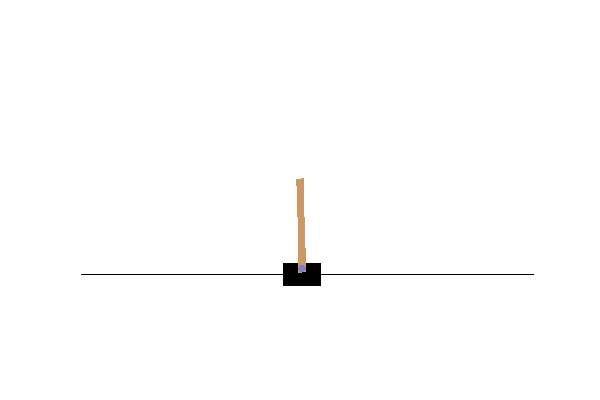
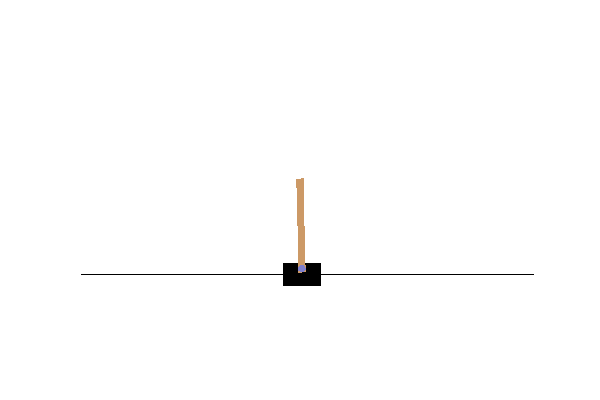
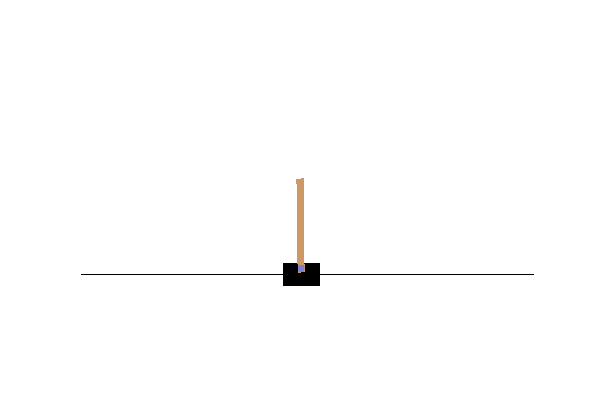
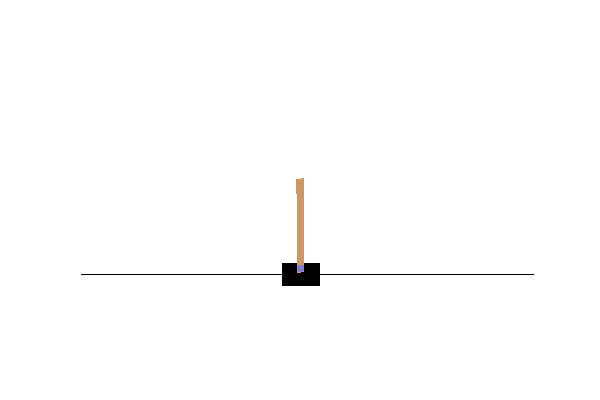
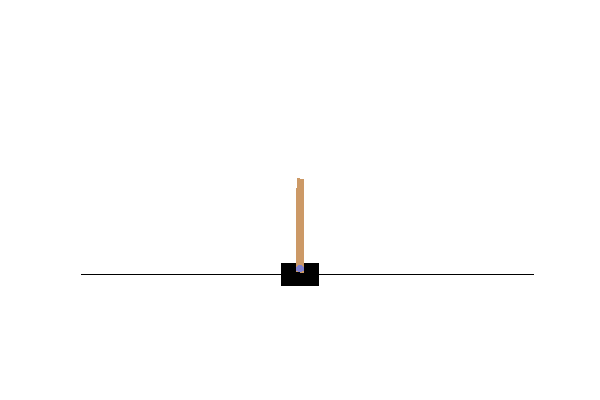
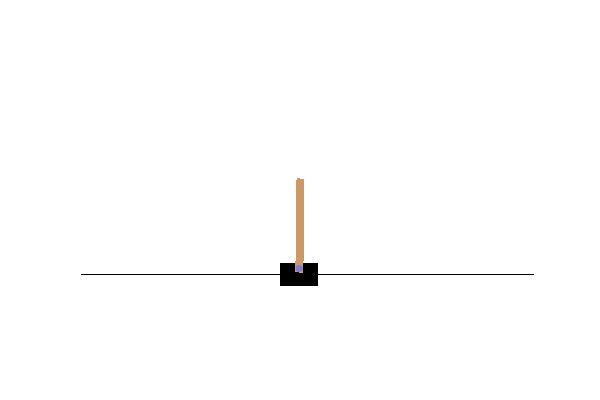
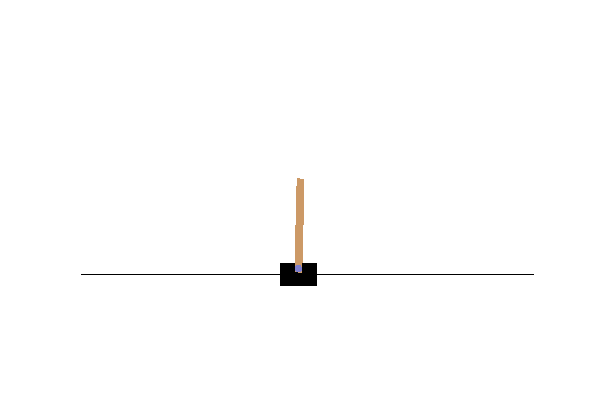
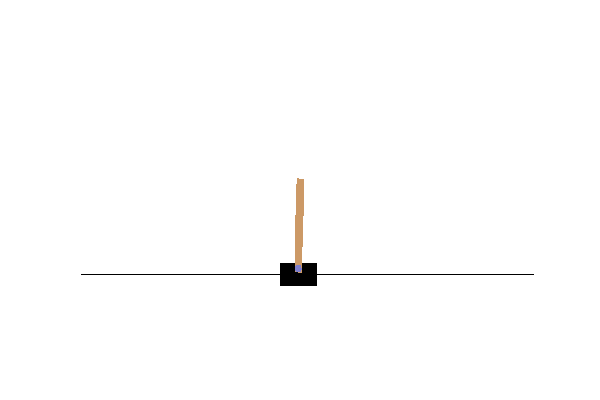
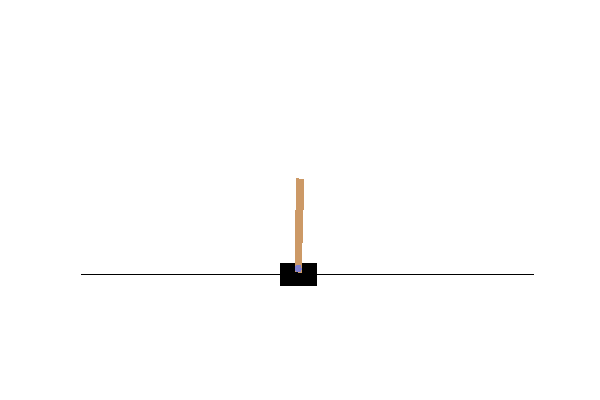
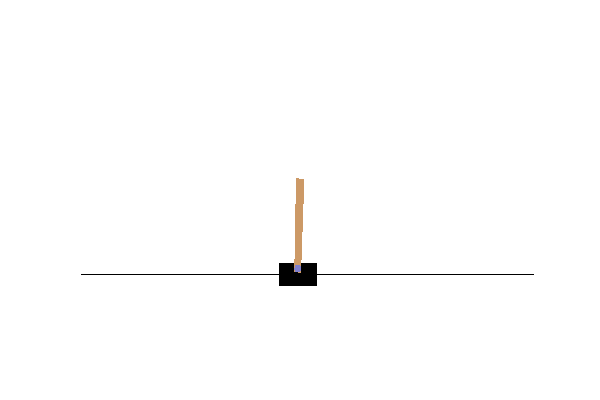
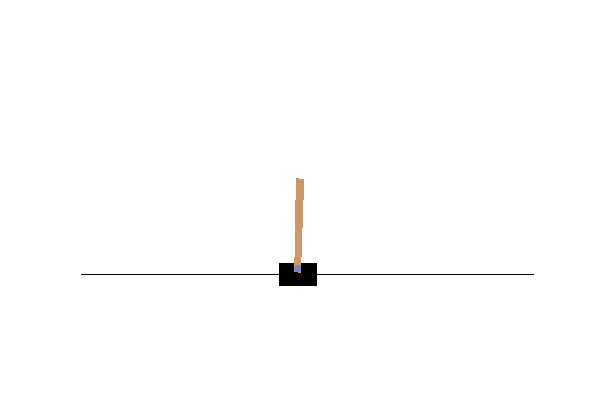
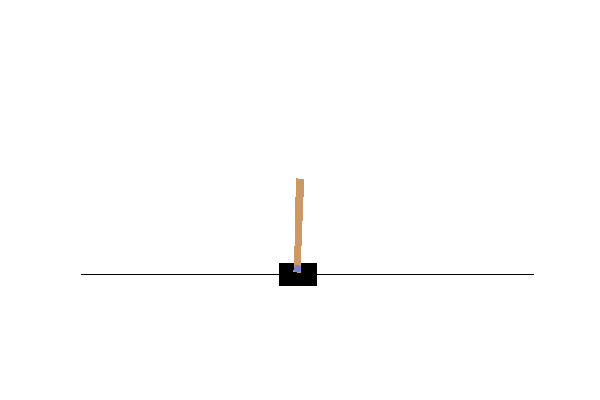
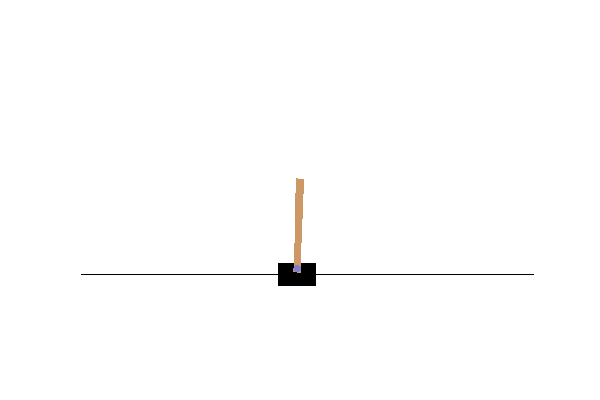
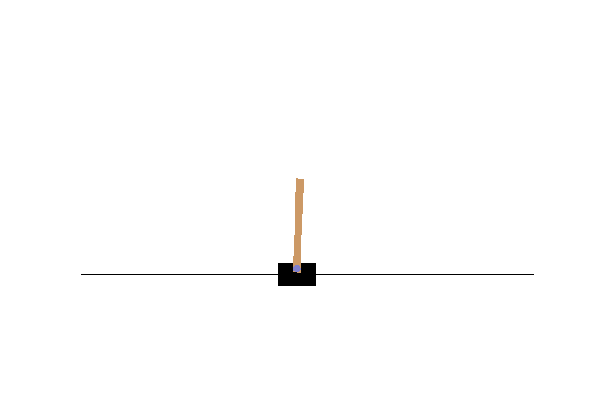
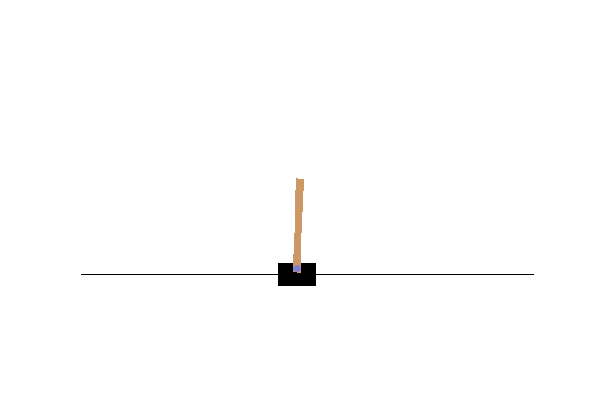
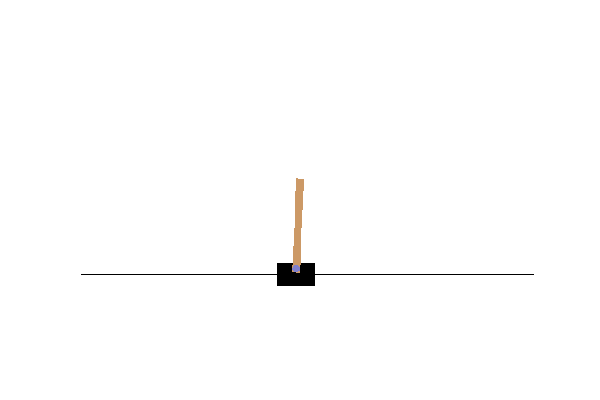
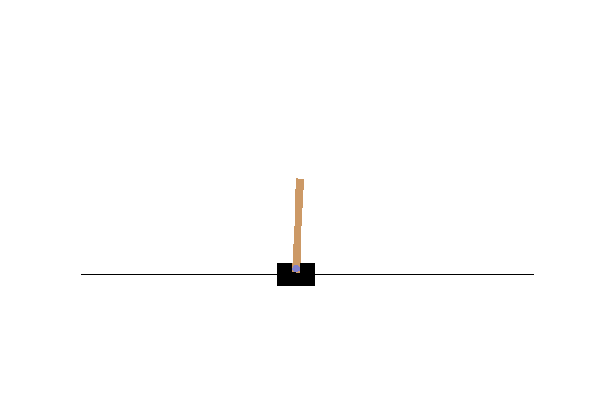
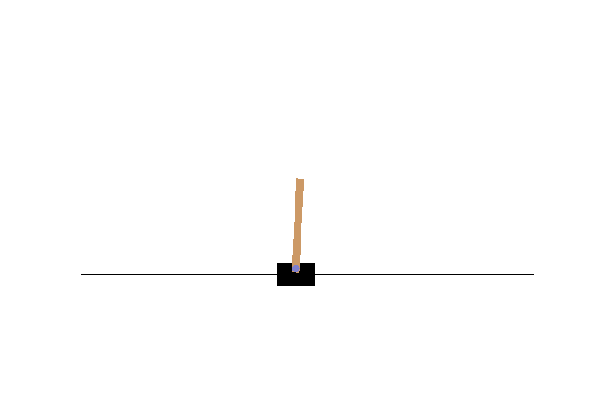
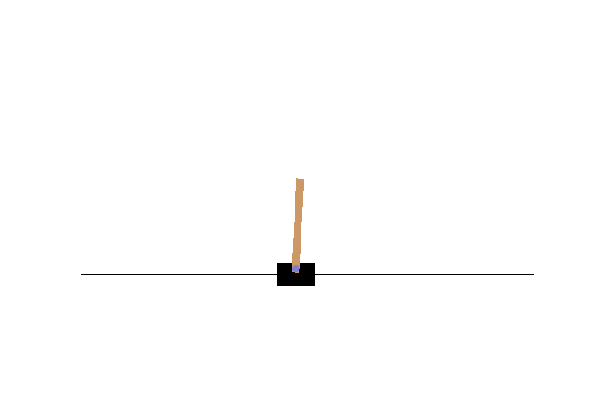
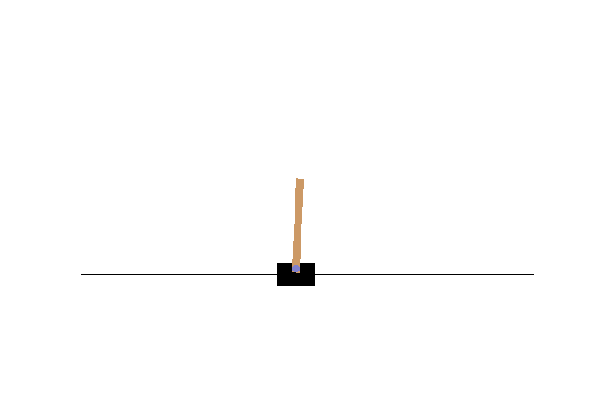
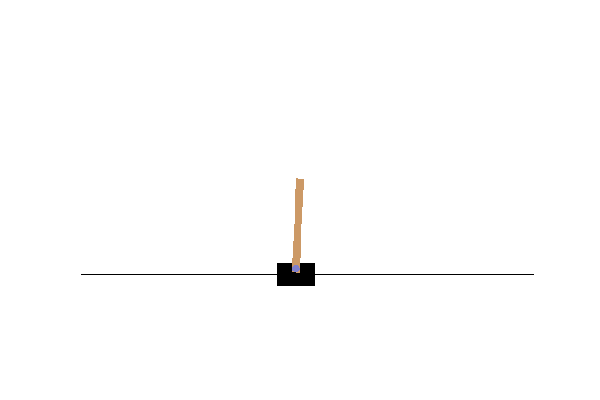
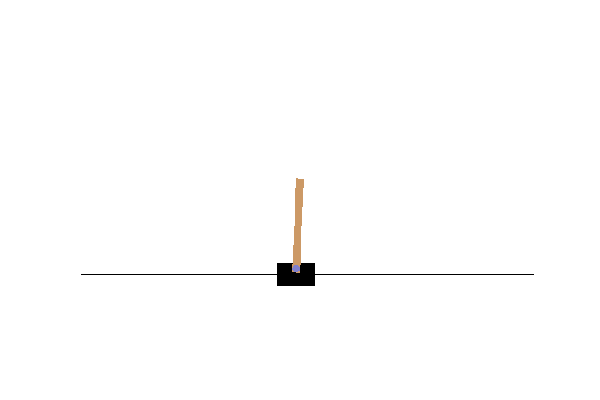
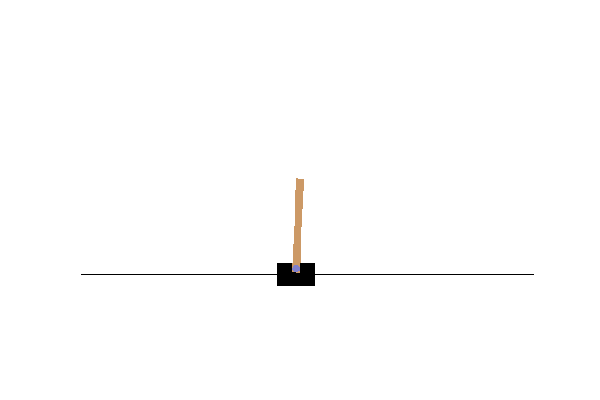
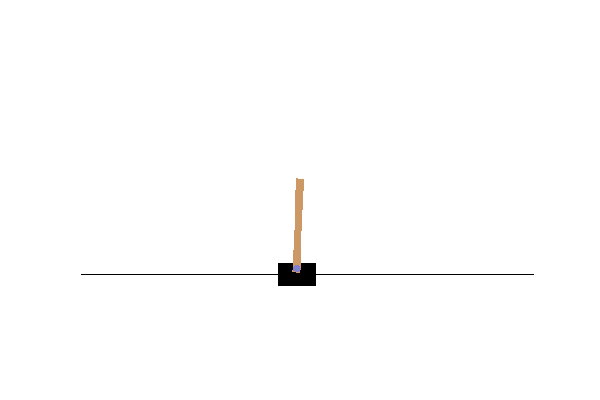
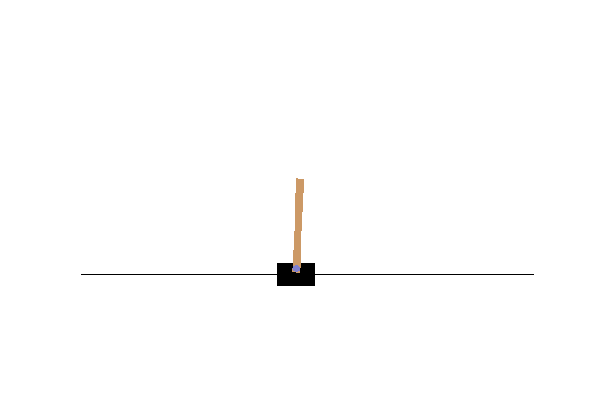
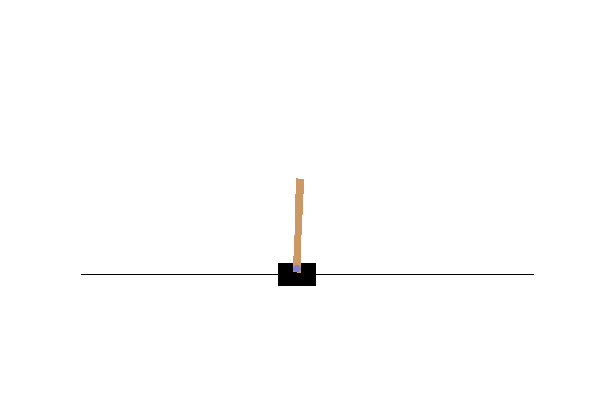
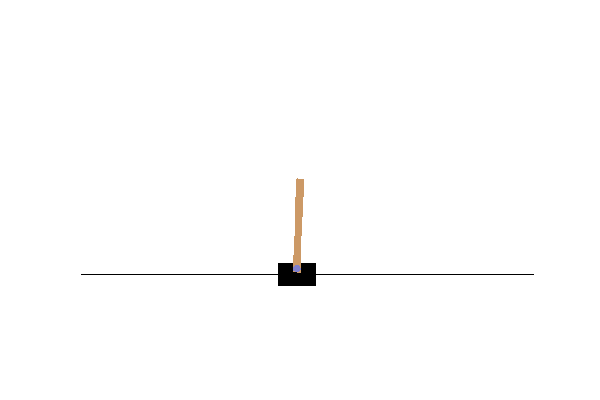
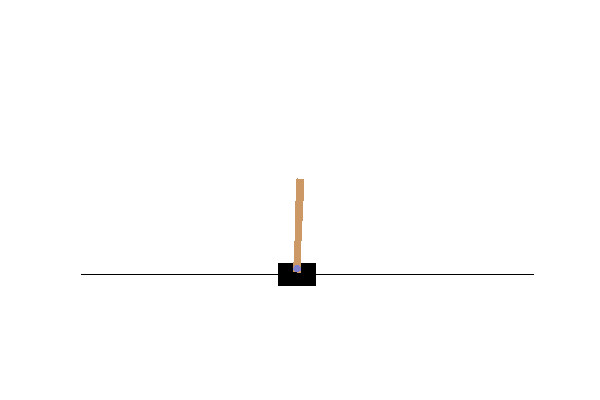
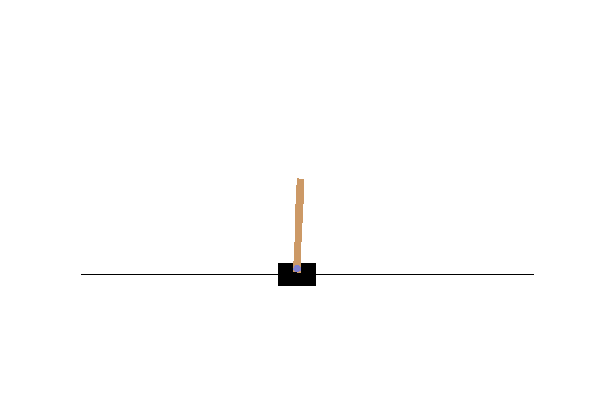
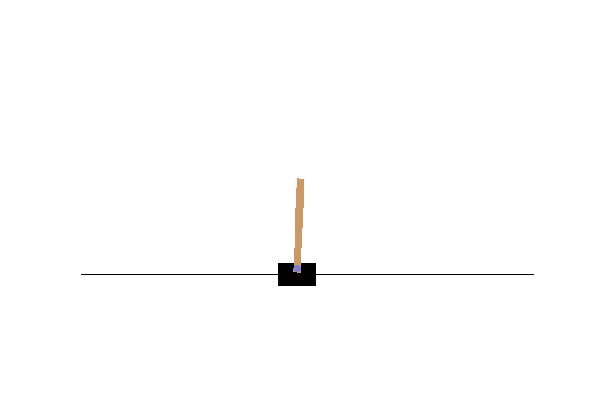
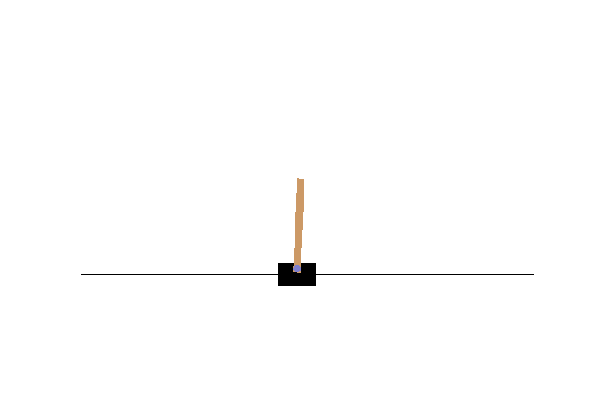
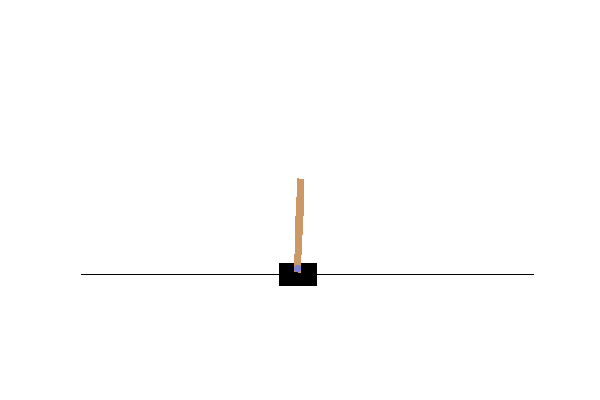
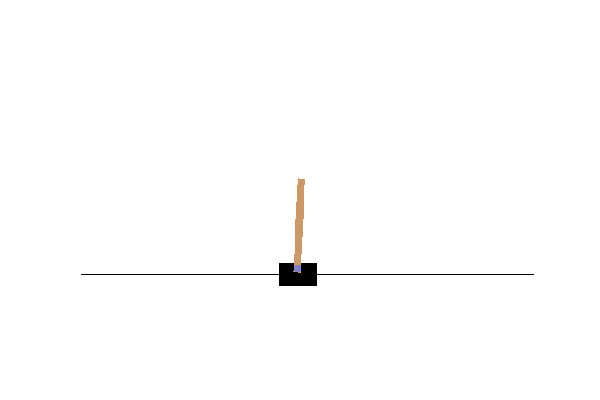
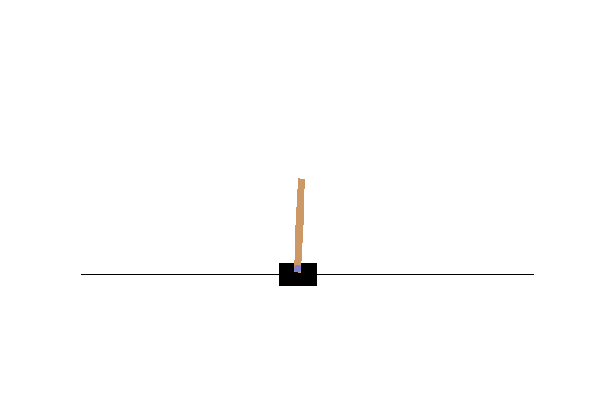
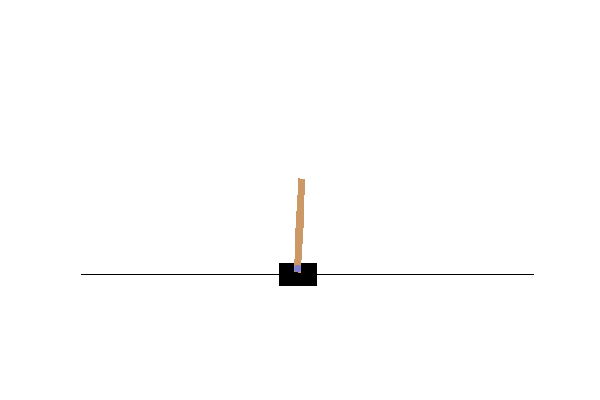
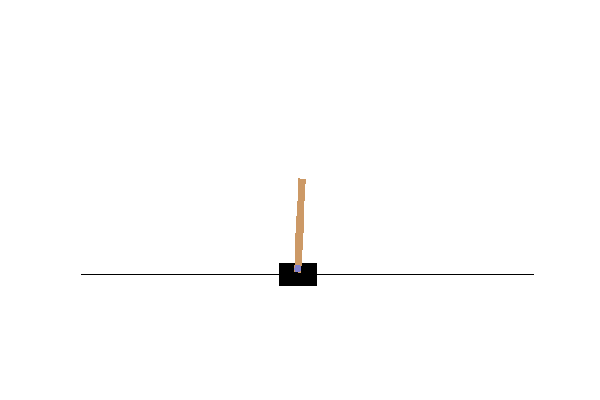
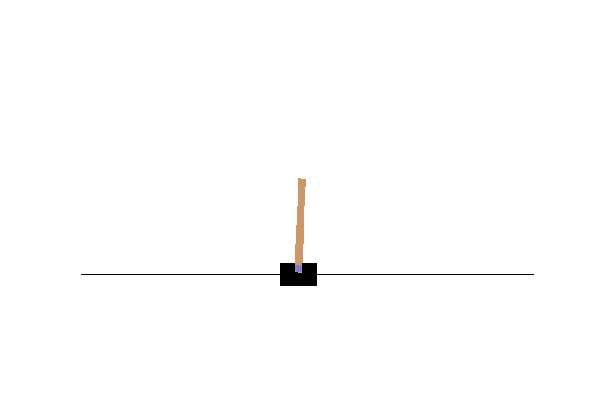
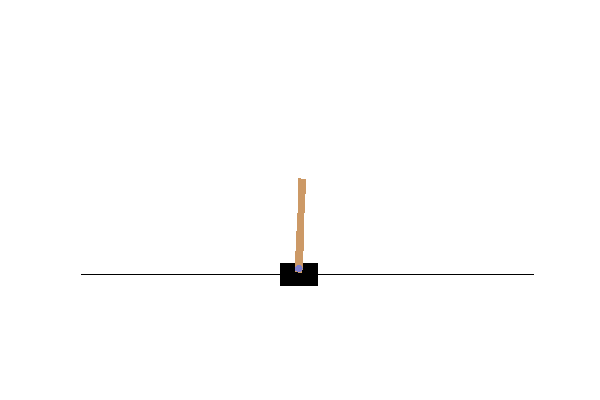
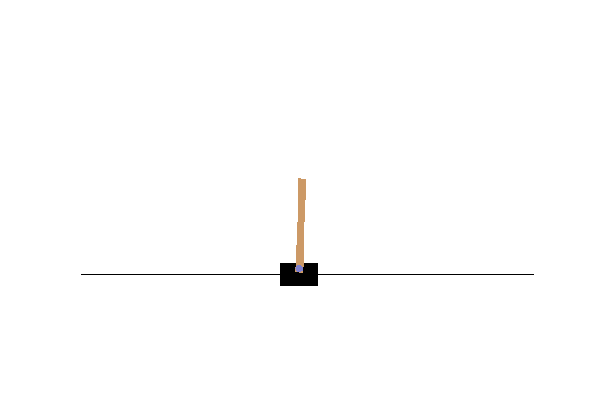
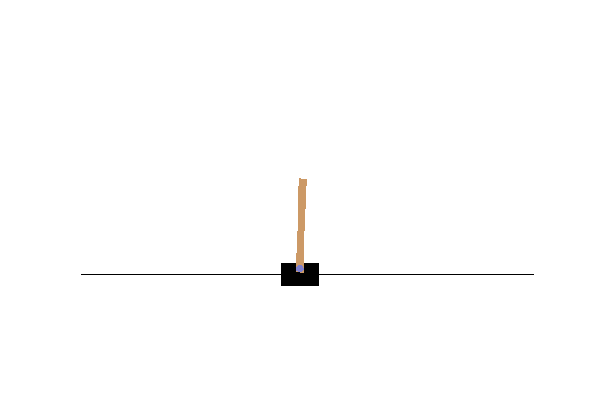
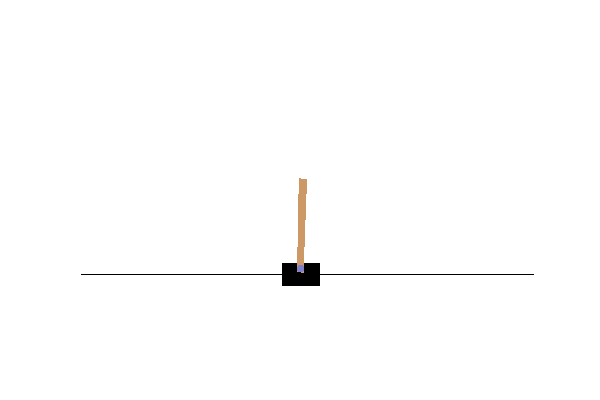
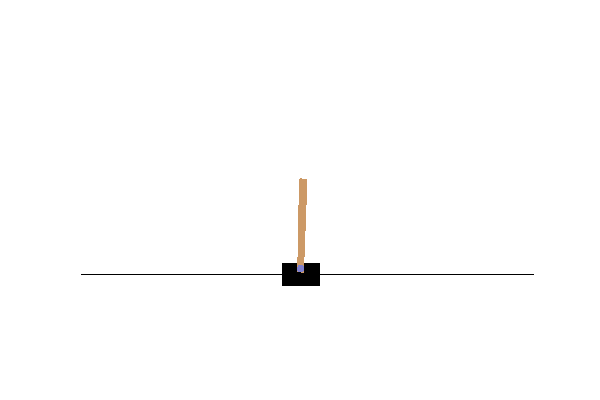
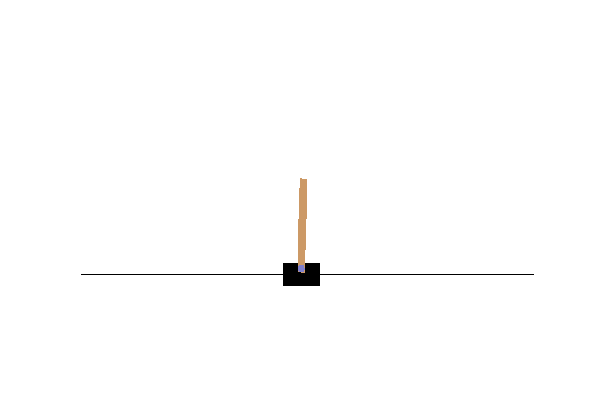
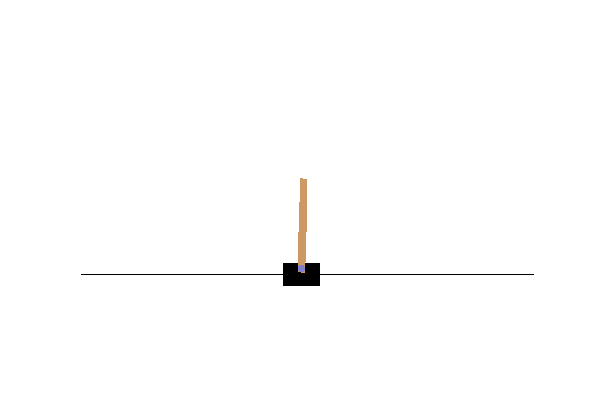
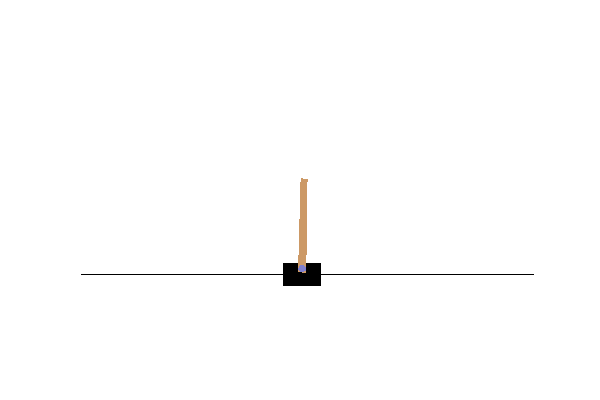
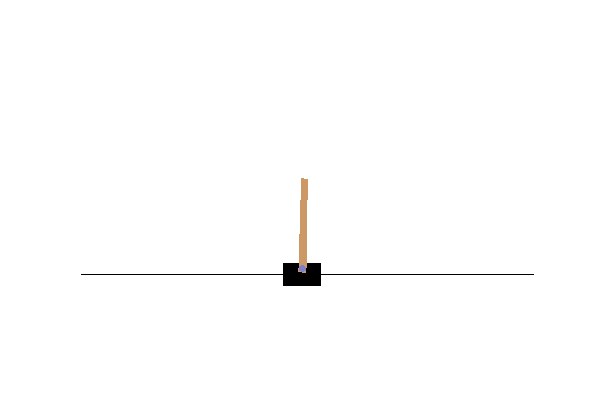
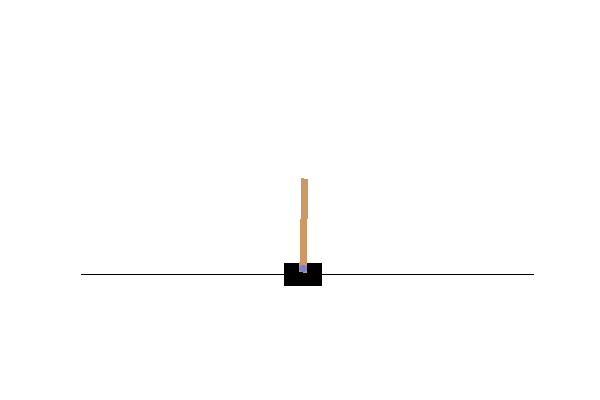
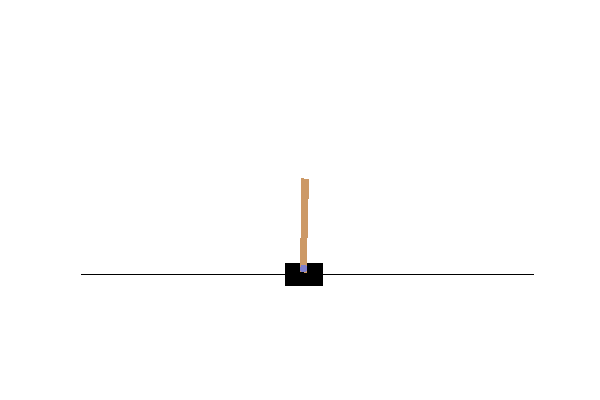
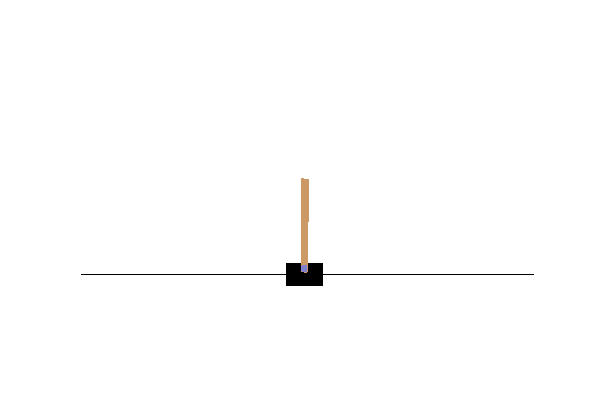
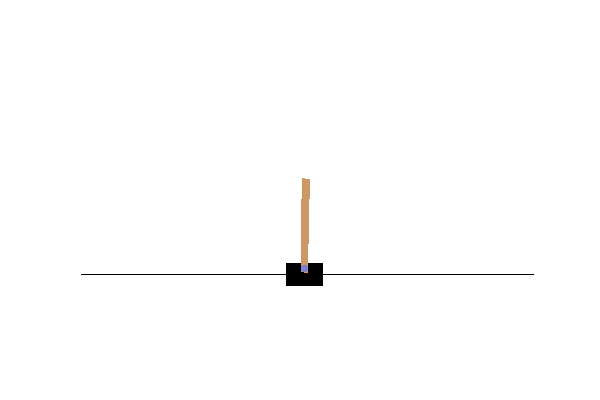
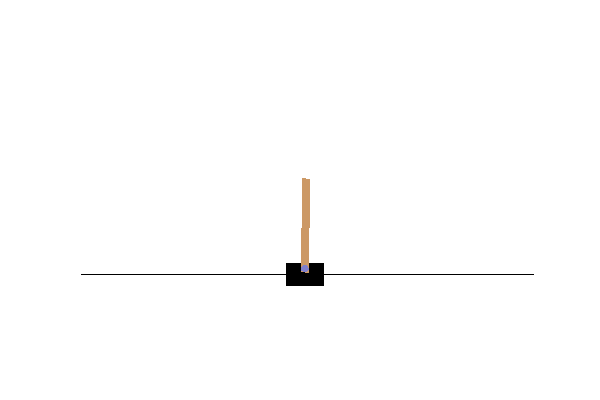
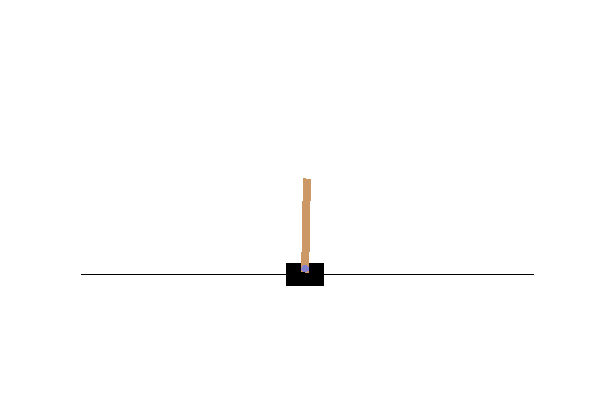
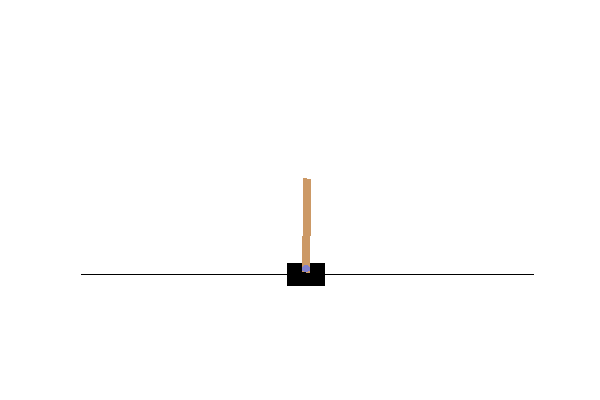
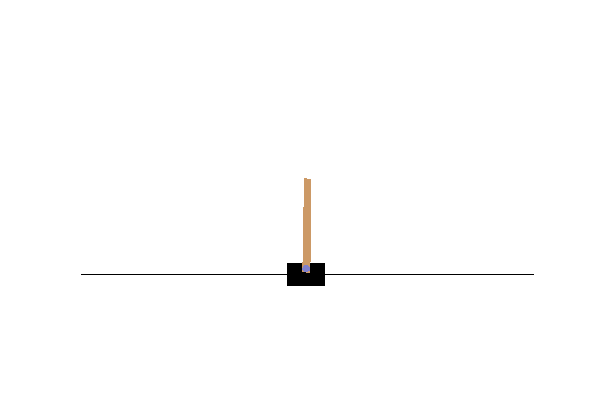
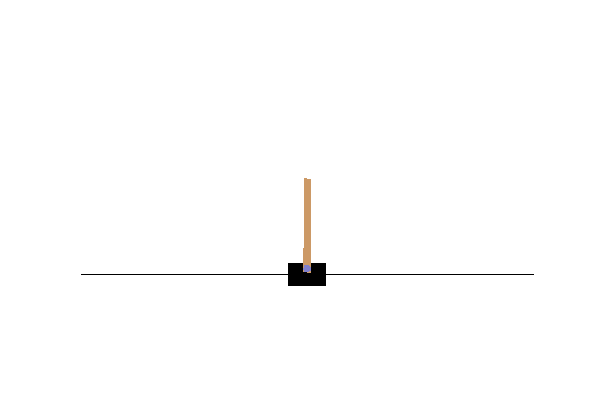
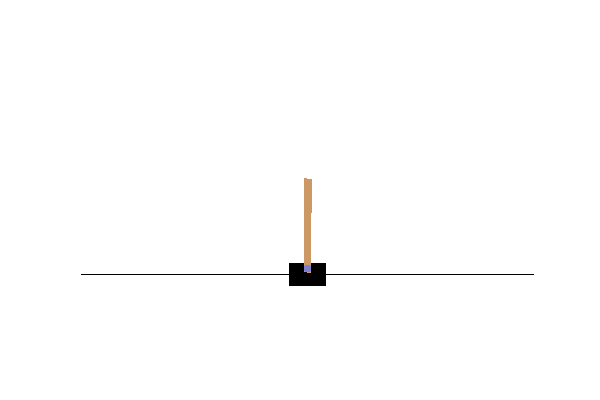
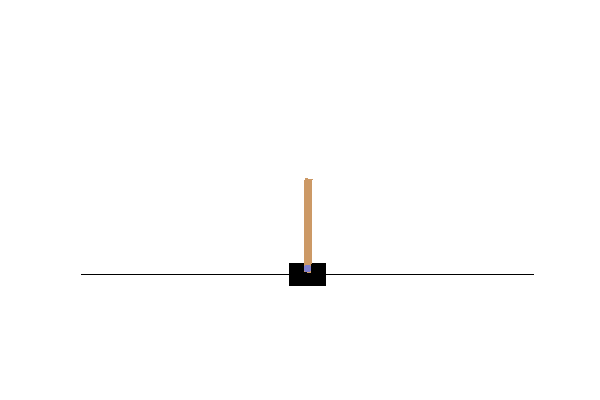
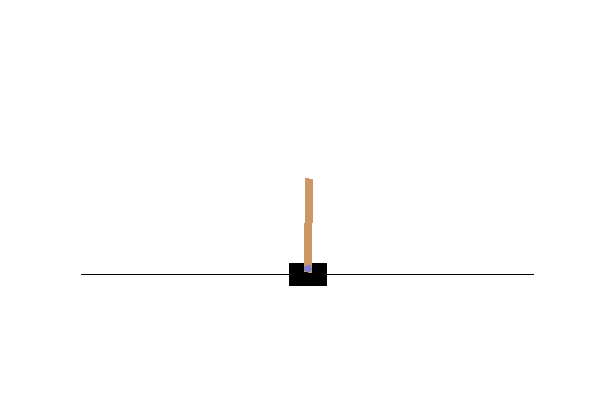
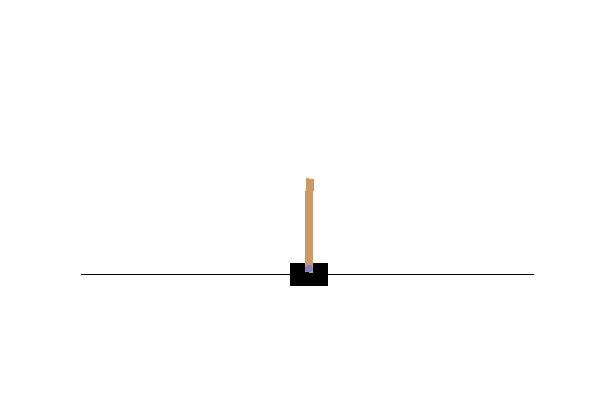
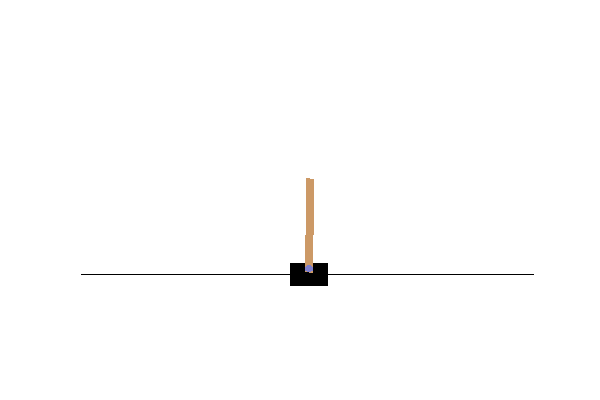
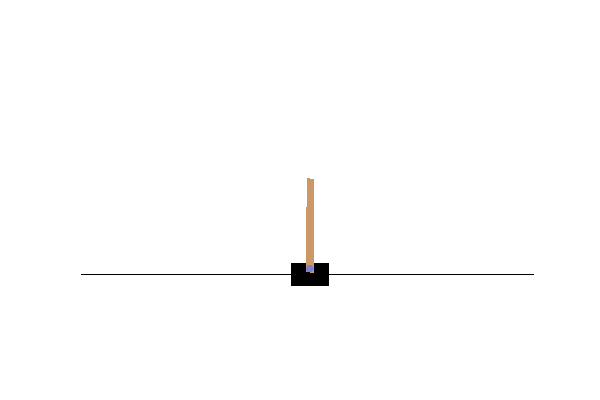
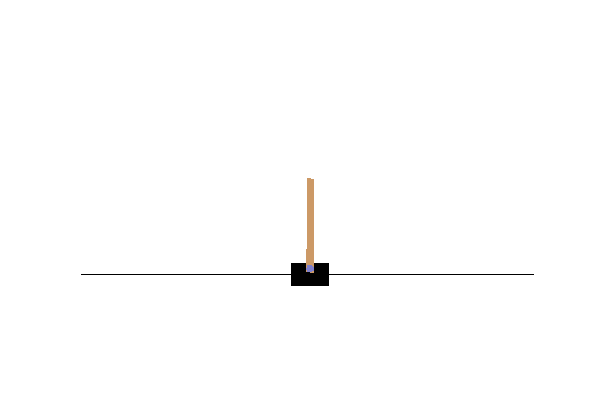
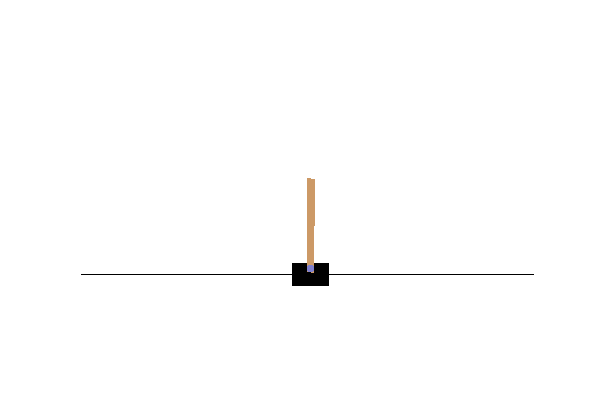
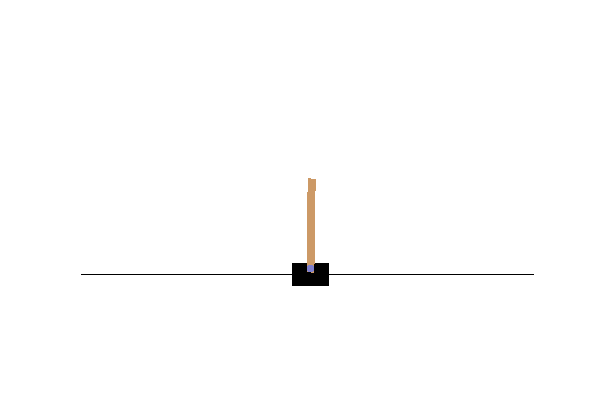
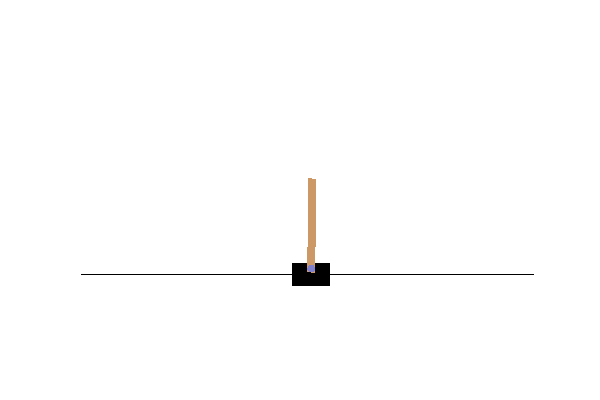
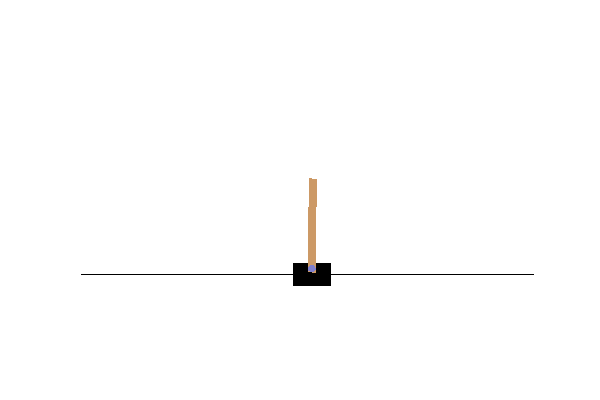
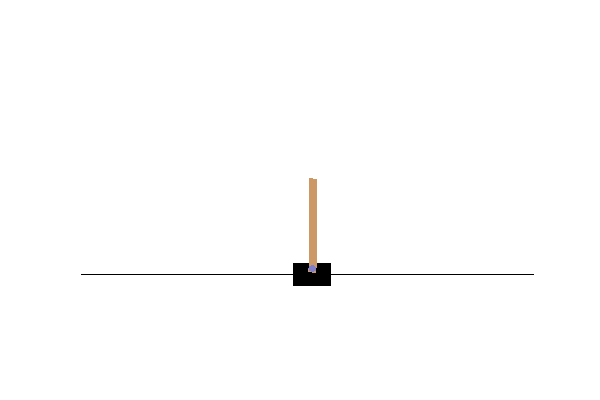
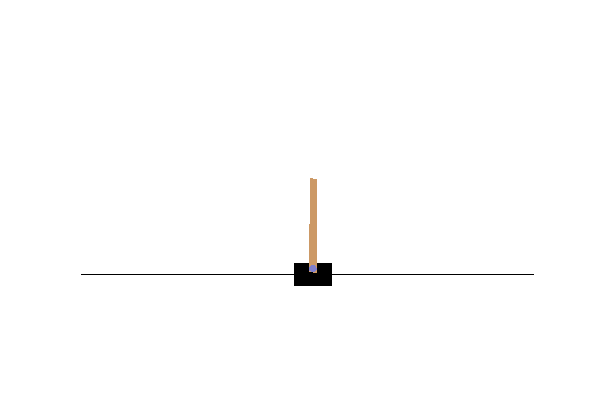
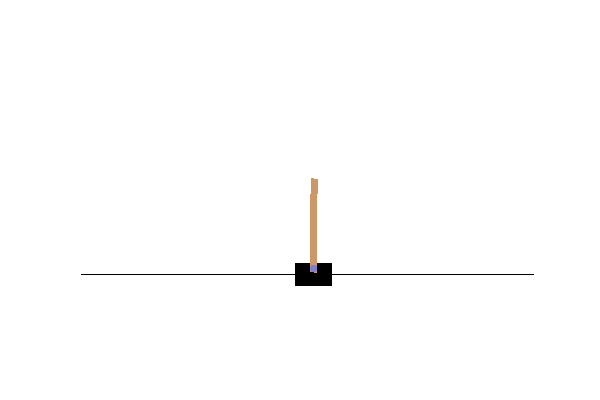
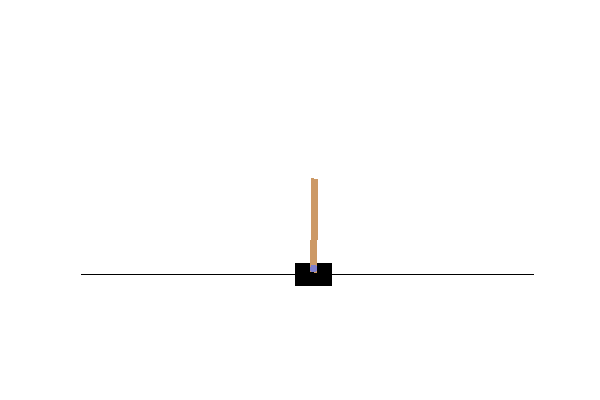
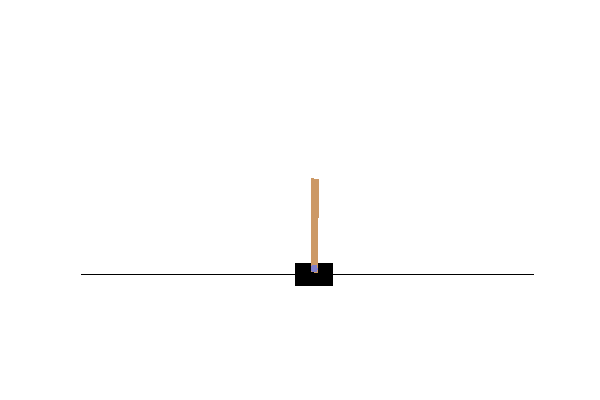
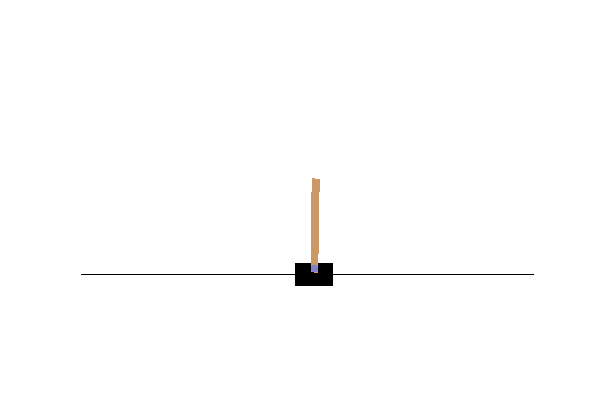
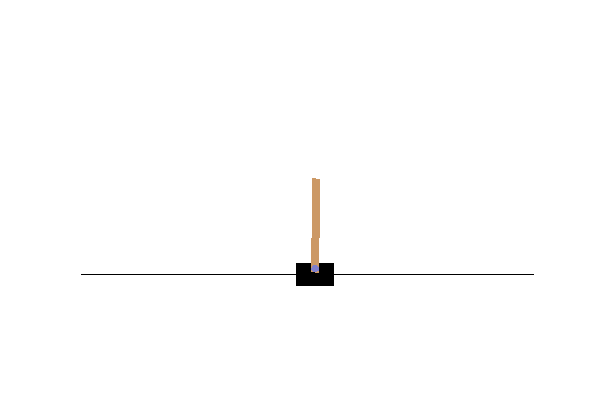
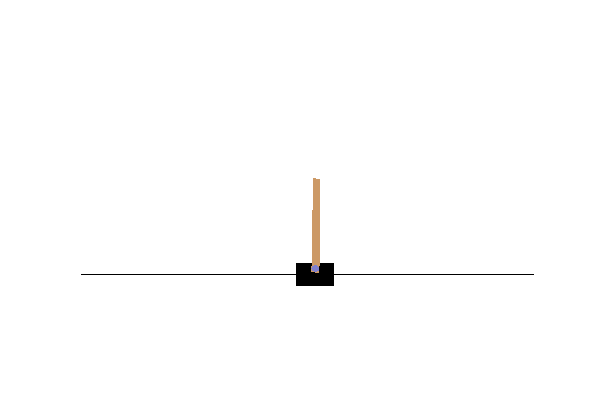
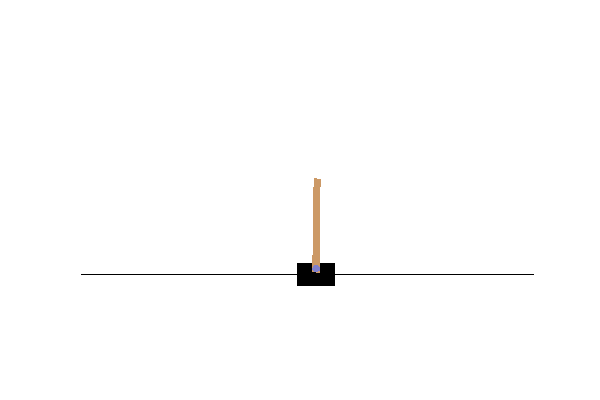
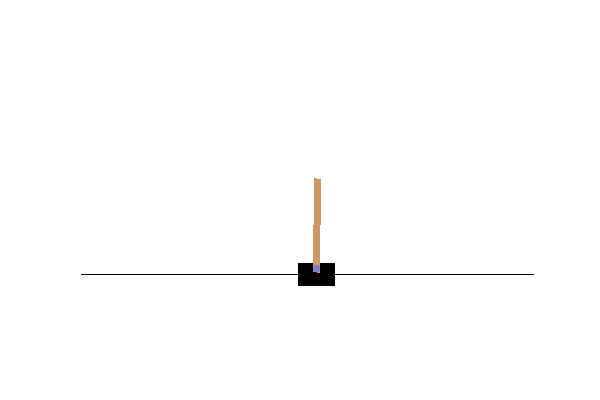
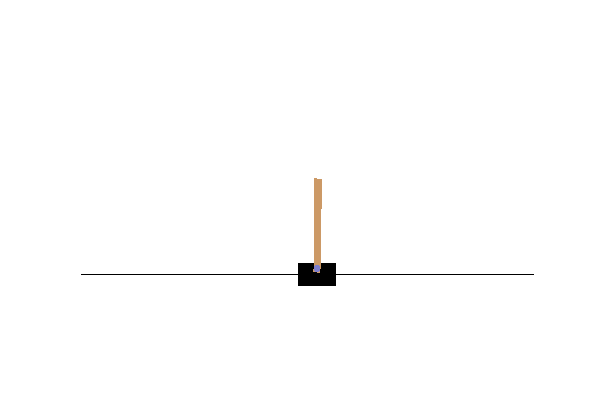
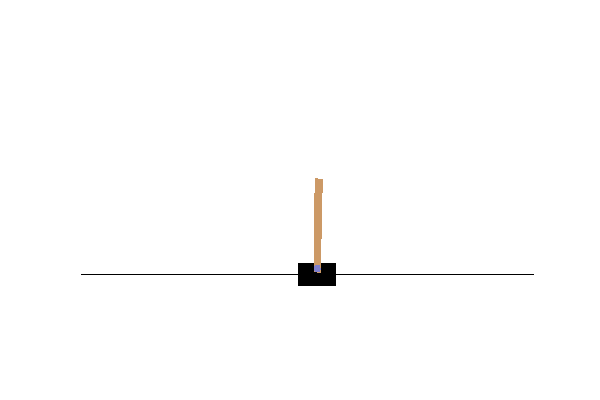
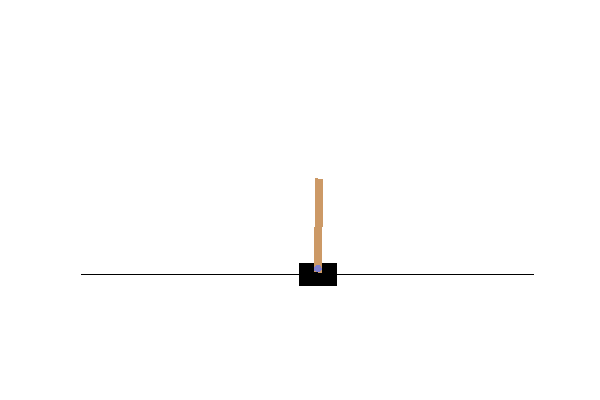
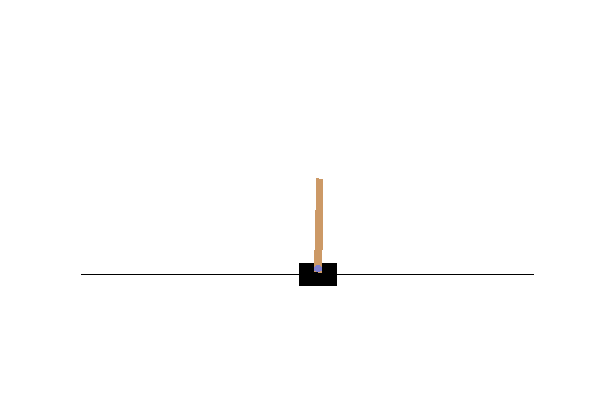
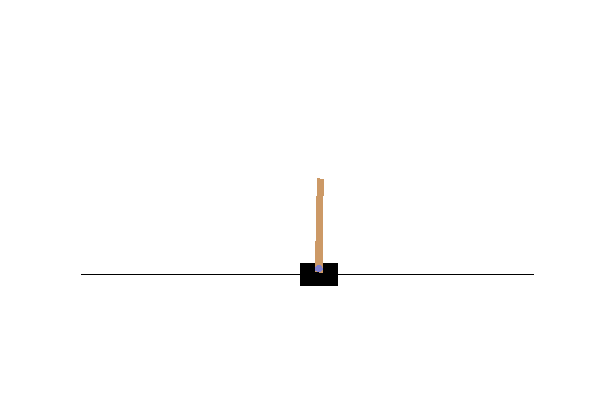
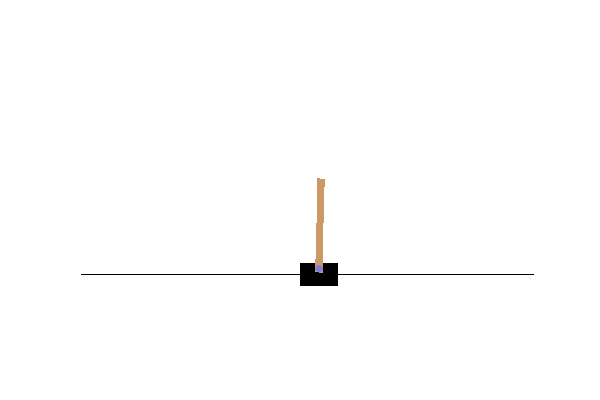
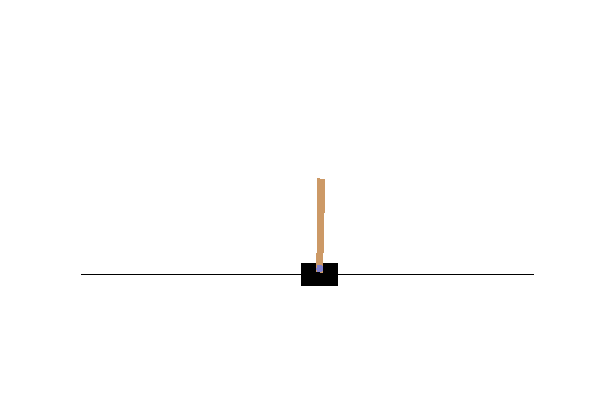
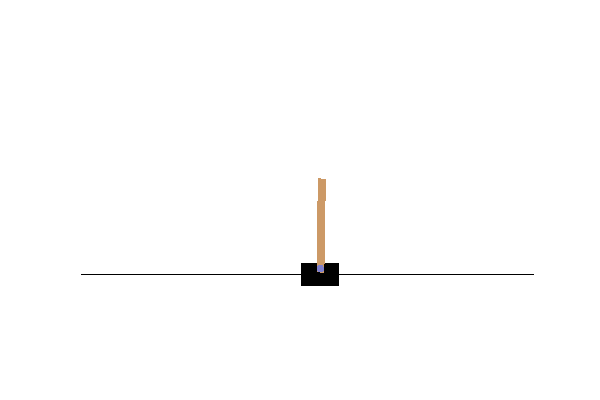
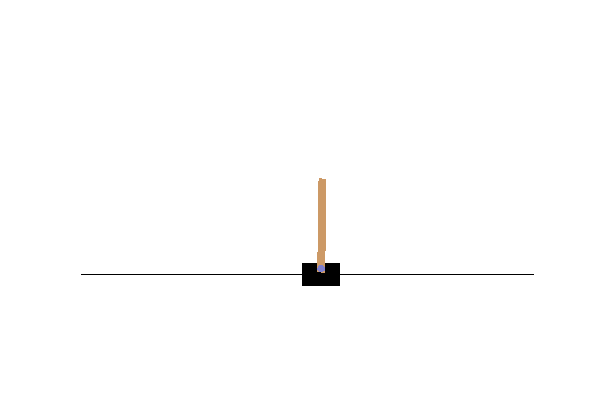
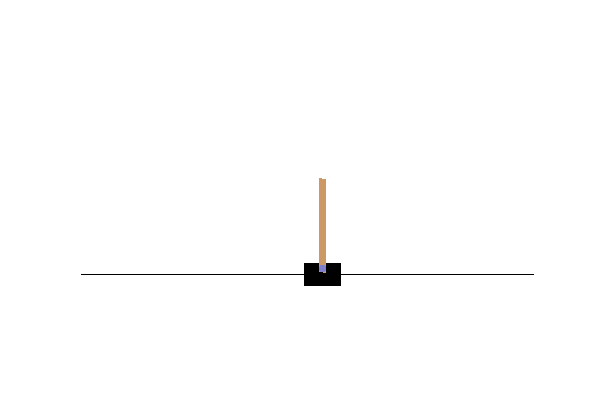
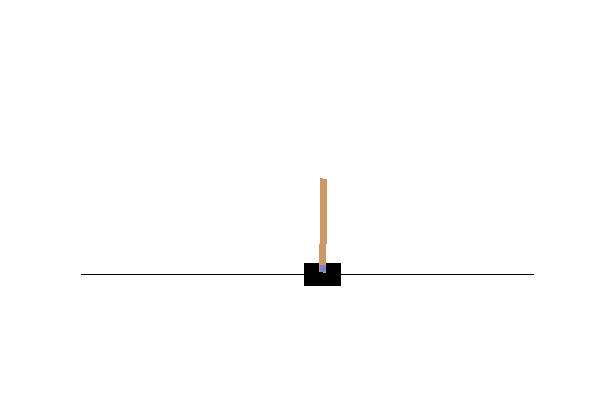
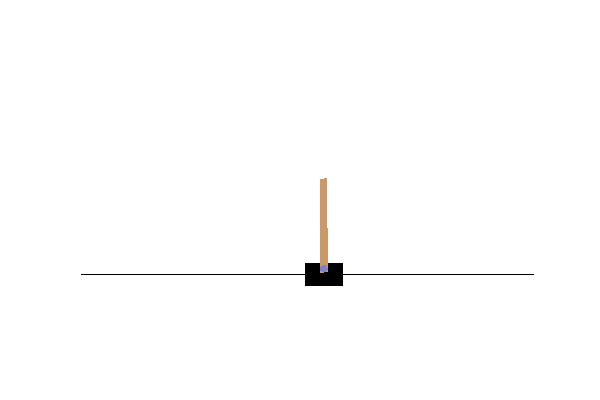
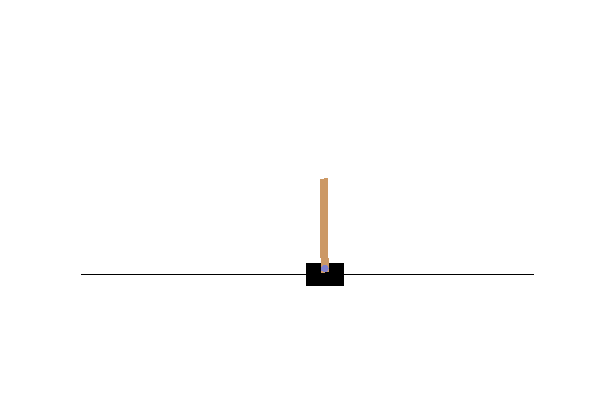
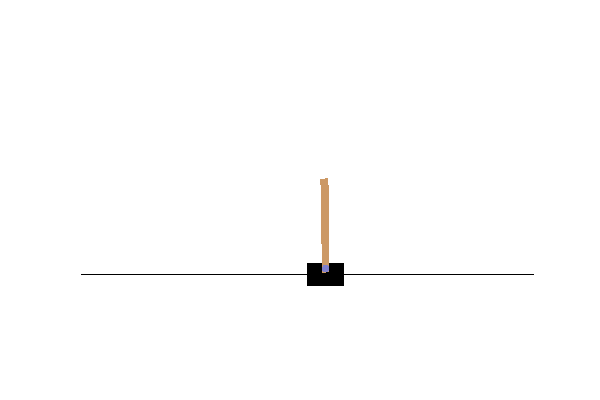
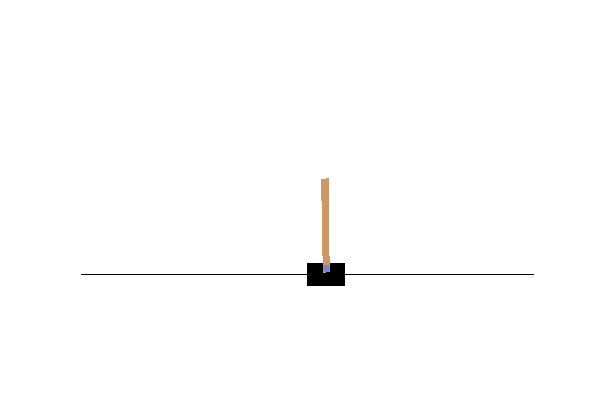
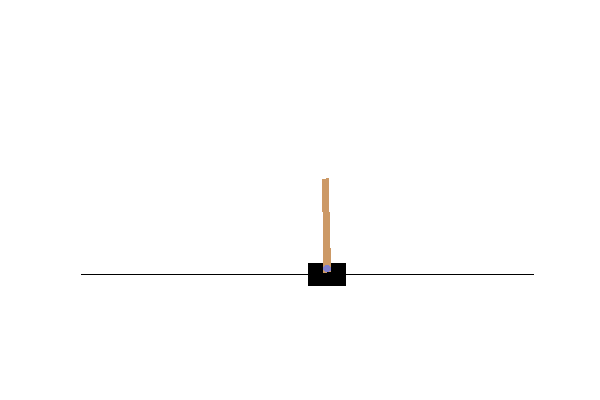
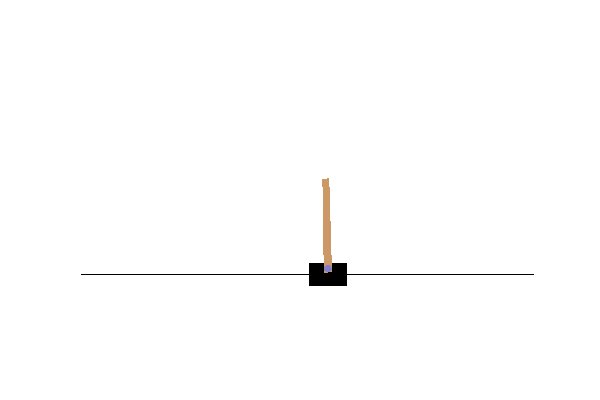
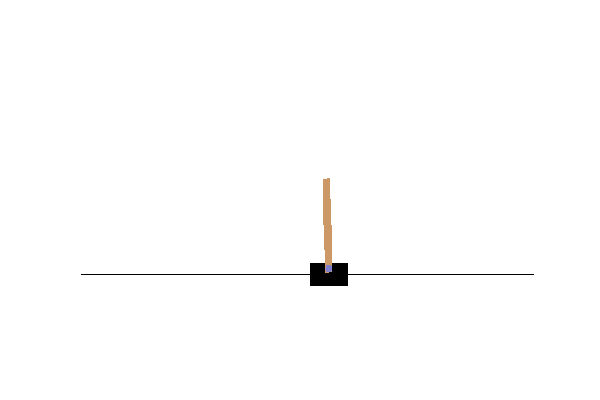
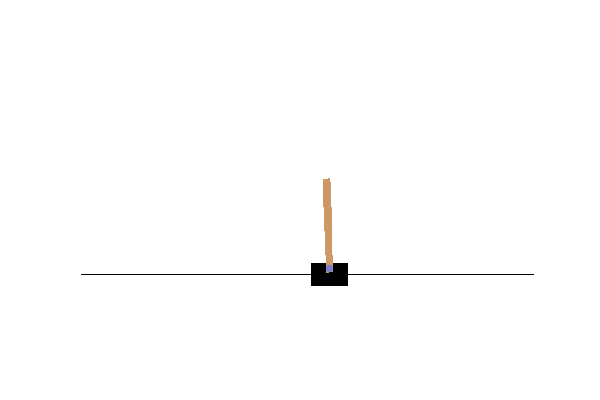
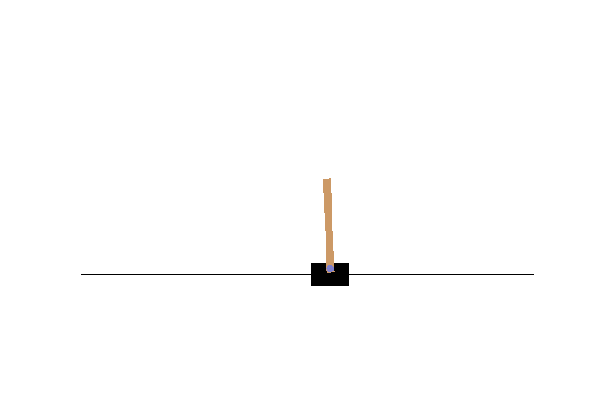
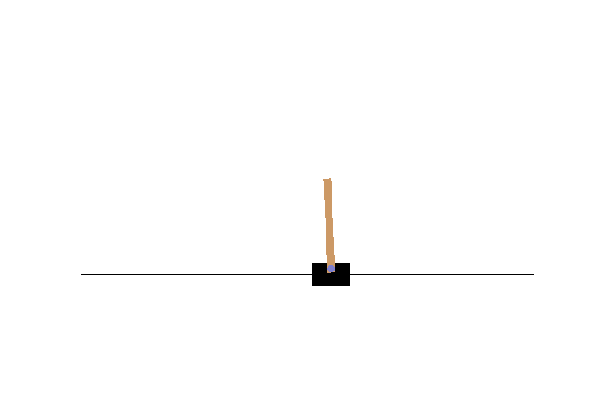
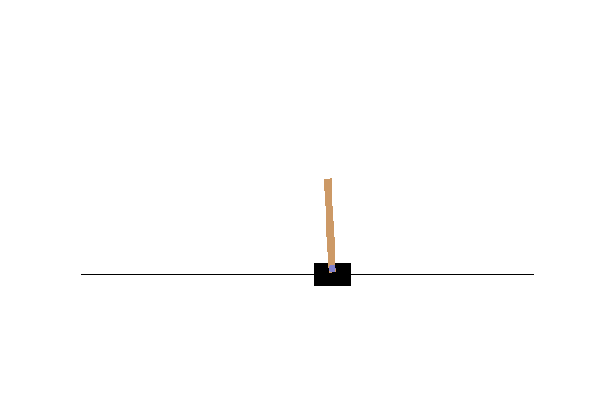
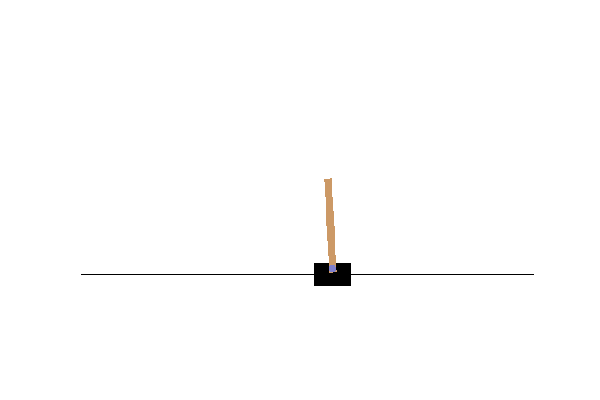
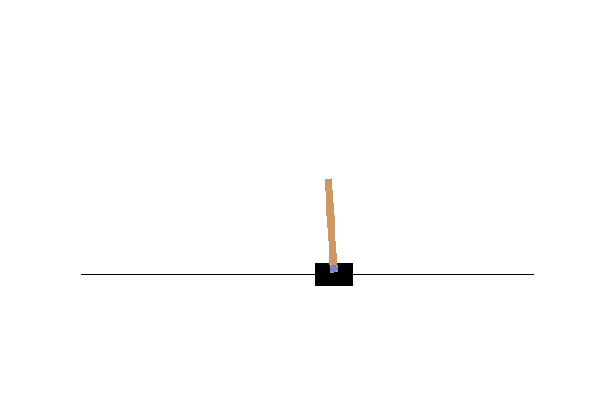
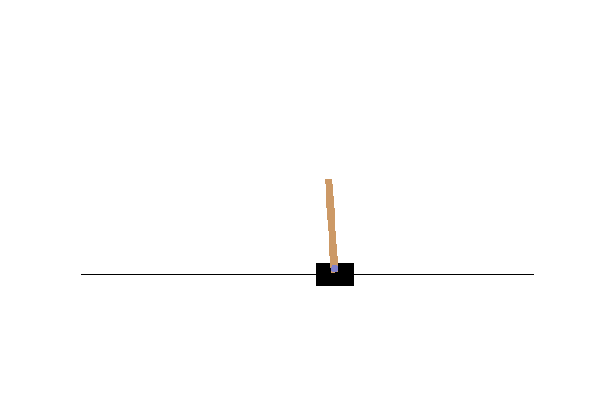
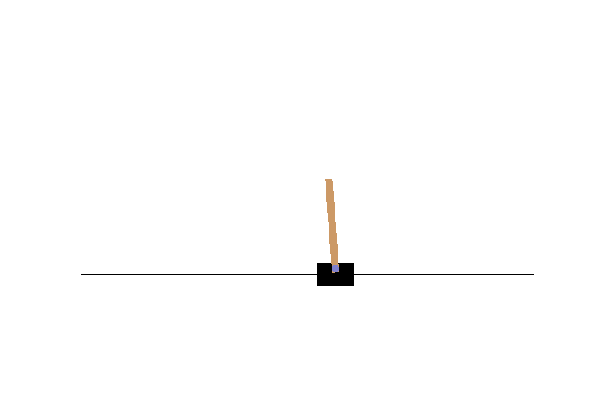
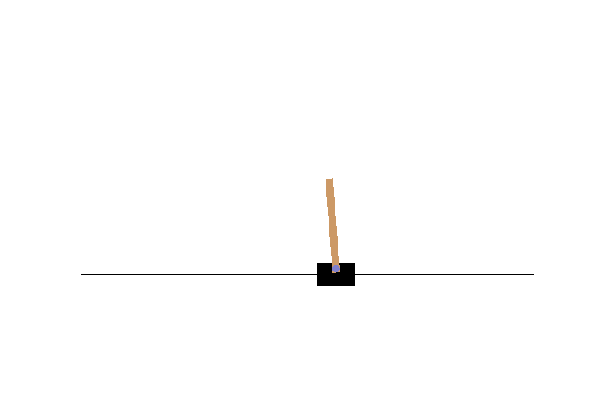
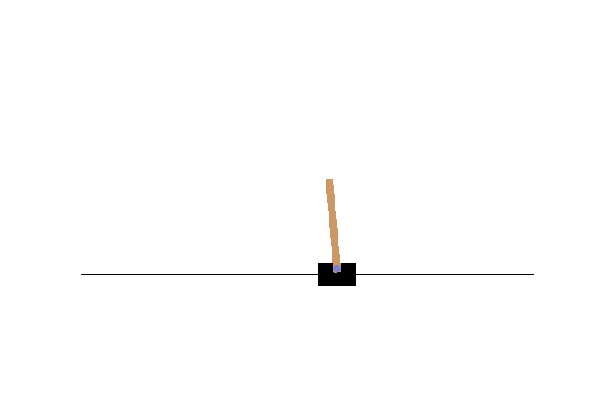
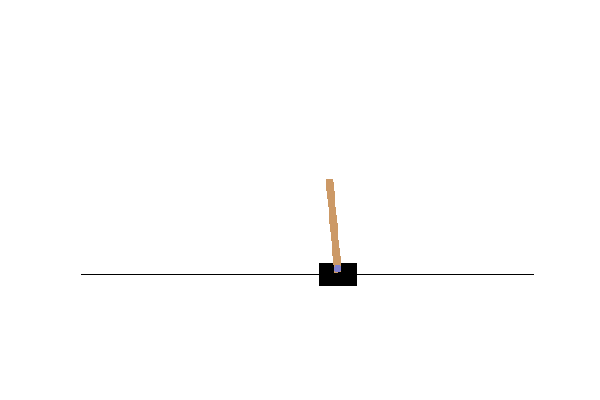
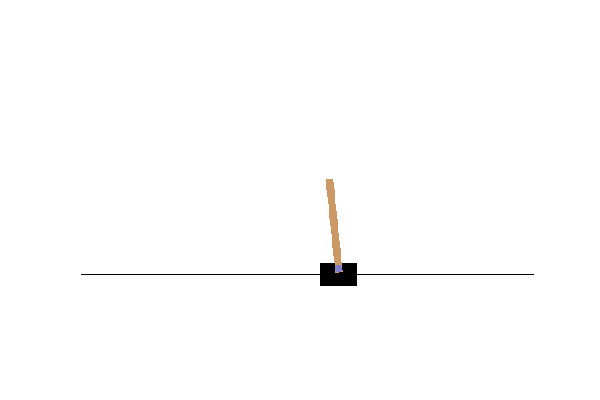
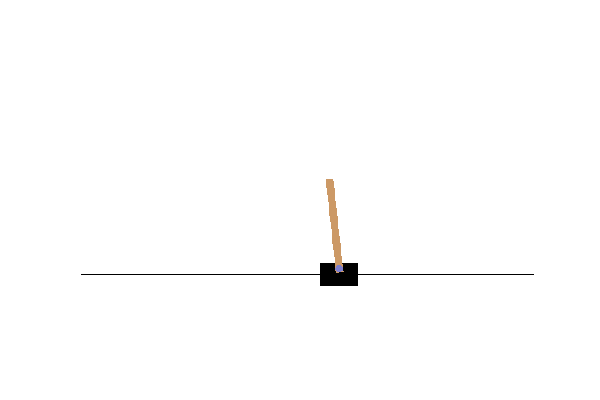
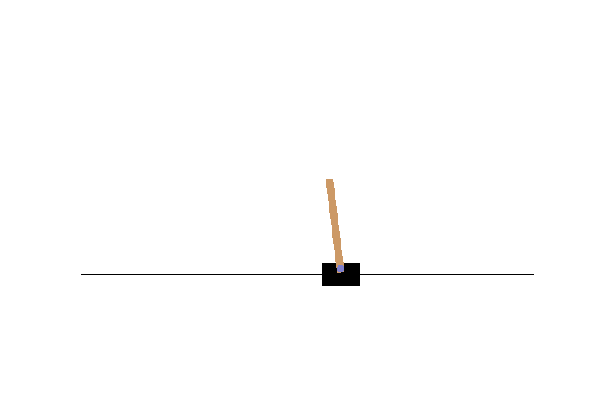
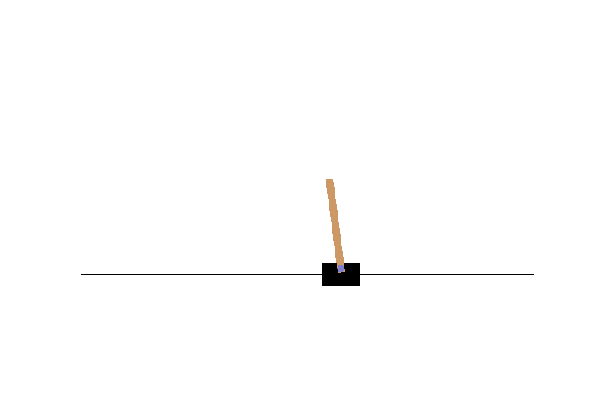
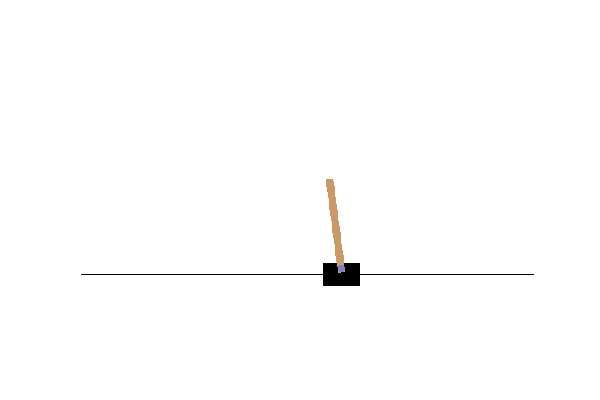
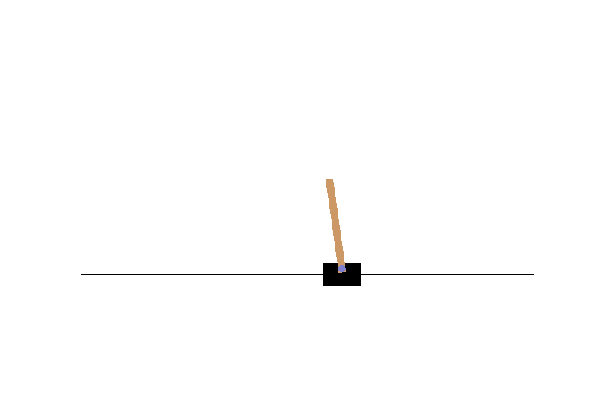
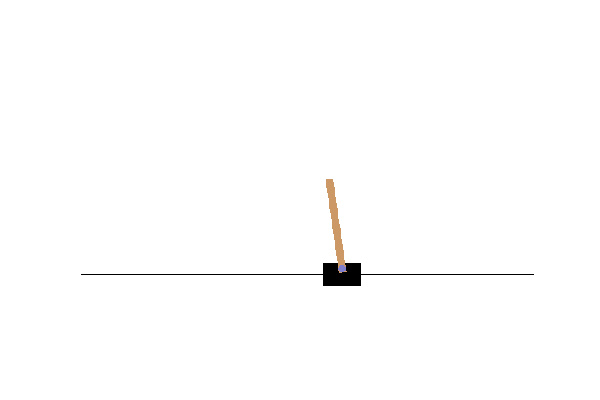
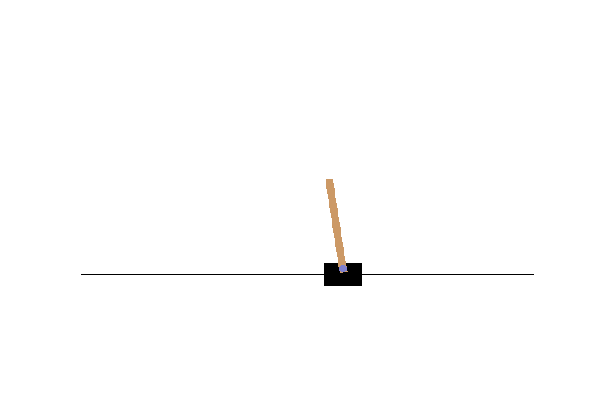
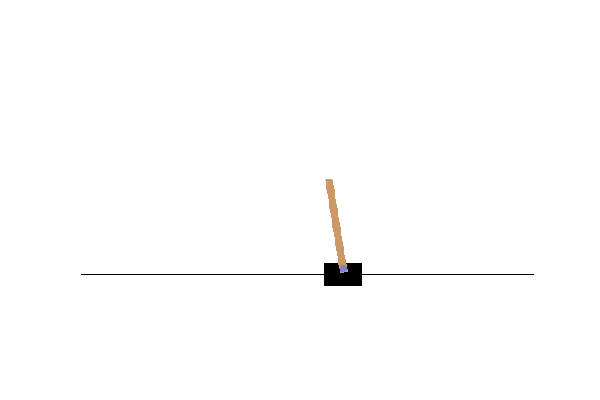
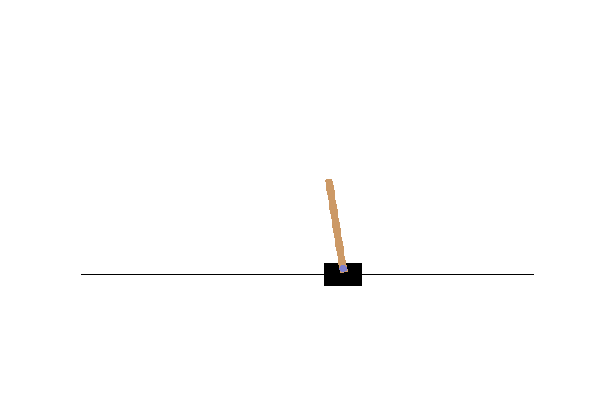
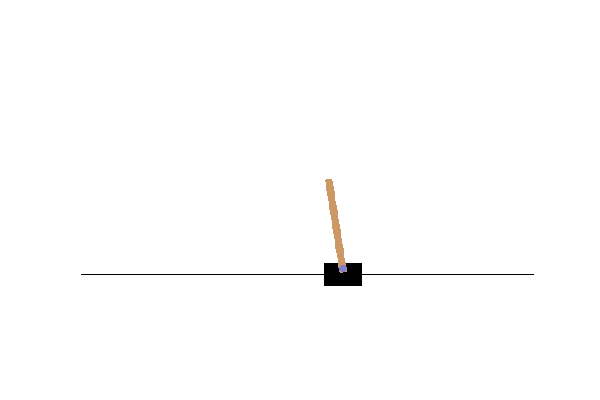
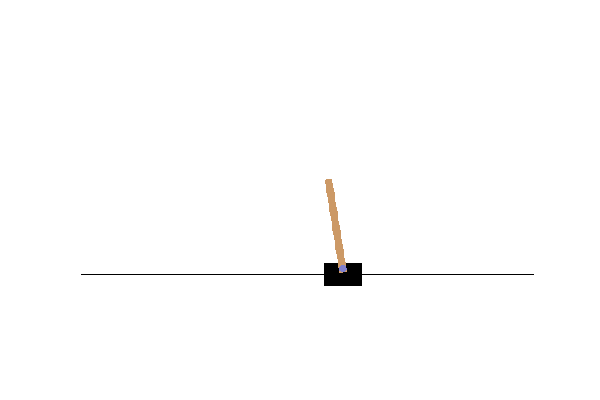
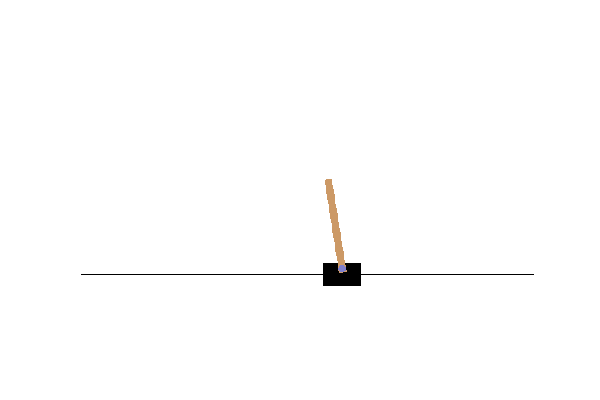
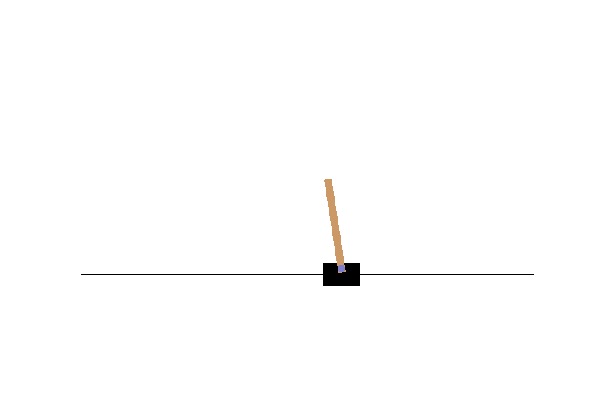
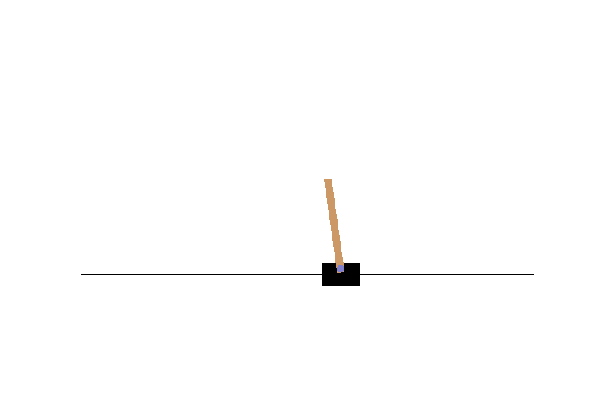
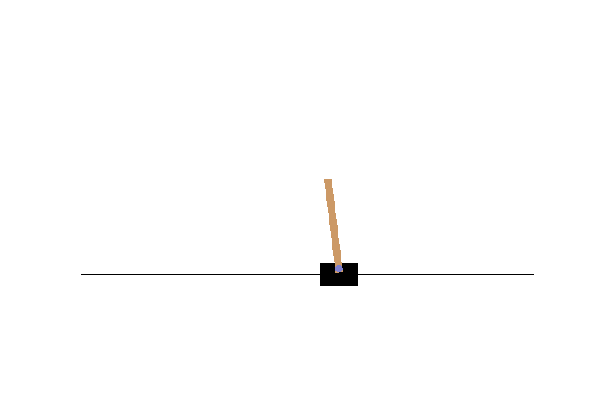
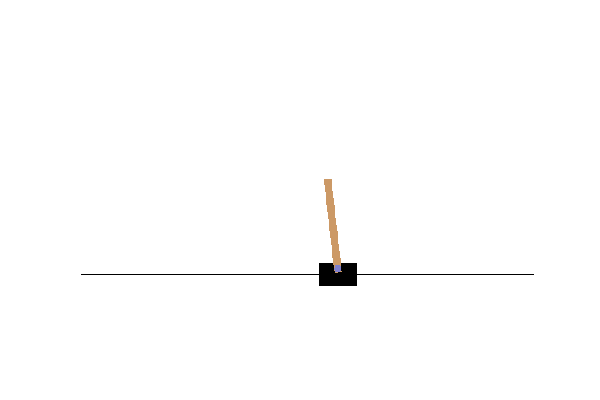
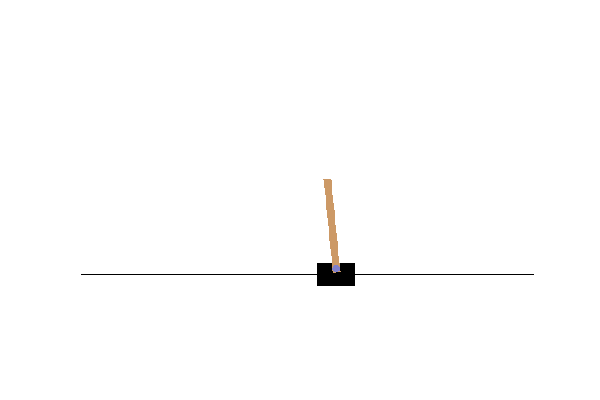
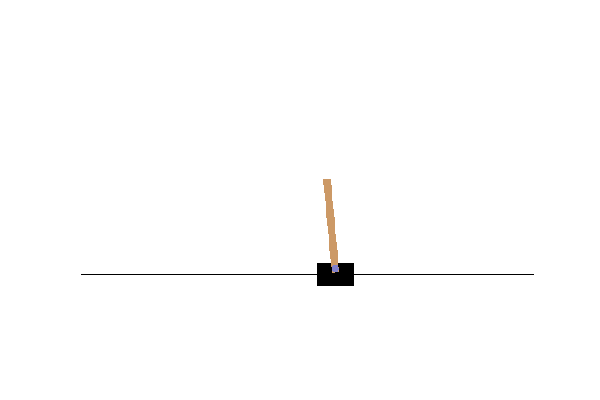
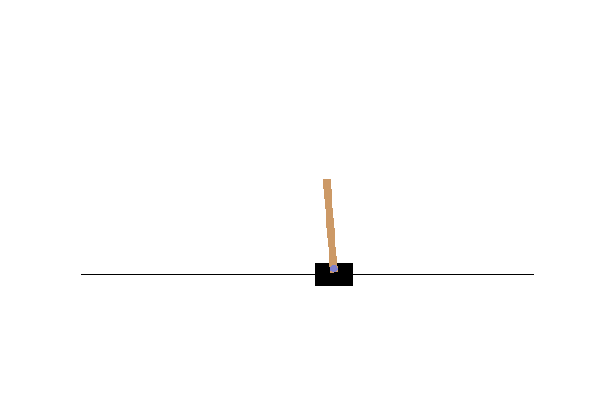
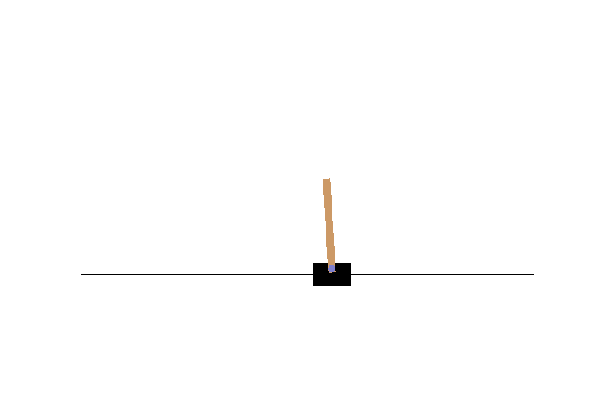
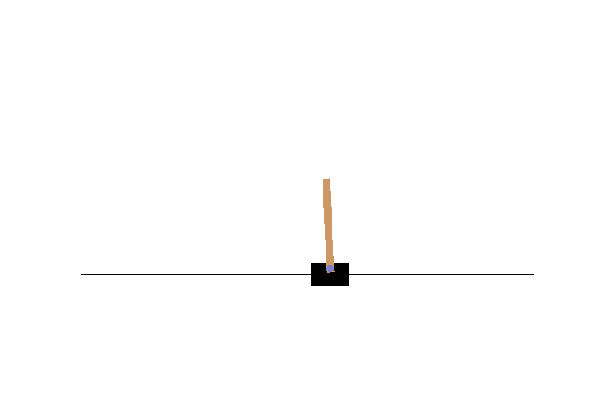
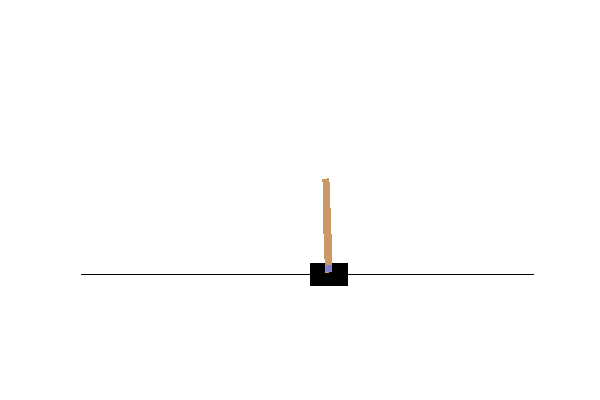
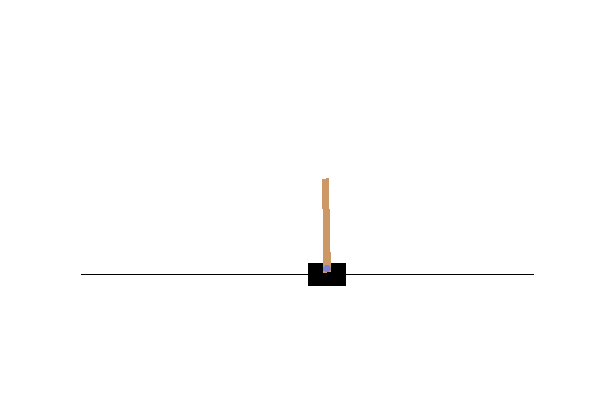
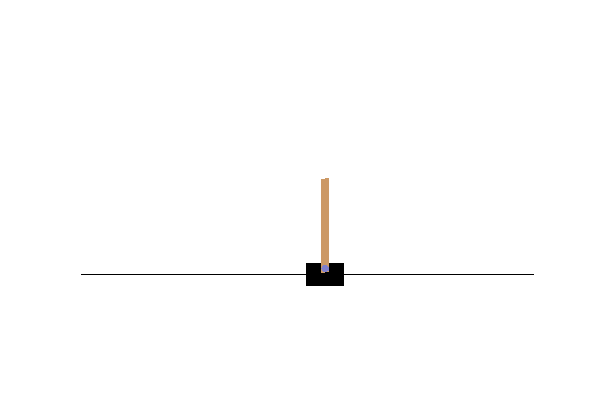
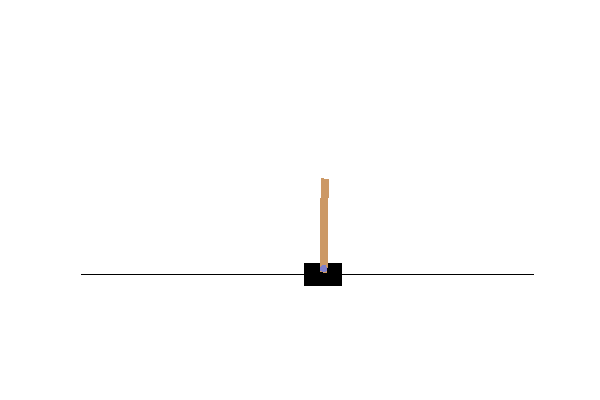
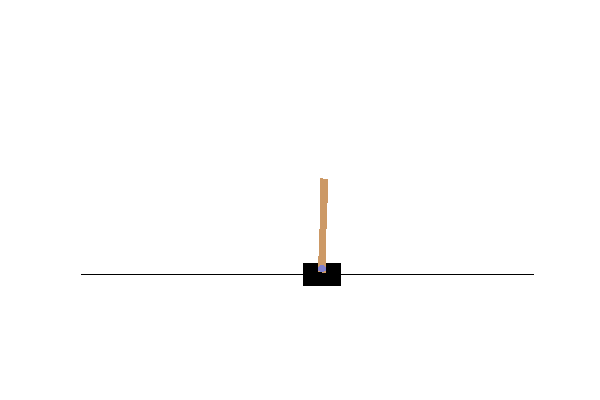
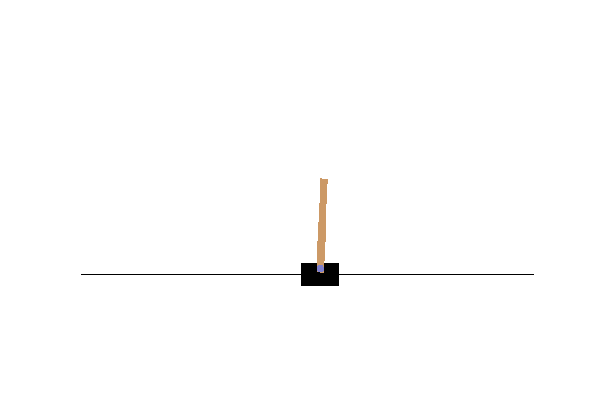
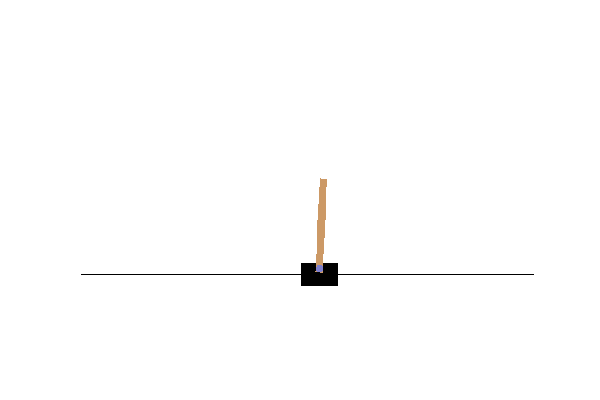
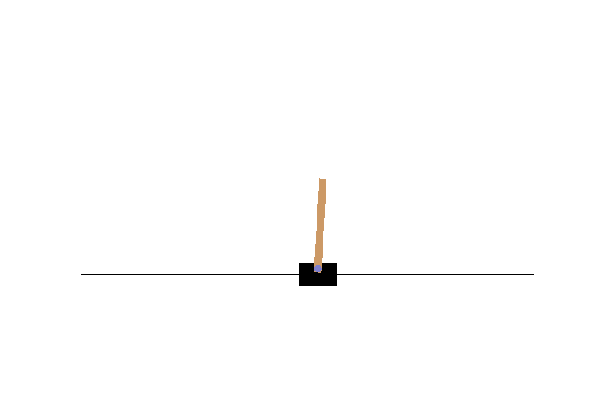
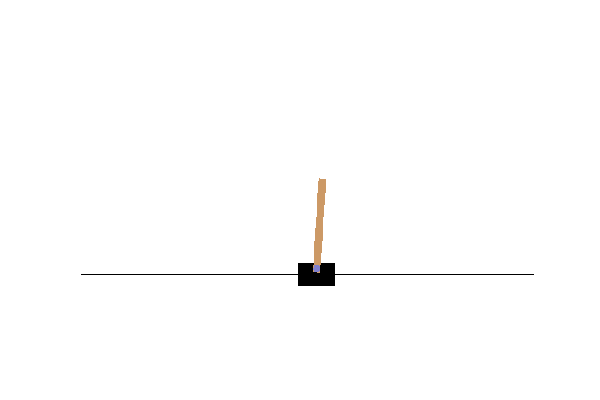
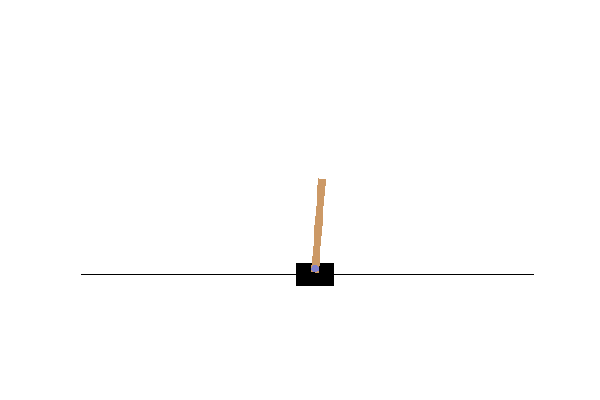
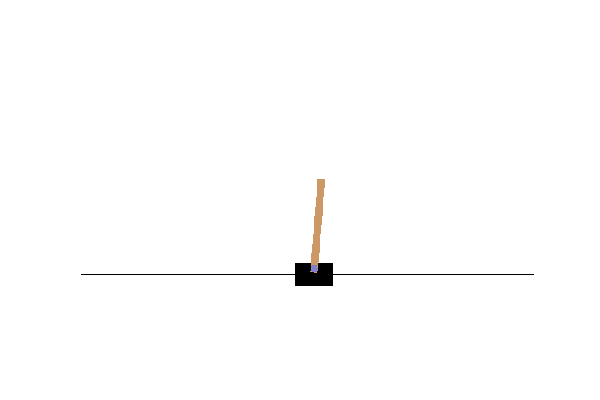
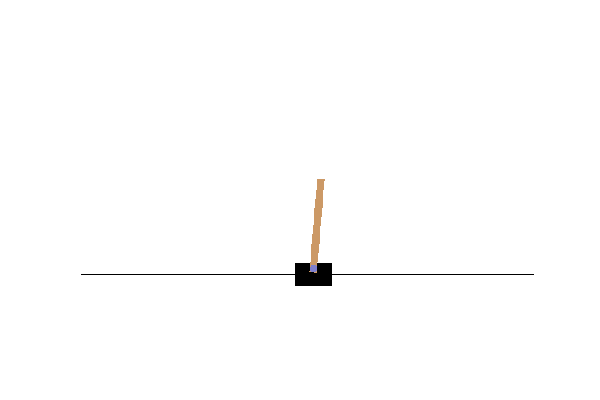
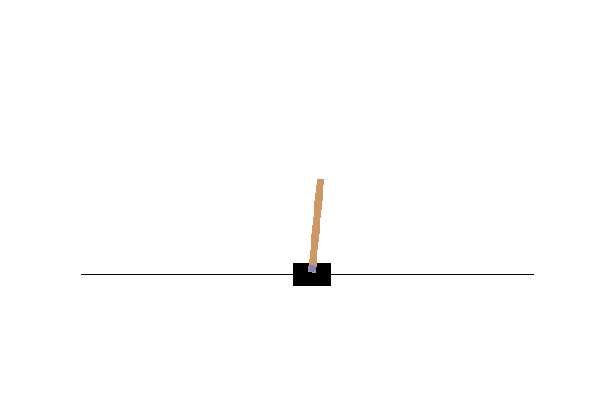
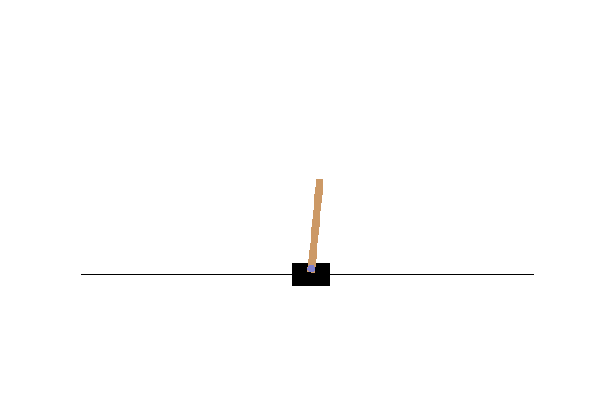
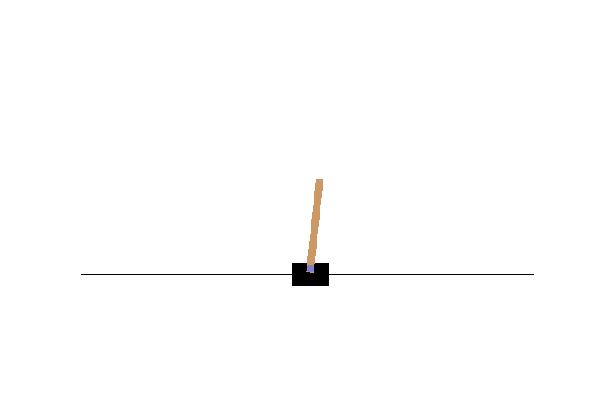
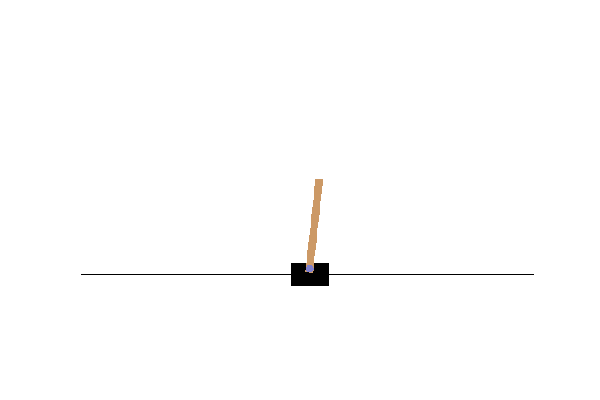
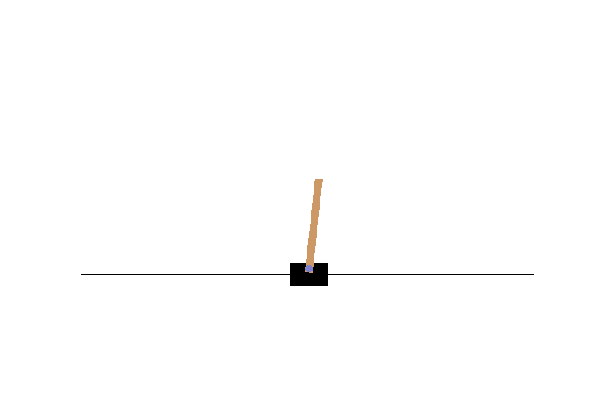
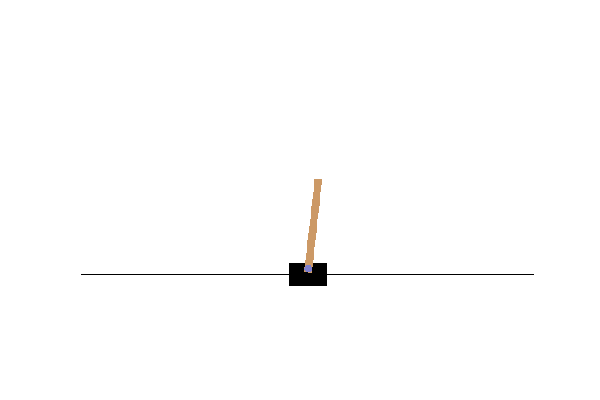
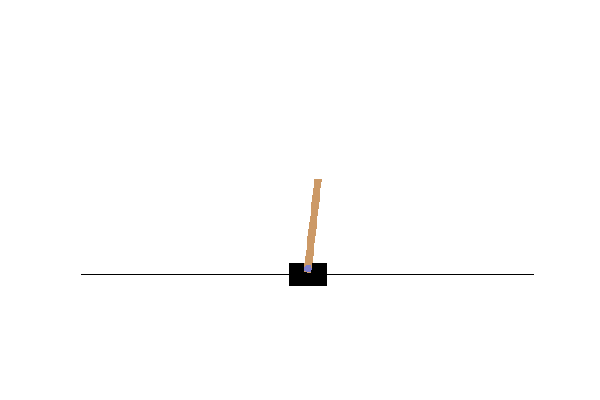
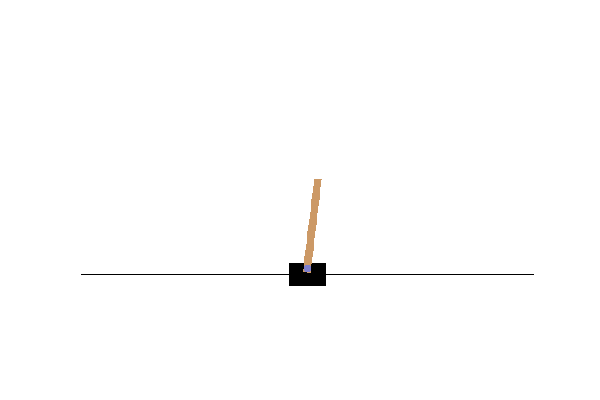
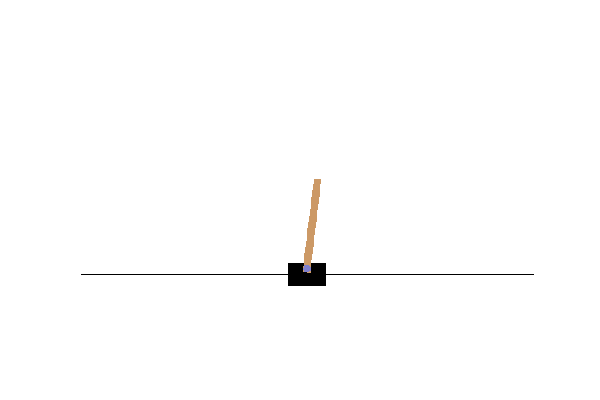
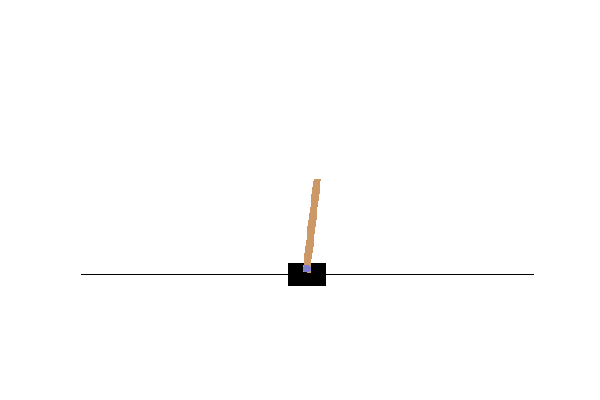
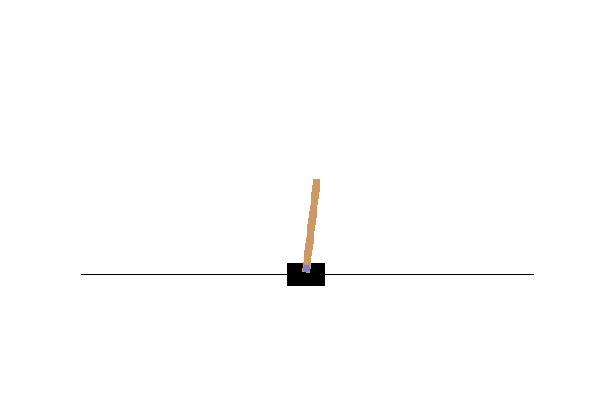
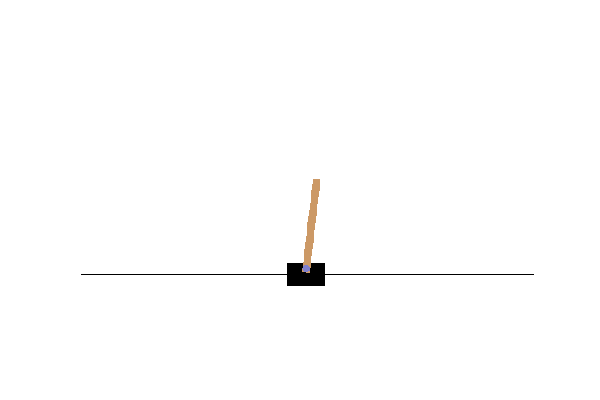
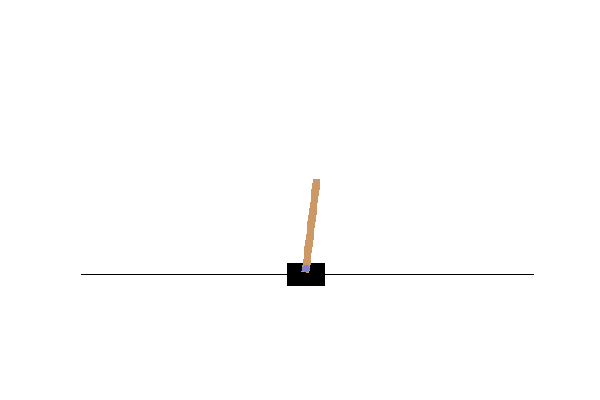
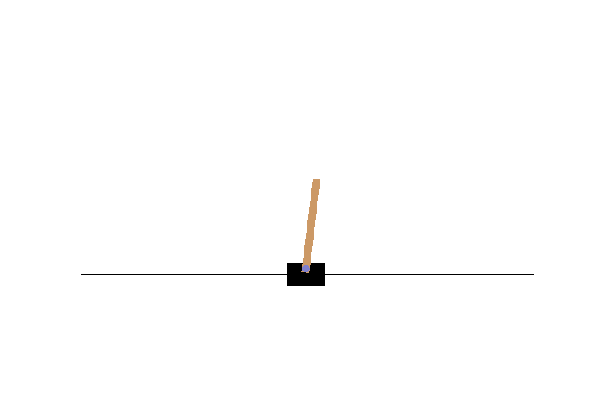
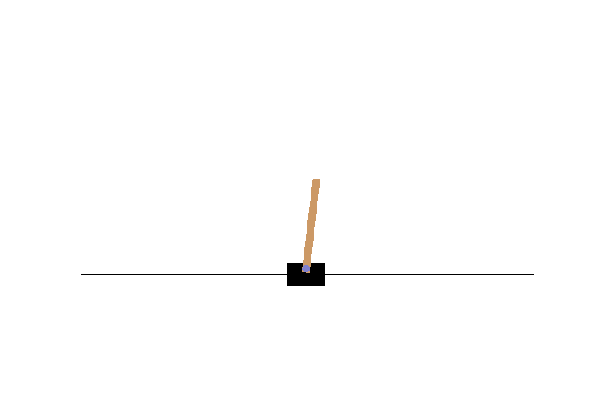
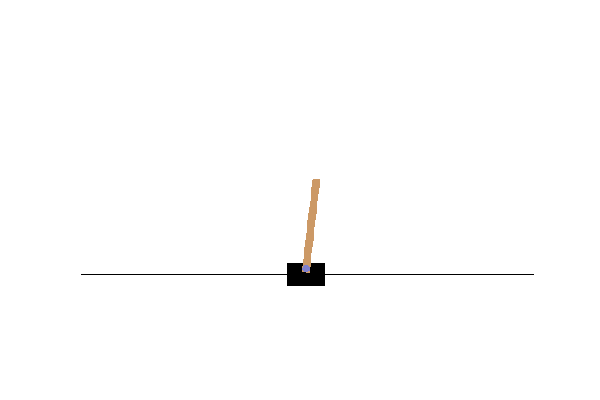
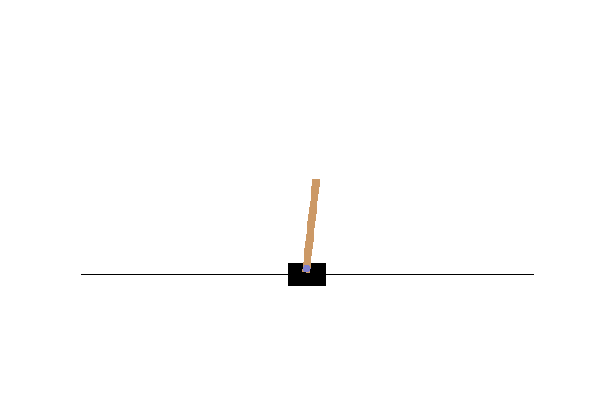
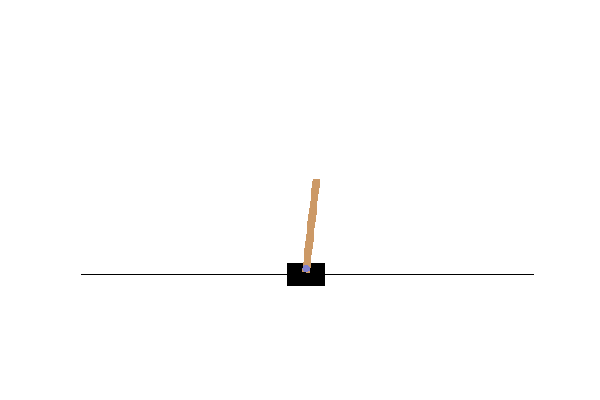
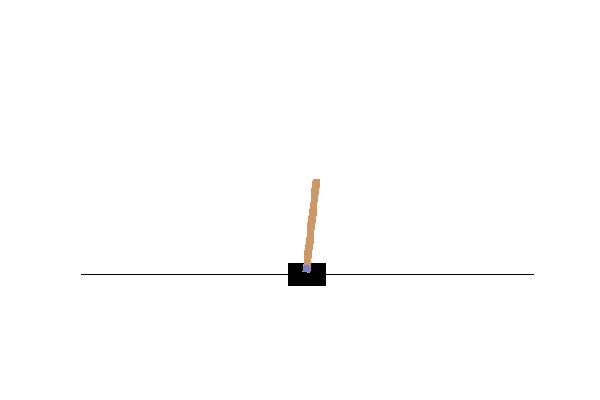
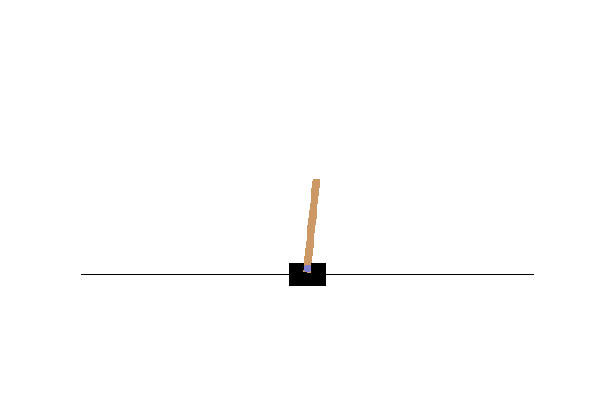
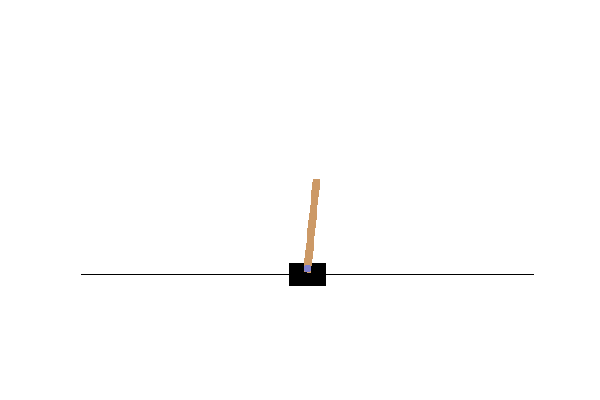
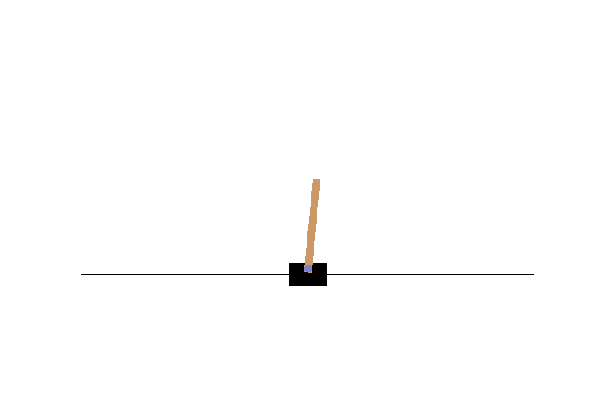
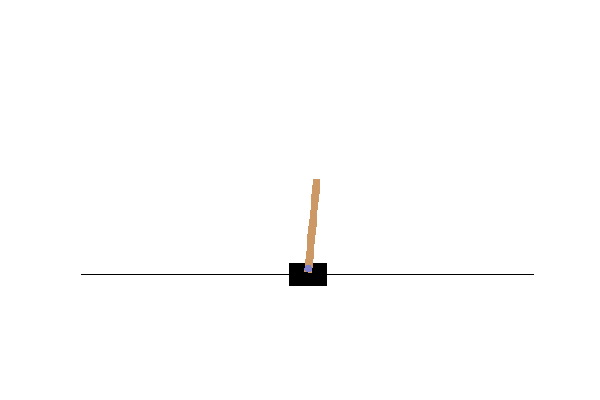
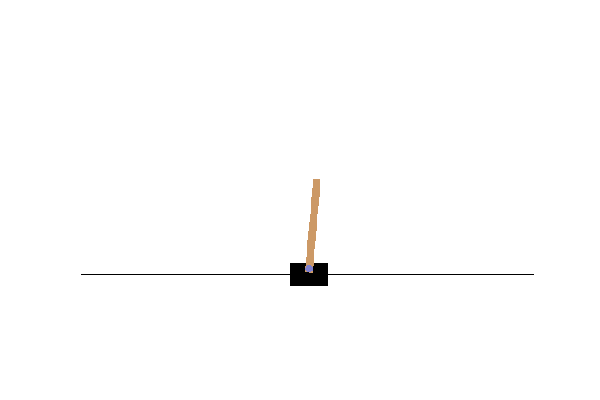
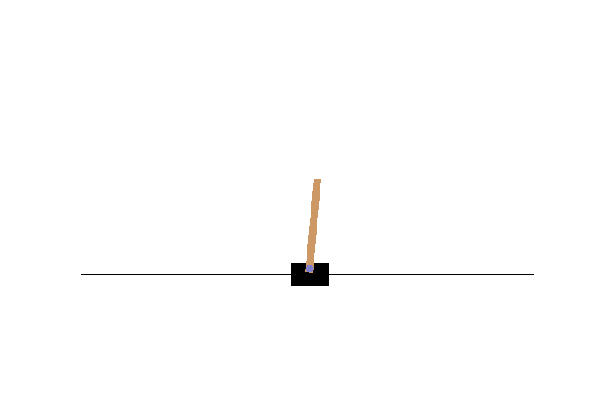
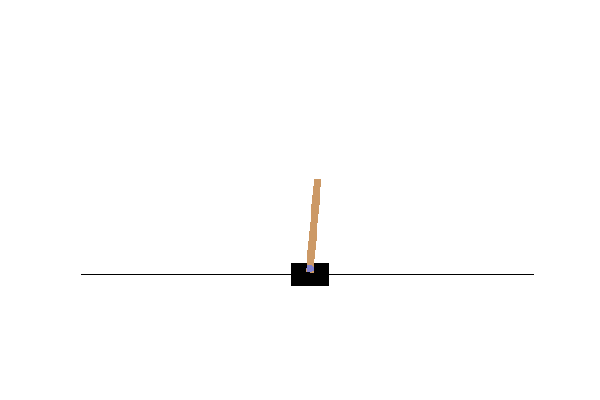
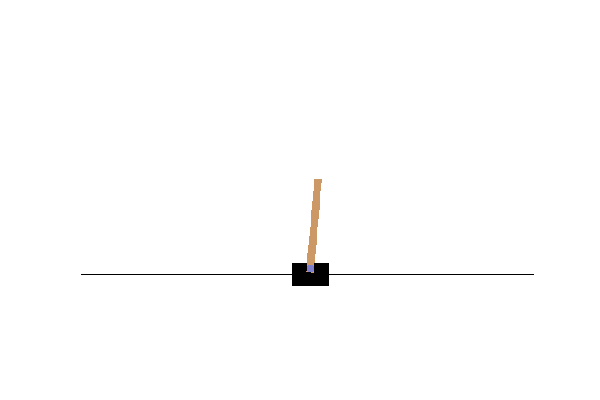
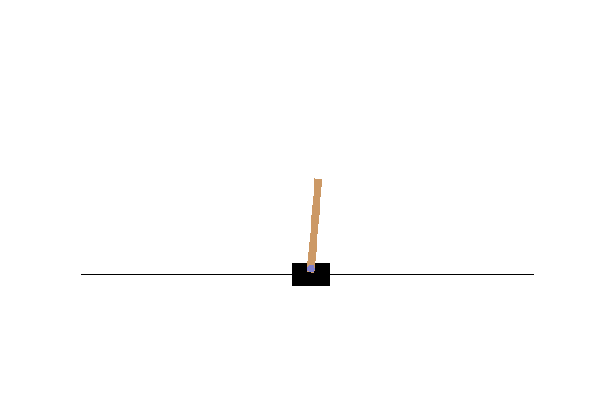
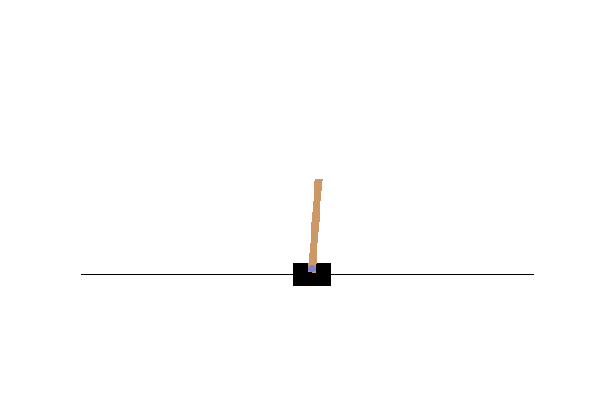
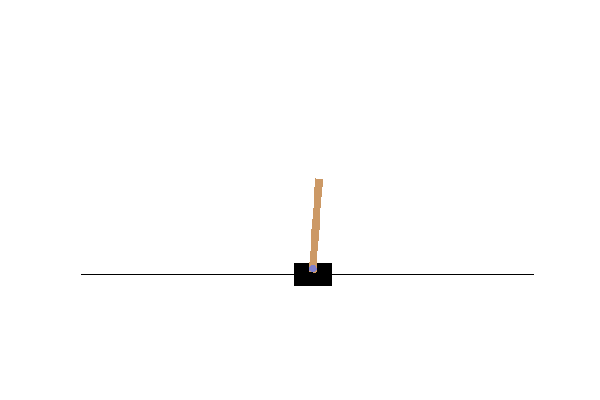
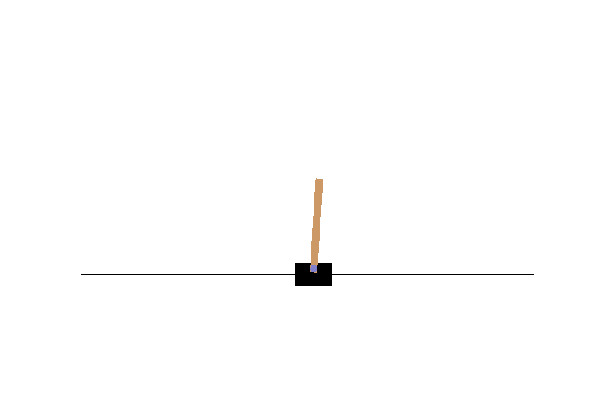
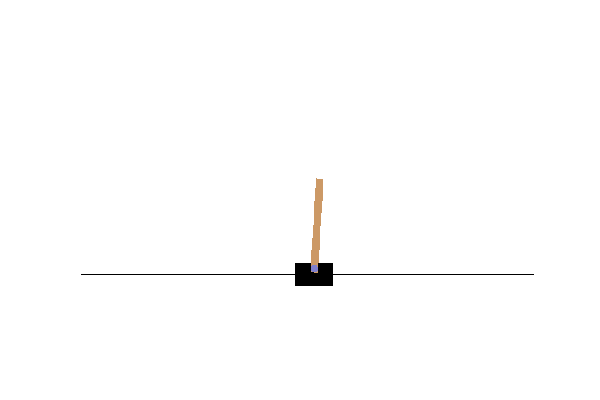
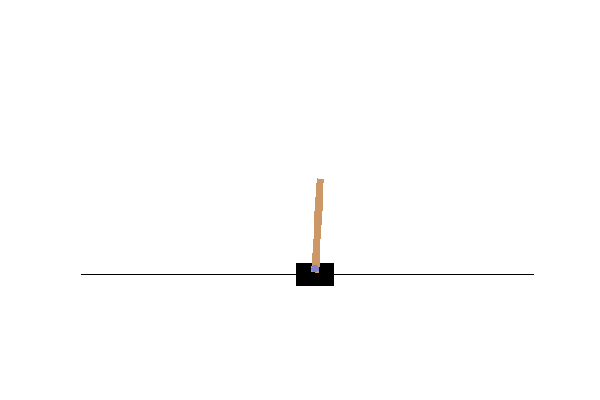
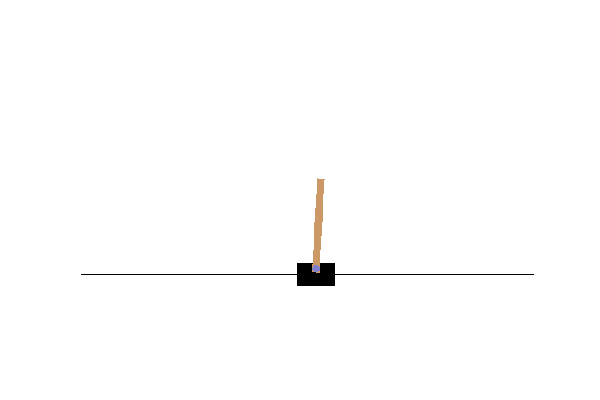
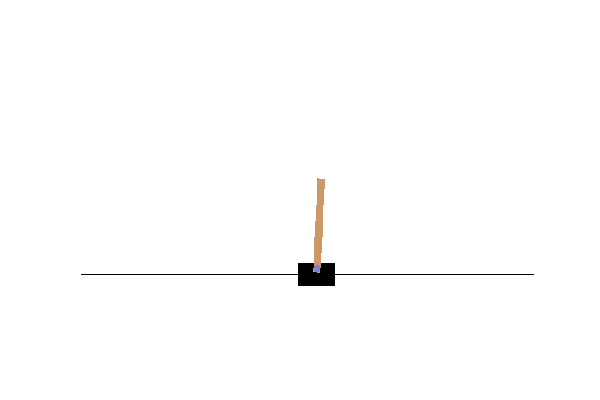
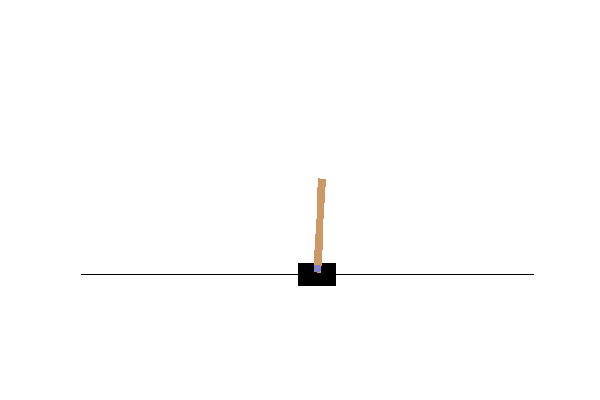
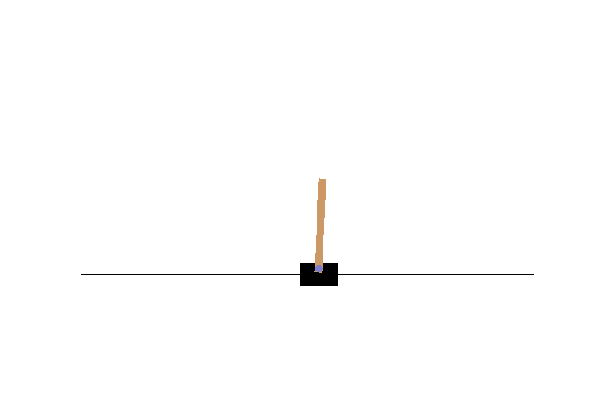
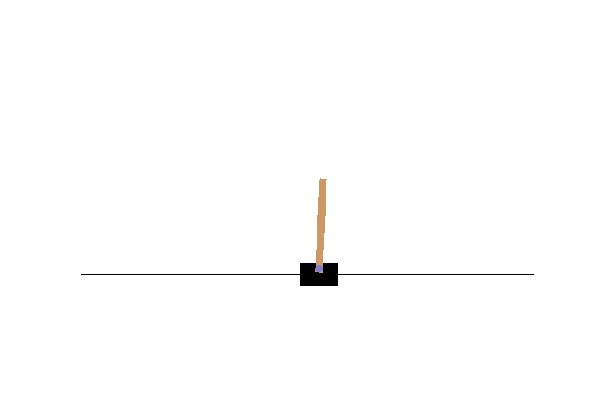
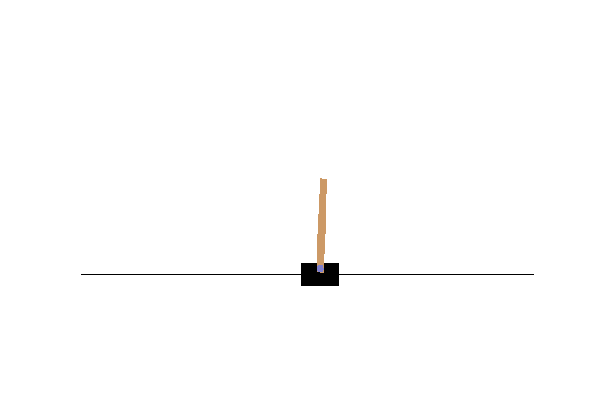
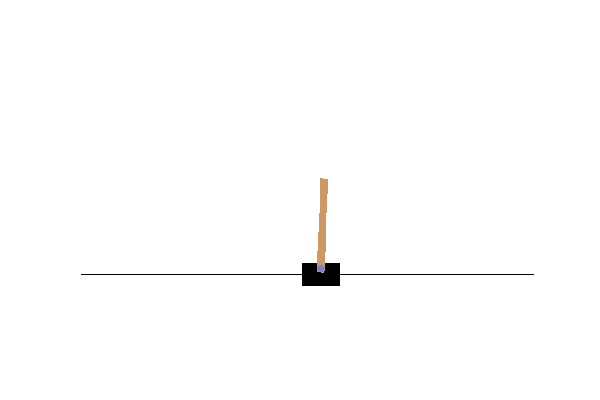
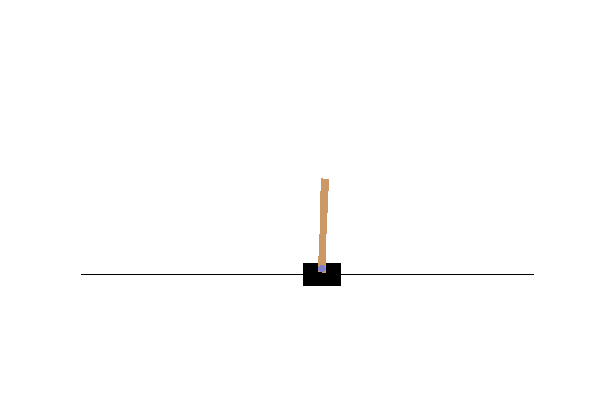
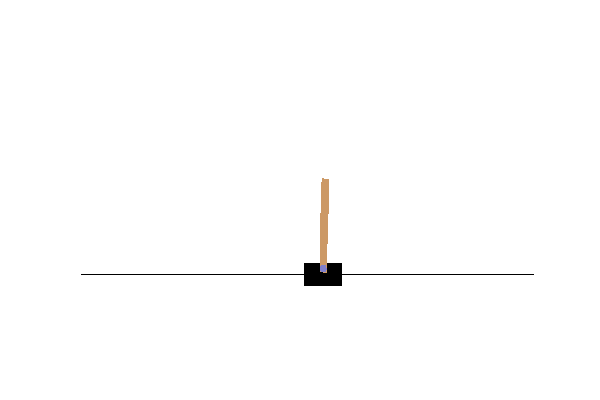
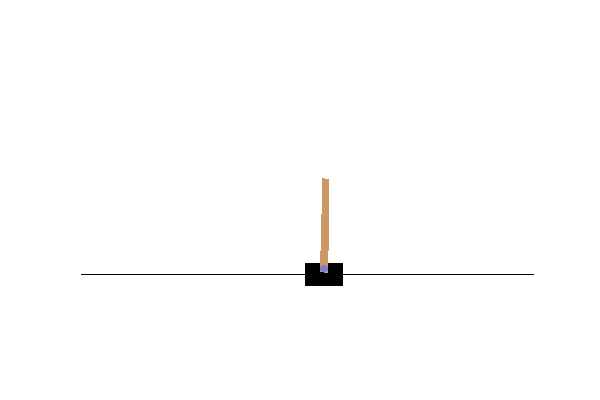
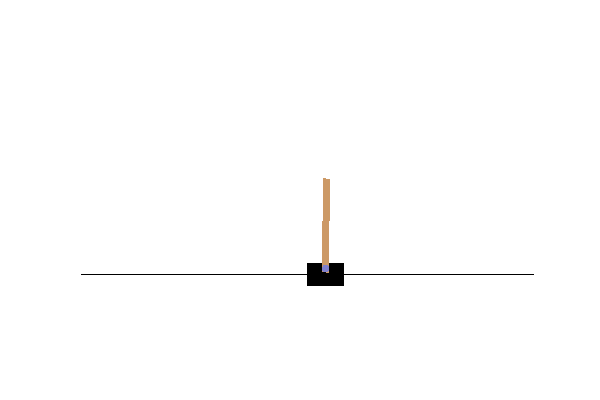
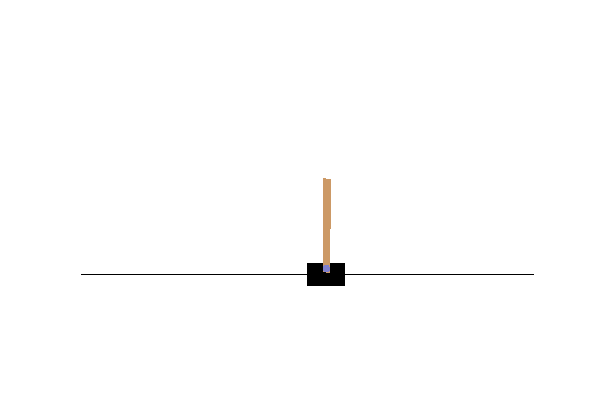
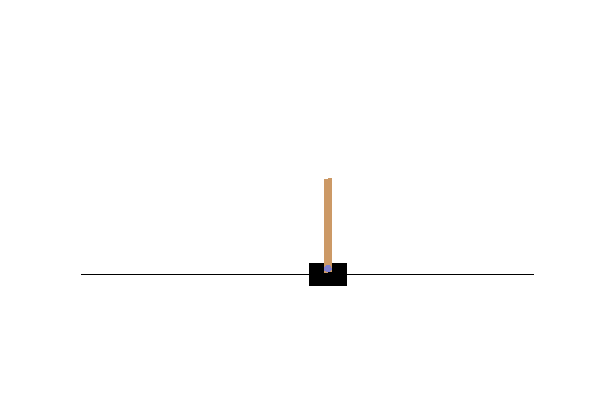
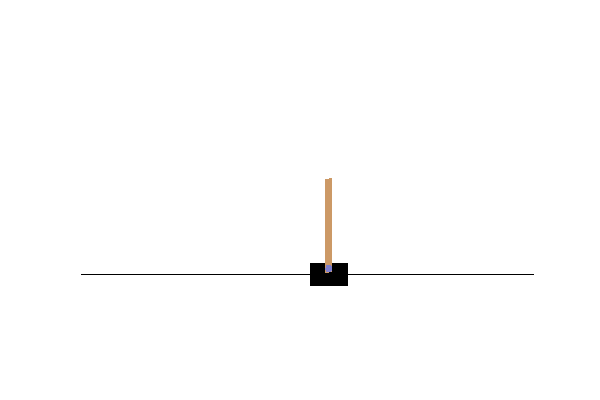
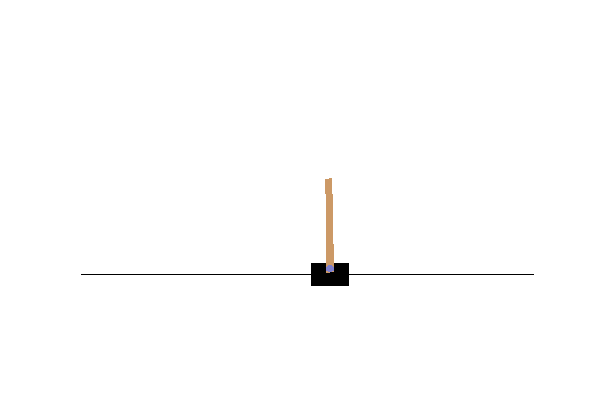

In [10]:
#making gif of our played game
#http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
frame = np.load(frame_)
display_frames_as_gif(frame[:720])